In [1]:
%load_ext autoreload
%autoreload 2

from typing import Literal, Union
from pathlib import Path
import csv
from datetime import datetime
import random


import pandas as pd
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import MIPROv2
from sklearn.model_selection import train_test_split

from programs import WrapperEnglishSPT, WrapperSpanishSPT, evaluate_answer
from custom_evaluation import custom_evaluate

In [2]:
lm = dspy.LM(
    "ollama_chat/deepseek-r1:14b",
    api_base="http://localhost:11434",
)
dspy.settings.configure(lm=lm)

In [3]:
lm("What is your name")

["<think>\n\n</think>\n\nGreetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have."]

In [4]:
data = pd.read_csv("dev_dwug_es.csv")
display(data.shape)

(8704, 8)

In [5]:
training_set = []

for _, row in data.iterrows():
    training_set.append(
        dspy.Example(
            sentence1=row["context_x"],
            sentence2=row["context_y"],
            target_word=row["lemma"],
            answer=int(row["judgment"]),
        ).with_inputs("sentence1", "sentence2", "target_word")
    )

In [6]:
classes_1_es = [item for item in training_set if item.answer == 1]
classes_2_es = [item for item in training_set if item.answer == 2]
classes_3_es = [item for item in training_set if item.answer == 3]
classes_4_es = [item for item in training_set if item.answer == 4]

print(len(classes_1_es))
print(len(classes_2_es))
print(len(classes_3_es))
print(len(classes_4_es))

classes_1_train, classes_1_dev = train_test_split(
    classes_1_es,
    test_size=0.2,
    random_state=42,
)

classes_1_train, classes_1_test = train_test_split(
    classes_1_train, test_size=0.2, random_state=42
)


classes_2_train, classes_2_dev = train_test_split(
    classes_2_es,
    test_size=0.2,
    random_state=42,
)
classes_2_train, classes_2_test = train_test_split(
    classes_2_train, test_size=0.2, random_state=42
)


classes_3_train, classes_3_dev = train_test_split(
    classes_3_es,
    test_size=0.2,
    random_state=42,
)
classes_3_train, classes_3_test = train_test_split(
    classes_3_train, test_size=0.2, random_state=42
)


classes_4_train, classes_4_dev = train_test_split(
    classes_4_es,
    test_size=0.2,
    random_state=42,
)
classes_4_train, classes_4_test = train_test_split(
    classes_4_train,
    test_size=0.2,
    random_state=42,
)

print(len(classes_1_train), len(classes_1_dev), len(classes_1_test))
print(len(classes_2_train), len(classes_2_dev), len(classes_2_test))
print(len(classes_3_train), len(classes_3_dev), len(classes_3_test))
print(len(classes_4_train), len(classes_4_dev), len(classes_4_test))

1406
1522
2343
3433
899 282 225
973 305 244
1499 469 375
2196 687 550


In [7]:
program_spt_prompt_es_assertions = WrapperSpanishSPT().activate_assertions()

In [8]:
# custom_evaluate(
#     random.choices(classes_1_test, k=225)
#     + random.choices(classes_2_test, k=225)
#     + random.choices(classes_3_test, k=225)
#     + random.choices(classes_4_test, k=225),
#     evaluate_answer,
#     program_spt_prompt_es_assertions,
#     debug=True,
# )

In [9]:
%reload_ext autoreload

start_time = datetime.now()

teleprompter = MIPROv2(
    metric=evaluate_answer,
    task_model=lm,
    num_candidates=10,
    init_temperature=0.7,
    max_bootstrapped_demos=3,
    max_labeled_demos=4,
    verbose=False,
)

print("Optimizing program with MIPRO...")
optimized_program = teleprompter.compile(
    program_spt_prompt_es_assertions.deepcopy(),
    trainset=random.choices(classes_1_train, k=500)
    + random.choices(classes_2_train, k=500)
    + random.choices(classes_3_train, k=500)
    + random.choices(classes_4_train, k=500),
    valset=random.choices(classes_1_dev, k=200)
    + random.choices(classes_2_dev, k=200)
    + random.choices(classes_3_dev, k=200)
    + random.choices(classes_4_dev, k=200),
    num_trials=15,
    minibatch_size=25,
    minibatch_full_eval_steps=10,
    minibatch=True,
    requires_permission_to_run=False,
)

optimized_program.save(f"compile-models/sp/es_spt_mipro_optimized_prompt_es_deepseek-q4")

print(f"Elapsed time: {datetime.now() - start_time}")

2025/04/17 13:12:03 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==


2025/04/17 13:12:03 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.



2025/04/17 13:12:03 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=10 sets of demonstrations...


Optimizing program with MIPRO...
Bootstrapping set 1/10
Bootstrapping set 2/10
Bootstrapping set 3/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                       | 1/2000 [00:18<10:21:49, 18.66s/it]

  0%|                                                                                                        | 2/2000 [00:28<7:25:02, 13.36s/it]

2025/04/17 13:12:42 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 13:12:53 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 13:12:53 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


  0%|▏                                                                                                       | 3/2000 [00:50<9:33:27, 17.23s/it]

  0%|▏                                                                                                       | 4/2000 [00:59<7:52:15, 14.20s/it]

  0%|▎                                                                                                       | 5/2000 [01:13<7:44:05, 13.96s/it]

  0%|▎                                                                                                       | 6/2000 [01:33<8:53:49, 16.06s/it]

  0%|▎                                                                                                       | 7/2000 [01:49<8:59:35, 16.24s/it]

  0%|▍                                                                                                       | 8/2000 [02:02<8:24:35, 15.20s/it]

2025/04/17 13:14:20 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 13:14:32 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


  0%|▍                                                                                                      | 9/2000 [02:41<12:21:49, 22.36s/it]

  0%|▌                                                                                                     | 10/2000 [02:51<10:22:11, 18.76s/it]

  1%|▌                                                                                                      | 11/2000 [03:03<9:09:31, 16.58s/it]

  1%|▌                                                                                                      | 12/2000 [03:15<8:28:06, 15.34s/it]

  1%|▋                                                                                                      | 13/2000 [03:24<7:15:52, 13.16s/it]

  1%|▋                                                                                                      | 13/2000 [03:24<8:39:46, 15.70s/it]

Bootstrapped 3 full traces after 13 examples for up to 1 rounds, amounting to 13 attempts.
Bootstrapping set 4/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2000 [00:14<7:54:05, 14.23s/it]

  0%|                                                                                                        | 1/2000 [00:14<7:54:07, 14.23s/it]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 5/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2000 [00:13<7:16:19, 13.10s/it]

  0%|                                                                                                        | 2/2000 [00:20<5:24:51,  9.76s/it]

  0%|                                                                                                        | 2/2000 [00:20<5:41:33, 10.26s/it]

Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2000 [00:10<5:34:43, 10.05s/it]

  0%|                                                                                                        | 2/2000 [00:19<5:28:07,  9.85s/it]

  0%|▏                                                                                                       | 3/2000 [00:31<6:03:23, 10.92s/it]

  0%|▏                                                                                                       | 4/2000 [00:39<5:18:26,  9.57s/it]

  0%|▎                                                                                                       | 5/2000 [00:51<5:49:49, 10.52s/it]

  0%|▎                                                                                                       | 6/2000 [00:59<5:19:53,  9.63s/it]

2025/04/17 13:17:06 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


  0%|▎                                                                                                       | 7/2000 [01:21<7:34:25, 13.68s/it]

  0%|▎                                                                                                       | 7/2000 [01:21<6:27:06, 11.65s/it]

Bootstrapped 2 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Bootstrapping set 7/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2000 [00:11<6:36:24, 11.90s/it]

  0%|                                                                                                        | 2/2000 [00:23<6:34:02, 11.83s/it]

  0%|▏                                                                                                       | 3/2000 [00:34<6:11:33, 11.16s/it]

  0%|▏                                                                                                       | 4/2000 [00:44<5:59:40, 10.81s/it]

  0%|▎                                                                                                       | 5/2000 [00:53<5:38:09, 10.17s/it]

  0%|▎                                                                                                       | 6/2000 [01:11<7:05:11, 12.79s/it]

  0%|▎                                                                                                       | 7/2000 [01:28<7:51:43, 14.20s/it]

  0%|▎                                                                                                       | 7/2000 [01:28<6:59:13, 12.62s/it]

Bootstrapped 3 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Bootstrapping set 8/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2000 [00:10<6:06:14, 10.99s/it]

  0%|                                                                                                        | 2/2000 [00:27<7:49:52, 14.11s/it]

  0%|                                                                                                        | 2/2000 [00:27<7:34:18, 13.64s/it]

Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 9/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2000 [00:13<7:38:35, 13.76s/it]

  0%|                                                                                                        | 2/2000 [00:25<6:57:50, 12.55s/it]

  0%|▏                                                                                                       | 3/2000 [00:37<6:53:34, 12.43s/it]

  0%|▏                                                                                                       | 4/2000 [00:57<8:25:01, 15.18s/it]

  0%|▏                                                                                                       | 4/2000 [00:57<7:55:16, 14.29s/it]

Bootstrapped 3 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Bootstrapping set 10/10


  0%|                                                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                        | 1/2000 [00:17<9:33:46, 17.22s/it]

  0%|                                                                                                       | 2/2000 [01:39<30:56:45, 55.76s/it]

  0%|▏                                                                                                      | 3/2000 [01:55<20:45:11, 37.41s/it]

  0%|▏                                                                                                      | 3/2000 [01:55<21:21:48, 38.51s/it]


2025/04/17 13:22:12 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==


2025/04/17 13:22:12 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 1 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


2025/04/17 13:24:42 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas
subjetivas. Evalúa la similitud semántica de la palabra objetivo en estas oraciones 1 y 2. Considera solo los objetos/conceptos
a los que se refieren las palabras: ¡Ignora cualquier etimología común y similitud metafórica! ¡Ignora mayúsculas!
¡Ignora número (gato/Gatos = significado idéntico)! Los homónimos (como murciélago el animal vs murciélago en béisbol)
se consideran no relacionados. De como salida una calificación numérica: 1 es no relacionado; 2 es lejanamente relacionado; 3 es
estrechamente relacionado; 4 es significado idéntico. Tu respuesta debe alinearse con el juicio sucinto de un humano.



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Eres un experto en lingüística y anotación de datos. Tu tarea es evaluar la proximidad semántica de una palabra objetivo entre dos oraciones en español. Considera solo los conceptos que refiere la palabra, ignora cualquier etimología o similitudes metafóricas. No te preocupes por mayúsculas ni números (gato/Gatos son iguales). Si el mismo vocablo tiene diferentes significados (como murciélago en español vs en béisbol), trata cada uso como independiente.

Para cada par de oraciones y palabra objetivo, asigna una calificación numérica:

1 = No están relacionados
2 = Relacionados lejanamente
3 = Relacionados estrechamente
4 = Exactamente el mismo significado

Tu respuesta debe ser clara y concisa, alineada con el juicio de un humano experto.



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 2: La palabra "servidor" en la primera oración se refiere a un servidor informático relacionado con el monitoreo y vigilancia, mientras que en la segunda se trata de servidores humanos o siervos. Son significados completamente diferentes sin overlapping alguno.



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 3: This program evaluates the relevance of two sentences regarding the target word "servidor." It assigns scores from 1 to 4 based on how directly or contextually related each sentence is to the term.



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 4: Eres una herramienta especializada en la evaluación de similitudes semánticas en texto. Analiza detenidamente las oraciones 1 y 2 para determinar la relación del significado de la palabra objetivo. Considera únicamente los objetos o conceptos a los que se refiere la palabra, ignorando cualquier conexión etimológica o metafórica. Los homónimos se consideran no relacionados a menos que compartan exactamente el mismo significado. Asigna una calificación numérica: 1 (no relacionado), 2 (lejanamente relacionado), 3 (estrechamente relacionado), 4 (significado idéntico). Tu objetivo es alinear tu respuesta con el juicio de un humano entrenado en este tipo de tareas.



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 5: La palabra "sexo" en ambas oraciones se refiere a la noción de género, pero en contextos diferentes. En la primera oración, se usa para describir a las personas de ambos géneros que participan en un acto político, mientras que en la segunda oración se usa para definir una característica personal de Susana como mujer.



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 6: Evalue la similitud semántica de la palabra objetivo en las siguientes oraciones 1 y 2. Considere solo los objetos/conceptos a los que se refiere la palabra. Ignore etimologías comunes, mayúsculas, número y homónimos. Asigne una calificación numérica: 1 (no relacionado), 2 (lejanamente relacionado), 3 (estrechamente relacionado), 4 (significado idéntico). Respuesta alineada con un juicio humano.



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 7: Eres una herramienta de anotación de datos textuales altamente entrenada, capaz de proporcionar respuestas subjetivas. Evalúa la similitud semántica de la palabra objetivo en estas oraciones 1 y 2. Considera solo los objetos/conceptos a los que se refieren las palabras: ¡Ignora cualquier etimología común y similitud metafórica! ¡Ignora mayúsculas! ¡Ignora número (gato/Gatos = significado idéntico)! Los homónimos (como murciélago el animal vs murciélago en béisbol) se consideran no relacionados. De como salida una calificación numérica: 1 es no relacionado; 2 es lejanamente relacionado; 3 es estrechamente relacionado; 4 es significado idéntico. Tu respuesta debe alinearse con el juicio sucinto de un humano.



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 8: Evalue la similitud semántica de la palabra objetivo en ambas oraciones considerando solo los objetos/conceptos a los que se refieren, ignorando etimologías comunes y similitudes metafóricas. Use: 1 (no relacionado), 2 (lejanamente relacionado), 3 (estrechamente relacionado), 4 (significado idéntico).



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 9: The word "aguantar" in both sentences refers to enduring or withstanding something, but the contexts differ slightly. In Sentence 1, it means enduring a tedious situation, while in Sentence 2, it implies restraining someone.

Answer: 1



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/04/17 13:49:43 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the default program...



  0%|                                                                                                                   | 0/800 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                     | 0/800 [01:24<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                          | 1/800 [01:24<18:50:51, 84.92s/it]

Average Metric: 0 / 2  (0.0):   0%|                                                                          | 1/800 [02:51<18:50:51, 84.92s/it]

Average Metric: 0 / 2  (0.0):   0%|▏                                                                         | 2/800 [02:51<19:03:59, 86.01s/it]

Average Metric: 0 / 3  (0.0):   0%|▏                                                                         | 2/800 [04:17<19:03:59, 86.01s/it]

Average Metric: 0 / 3  (0.0):   0%|▎                                                                         | 3/800 [04:17<19:01:06, 85.91s/it]

Average Metric: 1 / 4  (25.0):   0%|▎                                                                        | 3/800 [05:42<19:01:06, 85.91s/it]

Average Metric: 1 / 4  (25.0):   0%|▎                                                                        | 4/800 [05:42<18:53:18, 85.43s/it]

Average Metric: 2 / 5  (40.0):   0%|▎                                                                        | 4/800 [07:07<18:53:18, 85.43s/it]

Average Metric: 2 / 5  (40.0):   1%|▍                                                                        | 5/800 [07:07<18:49:32, 85.25s/it]

Average Metric: 2 / 6  (33.3):   1%|▍                                                                        | 5/800 [08:30<18:49:32, 85.25s/it]

Average Metric: 2 / 6  (33.3):   1%|▌                                                                        | 6/800 [08:30<18:41:44, 84.77s/it]

Average Metric: 2 / 7  (28.6):   1%|▌                                                                        | 6/800 [11:38<18:41:44, 84.77s/it]

Average Metric: 2 / 7  (28.6):   1%|▋                                                                       | 7/800 [11:38<26:03:40, 118.31s/it]

Average Metric: 2 / 8  (25.0):   1%|▋                                                                       | 7/800 [13:19<26:03:40, 118.31s/it]

Average Metric: 2 / 8  (25.0):   1%|▋                                                                       | 8/800 [13:19<24:47:58, 112.73s/it]

Average Metric: 2 / 9  (22.2):   1%|▋                                                                       | 8/800 [14:52<24:47:58, 112.73s/it]

Average Metric: 2 / 9  (22.2):   1%|▊                                                                       | 9/800 [14:52<23:25:48, 106.64s/it]

Average Metric: 2 / 10  (20.0):   1%|▊                                                                      | 9/800 [16:26<23:25:48, 106.64s/it]

Average Metric: 2 / 10  (20.0):   1%|▉                                                                     | 10/800 [16:26<22:33:57, 102.83s/it]

Average Metric: 3 / 11  (27.3):   1%|▉                                                                     | 10/800 [17:58<22:33:57, 102.83s/it]

Average Metric: 3 / 11  (27.3):   1%|▉                                                                      | 11/800 [17:58<21:48:21, 99.49s/it]

Average Metric: 3 / 12  (25.0):   1%|▉                                                                      | 11/800 [19:33<21:48:21, 99.49s/it]

Average Metric: 3 / 12  (25.0):   2%|█                                                                      | 12/800 [19:33<21:27:39, 98.04s/it]

Average Metric: 4 / 13  (30.8):   2%|█                                                                      | 12/800 [21:09<21:27:39, 98.04s/it]

Average Metric: 4 / 13  (30.8):   2%|█▏                                                                     | 13/800 [21:09<21:18:00, 97.43s/it]

Average Metric: 4 / 14  (28.6):   2%|█▏                                                                     | 13/800 [22:50<21:18:00, 97.43s/it]

Average Metric: 4 / 14  (28.6):   2%|█▏                                                                     | 14/800 [22:50<21:29:53, 98.46s/it]

Average Metric: 5 / 15  (33.3):   2%|█▏                                                                     | 14/800 [24:24<21:29:53, 98.46s/it]

Average Metric: 5 / 15  (33.3):   2%|█▎                                                                     | 15/800 [24:24<21:10:17, 97.09s/it]

Average Metric: 6 / 16  (37.5):   2%|█▎                                                                     | 15/800 [26:07<21:10:17, 97.09s/it]

Average Metric: 6 / 16  (37.5):   2%|█▍                                                                     | 16/800 [26:07<21:32:48, 98.94s/it]

Average Metric: 7 / 17  (41.2):   2%|█▍                                                                     | 16/800 [27:47<21:32:48, 98.94s/it]

Average Metric: 7 / 17  (41.2):   2%|█▌                                                                     | 17/800 [27:47<21:37:58, 99.46s/it]

Average Metric: 8 / 18  (44.4):   2%|█▌                                                                     | 17/800 [29:21<21:37:58, 99.46s/it]

Average Metric: 8 / 18  (44.4):   2%|█▌                                                                     | 18/800 [29:21<21:13:08, 97.68s/it]

Average Metric: 8 / 19  (42.1):   2%|█▌                                                                     | 18/800 [30:59<21:13:08, 97.68s/it]

Average Metric: 8 / 19  (42.1):   2%|█▋                                                                     | 19/800 [30:59<21:14:30, 97.91s/it]

Average Metric: 8 / 20  (40.0):   2%|█▋                                                                     | 19/800 [32:28<21:14:30, 97.91s/it]

Average Metric: 8 / 20  (40.0):   2%|█▊                                                                     | 20/800 [32:28<20:37:28, 95.19s/it]

Average Metric: 8 / 21  (38.1):   2%|█▊                                                                     | 20/800 [34:06<20:37:28, 95.19s/it]

Average Metric: 8 / 21  (38.1):   3%|█▊                                                                     | 21/800 [34:06<20:46:23, 96.00s/it]

Average Metric: 8 / 22  (36.4):   3%|█▊                                                                     | 21/800 [35:39<20:46:23, 96.00s/it]

Average Metric: 8 / 22  (36.4):   3%|█▉                                                                     | 22/800 [35:39<20:31:21, 94.96s/it]

Average Metric: 9 / 23  (39.1):   3%|█▉                                                                     | 22/800 [37:12<20:31:21, 94.96s/it]

Average Metric: 9 / 23  (39.1):   3%|██                                                                     | 23/800 [37:12<20:23:07, 94.45s/it]

Average Metric: 9 / 24  (37.5):   3%|██                                                                     | 23/800 [38:41<20:23:07, 94.45s/it]

Average Metric: 9 / 24  (37.5):   3%|██▏                                                                    | 24/800 [38:41<20:02:07, 92.95s/it]

Average Metric: 10 / 25  (40.0):   3%|██                                                                    | 24/800 [40:17<20:02:07, 92.95s/it]

Average Metric: 10 / 25  (40.0):   3%|██▏                                                                   | 25/800 [40:17<20:11:13, 93.77s/it]

Average Metric: 10 / 26  (38.5):   3%|██▏                                                                   | 25/800 [41:55<20:11:13, 93.77s/it]

Average Metric: 10 / 26  (38.5):   3%|██▎                                                                   | 26/800 [41:55<20:24:53, 94.95s/it]

Average Metric: 10 / 27  (37.0):   3%|██▎                                                                   | 26/800 [43:30<20:24:53, 94.95s/it]

Average Metric: 10 / 27  (37.0):   3%|██▎                                                                   | 27/800 [43:30<20:23:56, 95.00s/it]

Average Metric: 11 / 28  (39.3):   3%|██▎                                                                   | 27/800 [44:57<20:23:56, 95.00s/it]

Average Metric: 11 / 28  (39.3):   4%|██▍                                                                   | 28/800 [44:57<19:53:30, 92.76s/it]

Average Metric: 11 / 29  (37.9):   4%|██▍                                                                   | 28/800 [46:37<19:53:30, 92.76s/it]

Average Metric: 11 / 29  (37.9):   4%|██▌                                                                   | 29/800 [46:37<20:17:12, 94.72s/it]

Average Metric: 11 / 30  (36.7):   4%|██▌                                                                   | 29/800 [48:03<20:17:12, 94.72s/it]

Average Metric: 11 / 30  (36.7):   4%|██▋                                                                   | 30/800 [48:03<19:43:06, 92.19s/it]

Average Metric: 12 / 31  (38.7):   4%|██▋                                                                   | 30/800 [49:40<19:43:06, 92.19s/it]

Average Metric: 12 / 31  (38.7):   4%|██▋                                                                   | 31/800 [49:40<19:59:58, 93.63s/it]

Average Metric: 13 / 32  (40.6):   4%|██▋                                                                   | 31/800 [51:20<19:59:58, 93.63s/it]

Average Metric: 13 / 32  (40.6):   4%|██▊                                                                   | 32/800 [51:20<20:23:53, 95.62s/it]

Average Metric: 14 / 33  (42.4):   4%|██▊                                                                   | 32/800 [52:58<20:23:53, 95.62s/it]

Average Metric: 14 / 33  (42.4):   4%|██▉                                                                   | 33/800 [52:58<20:30:48, 96.28s/it]

Average Metric: 14 / 34  (41.2):   4%|██▉                                                                   | 33/800 [54:38<20:30:48, 96.28s/it]

Average Metric: 14 / 34  (41.2):   4%|██▉                                                                   | 34/800 [54:38<20:41:58, 97.28s/it]

Average Metric: 14 / 35  (40.0):   4%|██▉                                                                   | 34/800 [56:07<20:41:58, 97.28s/it]

Average Metric: 14 / 35  (40.0):   4%|███                                                                   | 35/800 [56:07<20:09:54, 94.90s/it]

Average Metric: 14 / 36  (38.9):   4%|███                                                                   | 35/800 [57:47<20:09:54, 94.90s/it]

Average Metric: 14 / 36  (38.9):   4%|███▏                                                                  | 36/800 [57:47<20:25:49, 96.27s/it]

Average Metric: 14 / 37  (37.8):   4%|███▏                                                                  | 36/800 [59:21<20:25:49, 96.27s/it]

Average Metric: 14 / 37  (37.8):   5%|███▏                                                                  | 37/800 [59:21<20:17:58, 95.78s/it]

Average Metric: 14 / 38  (36.8):   5%|███▏                                                                | 37/800 [1:01:00<20:17:58, 95.78s/it]

Average Metric: 14 / 38  (36.8):   5%|███▏                                                                | 38/800 [1:01:00<20:29:13, 96.79s/it]

Average Metric: 14 / 39  (35.9):   5%|███▏                                                                | 38/800 [1:01:00<20:29:13, 96.79s/it]

Average Metric: 14 / 40  (35.0):   5%|███▎                                                                | 39/800 [1:02:41<20:27:36, 96.79s/it]

Average Metric: 14 / 40  (35.0):   5%|███▍                                                                | 40/800 [1:02:41<15:55:15, 75.42s/it]

Average Metric: 15 / 41  (36.6):   5%|███▍                                                                | 40/800 [1:04:17<15:55:15, 75.42s/it]

Average Metric: 15 / 41  (36.6):   5%|███▍                                                                | 41/800 [1:04:17<16:58:17, 80.50s/it]

Average Metric: 16 / 42  (38.1):   5%|███▍                                                                | 41/800 [1:05:56<16:58:17, 80.50s/it]

Average Metric: 16 / 42  (38.1):   5%|███▌                                                                | 42/800 [1:05:56<17:58:21, 85.36s/it]

Average Metric: 16 / 43  (37.2):   5%|███▌                                                                | 42/800 [1:05:56<17:58:21, 85.36s/it]

Average Metric: 16 / 44  (36.4):   5%|███▋                                                                | 43/800 [1:07:42<17:56:56, 85.36s/it]

Average Metric: 16 / 44  (36.4):   6%|███▋                                                                | 44/800 [1:07:42<14:59:52, 71.42s/it]

Average Metric: 16 / 45  (35.6):   6%|███▋                                                                | 44/800 [1:09:32<14:59:52, 71.42s/it]

Average Metric: 16 / 45  (35.6):   6%|███▊                                                                | 45/800 [1:09:32<16:51:59, 80.42s/it]

Average Metric: 16 / 46  (34.8):   6%|███▊                                                                | 45/800 [1:11:06<16:51:59, 80.42s/it]

Average Metric: 16 / 46  (34.8):   6%|███▉                                                                | 46/800 [1:11:06<17:35:19, 83.98s/it]

Average Metric: 17 / 47  (36.2):   6%|███▉                                                                | 46/800 [1:12:50<17:35:19, 83.98s/it]

Average Metric: 17 / 47  (36.2):   6%|███▉                                                                | 47/800 [1:12:50<18:38:32, 89.13s/it]

Average Metric: 18 / 48  (37.5):   6%|███▉                                                                | 47/800 [1:14:27<18:38:32, 89.13s/it]

Average Metric: 18 / 48  (37.5):   6%|████                                                                | 48/800 [1:14:27<19:04:54, 91.35s/it]

Average Metric: 18 / 49  (36.7):   6%|████                                                                | 48/800 [1:14:27<19:04:54, 91.35s/it]

Average Metric: 19 / 50  (38.0):   6%|████▏                                                               | 49/800 [1:15:59<19:03:23, 91.35s/it]

Average Metric: 19 / 50  (38.0):   6%|████▎                                                               | 50/800 [1:15:59<14:52:09, 71.37s/it]

Average Metric: 19 / 51  (37.3):   6%|████▎                                                               | 50/800 [1:15:59<14:52:09, 71.37s/it]

Average Metric: 20 / 52  (38.5):   6%|████▎                                                               | 51/800 [1:17:43<14:50:58, 71.37s/it]

Average Metric: 20 / 52  (38.5):   6%|████▍                                                               | 52/800 [1:17:43<13:18:34, 64.06s/it]

Average Metric: 21 / 53  (39.6):   6%|████▍                                                               | 52/800 [1:19:23<13:18:34, 64.06s/it]

Average Metric: 21 / 53  (39.6):   7%|████▌                                                               | 53/800 [1:19:23<14:52:50, 71.71s/it]

Average Metric: 22 / 54  (40.7):   7%|████▌                                                               | 53/800 [1:21:00<14:52:50, 71.71s/it]

Average Metric: 22 / 54  (40.7):   7%|████▌                                                               | 54/800 [1:21:00<16:06:42, 77.75s/it]

Average Metric: 23 / 55  (41.8):   7%|████▌                                                               | 54/800 [1:22:37<16:06:42, 77.75s/it]

Average Metric: 23 / 55  (41.8):   7%|████▋                                                               | 55/800 [1:22:37<17:05:37, 82.60s/it]

Average Metric: 24 / 56  (42.9):   7%|████▋                                                               | 55/800 [1:24:06<17:05:37, 82.60s/it]

Average Metric: 24 / 56  (42.9):   7%|████▊                                                               | 56/800 [1:24:06<17:24:17, 84.22s/it]

Average Metric: 24 / 57  (42.1):   7%|████▊                                                               | 56/800 [1:25:40<17:24:17, 84.22s/it]

Average Metric: 24 / 57  (42.1):   7%|████▊                                                               | 57/800 [1:25:40<17:55:25, 86.85s/it]

Average Metric: 25 / 58  (43.1):   7%|████▊                                                               | 57/800 [1:27:16<17:55:25, 86.85s/it]

Average Metric: 25 / 58  (43.1):   7%|████▉                                                               | 58/800 [1:27:16<18:25:07, 89.36s/it]

Average Metric: 26 / 59  (44.1):   7%|████▉                                                               | 58/800 [1:28:53<18:25:07, 89.36s/it]

Average Metric: 26 / 59  (44.1):   7%|█████                                                               | 59/800 [1:28:53<18:52:46, 91.72s/it]

Average Metric: 27 / 60  (45.0):   7%|█████                                                               | 59/800 [1:30:28<18:52:46, 91.72s/it]

Average Metric: 27 / 60  (45.0):   8%|█████                                                               | 60/800 [1:30:28<19:00:53, 92.50s/it]

Average Metric: 27 / 61  (44.3):   8%|█████                                                               | 60/800 [1:32:00<19:00:53, 92.50s/it]

Average Metric: 27 / 61  (44.3):   8%|█████▏                                                              | 61/800 [1:32:00<18:57:40, 92.37s/it]

Average Metric: 27 / 62  (43.5):   8%|█████▏                                                              | 61/800 [1:32:00<18:57:40, 92.37s/it]

Average Metric: 27 / 63  (42.9):   8%|█████▎                                                              | 62/800 [1:32:00<18:56:08, 92.37s/it]

Average Metric: 27 / 64  (42.2):   8%|█████▎                                                              | 63/800 [1:33:33<18:54:35, 92.37s/it]

Average Metric: 27 / 64  (42.2):   8%|█████▍                                                              | 64/800 [1:33:33<11:55:18, 58.31s/it]

Average Metric: 28 / 65  (43.1):   8%|█████▍                                                              | 64/800 [1:33:33<11:55:18, 58.31s/it]

Average Metric: 29 / 66  (43.9):   8%|█████▌                                                              | 65/800 [1:35:03<11:54:20, 58.31s/it]

Average Metric: 29 / 66  (43.9):   8%|█████▌                                                              | 66/800 [1:35:03<10:57:06, 53.71s/it]

Average Metric: 29 / 67  (43.3):   8%|█████▌                                                              | 66/800 [1:36:38<10:57:06, 53.71s/it]

Average Metric: 29 / 67  (43.3):   8%|█████▋                                                              | 67/800 [1:36:38<12:34:04, 61.73s/it]

Average Metric: 29 / 68  (42.6):   8%|█████▋                                                              | 67/800 [1:36:38<12:34:04, 61.73s/it]

Average Metric: 29 / 69  (42.0):   8%|█████▊                                                              | 68/800 [1:38:17<12:33:02, 61.73s/it]

Average Metric: 29 / 69  (42.0):   9%|█████▊                                                              | 69/800 [1:38:17<11:39:36, 57.42s/it]

Average Metric: 29 / 70  (41.4):   9%|█████▊                                                              | 69/800 [1:38:17<11:39:36, 57.42s/it]

Average Metric: 29 / 71  (40.8):   9%|█████▉                                                              | 70/800 [1:40:08<11:38:38, 57.42s/it]

Average Metric: 29 / 71  (40.8):   9%|██████                                                              | 71/800 [1:40:08<11:29:09, 56.72s/it]

Average Metric: 30 / 72  (41.7):   9%|██████                                                              | 71/800 [1:41:39<11:29:09, 56.72s/it]

Average Metric: 30 / 72  (41.7):   9%|██████                                                              | 72/800 [1:41:39<12:49:29, 63.42s/it]

Average Metric: 31 / 73  (42.5):   9%|██████                                                              | 72/800 [1:43:18<12:49:29, 63.42s/it]

Average Metric: 31 / 73  (42.5):   9%|██████▏                                                             | 73/800 [1:43:18<14:22:11, 71.16s/it]

Average Metric: 31 / 74  (41.9):   9%|██████▏                                                             | 73/800 [1:43:18<14:22:11, 71.16s/it]

Average Metric: 32 / 75  (42.7):   9%|██████▎                                                             | 74/800 [1:44:58<14:21:00, 71.16s/it]

Average Metric: 32 / 75  (42.7):   9%|██████▍                                                             | 75/800 [1:44:58<12:41:08, 62.99s/it]

Average Metric: 33 / 76  (43.4):   9%|██████▍                                                             | 75/800 [1:44:58<12:41:08, 62.99s/it]

Average Metric: 34 / 77  (44.2):  10%|██████▍                                                             | 76/800 [1:44:58<12:40:05, 62.99s/it]

Average Metric: 34 / 78  (43.6):  10%|██████▌                                                             | 77/800 [1:46:34<12:39:02, 62.99s/it]

Average Metric: 34 / 78  (43.6):  10%|██████▋                                                              | 78/800 [1:46:34<9:49:44, 49.01s/it]

Average Metric: 35 / 79  (44.3):  10%|██████▋                                                              | 78/800 [1:48:15<9:49:44, 49.01s/it]

Average Metric: 35 / 79  (44.3):  10%|██████▋                                                             | 79/800 [1:48:15<11:40:44, 58.31s/it]

Average Metric: 35 / 80  (43.8):  10%|██████▋                                                             | 79/800 [1:49:47<11:40:44, 58.31s/it]

Average Metric: 35 / 80  (43.8):  10%|██████▊                                                             | 80/800 [1:49:47<13:01:01, 65.09s/it]

Average Metric: 36 / 81  (44.4):  10%|██████▊                                                             | 80/800 [1:49:47<13:01:01, 65.09s/it]

Average Metric: 36 / 82  (43.9):  10%|██████▉                                                             | 81/800 [1:51:36<12:59:56, 65.09s/it]

Average Metric: 36 / 82  (43.9):  10%|██████▉                                                             | 82/800 [1:51:36<12:11:41, 61.14s/it]

Average Metric: 37 / 83  (44.6):  10%|██████▉                                                             | 82/800 [1:53:14<12:11:41, 61.14s/it]

Average Metric: 37 / 83  (44.6):  10%|███████                                                             | 83/800 [1:53:14<13:41:52, 68.78s/it]

Average Metric: 38 / 84  (45.2):  10%|███████                                                             | 83/800 [1:54:46<13:41:52, 68.78s/it]

Average Metric: 38 / 84  (45.2):  10%|███████▏                                                            | 84/800 [1:54:46<14:46:03, 74.25s/it]

Average Metric: 38 / 85  (44.7):  10%|███████▏                                                            | 84/800 [1:56:22<14:46:03, 74.25s/it]

Average Metric: 38 / 85  (44.7):  11%|███████▏                                                            | 85/800 [1:56:22<15:45:51, 79.37s/it]

Average Metric: 38 / 86  (44.2):  11%|███████▏                                                            | 85/800 [1:56:22<15:45:51, 79.37s/it]

Average Metric: 39 / 87  (44.8):  11%|███████▎                                                            | 86/800 [1:58:05<15:44:32, 79.37s/it]

Average Metric: 39 / 87  (44.8):  11%|███████▍                                                            | 87/800 [1:58:05<13:26:59, 67.91s/it]

Average Metric: 40 / 88  (45.5):  11%|███████▍                                                            | 87/800 [1:59:36<13:26:59, 67.91s/it]

Average Metric: 40 / 88  (45.5):  11%|███████▍                                                            | 88/800 [1:59:36<14:29:09, 73.24s/it]

Average Metric: 41 / 89  (46.1):  11%|███████▍                                                            | 88/800 [1:59:36<14:29:09, 73.24s/it]

Average Metric: 42 / 90  (46.7):  11%|███████▌                                                            | 89/800 [2:01:10<14:27:56, 73.24s/it]

Average Metric: 42 / 90  (46.7):  11%|███████▋                                                            | 90/800 [2:01:10<12:25:16, 62.98s/it]

Average Metric: 42 / 91  (46.2):  11%|███████▋                                                            | 90/800 [2:01:10<12:25:16, 62.98s/it]

Average Metric: 43 / 92  (46.7):  11%|███████▋                                                            | 91/800 [2:02:43<12:24:13, 62.98s/it]

Average Metric: 43 / 92  (46.7):  12%|███████▊                                                            | 92/800 [2:02:43<11:12:20, 56.98s/it]

Average Metric: 43 / 93  (46.2):  12%|███████▊                                                            | 92/800 [2:04:16<11:12:20, 56.98s/it]

Average Metric: 43 / 93  (46.2):  12%|███████▉                                                            | 93/800 [2:04:16<12:37:02, 64.25s/it]

Average Metric: 43 / 94  (45.7):  12%|███████▉                                                            | 93/800 [2:04:16<12:37:02, 64.25s/it]

Average Metric: 44 / 95  (46.3):  12%|███████▉                                                            | 94/800 [2:04:16<12:35:58, 64.25s/it]

Average Metric: 45 / 96  (46.9):  12%|████████                                                            | 95/800 [2:05:54<12:34:54, 64.25s/it]

Average Metric: 45 / 96  (46.9):  12%|████████▎                                                            | 96/800 [2:05:54<9:41:42, 49.58s/it]

Average Metric: 46 / 97  (47.4):  12%|████████▎                                                            | 96/800 [2:07:31<9:41:42, 49.58s/it]

Average Metric: 46 / 97  (47.4):  12%|████████▏                                                           | 97/800 [2:07:31<11:21:38, 58.18s/it]

Average Metric: 47 / 98  (48.0):  12%|████████▏                                                           | 97/800 [2:09:11<11:21:38, 58.18s/it]

Average Metric: 47 / 98  (48.0):  12%|████████▎                                                           | 98/800 [2:09:11<13:01:53, 66.83s/it]

Average Metric: 48 / 99  (48.5):  12%|████████▎                                                           | 98/800 [2:09:11<13:01:53, 66.83s/it]

Average Metric: 48 / 100  (48.0):  12%|████████▎                                                          | 99/800 [2:09:11<13:00:47, 66.83s/it]

Average Metric: 49 / 101  (48.5):  12%|████████▎                                                         | 100/800 [2:10:50<12:59:40, 66.83s/it]

Average Metric: 49 / 101  (48.5):  13%|████████▍                                                          | 101/800 [2:10:50<9:53:01, 50.90s/it]

Average Metric: 50 / 102  (49.0):  13%|████████▍                                                          | 101/800 [2:12:24<9:53:01, 50.90s/it]

Average Metric: 50 / 102  (49.0):  13%|████████▍                                                         | 102/800 [2:12:24<11:25:08, 58.90s/it]

Average Metric: 50 / 103  (48.5):  13%|████████▍                                                         | 102/800 [2:14:01<11:25:08, 58.90s/it]

Average Metric: 50 / 103  (48.5):  13%|████████▍                                                         | 103/800 [2:14:01<12:53:51, 66.62s/it]

Average Metric: 50 / 104  (48.1):  13%|████████▍                                                         | 103/800 [2:14:01<12:53:51, 66.62s/it]

Average Metric: 51 / 105  (48.6):  13%|████████▌                                                         | 104/800 [2:14:01<12:52:44, 66.62s/it]

Average Metric: 51 / 106  (48.1):  13%|████████▋                                                         | 105/800 [2:14:01<12:51:37, 66.62s/it]

2025/04/17 16:05:15 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 16:06:51 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 52 / 107  (48.6):  13%|████████▋                                                         | 106/800 [2:18:33<12:50:31, 66.62s/it]

Average Metric: 52 / 107  (48.6):  13%|████████▊                                                         | 107/800 [2:18:33<12:59:16, 67.47s/it]

Average Metric: 53 / 108  (49.1):  13%|████████▊                                                         | 107/800 [2:18:33<12:59:16, 67.47s/it]

Average Metric: 54 / 109  (49.5):  14%|████████▉                                                         | 108/800 [2:18:33<12:58:08, 67.47s/it]

Average Metric: 55 / 110  (50.0):  14%|████████▉                                                         | 109/800 [2:20:01<12:57:01, 67.47s/it]

Average Metric: 55 / 110  (50.0):  14%|█████████                                                         | 110/800 [2:20:01<10:14:41, 53.45s/it]

Average Metric: 56 / 111  (50.5):  14%|█████████                                                         | 110/800 [2:21:31<10:14:41, 53.45s/it]

Average Metric: 56 / 111  (50.5):  14%|█████████▏                                                        | 111/800 [2:21:31<11:16:00, 58.87s/it]

Average Metric: 56 / 112  (50.0):  14%|█████████▏                                                        | 111/800 [2:23:02<11:16:00, 58.87s/it]

Average Metric: 56 / 112  (50.0):  14%|█████████▏                                                        | 112/800 [2:23:02<12:20:07, 64.55s/it]

Average Metric: 56 / 113  (49.6):  14%|█████████▏                                                        | 112/800 [2:24:41<12:20:07, 64.55s/it]

Average Metric: 56 / 113  (49.6):  14%|█████████▎                                                        | 113/800 [2:24:41<13:37:55, 71.43s/it]

Average Metric: 56 / 114  (49.1):  14%|█████████▎                                                        | 113/800 [2:26:21<13:37:55, 71.43s/it]

Average Metric: 56 / 114  (49.1):  14%|█████████▍                                                        | 114/800 [2:26:21<14:49:27, 77.79s/it]

Average Metric: 56 / 115  (48.7):  14%|█████████▍                                                        | 114/800 [2:28:11<14:49:27, 77.79s/it]

Average Metric: 56 / 115  (48.7):  14%|█████████▍                                                        | 115/800 [2:28:11<16:16:22, 85.52s/it]

Average Metric: 57 / 116  (49.1):  14%|█████████▍                                                        | 115/800 [2:28:11<16:16:22, 85.52s/it]

Average Metric: 57 / 117  (48.7):  14%|█████████▌                                                        | 116/800 [2:29:51<16:14:56, 85.52s/it]

Average Metric: 57 / 117  (48.7):  15%|█████████▋                                                        | 117/800 [2:29:51<13:29:12, 71.09s/it]

Average Metric: 57 / 118  (48.3):  15%|█████████▋                                                        | 117/800 [2:31:24<13:29:12, 71.09s/it]

Average Metric: 57 / 118  (48.3):  15%|█████████▋                                                        | 118/800 [2:31:24<14:22:36, 75.89s/it]

Average Metric: 57 / 119  (47.9):  15%|█████████▋                                                        | 118/800 [2:31:24<14:22:36, 75.89s/it]

Average Metric: 58 / 120  (48.3):  15%|█████████▊                                                        | 119/800 [2:32:58<14:21:20, 75.89s/it]

Average Metric: 58 / 120  (48.3):  15%|█████████▉                                                        | 120/800 [2:32:58<12:11:09, 64.51s/it]

Average Metric: 59 / 121  (48.8):  15%|█████████▉                                                        | 120/800 [2:32:58<12:11:09, 64.51s/it]

Average Metric: 59 / 122  (48.4):  15%|█████████▉                                                        | 121/800 [2:34:36<12:10:05, 64.51s/it]

Average Metric: 59 / 122  (48.4):  15%|██████████                                                        | 122/800 [2:34:36<11:07:11, 59.04s/it]

Average Metric: 60 / 123  (48.8):  15%|██████████                                                        | 122/800 [2:36:18<11:07:11, 59.04s/it]

Average Metric: 60 / 123  (48.8):  15%|██████████▏                                                       | 123/800 [2:36:18<12:44:17, 67.74s/it]

Average Metric: 61 / 124  (49.2):  15%|██████████▏                                                       | 123/800 [2:37:51<12:44:17, 67.74s/it]

Average Metric: 61 / 124  (49.2):  16%|██████████▏                                                       | 124/800 [2:37:51<13:46:56, 73.40s/it]

Average Metric: 62 / 125  (49.6):  16%|██████████▏                                                       | 124/800 [2:39:25<13:46:56, 73.40s/it]

Average Metric: 62 / 125  (49.6):  16%|██████████▎                                                       | 125/800 [2:39:25<14:43:19, 78.52s/it]

Average Metric: 62 / 126  (49.2):  16%|██████████▎                                                       | 125/800 [2:39:25<14:43:19, 78.52s/it]

Average Metric: 62 / 127  (48.8):  16%|██████████▍                                                       | 126/800 [2:40:58<14:42:01, 78.52s/it]

Average Metric: 62 / 127  (48.8):  16%|██████████▍                                                       | 127/800 [2:40:58<12:12:13, 65.28s/it]

Average Metric: 63 / 128  (49.2):  16%|██████████▍                                                       | 127/800 [2:40:58<12:12:13, 65.28s/it]

Average Metric: 64 / 129  (49.6):  16%|██████████▌                                                       | 128/800 [2:42:37<12:11:07, 65.28s/it]

Average Metric: 64 / 129  (49.6):  16%|██████████▋                                                       | 129/800 [2:42:37<11:05:22, 59.50s/it]

Average Metric: 65 / 130  (50.0):  16%|██████████▋                                                       | 129/800 [2:44:10<11:05:22, 59.50s/it]

Average Metric: 65 / 130  (50.0):  16%|██████████▋                                                       | 130/800 [2:44:10<12:23:53, 66.62s/it]

Average Metric: 66 / 131  (50.4):  16%|██████████▋                                                       | 130/800 [2:45:39<12:23:53, 66.62s/it]

Average Metric: 66 / 131  (50.4):  16%|██████████▊                                                       | 131/800 [2:45:39<13:18:05, 71.58s/it]

Average Metric: 66 / 132  (50.0):  16%|██████████▊                                                       | 131/800 [2:45:39<13:18:05, 71.58s/it]

Average Metric: 67 / 133  (50.4):  16%|██████████▉                                                       | 132/800 [2:47:13<13:16:54, 71.58s/it]

Average Metric: 67 / 133  (50.4):  17%|██████████▉                                                       | 133/800 [2:47:13<11:28:21, 61.92s/it]

Average Metric: 67 / 134  (50.0):  17%|██████████▉                                                       | 133/800 [2:48:48<11:28:21, 61.92s/it]

Average Metric: 67 / 134  (50.0):  17%|███████████                                                       | 134/800 [2:48:48<12:48:56, 69.27s/it]

Average Metric: 67 / 135  (49.6):  17%|███████████                                                       | 134/800 [2:48:48<12:48:56, 69.27s/it]

Average Metric: 68 / 136  (50.0):  17%|███████████▏                                                      | 135/800 [2:50:31<12:47:47, 69.27s/it]

Average Metric: 68 / 136  (50.0):  17%|███████████▏                                                      | 136/800 [2:50:31<11:30:37, 62.41s/it]

Average Metric: 69 / 137  (50.4):  17%|███████████▏                                                      | 136/800 [2:50:31<11:30:37, 62.41s/it]

Average Metric: 69 / 138  (50.0):  17%|███████████▎                                                      | 137/800 [2:52:09<11:29:34, 62.41s/it]

Average Metric: 69 / 138  (50.0):  17%|███████████▍                                                      | 138/800 [2:52:09<10:35:07, 57.56s/it]

Average Metric: 69 / 139  (49.6):  17%|███████████▍                                                      | 138/800 [2:52:09<10:35:07, 57.56s/it]

Average Metric: 69 / 140  (49.3):  17%|███████████▍                                                      | 139/800 [2:53:44<10:34:09, 57.56s/it]

Average Metric: 69 / 140  (49.3):  18%|███████████▋                                                       | 140/800 [2:53:44<9:56:05, 54.19s/it]

Average Metric: 70 / 141  (49.6):  18%|███████████▋                                                       | 140/800 [2:55:16<9:56:05, 54.19s/it]

Average Metric: 70 / 141  (49.6):  18%|███████████▋                                                      | 141/800 [2:55:16<11:15:05, 61.47s/it]

Average Metric: 71 / 142  (50.0):  18%|███████████▋                                                      | 141/800 [2:56:55<11:15:05, 61.47s/it]

Average Metric: 71 / 142  (50.0):  18%|███████████▋                                                      | 142/800 [2:56:55<12:44:33, 69.72s/it]

Average Metric: 72 / 143  (50.3):  18%|███████████▋                                                      | 142/800 [2:56:55<12:44:33, 69.72s/it]

Average Metric: 72 / 144  (50.0):  18%|███████████▊                                                      | 143/800 [2:58:29<12:43:24, 69.72s/it]

Average Metric: 72 / 144  (50.0):  18%|███████████▉                                                      | 144/800 [2:58:29<11:05:57, 60.91s/it]

Average Metric: 72 / 145  (49.7):  18%|███████████▉                                                      | 144/800 [2:58:29<11:05:57, 60.91s/it]

Average Metric: 73 / 146  (50.0):  18%|███████████▉                                                      | 145/800 [3:00:01<11:04:56, 60.91s/it]

Average Metric: 73 / 146  (50.0):  18%|████████████                                                      | 146/800 [3:00:01<10:08:07, 55.79s/it]

Average Metric: 73 / 147  (49.7):  18%|████████████                                                      | 146/800 [3:01:43<10:08:07, 55.79s/it]

Average Metric: 73 / 147  (49.7):  18%|████████████▏                                                     | 147/800 [3:01:43<11:47:47, 65.03s/it]

Average Metric: 74 / 148  (50.0):  18%|████████████▏                                                     | 147/800 [3:03:23<11:47:47, 65.03s/it]

Average Metric: 74 / 148  (50.0):  18%|████████████▏                                                     | 148/800 [3:03:23<13:11:54, 72.88s/it]

Average Metric: 75 / 149  (50.3):  18%|████████████▏                                                     | 148/800 [3:04:58<13:11:54, 72.88s/it]

Average Metric: 75 / 149  (50.3):  19%|████████████▎                                                     | 149/800 [3:04:58<14:08:31, 78.21s/it]

2025/04/17 16:56:26 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 16:57:58 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 16:57:58 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 75 / 150  (50.0):  19%|████████████▎                                                     | 149/800 [3:08:14<14:08:31, 78.21s/it]

Average Metric: 75 / 150  (50.0):  19%|████████████▏                                                    | 150/800 [3:08:14<19:35:43, 108.53s/it]

Average Metric: 75 / 151  (49.7):  19%|████████████▏                                                    | 150/800 [3:08:14<19:35:43, 108.53s/it]

Average Metric: 75 / 152  (49.3):  19%|████████████▎                                                    | 151/800 [3:08:14<19:33:55, 108.53s/it]

Average Metric: 75 / 153  (49.0):  19%|████████████▎                                                    | 152/800 [3:09:56<19:32:06, 108.53s/it]

Average Metric: 75 / 153  (49.0):  19%|████████████▌                                                     | 153/800 [3:09:56<12:28:52, 69.45s/it]

Average Metric: 75 / 154  (48.7):  19%|████████████▌                                                     | 153/800 [3:09:56<12:28:52, 69.45s/it]

Average Metric: 75 / 155  (48.4):  19%|████████████▋                                                     | 154/800 [3:09:56<12:27:43, 69.45s/it]

Average Metric: 75 / 156  (48.1):  19%|████████████▊                                                     | 155/800 [3:09:56<12:26:33, 69.45s/it]

Average Metric: 75 / 157  (47.8):  20%|████████████▊                                                     | 156/800 [3:11:32<12:25:24, 69.45s/it]

Average Metric: 75 / 157  (47.8):  20%|█████████████▏                                                     | 157/800 [3:11:32<8:20:16, 46.68s/it]

Average Metric: 76 / 158  (48.1):  20%|█████████████▏                                                     | 157/800 [3:11:32<8:20:16, 46.68s/it]

Average Metric: 77 / 159  (48.4):  20%|█████████████▏                                                     | 158/800 [3:13:13<8:19:30, 46.68s/it]

Average Metric: 77 / 159  (48.4):  20%|█████████████▎                                                     | 159/800 [3:13:13<8:29:18, 47.67s/it]

Average Metric: 78 / 160  (48.8):  20%|█████████████▎                                                     | 159/800 [3:14:50<8:29:18, 47.67s/it]

Average Metric: 78 / 160  (48.8):  20%|█████████████▍                                                     | 160/800 [3:14:50<9:52:52, 55.58s/it]

Average Metric: 79 / 161  (49.1):  20%|█████████████▍                                                     | 160/800 [3:14:50<9:52:52, 55.58s/it]

Average Metric: 79 / 162  (48.8):  20%|█████████████▍                                                     | 161/800 [3:16:26<9:51:56, 55.58s/it]

Average Metric: 79 / 162  (48.8):  20%|█████████████▌                                                     | 162/800 [3:16:26<9:25:52, 53.22s/it]

Average Metric: 79 / 163  (48.5):  20%|█████████████▌                                                     | 162/800 [3:16:26<9:25:52, 53.22s/it]

Average Metric: 79 / 164  (48.2):  20%|█████████████▋                                                     | 163/800 [3:16:26<9:24:58, 53.22s/it]

Average Metric: 80 / 165  (48.5):  20%|█████████████▋                                                     | 164/800 [3:16:26<9:24:05, 53.22s/it]

Average Metric: 81 / 166  (48.8):  21%|█████████████▊                                                     | 165/800 [3:17:58<9:23:12, 53.22s/it]

Average Metric: 81 / 166  (48.8):  21%|█████████████▉                                                     | 166/800 [3:17:58<6:52:13, 39.01s/it]

Average Metric: 82 / 167  (49.1):  21%|█████████████▉                                                     | 166/800 [3:19:43<6:52:13, 39.01s/it]

Average Metric: 82 / 167  (49.1):  21%|█████████████▉                                                     | 167/800 [3:19:43<8:31:36, 48.49s/it]

Average Metric: 82 / 168  (48.8):  21%|█████████████▉                                                     | 167/800 [3:21:20<8:31:36, 48.49s/it]

Average Metric: 82 / 168  (48.8):  21%|██████████████                                                     | 168/800 [3:21:20<9:58:14, 56.80s/it]

Average Metric: 83 / 169  (49.1):  21%|██████████████                                                     | 168/800 [3:22:55<9:58:14, 56.80s/it]

Average Metric: 83 / 169  (49.1):  21%|█████████████▉                                                    | 169/800 [3:22:55<11:14:27, 64.13s/it]

Average Metric: 83 / 170  (48.8):  21%|█████████████▉                                                    | 169/800 [3:24:30<11:14:27, 64.13s/it]

Average Metric: 83 / 170  (48.8):  21%|██████████████                                                    | 170/800 [3:24:30<12:25:13, 70.97s/it]

Average Metric: 84 / 171  (49.1):  21%|██████████████                                                    | 170/800 [3:26:03<12:25:13, 70.97s/it]

Average Metric: 84 / 171  (49.1):  21%|██████████████                                                    | 171/800 [3:26:03<13:18:30, 76.17s/it]

Average Metric: 85 / 172  (49.4):  21%|██████████████                                                    | 171/800 [3:26:03<13:18:30, 76.17s/it]

Average Metric: 86 / 173  (49.7):  22%|██████████████▏                                                   | 172/800 [3:26:03<13:17:14, 76.17s/it]

Average Metric: 86 / 174  (49.4):  22%|██████████████▎                                                   | 173/800 [3:27:36<13:15:58, 76.17s/it]

Average Metric: 86 / 174  (49.4):  22%|██████████████▌                                                    | 174/800 [3:27:36<9:16:27, 53.34s/it]

Average Metric: 86 / 175  (49.1):  22%|██████████████▌                                                    | 174/800 [3:27:36<9:16:27, 53.34s/it]

Average Metric: 86 / 176  (48.9):  22%|██████████████▋                                                    | 175/800 [3:31:02<9:15:34, 53.34s/it]

Average Metric: 86 / 176  (48.9):  22%|██████████████▌                                                   | 176/800 [3:31:02<12:03:32, 69.57s/it]

Average Metric: 87 / 177  (49.2):  22%|██████████████▌                                                   | 176/800 [3:31:02<12:03:32, 69.57s/it]

Average Metric: 88 / 178  (49.4):  22%|██████████████▌                                                   | 177/800 [3:32:51<12:02:22, 69.57s/it]

Average Metric: 88 / 178  (49.4):  22%|██████████████▋                                                   | 178/800 [3:32:51<11:10:25, 64.67s/it]

Average Metric: 88 / 179  (49.2):  22%|██████████████▋                                                   | 178/800 [3:32:51<11:10:25, 64.67s/it]

Average Metric: 88 / 180  (48.9):  22%|██████████████▊                                                   | 179/800 [3:34:30<11:09:21, 64.67s/it]

Average Metric: 88 / 180  (48.9):  22%|██████████████▊                                                   | 180/800 [3:34:30<10:20:44, 60.07s/it]

Average Metric: 89 / 181  (49.2):  22%|██████████████▊                                                   | 180/800 [3:36:01<10:20:44, 60.07s/it]

Average Metric: 89 / 181  (49.2):  23%|██████████████▉                                                   | 181/800 [3:36:01<11:17:28, 65.67s/it]2025/04/17 17:25:45 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 17:25:45 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 90 / 182  (49.5):  23%|██████████████▉                                                   | 181/800 [3:36:01<11:17:28, 65.67s/it]

Average Metric: 91 / 183  (49.7):  23%|███████████████                                                   | 182/800 [3:36:01<11:16:22, 65.67s/it]

Average Metric: 92 / 184  (50.0):  23%|███████████████                                                   | 183/800 [3:37:37<11:15:16, 65.67s/it]

Average Metric: 92 / 184  (50.0):  23%|███████████████▍                                                   | 184/800 [3:37:37<8:42:45, 50.92s/it]

Average Metric: 93 / 185  (50.3):  23%|███████████████▍                                                   | 184/800 [3:37:37<8:42:45, 50.92s/it]

Average Metric: 93 / 186  (50.0):  23%|███████████████▍                                                   | 185/800 [3:39:12<8:41:54, 50.92s/it]

Average Metric: 93 / 186  (50.0):  23%|███████████████▌                                                   | 186/800 [3:39:12<8:29:31, 49.79s/it]

Average Metric: 94 / 187  (50.3):  23%|███████████████▌                                                   | 186/800 [3:40:45<8:29:31, 49.79s/it]

Average Metric: 94 / 187  (50.3):  23%|███████████████▋                                                   | 187/800 [3:40:45<9:45:55, 57.35s/it]

Average Metric: 95 / 188  (50.5):  23%|███████████████▋                                                   | 187/800 [3:40:45<9:45:55, 57.35s/it]

Average Metric: 96 / 189  (50.8):  24%|███████████████▋                                                   | 188/800 [3:40:45<9:44:57, 57.35s/it]

Average Metric: 97 / 190  (51.1):  24%|███████████████▊                                                   | 189/800 [3:40:45<9:44:00, 57.35s/it]

Average Metric: 98 / 191  (51.3):  24%|███████████████▉                                                   | 190/800 [3:42:22<9:43:03, 57.35s/it]

Average Metric: 98 / 191  (51.3):  24%|███████████████▉                                                   | 191/800 [3:42:22<6:54:28, 40.83s/it]

Average Metric: 99 / 192  (51.6):  24%|███████████████▉                                                   | 191/800 [3:42:22<6:54:28, 40.83s/it]

Average Metric: 100 / 193  (51.8):  24%|███████████████▊                                                  | 192/800 [3:42:22<6:53:47, 40.83s/it]

Average Metric: 100 / 194  (51.5):  24%|███████████████▉                                                  | 193/800 [3:43:56<6:53:06, 40.83s/it]

Average Metric: 100 / 194  (51.5):  24%|████████████████                                                  | 194/800 [3:43:56<6:19:12, 37.55s/it]

Average Metric: 100 / 195  (51.3):  24%|████████████████                                                  | 194/800 [3:43:56<6:19:12, 37.55s/it]

Average Metric: 100 / 196  (51.0):  24%|████████████████                                                  | 195/800 [3:43:56<6:18:35, 37.55s/it]

Average Metric: 101 / 197  (51.3):  24%|████████████████▏                                                 | 196/800 [3:45:35<6:17:57, 37.55s/it]

Average Metric: 101 / 197  (51.3):  25%|████████████████▎                                                 | 197/800 [3:45:35<6:02:41, 36.09s/it]

Average Metric: 102 / 198  (51.5):  25%|████████████████▎                                                 | 197/800 [3:47:21<6:02:41, 36.09s/it]

Average Metric: 102 / 198  (51.5):  25%|████████████████▎                                                 | 198/800 [3:47:21<7:37:49, 45.63s/it]

Average Metric: 102 / 199  (51.3):  25%|████████████████▎                                                 | 198/800 [3:49:01<7:37:49, 45.63s/it]

Average Metric: 102 / 199  (51.3):  25%|████████████████▍                                                 | 199/800 [3:49:01<9:05:38, 54.47s/it]

Average Metric: 102 / 200  (51.0):  25%|████████████████▍                                                 | 199/800 [3:50:44<9:05:38, 54.47s/it]

Average Metric: 102 / 200  (51.0):  25%|████████████████▎                                                | 200/800 [3:50:44<10:36:11, 63.62s/it]

Average Metric: 103 / 201  (51.2):  25%|████████████████▎                                                | 200/800 [3:52:22<10:36:11, 63.62s/it]

Average Metric: 103 / 201  (51.2):  25%|████████████████▎                                                | 201/800 [3:52:22<11:47:33, 70.87s/it]

Average Metric: 103 / 202  (51.0):  25%|████████████████▎                                                | 201/800 [3:53:57<11:47:33, 70.87s/it]

Average Metric: 103 / 202  (51.0):  25%|████████████████▍                                                | 202/800 [3:53:57<12:43:09, 76.57s/it]

Average Metric: 103 / 203  (50.7):  25%|████████████████▍                                                | 202/800 [3:55:34<12:43:09, 76.57s/it]

Average Metric: 103 / 203  (50.7):  25%|████████████████▍                                                | 203/800 [3:55:34<13:33:33, 81.76s/it]

Average Metric: 103 / 204  (50.5):  25%|████████████████▍                                                | 203/800 [3:57:03<13:33:33, 81.76s/it]

Average Metric: 103 / 204  (50.5):  26%|████████████████▌                                                | 204/800 [3:57:03<13:50:08, 83.57s/it]

2025/04/17 17:48:33 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 103 / 205  (50.2):  26%|████████████████▌                                                | 204/800 [4:00:28<13:50:08, 83.57s/it]

Average Metric: 103 / 205  (50.2):  26%|████████████████▍                                               | 205/800 [4:00:28<19:19:04, 116.88s/it]

Average Metric: 103 / 206  (50.0):  26%|████████████████▍                                               | 205/800 [4:02:15<19:19:04, 116.88s/it]

Average Metric: 103 / 206  (50.0):  26%|████████████████▍                                               | 206/800 [4:02:15<18:49:31, 114.09s/it]

Average Metric: 103 / 207  (49.8):  26%|████████████████▍                                               | 206/800 [4:03:47<18:49:31, 114.09s/it]

Average Metric: 103 / 207  (49.8):  26%|████████████████▌                                               | 207/800 [4:03:47<17:44:48, 107.74s/it]

Average Metric: 103 / 208  (49.5):  26%|████████████████▌                                               | 207/800 [4:05:20<17:44:48, 107.74s/it]

Average Metric: 103 / 208  (49.5):  26%|████████████████▋                                               | 208/800 [4:05:20<16:59:15, 103.30s/it]

Average Metric: 103 / 209  (49.3):  26%|████████████████▋                                               | 208/800 [4:06:55<16:59:15, 103.30s/it]

Average Metric: 103 / 209  (49.3):  26%|████████████████▋                                               | 209/800 [4:06:55<16:33:47, 100.89s/it]

Average Metric: 103 / 210  (49.0):  26%|████████████████▋                                               | 209/800 [4:08:16<16:33:47, 100.89s/it]

Average Metric: 103 / 210  (49.0):  26%|█████████████████                                                | 210/800 [4:08:16<15:33:51, 94.97s/it]

Average Metric: 103 / 211  (48.8):  26%|█████████████████                                                | 210/800 [4:09:50<15:33:51, 94.97s/it]

Average Metric: 103 / 211  (48.8):  26%|█████████████████▏                                               | 211/800 [4:09:50<15:30:06, 94.75s/it]

Average Metric: 103 / 212  (48.6):  26%|█████████████████▏                                               | 211/800 [4:11:27<15:30:06, 94.75s/it]

Average Metric: 103 / 212  (48.6):  26%|█████████████████▏                                               | 212/800 [4:11:27<15:35:11, 95.43s/it]

Average Metric: 103 / 213  (48.4):  26%|█████████████████▏                                               | 212/800 [4:13:03<15:35:11, 95.43s/it]

Average Metric: 103 / 213  (48.4):  27%|█████████████████▎                                               | 213/800 [4:13:03<15:34:17, 95.50s/it]

Average Metric: 103 / 214  (48.1):  27%|█████████████████▎                                               | 213/800 [4:14:34<15:34:17, 95.50s/it]

Average Metric: 103 / 214  (48.1):  27%|█████████████████▍                                               | 214/800 [4:14:34<15:21:35, 94.36s/it]

Average Metric: 103 / 215  (47.9):  27%|█████████████████▍                                               | 214/800 [4:16:09<15:21:35, 94.36s/it]

Average Metric: 103 / 215  (47.9):  27%|█████████████████▍                                               | 215/800 [4:16:09<15:20:05, 94.37s/it]

Average Metric: 103 / 216  (47.7):  27%|█████████████████▍                                               | 215/800 [4:17:49<15:20:05, 94.37s/it]

Average Metric: 103 / 216  (47.7):  27%|█████████████████▌                                               | 216/800 [4:17:49<15:36:30, 96.22s/it]

Average Metric: 103 / 217  (47.5):  27%|█████████████████▌                                               | 216/800 [4:19:24<15:36:30, 96.22s/it]

Average Metric: 103 / 217  (47.5):  27%|█████████████████▋                                               | 217/800 [4:19:24<15:31:38, 95.88s/it]

Average Metric: 103 / 218  (47.2):  27%|█████████████████▋                                               | 217/800 [4:21:10<15:31:38, 95.88s/it]

Average Metric: 103 / 218  (47.2):  27%|█████████████████▋                                               | 218/800 [4:21:10<15:58:20, 98.80s/it]

Average Metric: 103 / 219  (47.0):  27%|█████████████████▋                                               | 218/800 [4:22:50<15:58:20, 98.80s/it]

Average Metric: 103 / 219  (47.0):  27%|█████████████████▊                                               | 219/800 [4:22:50<16:00:59, 99.24s/it]

Average Metric: 103 / 220  (46.8):  27%|█████████████████▊                                               | 219/800 [4:22:50<16:00:59, 99.24s/it]

Average Metric: 104 / 221  (47.1):  28%|█████████████████▉                                               | 220/800 [4:24:28<15:59:20, 99.24s/it]

Average Metric: 104 / 221  (47.1):  28%|█████████████████▉                                               | 221/800 [4:24:28<12:13:00, 75.96s/it]

Average Metric: 104 / 222  (46.8):  28%|█████████████████▉                                               | 221/800 [4:24:28<12:13:00, 75.96s/it]

Average Metric: 105 / 223  (47.1):  28%|██████████████████                                               | 222/800 [4:26:01<12:11:44, 75.96s/it]

Average Metric: 105 / 223  (47.1):  28%|██████████████████                                               | 223/800 [4:26:01<10:19:11, 64.39s/it]

Average Metric: 105 / 224  (46.9):  28%|██████████████████                                               | 223/800 [4:27:37<10:19:11, 64.39s/it]

Average Metric: 105 / 224  (46.9):  28%|██████████████████▏                                              | 224/800 [4:27:37<11:24:59, 71.35s/it]

Average Metric: 105 / 225  (46.7):  28%|██████████████████▏                                              | 224/800 [4:30:55<11:24:59, 71.35s/it]

Average Metric: 105 / 225  (46.7):  28%|██████████████████                                              | 225/800 [4:30:55<16:15:25, 101.78s/it]

Average Metric: 105 / 226  (46.5):  28%|██████████████████                                              | 225/800 [4:32:37<16:15:25, 101.78s/it]

Average Metric: 105 / 226  (46.5):  28%|██████████████████                                              | 226/800 [4:32:37<16:14:05, 101.82s/it]

Average Metric: 105 / 227  (46.3):  28%|██████████████████                                              | 226/800 [4:34:16<16:14:05, 101.82s/it]

Average Metric: 105 / 227  (46.3):  28%|██████████████████▏                                             | 227/800 [4:34:16<16:04:55, 101.04s/it]

Average Metric: 105 / 228  (46.1):  28%|██████████████████▏                                             | 227/800 [4:35:51<16:04:55, 101.04s/it]

Average Metric: 105 / 228  (46.1):  28%|██████████████████▌                                              | 228/800 [4:35:51<15:46:52, 99.32s/it]

2025/04/17 18:27:10 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 106 / 229  (46.3):  28%|██████████████████▌                                              | 228/800 [4:39:15<15:46:52, 99.32s/it]

Average Metric: 106 / 229  (46.3):  29%|██████████████████▎                                             | 229/800 [4:39:15<20:26:01, 128.83s/it]

Average Metric: 107 / 230  (46.5):  29%|██████████████████▎                                             | 229/800 [4:40:48<20:26:01, 128.83s/it]

Average Metric: 107 / 230  (46.5):  29%|██████████████████▍                                             | 230/800 [4:40:48<18:45:30, 118.47s/it]

Average Metric: 107 / 231  (46.3):  29%|██████████████████▍                                             | 230/800 [4:42:24<18:45:30, 118.47s/it]

Average Metric: 107 / 231  (46.3):  29%|██████████████████▍                                             | 231/800 [4:42:24<17:43:14, 112.12s/it]

Average Metric: 108 / 232  (46.6):  29%|██████████████████▍                                             | 231/800 [4:43:58<17:43:14, 112.12s/it]

Average Metric: 108 / 232  (46.6):  29%|██████████████████▌                                             | 232/800 [4:43:58<16:50:59, 106.80s/it]

2025/04/17 18:35:17 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.
Average Metric: 108 / 233  (46.4):  29%|██████████████████▌                                             | 232/800 [4:45:34<16:50:59, 106.80s/it]

Average Metric: 108 / 233  (46.4):  29%|██████████████████▋                                             | 233/800 [4:45:34<16:17:57, 103.49s/it]

Average Metric: 108 / 234  (46.2):  29%|██████████████████▋                                             | 233/800 [4:45:34<16:17:57, 103.49s/it]

Average Metric: 108 / 235  (46.0):  29%|██████████████████▋                                             | 234/800 [4:47:16<16:16:14, 103.49s/it]

Average Metric: 108 / 235  (46.0):  29%|███████████████████                                              | 235/800 [4:47:16<12:28:11, 79.45s/it]

Average Metric: 108 / 236  (45.8):  29%|███████████████████                                              | 235/800 [4:48:45<12:28:11, 79.45s/it]

Average Metric: 108 / 236  (45.8):  30%|███████████████████▏                                             | 236/800 [4:48:45<12:49:55, 81.91s/it]

Average Metric: 108 / 237  (45.6):  30%|███████████████████▏                                             | 236/800 [4:50:20<12:49:55, 81.91s/it]

Average Metric: 108 / 237  (45.6):  30%|███████████████████▎                                             | 237/800 [4:50:20<13:20:37, 85.32s/it]

Average Metric: 108 / 238  (45.4):  30%|███████████████████▎                                             | 237/800 [4:51:52<13:20:37, 85.32s/it]

Average Metric: 108 / 238  (45.4):  30%|███████████████████▎                                             | 238/800 [4:51:52<13:35:54, 87.11s/it]

Average Metric: 108 / 239  (45.2):  30%|███████████████████▎                                             | 238/800 [4:53:29<13:35:54, 87.11s/it]

Average Metric: 108 / 239  (45.2):  30%|███████████████████▍                                             | 239/800 [4:53:29<13:59:20, 89.77s/it]

Average Metric: 108 / 240  (45.0):  30%|███████████████████▍                                             | 239/800 [4:55:00<13:59:20, 89.77s/it]

Average Metric: 108 / 240  (45.0):  30%|███████████████████▌                                             | 240/800 [4:55:00<14:01:39, 90.18s/it]

Average Metric: 109 / 241  (45.2):  30%|███████████████████▌                                             | 240/800 [4:56:40<14:01:39, 90.18s/it]

Average Metric: 109 / 241  (45.2):  30%|███████████████████▌                                             | 241/800 [4:56:40<14:27:05, 93.07s/it]

Average Metric: 109 / 242  (45.0):  30%|███████████████████▌                                             | 241/800 [4:56:40<14:27:05, 93.07s/it]

Average Metric: 110 / 243  (45.3):  30%|███████████████████▋                                             | 242/800 [4:58:18<14:25:32, 93.07s/it]

Average Metric: 110 / 243  (45.3):  30%|███████████████████▋                                             | 243/800 [4:58:18<11:17:28, 72.98s/it]

Average Metric: 111 / 244  (45.5):  30%|███████████████████▋                                             | 243/800 [4:59:55<11:17:28, 72.98s/it]

Average Metric: 111 / 244  (45.5):  30%|███████████████████▊                                             | 244/800 [4:59:55<12:11:55, 78.98s/it]

Average Metric: 111 / 245  (45.3):  30%|███████████████████▊                                             | 244/800 [5:01:25<12:11:55, 78.98s/it]

Average Metric: 111 / 245  (45.3):  31%|███████████████████▉                                             | 245/800 [5:01:25<12:37:40, 81.91s/it]

Average Metric: 112 / 246  (45.5):  31%|███████████████████▉                                             | 245/800 [5:03:03<12:37:40, 81.91s/it]

Average Metric: 112 / 246  (45.5):  31%|███████████████████▉                                             | 246/800 [5:03:03<13:14:30, 86.05s/it]

Average Metric: 112 / 247  (45.3):  31%|███████████████████▉                                             | 246/800 [5:04:37<13:14:30, 86.05s/it]

Average Metric: 112 / 247  (45.3):  31%|████████████████████                                             | 247/800 [5:04:37<13:34:00, 88.32s/it]

Average Metric: 113 / 248  (45.6):  31%|████████████████████                                             | 247/800 [5:04:37<13:34:00, 88.32s/it]

Average Metric: 113 / 249  (45.4):  31%|████████████████████▏                                            | 248/800 [5:06:00<13:32:32, 88.32s/it]

Average Metric: 113 / 249  (45.4):  31%|████████████████████▏                                            | 249/800 [5:06:00<10:20:12, 67.54s/it]

Average Metric: 114 / 250  (45.6):  31%|████████████████████▏                                            | 249/800 [5:07:44<10:20:12, 67.54s/it]

Average Metric: 114 / 250  (45.6):  31%|████████████████████▎                                            | 250/800 [5:07:44<11:40:58, 76.47s/it]

Average Metric: 115 / 251  (45.8):  31%|████████████████████▎                                            | 250/800 [5:07:44<11:40:58, 76.47s/it]

Average Metric: 115 / 252  (45.6):  31%|████████████████████▍                                            | 251/800 [5:09:18<11:39:41, 76.47s/it]

Average Metric: 115 / 252  (45.6):  32%|████████████████████▊                                             | 252/800 [5:09:18<9:48:53, 64.48s/it]

Average Metric: 115 / 253  (45.5):  32%|████████████████████▊                                             | 252/800 [5:11:00<9:48:53, 64.48s/it]

Average Metric: 115 / 253  (45.5):  32%|████████████████████▌                                            | 253/800 [5:11:00<11:04:14, 72.86s/it]

Average Metric: 115 / 254  (45.3):  32%|████████████████████▌                                            | 253/800 [5:12:36<11:04:14, 72.86s/it]

Average Metric: 115 / 254  (45.3):  32%|████████████████████▋                                            | 254/800 [5:12:36<11:53:27, 78.40s/it]

Average Metric: 115 / 255  (45.1):  32%|████████████████████▋                                            | 254/800 [5:14:12<11:53:27, 78.40s/it]

Average Metric: 115 / 255  (45.1):  32%|████████████████████▋                                            | 255/800 [5:14:12<12:33:56, 83.00s/it]

Average Metric: 115 / 256  (44.9):  32%|████████████████████▋                                            | 255/800 [5:16:01<12:33:56, 83.00s/it]

Average Metric: 115 / 256  (44.9):  32%|████████████████████▊                                            | 256/800 [5:16:01<13:36:03, 90.01s/it]

Average Metric: 115 / 257  (44.7):  32%|████████████████████▊                                            | 256/800 [5:17:33<13:36:03, 90.01s/it]

Average Metric: 115 / 257  (44.7):  32%|████████████████████▉                                            | 257/800 [5:17:33<13:39:29, 90.55s/it]

Average Metric: 116 / 258  (45.0):  32%|████████████████████▉                                            | 257/800 [5:19:19<13:39:29, 90.55s/it]

Average Metric: 116 / 258  (45.0):  32%|████████████████████▉                                            | 258/800 [5:19:19<14:16:57, 94.87s/it]

Average Metric: 116 / 259  (44.8):  32%|████████████████████▉                                            | 258/800 [5:20:44<14:16:57, 94.87s/it]

Average Metric: 116 / 259  (44.8):  32%|█████████████████████                                            | 259/800 [5:20:44<13:50:06, 92.06s/it]

Average Metric: 116 / 260  (44.6):  32%|█████████████████████                                            | 259/800 [5:22:23<13:50:06, 92.06s/it]

Average Metric: 116 / 260  (44.6):  32%|█████████████████████▏                                           | 260/800 [5:22:23<14:08:32, 94.28s/it]

Average Metric: 116 / 261  (44.4):  32%|█████████████████████▏                                           | 260/800 [5:23:54<14:08:32, 94.28s/it]

Average Metric: 116 / 261  (44.4):  33%|█████████████████████▏                                           | 261/800 [5:23:54<13:57:40, 93.25s/it]

Average Metric: 116 / 262  (44.3):  33%|█████████████████████▏                                           | 261/800 [5:25:26<13:57:40, 93.25s/it]

Average Metric: 116 / 262  (44.3):  33%|█████████████████████▎                                           | 262/800 [5:25:26<13:51:45, 92.76s/it]

Average Metric: 116 / 263  (44.1):  33%|█████████████████████▎                                           | 262/800 [5:27:01<13:51:45, 92.76s/it]

Average Metric: 116 / 263  (44.1):  33%|█████████████████████▎                                           | 263/800 [5:27:01<13:56:38, 93.48s/it]

Average Metric: 116 / 264  (43.9):  33%|█████████████████████▎                                           | 263/800 [5:28:38<13:56:38, 93.48s/it]

Average Metric: 116 / 264  (43.9):  33%|█████████████████████▍                                           | 264/800 [5:28:38<14:03:22, 94.41s/it]

Average Metric: 117 / 265  (44.2):  33%|█████████████████████▍                                           | 264/800 [5:28:38<14:03:22, 94.41s/it]

Average Metric: 117 / 266  (44.0):  33%|█████████████████████▌                                           | 265/800 [5:28:38<14:01:47, 94.41s/it]

Average Metric: 117 / 267  (43.8):  33%|█████████████████████▌                                           | 266/800 [5:30:10<14:00:13, 94.41s/it]

Average Metric: 117 / 267  (43.8):  33%|██████████████████████                                            | 267/800 [5:30:10<8:41:15, 58.68s/it]

Average Metric: 117 / 268  (43.7):  33%|██████████████████████                                            | 267/800 [5:31:55<8:41:15, 58.68s/it]

Average Metric: 117 / 268  (43.7):  34%|█████████████████████▊                                           | 268/800 [5:31:55<10:06:44, 68.43s/it]

Average Metric: 117 / 269  (43.5):  34%|█████████████████████▊                                           | 268/800 [5:33:31<10:06:44, 68.43s/it]

Average Metric: 117 / 269  (43.5):  34%|█████████████████████▊                                           | 269/800 [5:33:31<11:02:34, 74.87s/it]

Average Metric: 117 / 270  (43.3):  34%|█████████████████████▊                                           | 269/800 [5:33:31<11:02:34, 74.87s/it]

Average Metric: 118 / 271  (43.5):  34%|█████████████████████▉                                           | 270/800 [5:35:06<11:01:19, 74.87s/it]

Average Metric: 118 / 271  (43.5):  34%|██████████████████████▎                                           | 271/800 [5:35:06<9:25:02, 64.09s/it]

Average Metric: 118 / 272  (43.4):  34%|██████████████████████▎                                           | 271/800 [5:35:06<9:25:02, 64.09s/it]

Average Metric: 118 / 273  (43.2):  34%|██████████████████████▍                                           | 272/800 [5:36:35<9:23:58, 64.09s/it]

Average Metric: 118 / 273  (43.2):  34%|██████████████████████▌                                           | 273/800 [5:36:35<8:19:47, 56.90s/it]

Average Metric: 118 / 274  (43.1):  34%|██████████████████████▌                                           | 273/800 [5:38:21<8:19:47, 56.90s/it]

Average Metric: 118 / 274  (43.1):  34%|██████████████████████▌                                           | 274/800 [5:38:21<9:48:05, 67.08s/it]

Average Metric: 118 / 275  (42.9):  34%|██████████████████████▌                                           | 274/800 [5:39:58<9:48:05, 67.08s/it]

Average Metric: 118 / 275  (42.9):  34%|██████████████████████▎                                          | 275/800 [5:39:58<10:44:58, 73.71s/it]

Average Metric: 119 / 276  (43.1):  34%|██████████████████████▎                                          | 275/800 [5:41:26<10:44:58, 73.71s/it]

Average Metric: 119 / 276  (43.1):  34%|██████████████████████▍                                          | 276/800 [5:41:26<11:14:34, 77.24s/it]

Average Metric: 119 / 277  (43.0):  34%|██████████████████████▍                                          | 276/800 [5:43:00<11:14:34, 77.24s/it]

Average Metric: 119 / 277  (43.0):  35%|██████████████████████▌                                          | 277/800 [5:43:00<11:52:10, 81.70s/it]

Average Metric: 119 / 278  (42.8):  35%|██████████████████████▌                                          | 277/800 [5:43:00<11:52:10, 81.70s/it]

Average Metric: 120 / 279  (43.0):  35%|██████████████████████▌                                          | 278/800 [5:44:36<11:50:49, 81.70s/it]

Average Metric: 120 / 279  (43.0):  35%|███████████████████████                                           | 279/800 [5:44:36<9:44:00, 67.26s/it]

Average Metric: 120 / 280  (42.9):  35%|███████████████████████                                           | 279/800 [5:44:36<9:44:00, 67.26s/it]

Average Metric: 121 / 281  (43.1):  35%|███████████████████████                                           | 280/800 [5:46:10<9:42:53, 67.26s/it]

Average Metric: 121 / 281  (43.1):  35%|███████████████████████▏                                          | 281/800 [5:46:10<8:36:18, 59.69s/it]

Average Metric: 121 / 282  (42.9):  35%|███████████████████████▏                                          | 281/800 [5:47:45<8:36:18, 59.69s/it]

Average Metric: 121 / 282  (42.9):  35%|███████████████████████▎                                          | 282/800 [5:47:45<9:39:07, 67.08s/it]

Average Metric: 122 / 283  (43.1):  35%|███████████████████████▎                                          | 282/800 [5:49:26<9:39:07, 67.08s/it]

Average Metric: 122 / 283  (43.1):  35%|██████████████████████▉                                          | 283/800 [5:49:26<10:47:32, 75.15s/it]

Average Metric: 122 / 284  (43.0):  35%|██████████████████████▉                                          | 283/800 [5:49:26<10:47:32, 75.15s/it]

Average Metric: 123 / 285  (43.2):  36%|███████████████████████                                          | 284/800 [5:51:05<10:46:17, 75.15s/it]

Average Metric: 123 / 285  (43.2):  36%|███████████████████████▌                                          | 285/800 [5:51:05<9:16:00, 64.78s/it]

Average Metric: 124 / 286  (43.4):  36%|███████████████████████▌                                          | 285/800 [5:52:35<9:16:00, 64.78s/it]

Average Metric: 124 / 286  (43.4):  36%|███████████████████████▏                                         | 286/800 [5:52:35<10:03:02, 70.39s/it]

Average Metric: 125 / 287  (43.6):  36%|███████████████████████▏                                         | 286/800 [5:54:13<10:03:02, 70.39s/it]

Average Metric: 125 / 287  (43.6):  36%|███████████████████████▎                                         | 287/800 [5:54:13<10:59:58, 77.19s/it]

Average Metric: 125 / 288  (43.4):  36%|███████████████████████▎                                         | 287/800 [5:54:13<10:59:58, 77.19s/it]

Average Metric: 125 / 289  (43.3):  36%|███████████████████████▍                                         | 288/800 [5:54:13<10:58:41, 77.19s/it]

Average Metric: 126 / 290  (43.4):  36%|███████████████████████▍                                         | 289/800 [5:55:53<10:57:24, 77.19s/it]

Average Metric: 126 / 290  (43.4):  36%|███████████████████████▉                                          | 290/800 [5:55:53<7:46:03, 54.83s/it]

Average Metric: 126 / 291  (43.3):  36%|███████████████████████▉                                          | 290/800 [5:57:25<7:46:03, 54.83s/it]

Average Metric: 126 / 291  (43.3):  36%|████████████████████████                                          | 291/800 [5:57:25<8:46:57, 62.12s/it]

Average Metric: 126 / 292  (43.2):  36%|████████████████████████                                          | 291/800 [5:59:11<8:46:57, 62.12s/it]

Average Metric: 126 / 292  (43.2):  36%|███████████████████████▋                                         | 292/800 [5:59:11<10:06:12, 71.60s/it]

Average Metric: 127 / 293  (43.3):  36%|███████████████████████▋                                         | 292/800 [6:00:41<10:06:12, 71.60s/it]

Average Metric: 127 / 293  (43.3):  37%|███████████████████████▊                                         | 293/800 [6:00:41<10:42:19, 76.01s/it]

Average Metric: 128 / 294  (43.5):  37%|███████████████████████▊                                         | 293/800 [6:02:14<10:42:19, 76.01s/it]

Average Metric: 128 / 294  (43.5):  37%|███████████████████████▉                                         | 294/800 [6:02:14<11:16:26, 80.21s/it]

Average Metric: 128 / 295  (43.4):  37%|███████████████████████▉                                         | 294/800 [6:02:14<11:16:26, 80.21s/it]

Average Metric: 129 / 296  (43.6):  37%|███████████████████████▉                                         | 295/800 [6:03:52<11:15:05, 80.21s/it]

Average Metric: 129 / 296  (43.6):  37%|████████████████████████▍                                         | 296/800 [6:03:52<9:25:00, 67.26s/it]

Average Metric: 129 / 297  (43.4):  37%|████████████████████████▍                                         | 296/800 [6:05:32<9:25:00, 67.26s/it]

Average Metric: 129 / 297  (43.4):  37%|████████████████████████▏                                        | 297/800 [6:05:32<10:27:14, 74.82s/it]

Average Metric: 129 / 298  (43.3):  37%|████████████████████████▏                                        | 297/800 [6:07:08<10:27:14, 74.82s/it]

Average Metric: 129 / 298  (43.3):  37%|████████████████████████▏                                        | 298/800 [6:07:08<11:09:14, 79.99s/it]

Average Metric: 130 / 299  (43.5):  37%|████████████████████████▏                                        | 298/800 [6:07:08<11:09:14, 79.99s/it]

Average Metric: 130 / 300  (43.3):  37%|████████████████████████▎                                        | 299/800 [6:08:42<11:07:54, 79.99s/it]

Average Metric: 130 / 300  (43.3):  38%|████████████████████████▊                                         | 300/800 [6:08:42<9:12:39, 66.32s/it]

Average Metric: 130 / 301  (43.2):  38%|████████████████████████▊                                         | 300/800 [6:10:12<9:12:39, 66.32s/it]

Average Metric: 130 / 301  (43.2):  38%|████████████████████████▊                                         | 301/800 [6:10:12<9:55:58, 71.66s/it]

Average Metric: 130 / 302  (43.0):  38%|████████████████████████▊                                         | 301/800 [6:11:39<9:55:58, 71.66s/it]

Average Metric: 130 / 302  (43.0):  38%|████████████████████████▌                                        | 302/800 [6:11:39<10:26:17, 75.46s/it]

Average Metric: 130 / 303  (42.9):  38%|████████████████████████▌                                        | 302/800 [6:11:39<10:26:17, 75.46s/it]

Average Metric: 130 / 304  (42.8):  38%|████████████████████████▌                                        | 303/800 [6:13:20<10:25:02, 75.46s/it]

Average Metric: 130 / 304  (42.8):  38%|█████████████████████████                                         | 304/800 [6:13:20<8:58:49, 65.18s/it]

Average Metric: 130 / 305  (42.6):  38%|█████████████████████████                                         | 304/800 [6:14:48<8:58:49, 65.18s/it]

Average Metric: 130 / 305  (42.6):  38%|█████████████████████████▏                                        | 305/800 [6:14:48<9:40:34, 70.37s/it]

Average Metric: 130 / 306  (42.5):  38%|█████████████████████████▏                                        | 305/800 [6:16:19<9:40:34, 70.37s/it]

Average Metric: 130 / 306  (42.5):  38%|████████████████████████▊                                        | 306/800 [6:16:19<10:20:10, 75.33s/it]

Average Metric: 130 / 307  (42.3):  38%|████████████████████████▊                                        | 306/800 [6:17:49<10:20:10, 75.33s/it]

Average Metric: 130 / 307  (42.3):  38%|████████████████████████▉                                        | 307/800 [6:17:49<10:50:42, 79.19s/it]

Average Metric: 130 / 308  (42.2):  38%|████████████████████████▉                                        | 307/800 [6:17:49<10:50:42, 79.19s/it]

Average Metric: 130 / 309  (42.1):  38%|█████████████████████████                                        | 308/800 [6:19:21<10:49:23, 79.19s/it]

Average Metric: 130 / 309  (42.1):  39%|█████████████████████████▍                                        | 309/800 [6:19:21<8:52:43, 65.10s/it]2025/04/17 20:09:04 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 130 / 310  (41.9):  39%|█████████████████████████▍                                        | 309/800 [6:19:21<8:52:43, 65.10s/it]

Average Metric: 131 / 311  (42.1):  39%|█████████████████████████▌                                        | 310/800 [6:19:21<8:51:38, 65.10s/it]

Average Metric: 131 / 312  (42.0):  39%|█████████████████████████▋                                        | 311/800 [6:21:04<8:50:33, 65.10s/it]

Average Metric: 131 / 312  (42.0):  39%|█████████████████████████▋                                        | 312/800 [6:21:04<6:49:24, 50.34s/it]

Average Metric: 132 / 313  (42.2):  39%|█████████████████████████▋                                        | 312/800 [6:22:33<6:49:24, 50.34s/it]

Average Metric: 132 / 313  (42.2):  39%|█████████████████████████▊                                        | 313/800 [6:22:33<7:47:04, 57.55s/it]

Average Metric: 132 / 314  (42.0):  39%|█████████████████████████▊                                        | 313/800 [6:22:33<7:47:04, 57.55s/it]

Average Metric: 132 / 315  (41.9):  39%|█████████████████████████▉                                        | 314/800 [6:24:03<7:46:07, 57.55s/it]

Average Metric: 132 / 315  (41.9):  39%|█████████████████████████▉                                        | 315/800 [6:24:03<7:10:34, 53.27s/it]

Average Metric: 132 / 316  (41.8):  39%|█████████████████████████▉                                        | 315/800 [6:25:40<7:10:34, 53.27s/it]

Average Metric: 132 / 316  (41.8):  40%|██████████████████████████                                        | 316/800 [6:25:40<8:19:56, 61.98s/it]

Average Metric: 132 / 317  (41.6):  40%|██████████████████████████                                        | 316/800 [6:27:15<8:19:56, 61.98s/it]

Average Metric: 132 / 317  (41.6):  40%|██████████████████████████▏                                       | 317/800 [6:27:15<9:17:19, 69.23s/it]

Average Metric: 132 / 318  (41.5):  40%|██████████████████████████▏                                       | 317/800 [6:28:49<9:17:19, 69.23s/it]

Average Metric: 132 / 318  (41.5):  40%|█████████████████████████▊                                       | 318/800 [6:28:49<10:02:49, 75.04s/it]

Average Metric: 132 / 319  (41.4):  40%|█████████████████████████▊                                       | 318/800 [6:30:24<10:02:49, 75.04s/it]

Average Metric: 132 / 319  (41.4):  40%|█████████████████████████▉                                       | 319/800 [6:30:24<10:43:37, 80.29s/it]

Average Metric: 132 / 320  (41.2):  40%|█████████████████████████▉                                       | 319/800 [6:32:06<10:43:37, 80.29s/it]

Average Metric: 132 / 320  (41.2):  40%|██████████████████████████                                       | 320/800 [6:32:06<11:28:02, 86.00s/it]

Average Metric: 132 / 321  (41.1):  40%|██████████████████████████                                       | 320/800 [6:32:06<11:28:02, 86.00s/it]

Average Metric: 132 / 322  (41.0):  40%|██████████████████████████                                       | 321/800 [6:33:50<11:26:36, 86.00s/it]

Average Metric: 132 / 322  (41.0):  40%|██████████████████████████▌                                       | 322/800 [6:33:50<9:27:59, 71.30s/it]

Average Metric: 132 / 323  (40.9):  40%|██████████████████████████▌                                       | 322/800 [6:35:27<9:27:59, 71.30s/it]

Average Metric: 132 / 323  (40.9):  40%|██████████████████████████▏                                      | 323/800 [6:35:27<10:15:04, 77.37s/it]

Average Metric: 133 / 324  (41.0):  40%|██████████████████████████▏                                      | 323/800 [6:37:02<10:15:04, 77.37s/it]

Average Metric: 133 / 324  (41.0):  40%|██████████████████████████▎                                      | 324/800 [6:37:02<10:48:41, 81.77s/it]

Average Metric: 133 / 325  (40.9):  40%|██████████████████████████▎                                      | 324/800 [6:38:41<10:48:41, 81.77s/it]

Average Metric: 133 / 325  (40.9):  41%|██████████████████████████▍                                      | 325/800 [6:38:41<11:23:14, 86.30s/it]

Average Metric: 133 / 326  (40.8):  41%|██████████████████████████▍                                      | 325/800 [6:38:41<11:23:14, 86.30s/it]

Average Metric: 133 / 327  (40.7):  41%|██████████████████████████▍                                      | 326/800 [6:38:41<11:21:47, 86.30s/it]

Average Metric: 133 / 328  (40.5):  41%|██████████████████████████▌                                      | 327/800 [6:38:41<11:20:21, 86.30s/it]

Average Metric: 134 / 329  (40.7):  41%|██████████████████████████▋                                      | 328/800 [6:40:17<11:18:55, 86.30s/it]

Average Metric: 134 / 329  (40.7):  41%|███████████████████████████▏                                      | 329/800 [6:40:17<6:23:42, 48.88s/it]

Average Metric: 134 / 330  (40.6):  41%|███████████████████████████▏                                      | 329/800 [6:41:50<6:23:42, 48.88s/it]

Average Metric: 134 / 330  (40.6):  41%|███████████████████████████▏                                      | 330/800 [6:41:50<7:23:58, 56.68s/it]

Average Metric: 134 / 331  (40.5):  41%|███████████████████████████▏                                      | 330/800 [6:41:50<7:23:58, 56.68s/it]

2025/04/17 20:33:11 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 20:34:59 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/17 20:34:59 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 134 / 332  (40.4):  41%|███████████████████████████▎                                      | 331/800 [6:45:16<7:23:01, 56.68s/it]

Average Metric: 134 / 332  (40.4):  42%|███████████████████████████▍                                      | 332/800 [6:45:16<9:23:09, 72.20s/it]

Average Metric: 134 / 333  (40.2):  42%|███████████████████████████▍                                      | 332/800 [6:46:51<9:23:09, 72.20s/it]

Average Metric: 134 / 333  (40.2):  42%|███████████████████████████▍                                      | 333/800 [6:46:51<9:56:08, 76.59s/it]

Average Metric: 135 / 334  (40.4):  42%|███████████████████████████▍                                      | 333/800 [6:48:24<9:56:08, 76.59s/it]

Average Metric: 135 / 334  (40.4):  42%|███████████████████████████▏                                     | 334/800 [6:48:24<10:22:53, 80.20s/it]

Average Metric: 135 / 335  (40.3):  42%|███████████████████████████▏                                     | 334/800 [6:48:24<10:22:53, 80.20s/it]

Average Metric: 135 / 336  (40.2):  42%|███████████████████████████▏                                     | 335/800 [6:48:24<10:21:32, 80.20s/it]

Average Metric: 135 / 337  (40.1):  42%|███████████████████████████▎                                     | 336/800 [6:48:24<10:20:12, 80.20s/it]

Average Metric: 135 / 338  (39.9):  42%|███████████████████████████▍                                     | 337/800 [6:49:57<10:18:52, 80.20s/it]

Average Metric: 135 / 338  (39.9):  42%|███████████████████████████▉                                      | 338/800 [6:49:57<6:14:15, 48.61s/it]

Average Metric: 135 / 339  (39.8):  42%|███████████████████████████▉                                      | 338/800 [6:51:26<6:14:15, 48.61s/it]

Average Metric: 135 / 339  (39.8):  42%|███████████████████████████▉                                      | 339/800 [6:51:26<7:04:39, 55.27s/it]

Average Metric: 135 / 340  (39.7):  42%|███████████████████████████▉                                      | 339/800 [6:52:58<7:04:39, 55.27s/it]

Average Metric: 135 / 340  (39.7):  42%|████████████████████████████                                      | 340/800 [6:52:58<7:58:39, 62.43s/it]

Average Metric: 135 / 341  (39.6):  42%|████████████████████████████                                      | 340/800 [6:54:31<7:58:39, 62.43s/it]

Average Metric: 135 / 341  (39.6):  43%|████████████████████████████▏                                     | 341/800 [6:54:31<8:46:32, 68.83s/it]

Average Metric: 135 / 342  (39.5):  43%|████████████████████████████▏                                     | 341/800 [6:54:31<8:46:32, 68.83s/it]

Average Metric: 135 / 343  (39.4):  43%|████████████████████████████▏                                     | 342/800 [6:56:02<8:45:24, 68.83s/it]

Average Metric: 135 / 343  (39.4):  43%|████████████████████████████▎                                     | 343/800 [6:56:02<7:37:03, 60.01s/it]

Average Metric: 135 / 344  (39.2):  43%|████████████████████████████▎                                     | 343/800 [6:57:33<7:37:03, 60.01s/it]

Average Metric: 135 / 344  (39.2):  43%|████████████████████████████▍                                     | 344/800 [6:57:33<8:27:10, 66.73s/it]

Average Metric: 135 / 345  (39.1):  43%|████████████████████████████▍                                     | 344/800 [6:59:05<8:27:10, 66.73s/it]

Average Metric: 135 / 345  (39.1):  43%|████████████████████████████▍                                     | 345/800 [6:59:05<9:09:24, 72.45s/it]

Average Metric: 135 / 346  (39.0):  43%|████████████████████████████▍                                     | 345/800 [7:00:44<9:09:24, 72.45s/it]

Average Metric: 135 / 346  (39.0):  43%|████████████████████████████▌                                     | 346/800 [7:00:44<9:59:43, 79.26s/it]

Average Metric: 135 / 347  (38.9):  43%|████████████████████████████▌                                     | 346/800 [7:00:44<9:59:43, 79.26s/it]

Average Metric: 135 / 348  (38.8):  43%|████████████████████████████▋                                     | 347/800 [7:00:44<9:58:24, 79.26s/it]

Average Metric: 135 / 349  (38.7):  44%|████████████████████████████▋                                     | 348/800 [7:02:31<9:57:05, 79.26s/it]

Average Metric: 135 / 349  (38.7):  44%|████████████████████████████▊                                     | 349/800 [7:02:31<7:05:36, 56.62s/it]

Average Metric: 135 / 350  (38.6):  44%|████████████████████████████▊                                     | 349/800 [7:04:00<7:05:36, 56.62s/it]

Average Metric: 135 / 350  (38.6):  44%|████████████████████████████▉                                     | 350/800 [7:04:00<7:52:45, 63.03s/it]

Average Metric: 135 / 351  (38.5):  44%|████████████████████████████▉                                     | 350/800 [7:04:00<7:52:45, 63.03s/it]

Average Metric: 135 / 352  (38.4):  44%|████████████████████████████▉                                     | 351/800 [7:05:36<7:51:42, 63.03s/it]

Average Metric: 135 / 352  (38.4):  44%|█████████████████████████████                                     | 352/800 [7:05:36<7:10:48, 57.70s/it]

Average Metric: 135 / 353  (38.2):  44%|█████████████████████████████                                     | 352/800 [7:07:08<7:10:48, 57.70s/it]

Average Metric: 135 / 353  (38.2):  44%|█████████████████████████████                                     | 353/800 [7:07:08<8:02:08, 64.72s/it]

Average Metric: 136 / 354  (38.4):  44%|█████████████████████████████                                     | 353/800 [7:08:42<8:02:08, 64.72s/it]

Average Metric: 136 / 354  (38.4):  44%|█████████████████████████████▏                                    | 354/800 [7:08:42<8:49:36, 71.25s/it]

Average Metric: 136 / 355  (38.3):  44%|█████████████████████████████▏                                    | 354/800 [7:08:42<8:49:36, 71.25s/it]

Average Metric: 136 / 356  (38.2):  44%|█████████████████████████████▎                                    | 355/800 [7:10:15<8:48:25, 71.25s/it]

Average Metric: 136 / 356  (38.2):  44%|█████████████████████████████▎                                    | 356/800 [7:10:15<7:35:59, 61.62s/it]

Average Metric: 136 / 357  (38.1):  44%|█████████████████████████████▎                                    | 356/800 [7:11:55<7:35:59, 61.62s/it]

Average Metric: 136 / 357  (38.1):  45%|█████████████████████████████▍                                    | 357/800 [7:11:55<8:36:49, 70.00s/it]

Average Metric: 136 / 358  (38.0):  45%|█████████████████████████████▍                                    | 357/800 [7:11:55<8:36:49, 70.00s/it]

Average Metric: 136 / 359  (37.9):  45%|█████████████████████████████▌                                    | 358/800 [7:13:32<8:35:39, 70.00s/it]

Average Metric: 136 / 359  (37.9):  45%|█████████████████████████████▌                                    | 359/800 [7:13:32<7:33:15, 61.67s/it]

Average Metric: 136 / 360  (37.8):  45%|█████████████████████████████▌                                    | 359/800 [7:13:32<7:33:15, 61.67s/it]

Average Metric: 136 / 361  (37.7):  45%|█████████████████████████████▋                                    | 360/800 [7:15:01<7:32:14, 61.67s/it]

Average Metric: 136 / 361  (37.7):  45%|█████████████████████████████▊                                    | 361/800 [7:15:01<6:47:08, 55.65s/it]

Average Metric: 136 / 362  (37.6):  45%|█████████████████████████████▊                                    | 361/800 [7:18:14<6:47:08, 55.65s/it]

Average Metric: 136 / 362  (37.6):  45%|█████████████████████████████▍                                   | 362/800 [7:18:14<10:08:52, 83.41s/it]

Average Metric: 137 / 363  (37.7):  45%|█████████████████████████████▍                                   | 362/800 [7:19:56<10:08:52, 83.41s/it]

Average Metric: 137 / 363  (37.7):  45%|█████████████████████████████▍                                   | 363/800 [7:19:56<10:36:41, 87.42s/it]

Average Metric: 138 / 364  (37.9):  45%|█████████████████████████████▍                                   | 363/800 [7:21:27<10:36:41, 87.42s/it]

Average Metric: 138 / 364  (37.9):  46%|█████████████████████████████▌                                   | 364/800 [7:21:27<10:42:25, 88.41s/it]

Average Metric: 139 / 365  (38.1):  46%|█████████████████████████████▌                                   | 364/800 [7:23:07<10:42:25, 88.41s/it]

Average Metric: 139 / 365  (38.1):  46%|█████████████████████████████▋                                   | 365/800 [7:23:07<11:02:09, 91.33s/it]

Average Metric: 140 / 366  (38.3):  46%|█████████████████████████████▋                                   | 365/800 [7:24:40<11:02:09, 91.33s/it]

Average Metric: 140 / 366  (38.3):  46%|█████████████████████████████▋                                   | 366/800 [7:24:40<11:03:47, 91.77s/it]

Average Metric: 141 / 367  (38.4):  46%|█████████████████████████████▋                                   | 366/800 [7:24:40<11:03:47, 91.77s/it]

Average Metric: 141 / 368  (38.3):  46%|█████████████████████████████▊                                   | 367/800 [7:26:16<11:02:16, 91.77s/it]

Average Metric: 141 / 368  (38.3):  46%|██████████████████████████████▎                                   | 368/800 [7:26:16<8:43:32, 72.71s/it]

Average Metric: 141 / 369  (38.2):  46%|██████████████████████████████▎                                   | 368/800 [7:27:54<8:43:32, 72.71s/it]

Average Metric: 141 / 369  (38.2):  46%|██████████████████████████████▍                                   | 369/800 [7:27:54<9:26:10, 78.82s/it]

Average Metric: 141 / 370  (38.1):  46%|██████████████████████████████▍                                   | 369/800 [7:27:54<9:26:10, 78.82s/it]

Average Metric: 141 / 371  (38.0):  46%|██████████████████████████████▌                                   | 370/800 [7:29:30<9:24:51, 78.82s/it]

Average Metric: 141 / 371  (38.0):  46%|██████████████████████████████▌                                   | 371/800 [7:29:30<7:55:06, 66.45s/it]

Average Metric: 141 / 372  (37.9):  46%|██████████████████████████████▌                                   | 371/800 [7:29:30<7:55:06, 66.45s/it]

Average Metric: 141 / 373  (37.8):  46%|██████████████████████████████▋                                   | 372/800 [7:29:30<7:54:00, 66.45s/it]

Average Metric: 142 / 374  (38.0):  47%|██████████████████████████████▊                                   | 373/800 [7:31:10<7:52:53, 66.45s/it]

Average Metric: 142 / 374  (38.0):  47%|██████████████████████████████▊                                   | 374/800 [7:31:10<6:02:09, 51.01s/it]

Average Metric: 142 / 375  (37.9):  47%|██████████████████████████████▊                                   | 374/800 [7:31:10<6:02:09, 51.01s/it]

Average Metric: 142 / 376  (37.8):  47%|██████████████████████████████▉                                   | 375/800 [7:32:45<6:01:18, 51.01s/it]

Average Metric: 142 / 376  (37.8):  47%|███████████████████████████████                                   | 376/800 [7:32:45<5:52:32, 49.89s/it]

Average Metric: 142 / 377  (37.7):  47%|███████████████████████████████                                   | 376/800 [7:34:14<5:52:32, 49.89s/it]

Average Metric: 142 / 377  (37.7):  47%|███████████████████████████████                                   | 377/800 [7:34:14<6:42:19, 57.07s/it]

Average Metric: 143 / 378  (37.8):  47%|███████████████████████████████                                   | 377/800 [7:35:50<6:42:19, 57.07s/it]

Average Metric: 143 / 378  (37.8):  47%|███████████████████████████████▏                                  | 378/800 [7:35:50<7:37:12, 65.01s/it]

Average Metric: 144 / 379  (38.0):  47%|███████████████████████████████▏                                  | 378/800 [7:37:27<7:37:12, 65.01s/it]

Average Metric: 144 / 379  (38.0):  47%|███████████████████████████████▎                                  | 379/800 [7:37:27<8:26:02, 72.12s/it]

Average Metric: 144 / 380  (37.9):  47%|███████████████████████████████▎                                  | 379/800 [7:37:27<8:26:02, 72.12s/it]

2025/04/17 21:28:54 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 144 / 381  (37.8):  48%|███████████████████████████████▎                                  | 380/800 [7:40:40<8:24:49, 72.12s/it]

Average Metric: 144 / 381  (37.8):  48%|███████████████████████████████▍                                  | 381/800 [7:40:40<9:31:09, 81.79s/it]

Average Metric: 144 / 382  (37.7):  48%|███████████████████████████████▍                                  | 381/800 [7:42:15<9:31:09, 81.79s/it]

Average Metric: 144 / 382  (37.7):  48%|███████████████████████████████▌                                  | 382/800 [7:42:15<9:48:48, 84.52s/it]

Average Metric: 144 / 383  (37.6):  48%|███████████████████████████████▌                                  | 382/800 [7:43:50<9:48:48, 84.52s/it]

Average Metric: 144 / 383  (37.6):  48%|███████████████████████████████                                  | 383/800 [7:43:50<10:05:27, 87.12s/it]

Average Metric: 144 / 384  (37.5):  48%|███████████████████████████████                                  | 383/800 [7:45:39<10:05:27, 87.12s/it]

Average Metric: 144 / 384  (37.5):  48%|███████████████████████████████▏                                 | 384/800 [7:45:39<10:42:06, 92.61s/it]

Average Metric: 145 / 385  (37.7):  48%|███████████████████████████████▏                                 | 384/800 [7:45:39<10:42:06, 92.61s/it]

Average Metric: 146 / 386  (37.8):  48%|███████████████████████████████▎                                 | 385/800 [7:47:18<10:40:34, 92.61s/it]

Average Metric: 146 / 386  (37.8):  48%|███████████████████████████████▊                                  | 386/800 [7:47:18<8:33:57, 74.49s/it]

Average Metric: 146 / 387  (37.7):  48%|███████████████████████████████▊                                  | 386/800 [7:47:18<8:33:57, 74.49s/it]

Average Metric: 146 / 388  (37.6):  48%|███████████████████████████████▉                                  | 387/800 [7:47:18<8:32:42, 74.49s/it]

Average Metric: 146 / 389  (37.5):  48%|████████████████████████████████                                  | 388/800 [7:48:40<8:31:28, 74.49s/it]

Average Metric: 146 / 389  (37.5):  49%|████████████████████████████████                                  | 389/800 [7:48:40<5:57:05, 52.13s/it]

Average Metric: 146 / 390  (37.4):  49%|████████████████████████████████                                  | 389/800 [7:48:40<5:57:05, 52.13s/it]

Average Metric: 146 / 391  (37.3):  49%|████████████████████████████████▏                                 | 390/800 [7:50:15<5:56:13, 52.13s/it]

Average Metric: 146 / 391  (37.3):  49%|████████████████████████████████▎                                 | 391/800 [7:50:15<5:46:09, 50.78s/it]

Average Metric: 147 / 392  (37.5):  49%|████████████████████████████████▎                                 | 391/800 [7:51:52<5:46:09, 50.78s/it]

Average Metric: 147 / 392  (37.5):  49%|████████████████████████████████▎                                 | 392/800 [7:51:52<6:42:19, 59.16s/it]

Average Metric: 147 / 393  (37.4):  49%|████████████████████████████████▎                                 | 392/800 [7:51:52<6:42:19, 59.16s/it]

Average Metric: 147 / 394  (37.3):  49%|████████████████████████████████▍                                 | 393/800 [7:53:29<6:41:19, 59.16s/it]

Average Metric: 147 / 394  (37.3):  49%|████████████████████████████████▌                                 | 394/800 [7:53:29<6:15:43, 55.52s/it]

Average Metric: 147 / 395  (37.2):  49%|████████████████████████████████▌                                 | 394/800 [7:53:29<6:15:43, 55.52s/it]

Average Metric: 147 / 396  (37.1):  49%|████████████████████████████████▌                                 | 395/800 [7:55:04<6:14:47, 55.52s/it]

Average Metric: 147 / 396  (37.1):  50%|████████████████████████████████▋                                 | 396/800 [7:55:04<5:56:05, 52.89s/it]

Average Metric: 147 / 397  (37.0):  50%|████████████████████████████████▋                                 | 396/800 [7:56:41<5:56:05, 52.89s/it]

Average Metric: 147 / 397  (37.0):  50%|████████████████████████████████▊                                 | 397/800 [7:56:41<6:50:39, 61.14s/it]

Average Metric: 147 / 398  (36.9):  50%|████████████████████████████████▊                                 | 397/800 [7:58:20<6:50:39, 61.14s/it]

Average Metric: 147 / 398  (36.9):  50%|████████████████████████████████▊                                 | 398/800 [7:58:20<7:44:45, 69.37s/it]

Average Metric: 147 / 399  (36.8):  50%|████████████████████████████████▊                                 | 398/800 [7:58:20<7:44:45, 69.37s/it]

Average Metric: 147 / 400  (36.8):  50%|████████████████████████████████▉                                 | 399/800 [7:58:20<7:43:36, 69.37s/it]

Average Metric: 147 / 401  (36.7):  50%|█████████████████████████████████                                 | 400/800 [8:00:02<7:42:27, 69.37s/it]

Average Metric: 147 / 401  (36.7):  50%|█████████████████████████████████                                 | 401/800 [8:00:02<5:48:43, 52.44s/it]

Average Metric: 148 / 402  (36.8):  50%|█████████████████████████████████                                 | 401/800 [8:01:33<5:48:43, 52.44s/it]

Average Metric: 148 / 402  (36.8):  50%|█████████████████████████████████▏                                | 402/800 [8:01:33<6:35:03, 59.56s/it]

Average Metric: 148 / 403  (36.7):  50%|█████████████████████████████████▏                                | 402/800 [8:03:04<6:35:03, 59.56s/it]

Average Metric: 148 / 403  (36.7):  50%|█████████████████████████████████▏                                | 403/800 [8:03:04<7:17:32, 66.13s/it]

Average Metric: 148 / 404  (36.6):  50%|█████████████████████████████████▏                                | 403/800 [8:04:43<7:17:32, 66.13s/it]

Average Metric: 148 / 404  (36.6):  50%|█████████████████████████████████▎                                | 404/800 [8:04:43<8:06:44, 73.75s/it]

Average Metric: 149 / 405  (36.8):  50%|█████████████████████████████████▎                                | 404/800 [8:06:17<8:06:44, 73.75s/it]

Average Metric: 149 / 405  (36.8):  51%|█████████████████████████████████▍                                | 405/800 [8:06:17<8:38:47, 78.80s/it]

Average Metric: 150 / 406  (36.9):  51%|█████████████████████████████████▍                                | 405/800 [8:07:59<8:38:47, 78.80s/it]

Average Metric: 150 / 406  (36.9):  51%|█████████████████████████████████▍                                | 406/800 [8:07:59<9:16:50, 84.80s/it]

Average Metric: 151 / 407  (37.1):  51%|█████████████████████████████████▍                                | 406/800 [8:09:27<9:16:50, 84.80s/it]

Average Metric: 151 / 407  (37.1):  51%|█████████████████████████████████▌                                | 407/800 [8:09:27<9:20:50, 85.62s/it]

Average Metric: 151 / 408  (37.0):  51%|█████████████████████████████████▌                                | 407/800 [8:10:58<9:20:50, 85.62s/it]

Average Metric: 151 / 408  (37.0):  51%|█████████████████████████████████▋                                | 408/800 [8:10:58<9:28:33, 87.02s/it]

Average Metric: 151 / 409  (36.9):  51%|█████████████████████████████████▋                                | 408/800 [8:12:31<9:28:33, 87.02s/it]

Average Metric: 151 / 409  (36.9):  51%|█████████████████████████████████▋                                | 409/800 [8:12:31<9:38:52, 88.83s/it]

Average Metric: 151 / 410  (36.8):  51%|█████████████████████████████████▋                                | 409/800 [8:14:01<9:38:52, 88.83s/it]

Average Metric: 151 / 410  (36.8):  51%|█████████████████████████████████▊                                | 410/800 [8:14:01<9:39:08, 89.10s/it]

Average Metric: 152 / 411  (37.0):  51%|█████████████████████████████████▊                                | 410/800 [8:15:40<9:39:08, 89.10s/it]

Average Metric: 152 / 411  (37.0):  51%|█████████████████████████████████▉                                | 411/800 [8:15:40<9:57:14, 92.12s/it]

Average Metric: 153 / 412  (37.1):  51%|█████████████████████████████████▉                                | 411/800 [8:17:23<9:57:14, 92.12s/it]

Average Metric: 153 / 412  (37.1):  52%|█████████████████████████████████▍                               | 412/800 [8:17:23<10:16:30, 95.34s/it]

Average Metric: 153 / 413  (37.0):  52%|█████████████████████████████████▍                               | 412/800 [8:18:57<10:16:30, 95.34s/it]

Average Metric: 153 / 413  (37.0):  52%|█████████████████████████████████▌                               | 413/800 [8:18:57<10:12:46, 95.01s/it]

Average Metric: 153 / 414  (37.0):  52%|█████████████████████████████████▌                               | 413/800 [8:20:26<10:12:46, 95.01s/it]

Average Metric: 153 / 414  (37.0):  52%|██████████████████████████████████▏                               | 414/800 [8:20:26<9:58:50, 93.09s/it]

Average Metric: 153 / 415  (36.9):  52%|██████████████████████████████████▏                               | 414/800 [8:22:05<9:58:50, 93.09s/it]

Average Metric: 153 / 415  (36.9):  52%|█████████████████████████████████▋                               | 415/800 [8:22:05<10:08:04, 94.77s/it]

Average Metric: 153 / 416  (36.8):  52%|█████████████████████████████████▋                               | 415/800 [8:23:31<10:08:04, 94.77s/it]

Average Metric: 153 / 416  (36.8):  52%|██████████████████████████████████▎                               | 416/800 [8:23:31<9:51:01, 92.35s/it]

Average Metric: 154 / 417  (36.9):  52%|██████████████████████████████████▎                               | 416/800 [8:25:03<9:51:01, 92.35s/it]

Average Metric: 154 / 417  (36.9):  52%|██████████████████████████████████▍                               | 417/800 [8:25:03<9:48:55, 92.26s/it]

Average Metric: 155 / 418  (37.1):  52%|██████████████████████████████████▍                               | 417/800 [8:26:39<9:48:55, 92.26s/it]

Average Metric: 155 / 418  (37.1):  52%|██████████████████████████████████▍                               | 418/800 [8:26:39<9:53:38, 93.24s/it]

Average Metric: 155 / 419  (37.0):  52%|██████████████████████████████████▍                               | 418/800 [8:28:12<9:53:38, 93.24s/it]

Average Metric: 155 / 419  (37.0):  52%|██████████████████████████████████▌                               | 419/800 [8:28:12<9:52:05, 93.24s/it]

Average Metric: 155 / 420  (36.9):  52%|██████████████████████████████████▌                               | 419/800 [8:30:06<9:52:05, 93.24s/it]

Average Metric: 155 / 420  (36.9):  52%|██████████████████████████████████▏                              | 420/800 [8:30:06<10:28:54, 99.30s/it]

Average Metric: 156 / 421  (37.1):  52%|██████████████████████████████████▏                              | 420/800 [8:31:44<10:28:54, 99.30s/it]

Average Metric: 156 / 421  (37.1):  53%|██████████████████████████████████▏                              | 421/800 [8:31:44<10:25:43, 99.06s/it]

Average Metric: 157 / 422  (37.2):  53%|██████████████████████████████████▏                              | 421/800 [8:33:26<10:25:43, 99.06s/it]

Average Metric: 157 / 422  (37.2):  53%|██████████████████████████████████▎                              | 422/800 [8:33:26<10:29:19, 99.89s/it]

Average Metric: 157 / 423  (37.1):  53%|██████████████████████████████████▎                              | 422/800 [8:35:03<10:29:19, 99.89s/it]

Average Metric: 157 / 423  (37.1):  53%|██████████████████████████████████▎                              | 423/800 [8:35:03<10:21:19, 98.88s/it]

Average Metric: 157 / 424  (37.0):  53%|██████████████████████████████████▎                              | 423/800 [8:36:48<10:21:19, 98.88s/it]

Average Metric: 157 / 424  (37.0):  53%|█████████████████████████████████▉                              | 424/800 [8:36:48<10:31:29, 100.77s/it]

Average Metric: 157 / 425  (36.9):  53%|█████████████████████████████████▉                              | 424/800 [8:38:25<10:31:29, 100.77s/it]

Average Metric: 157 / 425  (36.9):  53%|██████████████████████████████████▌                              | 425/800 [8:38:25<10:23:39, 99.79s/it]

Average Metric: 158 / 426  (37.1):  53%|██████████████████████████████████▌                              | 425/800 [8:40:15<10:23:39, 99.79s/it]

Average Metric: 158 / 426  (37.1):  53%|██████████████████████████████████                              | 426/800 [8:40:15<10:41:40, 102.94s/it]

Average Metric: 158 / 427  (37.0):  53%|██████████████████████████████████                              | 426/800 [8:42:02<10:41:40, 102.94s/it]

Average Metric: 158 / 427  (37.0):  53%|██████████████████████████████████▏                             | 427/800 [8:42:02<10:46:40, 104.02s/it]

Average Metric: 159 / 428  (37.1):  53%|██████████████████████████████████▏                             | 427/800 [8:43:34<10:46:40, 104.02s/it]

Average Metric: 159 / 428  (37.1):  54%|██████████████████████████████████▏                             | 428/800 [8:43:34<10:23:15, 100.53s/it]

Average Metric: 160 / 429  (37.3):  54%|██████████████████████████████████▏                             | 428/800 [8:45:17<10:23:15, 100.53s/it]

Average Metric: 160 / 429  (37.3):  54%|██████████████████████████████████▎                             | 429/800 [8:45:17<10:26:07, 101.26s/it]

Average Metric: 160 / 430  (37.2):  54%|██████████████████████████████████▎                             | 429/800 [8:47:00<10:26:07, 101.26s/it]

Average Metric: 160 / 430  (37.2):  54%|██████████████████████████████████▍                             | 430/800 [8:47:00<10:26:04, 101.52s/it]

Average Metric: 161 / 431  (37.4):  54%|██████████████████████████████████▍                             | 430/800 [8:48:39<10:26:04, 101.52s/it]

Average Metric: 161 / 431  (37.4):  54%|██████████████████████████████████▍                             | 431/800 [8:48:39<10:21:24, 101.04s/it]

Average Metric: 161 / 432  (37.3):  54%|██████████████████████████████████▍                             | 431/800 [8:50:16<10:21:24, 101.04s/it]

Average Metric: 161 / 432  (37.3):  54%|███████████████████████████████████                              | 432/800 [8:50:16<10:10:39, 99.56s/it]

Average Metric: 161 / 433  (37.2):  54%|███████████████████████████████████                              | 432/800 [8:52:03<10:10:39, 99.56s/it]

Average Metric: 161 / 433  (37.2):  54%|██████████████████████████████████▋                             | 433/800 [8:52:03<10:22:37, 101.79s/it]

Average Metric: 161 / 434  (37.1):  54%|██████████████████████████████████▋                             | 433/800 [8:53:39<10:22:37, 101.79s/it]

Average Metric: 161 / 434  (37.1):  54%|██████████████████████████████████▋                             | 434/800 [8:53:39<10:10:39, 100.11s/it]

Average Metric: 161 / 435  (37.0):  54%|██████████████████████████████████▋                             | 434/800 [8:55:20<10:10:39, 100.11s/it]

Average Metric: 161 / 435  (37.0):  54%|██████████████████████████████████▊                             | 435/800 [8:55:20<10:10:31, 100.36s/it]

Average Metric: 161 / 436  (36.9):  54%|██████████████████████████████████▊                             | 435/800 [8:57:25<10:10:31, 100.36s/it]

Average Metric: 161 / 436  (36.9):  55%|██████████████████████████████████▉                             | 436/800 [8:57:25<10:54:26, 107.88s/it]

Average Metric: 162 / 437  (37.1):  55%|██████████████████████████████████▉                             | 436/800 [8:58:56<10:54:26, 107.88s/it]

Average Metric: 162 / 437  (37.1):  55%|██████████████████████████████████▉                             | 437/800 [8:58:56<10:22:28, 102.89s/it]

Average Metric: 163 / 438  (37.2):  55%|██████████████████████████████████▉                             | 437/800 [9:00:47<10:22:28, 102.89s/it]

Average Metric: 163 / 438  (37.2):  55%|███████████████████████████████████                             | 438/800 [9:00:47<10:34:07, 105.10s/it]

Average Metric: 163 / 439  (37.1):  55%|███████████████████████████████████                             | 438/800 [9:02:32<10:34:07, 105.10s/it]

Average Metric: 163 / 439  (37.1):  55%|███████████████████████████████████                             | 439/800 [9:02:32<10:33:33, 105.30s/it]

Average Metric: 163 / 440  (37.0):  55%|███████████████████████████████████                             | 439/800 [9:04:06<10:33:33, 105.30s/it]

Average Metric: 163 / 440  (37.0):  55%|███████████████████████████████████▏                            | 440/800 [9:04:06<10:10:51, 101.81s/it]

Average Metric: 163 / 441  (37.0):  55%|███████████████████████████████████▏                            | 440/800 [9:05:52<10:10:51, 101.81s/it]

Average Metric: 163 / 441  (37.0):  55%|███████████████████████████████████▎                            | 441/800 [9:05:52<10:16:26, 103.03s/it]

Average Metric: 163 / 442  (36.9):  55%|███████████████████████████████████▎                            | 441/800 [9:07:32<10:16:26, 103.03s/it]

Average Metric: 163 / 442  (36.9):  55%|███████████████████████████████████▎                            | 442/800 [9:07:32<10:10:10, 102.26s/it]

Average Metric: 163 / 443  (36.8):  55%|███████████████████████████████████▎                            | 442/800 [9:09:12<10:10:10, 102.26s/it]

Average Metric: 163 / 443  (36.8):  55%|███████████████████████████████████▍                            | 443/800 [9:09:12<10:03:26, 101.42s/it]

Average Metric: 163 / 444  (36.7):  55%|███████████████████████████████████▍                            | 443/800 [9:09:12<10:03:26, 101.42s/it]

Average Metric: 163 / 445  (36.6):  56%|███████████████████████████████████▌                            | 444/800 [9:09:12<10:01:44, 101.42s/it]

Average Metric: 163 / 446  (36.5):  56%|███████████████████████████████████▌                            | 445/800 [9:09:12<10:00:03, 101.42s/it]

Average Metric: 164 / 447  (36.7):  56%|████████████████████████████████████▏                            | 446/800 [9:10:48<9:58:21, 101.42s/it]

Average Metric: 164 / 447  (36.7):  56%|████████████████████████████████████▉                             | 447/800 [9:10:48<5:08:51, 52.50s/it]

Average Metric: 164 / 448  (36.6):  56%|████████████████████████████████████▉                             | 447/800 [9:12:28<5:08:51, 52.50s/it]

Average Metric: 164 / 448  (36.6):  56%|████████████████████████████████████▉                             | 448/800 [9:12:28<5:59:23, 61.26s/it]

Average Metric: 164 / 449  (36.5):  56%|████████████████████████████████████▉                             | 448/800 [9:14:14<5:59:23, 61.26s/it]

Average Metric: 164 / 449  (36.5):  56%|█████████████████████████████████████                             | 449/800 [9:14:14<6:53:02, 70.61s/it]

Average Metric: 164 / 450  (36.4):  56%|█████████████████████████████████████                             | 449/800 [9:16:10<6:53:02, 70.61s/it]

Average Metric: 164 / 450  (36.4):  56%|█████████████████████████████████████▏                            | 450/800 [9:16:10<7:53:05, 81.10s/it]

Average Metric: 164 / 451  (36.4):  56%|█████████████████████████████████████▏                            | 450/800 [9:17:55<7:53:05, 81.10s/it]

Average Metric: 164 / 451  (36.4):  56%|█████████████████████████████████████▏                            | 451/800 [9:17:55<8:26:15, 87.03s/it]

Average Metric: 165 / 452  (36.5):  56%|█████████████████████████████████████▏                            | 451/800 [9:19:32<8:26:15, 87.03s/it]

Average Metric: 165 / 452  (36.5):  56%|█████████████████████████████████████▎                            | 452/800 [9:19:32<8:38:59, 89.48s/it]

Average Metric: 165 / 453  (36.4):  56%|█████████████████████████████████████▎                            | 452/800 [9:21:16<8:38:59, 89.48s/it]

Average Metric: 165 / 453  (36.4):  57%|█████████████████████████████████████▎                            | 453/800 [9:21:16<8:59:45, 93.33s/it]

Average Metric: 165 / 454  (36.3):  57%|█████████████████████████████████████▎                            | 453/800 [9:23:09<8:59:45, 93.33s/it]

Average Metric: 165 / 454  (36.3):  57%|█████████████████████████████████████▍                            | 454/800 [9:23:09<9:30:02, 98.85s/it]

Average Metric: 166 / 455  (36.5):  57%|█████████████████████████████████████▍                            | 454/800 [9:25:06<9:30:02, 98.85s/it]

Average Metric: 166 / 455  (36.5):  57%|████████████████████████████████████▉                            | 455/800 [9:25:06<9:57:55, 103.99s/it]

Average Metric: 166 / 456  (36.4):  57%|████████████████████████████████████▉                            | 455/800 [9:25:06<9:57:55, 103.99s/it]

Average Metric: 166 / 457  (36.3):  57%|█████████████████████████████████████                            | 456/800 [9:27:01<9:56:11, 103.99s/it]

Average Metric: 166 / 457  (36.3):  57%|█████████████████████████████████████▋                            | 457/800 [9:27:01<7:55:59, 83.26s/it]

Average Metric: 167 / 458  (36.5):  57%|█████████████████████████████████████▋                            | 457/800 [9:29:40<7:55:59, 83.26s/it]

Average Metric: 167 / 458  (36.5):  57%|█████████████████████████████████████▏                           | 458/800 [9:29:40<9:39:00, 101.58s/it]

Average Metric: 167 / 459  (36.4):  57%|█████████████████████████████████████▏                           | 458/800 [9:31:32<9:39:00, 101.58s/it]

Average Metric: 167 / 459  (36.4):  57%|█████████████████████████████████████▎                           | 459/800 [9:31:32<9:52:32, 104.26s/it]

Average Metric: 167 / 460  (36.3):  57%|█████████████████████████████████████▎                           | 459/800 [9:33:34<9:52:32, 104.26s/it]

Average Metric: 167 / 460  (36.3):  57%|████████████████████████████████████▊                           | 460/800 [9:33:34<10:17:33, 108.98s/it]

Average Metric: 167 / 461  (36.2):  57%|████████████████████████████████████▊                           | 460/800 [9:35:35<10:17:33, 108.98s/it]

Average Metric: 167 / 461  (36.2):  58%|████████████████████████████████████▉                           | 461/800 [9:35:35<10:35:43, 112.52s/it]

Average Metric: 168 / 462  (36.4):  58%|████████████████████████████████████▉                           | 461/800 [9:37:33<10:35:43, 112.52s/it]

Average Metric: 168 / 462  (36.4):  58%|████████████████████████████████████▉                           | 462/800 [9:37:33<10:41:24, 113.86s/it]

Average Metric: 168 / 463  (36.3):  58%|████████████████████████████████████▉                           | 462/800 [9:39:37<10:41:24, 113.86s/it]

Average Metric: 168 / 463  (36.3):  58%|█████████████████████████████████████                           | 463/800 [9:39:37<10:56:45, 116.93s/it]

Average Metric: 168 / 464  (36.2):  58%|█████████████████████████████████████                           | 463/800 [9:41:47<10:56:45, 116.93s/it]

Average Metric: 168 / 464  (36.2):  58%|█████████████████████████████████████                           | 464/800 [9:41:47<11:16:30, 120.81s/it]

Average Metric: 168 / 465  (36.1):  58%|█████████████████████████████████████                           | 464/800 [9:44:04<11:16:30, 120.81s/it]

Average Metric: 168 / 465  (36.1):  58%|█████████████████████████████████████▏                          | 465/800 [9:44:04<11:41:01, 125.56s/it]

Average Metric: 168 / 466  (36.1):  58%|█████████████████████████████████████▏                          | 465/800 [9:44:04<11:41:01, 125.56s/it]

Average Metric: 169 / 467  (36.2):  58%|█████████████████████████████████████▎                          | 466/800 [9:46:33<11:38:55, 125.56s/it]

Average Metric: 169 / 467  (36.2):  58%|█████████████████████████████████████▉                           | 467/800 [9:46:33<9:27:00, 102.16s/it]

Average Metric: 169 / 468  (36.1):  58%|█████████████████████████████████████▉                           | 467/800 [9:49:01<9:27:00, 102.16s/it]

Average Metric: 169 / 468  (36.1):  58%|█████████████████████████████████████▍                          | 468/800 [9:49:01<10:27:13, 113.35s/it]

Average Metric: 170 / 469  (36.2):  58%|█████████████████████████████████████▍                          | 468/800 [9:51:10<10:27:13, 113.35s/it]

Average Metric: 170 / 469  (36.2):  59%|█████████████████████████████████████▌                          | 469/800 [9:51:10<10:49:02, 117.65s/it]

Average Metric: 170 / 470  (36.2):  59%|█████████████████████████████████████▌                          | 469/800 [9:53:11<10:49:02, 117.65s/it]

Average Metric: 170 / 470  (36.2):  59%|█████████████████████████████████████▌                          | 470/800 [9:53:11<10:50:48, 118.33s/it]

Average Metric: 171 / 471  (36.3):  59%|█████████████████████████████████████▌                          | 470/800 [9:55:17<10:50:48, 118.33s/it]

Average Metric: 171 / 471  (36.3):  59%|█████████████████████████████████████▋                          | 471/800 [9:55:17<11:00:56, 120.54s/it]

Average Metric: 171 / 472  (36.2):  59%|█████████████████████████████████████▋                          | 471/800 [9:57:38<11:00:56, 120.54s/it]

Average Metric: 171 / 472  (36.2):  59%|█████████████████████████████████████▊                          | 472/800 [9:57:38<11:31:12, 126.44s/it]

Average Metric: 171 / 473  (36.2):  59%|█████████████████████████████████████▊                          | 472/800 [9:59:48<11:31:12, 126.44s/it]

Average Metric: 171 / 473  (36.2):  59%|█████████████████████████████████████▊                          | 473/800 [9:59:48<11:34:43, 127.47s/it]

Average Metric: 171 / 474  (36.1):  59%|█████████████████████████████████████▏                         | 473/800 [10:01:57<11:34:43, 127.47s/it]

Average Metric: 171 / 474  (36.1):  59%|█████████████████████████████████████▎                         | 474/800 [10:01:57<11:34:31, 127.83s/it]

Average Metric: 171 / 475  (36.0):  59%|█████████████████████████████████████▎                         | 474/800 [10:04:31<11:34:31, 127.83s/it]

Average Metric: 171 / 475  (36.0):  59%|█████████████████████████████████████▍                         | 475/800 [10:04:31<12:13:47, 135.47s/it]

Average Metric: 171 / 476  (35.9):  59%|█████████████████████████████████████▍                         | 475/800 [10:06:35<12:13:47, 135.47s/it]

Average Metric: 171 / 476  (35.9):  60%|█████████████████████████████████████▍                         | 476/800 [10:06:35<11:53:45, 132.18s/it]

Average Metric: 171 / 477  (35.8):  60%|█████████████████████████████████████▍                         | 476/800 [10:06:35<11:53:45, 132.18s/it]

Average Metric: 171 / 478  (35.8):  60%|█████████████████████████████████████▌                         | 477/800 [10:08:38<11:51:33, 132.18s/it]

Average Metric: 171 / 478  (35.8):  60%|██████████████████████████████████████▊                          | 478/800 [10:08:38<8:55:43, 99.82s/it]

Average Metric: 171 / 479  (35.7):  60%|██████████████████████████████████████▊                          | 478/800 [10:10:38<8:55:43, 99.82s/it]

Average Metric: 171 / 479  (35.7):  60%|██████████████████████████████████████▎                         | 479/800 [10:10:38<9:20:21, 104.74s/it]

Average Metric: 171 / 480  (35.6):  60%|██████████████████████████████████████▎                         | 479/800 [10:10:38<9:20:21, 104.74s/it]

Average Metric: 172 / 481  (35.8):  60%|██████████████████████████████████████▍                         | 480/800 [10:12:53<9:18:37, 104.74s/it]

Average Metric: 172 / 481  (35.8):  60%|███████████████████████████████████████                          | 481/800 [10:12:53<7:54:38, 89.27s/it]

Average Metric: 172 / 482  (35.7):  60%|███████████████████████████████████████                          | 481/800 [10:14:52<7:54:38, 89.27s/it]

Average Metric: 172 / 482  (35.7):  60%|███████████████████████████████████████▏                         | 482/800 [10:14:52<8:29:29, 96.13s/it]

Average Metric: 173 / 483  (35.8):  60%|███████████████████████████████████████▏                         | 482/800 [10:17:01<8:29:29, 96.13s/it]

Average Metric: 173 / 483  (35.8):  60%|██████████████████████████████████████▋                         | 483/800 [10:17:01<9:10:12, 104.14s/it]

Average Metric: 173 / 484  (35.7):  60%|██████████████████████████████████████▋                         | 483/800 [10:17:01<9:10:12, 104.14s/it]

Average Metric: 173 / 485  (35.7):  60%|██████████████████████████████████████▋                         | 484/800 [10:19:14<9:08:28, 104.14s/it]

Average Metric: 173 / 485  (35.7):  61%|███████████████████████████████████████▍                         | 485/800 [10:19:14<7:45:52, 88.74s/it]

Average Metric: 173 / 486  (35.6):  61%|███████████████████████████████████████▍                         | 485/800 [10:21:24<7:45:52, 88.74s/it]

Average Metric: 173 / 486  (35.6):  61%|███████████████████████████████████████▍                         | 486/800 [10:21:24<8:33:18, 98.09s/it]

Average Metric: 174 / 487  (35.7):  61%|███████████████████████████████████████▍                         | 486/800 [10:23:46<8:33:18, 98.09s/it]

Average Metric: 174 / 487  (35.7):  61%|██████████████████████████████████████▉                         | 487/800 [10:23:46<9:27:24, 108.77s/it]

Average Metric: 174 / 488  (35.7):  61%|██████████████████████████████████████▉                         | 487/800 [10:26:01<9:27:24, 108.77s/it]

Average Metric: 174 / 488  (35.7):  61%|██████████████████████████████████████▍                        | 488/800 [10:26:01<10:01:17, 115.63s/it]

Average Metric: 175 / 489  (35.8):  61%|██████████████████████████████████████▍                        | 488/800 [10:28:26<10:01:17, 115.63s/it]

Average Metric: 175 / 489  (35.8):  61%|██████████████████████████████████████▌                        | 489/800 [10:28:26<10:40:11, 123.51s/it]

Average Metric: 175 / 490  (35.7):  61%|██████████████████████████████████████▌                        | 489/800 [10:30:44<10:40:11, 123.51s/it]

Average Metric: 175 / 490  (35.7):  61%|██████████████████████████████████████▌                        | 490/800 [10:30:44<10:59:26, 127.63s/it]

Average Metric: 175 / 491  (35.6):  61%|██████████████████████████████████████▌                        | 490/800 [10:30:44<10:59:26, 127.63s/it]

Average Metric: 175 / 492  (35.6):  61%|██████████████████████████████████████▋                        | 491/800 [10:32:49<10:57:18, 127.63s/it]

Average Metric: 175 / 492  (35.6):  62%|███████████████████████████████████████▉                         | 492/800 [10:32:49<8:27:00, 98.77s/it]

Average Metric: 175 / 493  (35.5):  62%|███████████████████████████████████████▉                         | 492/800 [10:34:46<8:27:00, 98.77s/it]

Average Metric: 175 / 493  (35.5):  62%|███████████████████████████████████████▍                        | 493/800 [10:34:46<8:47:24, 103.08s/it]

Average Metric: 176 / 494  (35.6):  62%|███████████████████████████████████████▍                        | 493/800 [10:34:46<8:47:24, 103.08s/it]

Average Metric: 176 / 495  (35.6):  62%|███████████████████████████████████████▌                        | 494/800 [10:36:30<8:45:41, 103.08s/it]

Average Metric: 176 / 495  (35.6):  62%|████████████████████████████████████████▏                        | 495/800 [10:36:30<6:58:32, 82.34s/it]

Average Metric: 176 / 496  (35.5):  62%|████████████████████████████████████████▏                        | 495/800 [10:36:30<6:58:32, 82.34s/it]

Average Metric: 176 / 497  (35.4):  62%|████████████████████████████████████████▎                        | 496/800 [10:38:26<6:57:10, 82.34s/it]

Average Metric: 176 / 497  (35.4):  62%|████████████████████████████████████████▍                        | 497/800 [10:38:26<6:10:34, 73.38s/it]

Average Metric: 177 / 498  (35.5):  62%|████████████████████████████████████████▍                        | 497/800 [10:40:25<6:10:34, 73.38s/it]

Average Metric: 177 / 498  (35.5):  62%|████████████████████████████████████████▍                        | 498/800 [10:40:25<6:57:13, 82.89s/it]

Average Metric: 178 / 499  (35.7):  62%|████████████████████████████████████████▍                        | 498/800 [10:42:22<6:57:13, 82.89s/it]

Average Metric: 178 / 499  (35.7):  62%|████████████████████████████████████████▌                        | 499/800 [10:42:22<7:35:26, 90.79s/it]

Average Metric: 178 / 500  (35.6):  62%|████████████████████████████████████████▌                        | 499/800 [10:44:15<7:35:26, 90.79s/it]

Average Metric: 178 / 500  (35.6):  62%|████████████████████████████████████████▋                        | 500/800 [10:44:15<8:00:29, 96.10s/it]

Average Metric: 178 / 501  (35.5):  62%|████████████████████████████████████████▋                        | 500/800 [10:46:27<8:00:29, 96.10s/it]

Average Metric: 178 / 501  (35.5):  63%|████████████████████████████████████████                        | 501/800 [10:46:27<8:45:15, 105.40s/it]

Average Metric: 178 / 502  (35.5):  63%|████████████████████████████████████████                        | 501/800 [10:48:06<8:45:15, 105.40s/it]

Average Metric: 178 / 502  (35.5):  63%|████████████████████████████████████████▏                       | 502/800 [10:48:06<8:35:21, 103.76s/it]

Average Metric: 178 / 503  (35.4):  63%|████████████████████████████████████████▏                       | 502/800 [10:48:06<8:35:21, 103.76s/it]

Average Metric: 178 / 504  (35.3):  63%|████████████████████████████████████████▏                       | 503/800 [10:49:58<8:33:38, 103.76s/it]

Average Metric: 178 / 504  (35.3):  63%|████████████████████████████████████████▉                        | 504/800 [10:49:58<6:48:57, 82.90s/it]

Average Metric: 178 / 505  (35.2):  63%|████████████████████████████████████████▉                        | 504/800 [10:51:45<6:48:57, 82.90s/it]

Average Metric: 178 / 505  (35.2):  63%|█████████████████████████████████████████                        | 505/800 [10:51:45<7:15:47, 88.63s/it]

Average Metric: 179 / 506  (35.4):  63%|█████████████████████████████████████████                        | 505/800 [10:51:45<7:15:47, 88.63s/it]

Average Metric: 179 / 507  (35.3):  63%|█████████████████████████████████████████                        | 506/800 [10:53:35<7:14:18, 88.63s/it]

Average Metric: 179 / 507  (35.3):  63%|█████████████████████████████████████████▏                       | 507/800 [10:53:35<6:06:37, 75.08s/it]

Average Metric: 180 / 508  (35.4):  63%|█████████████████████████████████████████▏                       | 507/800 [10:55:10<6:06:37, 75.08s/it]

Average Metric: 180 / 508  (35.4):  64%|█████████████████████████████████████████▎                       | 508/800 [10:55:10<6:26:46, 79.47s/it]

Average Metric: 180 / 509  (35.4):  64%|█████████████████████████████████████████▎                       | 508/800 [10:57:13<6:26:46, 79.47s/it]

Average Metric: 180 / 509  (35.4):  64%|█████████████████████████████████████████▎                       | 509/800 [10:57:13<7:16:30, 90.00s/it]

Average Metric: 180 / 510  (35.3):  64%|█████████████████████████████████████████▎                       | 509/800 [10:59:00<7:16:30, 90.00s/it]

Average Metric: 180 / 510  (35.3):  64%|█████████████████████████████████████████▍                       | 510/800 [10:59:00<7:36:09, 94.38s/it]

Average Metric: 180 / 511  (35.2):  64%|█████████████████████████████████████████▍                       | 510/800 [10:59:00<7:36:09, 94.38s/it]

Average Metric: 180 / 512  (35.2):  64%|█████████████████████████████████████████▌                       | 511/800 [11:00:36<7:34:34, 94.38s/it]

Average Metric: 180 / 512  (35.2):  64%|█████████████████████████████████████████▌                       | 512/800 [11:00:36<5:59:18, 74.86s/it]

Average Metric: 181 / 513  (35.3):  64%|█████████████████████████████████████████▌                       | 512/800 [11:02:11<5:59:18, 74.86s/it]

Average Metric: 181 / 513  (35.3):  64%|█████████████████████████████████████████▋                       | 513/800 [11:02:11<6:19:58, 79.44s/it]

Average Metric: 182 / 514  (35.4):  64%|█████████████████████████████████████████▋                       | 513/800 [11:03:42<6:19:58, 79.44s/it]

Average Metric: 182 / 514  (35.4):  64%|█████████████████████████████████████████▊                       | 514/800 [11:03:42<6:32:27, 82.33s/it]

Average Metric: 182 / 515  (35.3):  64%|█████████████████████████████████████████▊                       | 514/800 [11:05:11<6:32:27, 82.33s/it]

Average Metric: 182 / 515  (35.3):  64%|█████████████████████████████████████████▊                       | 515/800 [11:05:11<6:39:40, 84.14s/it]

Average Metric: 182 / 516  (35.3):  64%|█████████████████████████████████████████▊                       | 515/800 [11:06:41<6:39:40, 84.14s/it]

Average Metric: 182 / 516  (35.3):  64%|█████████████████████████████████████████▉                       | 516/800 [11:06:41<6:46:12, 85.82s/it]

Average Metric: 183 / 517  (35.4):  64%|█████████████████████████████████████████▉                       | 516/800 [11:08:15<6:46:12, 85.82s/it]

Average Metric: 183 / 517  (35.4):  65%|██████████████████████████████████████████                       | 517/800 [11:08:15<6:54:21, 87.85s/it]

Average Metric: 183 / 518  (35.3):  65%|██████████████████████████████████████████                       | 517/800 [11:08:15<6:54:21, 87.85s/it]

Average Metric: 184 / 519  (35.5):  65%|██████████████████████████████████████████                       | 518/800 [11:09:46<6:52:53, 87.85s/it]

Average Metric: 184 / 519  (35.5):  65%|██████████████████████████████████████████▏                      | 519/800 [11:09:46<5:24:00, 69.18s/it]

Average Metric: 184 / 520  (35.4):  65%|██████████████████████████████████████████▏                      | 519/800 [11:11:15<5:24:00, 69.18s/it]

Average Metric: 184 / 520  (35.4):  65%|██████████████████████████████████████████▎                      | 520/800 [11:11:15<5:44:18, 73.78s/it]

Average Metric: 184 / 521  (35.3):  65%|██████████████████████████████████████████▎                      | 520/800 [11:12:42<5:44:18, 73.78s/it]

Average Metric: 184 / 521  (35.3):  65%|██████████████████████████████████████████▎                      | 521/800 [11:12:42<5:59:14, 77.26s/it]

Average Metric: 185 / 522  (35.4):  65%|██████████████████████████████████████████▎                      | 521/800 [11:14:09<5:59:14, 77.26s/it]

Average Metric: 185 / 522  (35.4):  65%|██████████████████████████████████████████▍                      | 522/800 [11:14:09<6:09:52, 79.83s/it]

Average Metric: 185 / 523  (35.4):  65%|██████████████████████████████████████████▍                      | 522/800 [11:15:41<6:09:52, 79.83s/it]

Average Metric: 185 / 523  (35.4):  65%|██████████████████████████████████████████▍                      | 523/800 [11:15:41<6:24:37, 83.31s/it]

Average Metric: 186 / 524  (35.5):  65%|██████████████████████████████████████████▍                      | 523/800 [11:17:15<6:24:37, 83.31s/it]

Average Metric: 186 / 524  (35.5):  66%|██████████████████████████████████████████▌                      | 524/800 [11:17:15<6:37:14, 86.36s/it]

Average Metric: 187 / 525  (35.6):  66%|██████████████████████████████████████████▌                      | 524/800 [11:17:15<6:37:14, 86.36s/it]

Average Metric: 188 / 526  (35.7):  66%|██████████████████████████████████████████▋                      | 525/800 [11:18:39<6:35:47, 86.36s/it]

Average Metric: 188 / 526  (35.7):  66%|██████████████████████████████████████████▋                      | 526/800 [11:18:39<5:03:34, 66.48s/it]

Average Metric: 188 / 527  (35.7):  66%|██████████████████████████████████████████▋                      | 526/800 [11:20:11<5:03:34, 66.48s/it]

Average Metric: 188 / 527  (35.7):  66%|██████████████████████████████████████████▊                      | 527/800 [11:20:11<5:30:55, 72.73s/it]

Average Metric: 189 / 528  (35.8):  66%|██████████████████████████████████████████▊                      | 527/800 [11:21:48<5:30:55, 72.73s/it]

Average Metric: 189 / 528  (35.8):  66%|██████████████████████████████████████████▉                      | 528/800 [11:21:48<5:57:48, 78.93s/it]

Average Metric: 190 / 529  (35.9):  66%|██████████████████████████████████████████▉                      | 528/800 [11:23:14<5:57:48, 78.93s/it]

Average Metric: 190 / 529  (35.9):  66%|██████████████████████████████████████████▉                      | 529/800 [11:23:14<6:04:16, 80.65s/it]

Average Metric: 191 / 530  (36.0):  66%|██████████████████████████████████████████▉                      | 529/800 [11:24:48<6:04:16, 80.65s/it]

Average Metric: 191 / 530  (36.0):  66%|███████████████████████████████████████████                      | 530/800 [11:24:48<6:20:06, 84.47s/it]

Average Metric: 192 / 531  (36.2):  66%|███████████████████████████████████████████                      | 530/800 [11:26:14<6:20:06, 84.47s/it]

Average Metric: 192 / 531  (36.2):  66%|███████████████████████████████████████████▏                     | 531/800 [11:26:14<6:20:54, 84.96s/it]

Average Metric: 192 / 532  (36.1):  66%|███████████████████████████████████████████▏                     | 531/800 [11:27:48<6:20:54, 84.96s/it]

Average Metric: 192 / 532  (36.1):  66%|███████████████████████████████████████████▏                     | 532/800 [11:27:48<6:31:07, 87.56s/it]

Average Metric: 192 / 533  (36.0):  66%|███████████████████████████████████████████▏                     | 532/800 [11:27:48<6:31:07, 87.56s/it]

Average Metric: 192 / 534  (36.0):  67%|███████████████████████████████████████████▎                     | 533/800 [11:29:20<6:29:39, 87.56s/it]

Average Metric: 192 / 534  (36.0):  67%|███████████████████████████████████████████▍                     | 534/800 [11:29:20<5:04:36, 68.71s/it]

Average Metric: 192 / 535  (35.9):  67%|███████████████████████████████████████████▍                     | 534/800 [11:30:59<5:04:36, 68.71s/it]

Average Metric: 192 / 535  (35.9):  67%|███████████████████████████████████████████▍                     | 535/800 [11:30:59<5:36:14, 76.13s/it]

Average Metric: 193 / 536  (36.0):  67%|███████████████████████████████████████████▍                     | 535/800 [11:32:33<5:36:14, 76.13s/it]

Average Metric: 193 / 536  (36.0):  67%|███████████████████████████████████████████▌                     | 536/800 [11:32:33<5:55:45, 80.85s/it]

Average Metric: 193 / 537  (35.9):  67%|███████████████████████████████████████████▌                     | 536/800 [11:32:33<5:55:45, 80.85s/it]

Average Metric: 193 / 538  (35.9):  67%|███████████████████████████████████████████▋                     | 537/800 [11:33:59<5:54:24, 80.85s/it]

Average Metric: 193 / 538  (35.9):  67%|███████████████████████████████████████████▋                     | 538/800 [11:33:59<4:42:51, 64.78s/it]

Average Metric: 194 / 539  (36.0):  67%|███████████████████████████████████████████▋                     | 538/800 [11:35:23<4:42:51, 64.78s/it]

Average Metric: 194 / 539  (36.0):  67%|███████████████████████████████████████████▊                     | 539/800 [11:35:23<5:00:40, 69.12s/it]

Average Metric: 194 / 540  (35.9):  67%|███████████████████████████████████████████▊                     | 539/800 [11:35:23<5:00:40, 69.12s/it]

Average Metric: 194 / 541  (35.9):  68%|███████████████████████████████████████████▉                     | 540/800 [11:37:09<4:59:31, 69.12s/it]

Average Metric: 194 / 541  (35.9):  68%|███████████████████████████████████████████▉                     | 541/800 [11:37:09<4:30:30, 62.67s/it]

Average Metric: 195 / 542  (36.0):  68%|███████████████████████████████████████████▉                     | 541/800 [11:38:35<4:30:30, 62.67s/it]

Average Metric: 195 / 542  (36.0):  68%|████████████████████████████████████████████                     | 542/800 [11:38:35<4:52:10, 67.95s/it]

Average Metric: 195 / 543  (35.9):  68%|████████████████████████████████████████████                     | 542/800 [11:40:09<4:52:10, 67.95s/it]

Average Metric: 195 / 543  (35.9):  68%|████████████████████████████████████████████                     | 543/800 [11:40:09<5:17:17, 74.08s/it]

Average Metric: 195 / 544  (35.8):  68%|████████████████████████████████████████████                     | 543/800 [11:41:46<5:17:17, 74.08s/it]

Average Metric: 195 / 544  (35.8):  68%|████████████████████████████████████████████▏                    | 544/800 [11:41:46<5:41:20, 80.00s/it]

Average Metric: 195 / 545  (35.8):  68%|████████████████████████████████████████████▏                    | 544/800 [11:41:46<5:41:20, 80.00s/it]

Average Metric: 196 / 546  (35.9):  68%|████████████████████████████████████████████▎                    | 545/800 [11:43:15<5:40:00, 80.00s/it]

Average Metric: 196 / 546  (35.9):  68%|████████████████████████████████████████████▎                    | 546/800 [11:43:15<4:35:09, 65.00s/it]

Average Metric: 196 / 547  (35.8):  68%|████████████████████████████████████████████▎                    | 546/800 [11:44:47<4:35:09, 65.00s/it]

Average Metric: 196 / 547  (35.8):  68%|████████████████████████████████████████████▍                    | 547/800 [11:44:47<5:00:18, 71.22s/it]

Average Metric: 197 / 548  (35.9):  68%|████████████████████████████████████████████▍                    | 547/800 [11:46:17<5:00:18, 71.22s/it]

Average Metric: 197 / 548  (35.9):  68%|████████████████████████████████████████████▌                    | 548/800 [11:46:17<5:19:28, 76.06s/it]

Average Metric: 198 / 549  (36.1):  68%|████████████████████████████████████████████▌                    | 548/800 [11:46:17<5:19:28, 76.06s/it]

Average Metric: 199 / 550  (36.2):  69%|████████████████████████████████████████████▌                    | 549/800 [11:46:17<5:18:11, 76.06s/it]

Average Metric: 199 / 551  (36.1):  69%|████████████████████████████████████████████▋                    | 550/800 [11:47:54<5:16:55, 76.06s/it]

Average Metric: 199 / 551  (36.1):  69%|████████████████████████████████████████████▊                    | 551/800 [11:47:54<3:41:47, 53.44s/it]

Average Metric: 199 / 552  (36.1):  69%|████████████████████████████████████████████▊                    | 551/800 [11:47:54<3:41:47, 53.44s/it]

Average Metric: 200 / 553  (36.2):  69%|████████████████████████████████████████████▊                    | 552/800 [11:49:24<3:40:53, 53.44s/it]

Average Metric: 200 / 553  (36.2):  69%|████████████████████████████████████████████▉                    | 553/800 [11:49:24<3:28:50, 50.73s/it]

Average Metric: 200 / 554  (36.1):  69%|████████████████████████████████████████████▉                    | 553/800 [11:51:02<3:28:50, 50.73s/it]

Average Metric: 200 / 554  (36.1):  69%|█████████████████████████████████████████████                    | 554/800 [11:51:02<4:04:57, 59.75s/it]

Average Metric: 201 / 555  (36.2):  69%|█████████████████████████████████████████████                    | 554/800 [11:51:02<4:04:57, 59.75s/it]

Average Metric: 201 / 556  (36.2):  69%|█████████████████████████████████████████████                    | 555/800 [11:52:36<4:03:58, 59.75s/it]

Average Metric: 201 / 556  (36.2):  70%|█████████████████████████████████████████████▏                   | 556/800 [11:52:36<3:44:20, 55.17s/it]

Average Metric: 202 / 557  (36.3):  70%|█████████████████████████████████████████████▏                   | 556/800 [11:54:15<3:44:20, 55.17s/it]

Average Metric: 202 / 557  (36.3):  70%|█████████████████████████████████████████████▎                   | 557/800 [11:54:15<4:19:15, 64.01s/it]

Average Metric: 202 / 558  (36.2):  70%|█████████████████████████████████████████████▎                   | 557/800 [11:55:44<4:19:15, 64.01s/it]

Average Metric: 202 / 558  (36.2):  70%|█████████████████████████████████████████████▎                   | 558/800 [11:55:44<4:40:49, 69.63s/it]

Average Metric: 203 / 559  (36.3):  70%|█████████████████████████████████████████████▎                   | 558/800 [11:57:16<4:40:49, 69.63s/it]

Average Metric: 203 / 559  (36.3):  70%|█████████████████████████████████████████████▍                   | 559/800 [11:57:16<5:00:52, 74.91s/it]

Average Metric: 203 / 560  (36.2):  70%|█████████████████████████████████████████████▍                   | 559/800 [11:58:42<5:00:52, 74.91s/it]

Average Metric: 203 / 560  (36.2):  70%|█████████████████████████████████████████████▌                   | 560/800 [11:58:42<5:10:48, 77.70s/it]

Average Metric: 203 / 561  (36.2):  70%|█████████████████████████████████████████████▌                   | 560/800 [12:00:16<5:10:48, 77.70s/it]

Average Metric: 203 / 561  (36.2):  70%|█████████████████████████████████████████████▌                   | 561/800 [12:00:16<5:27:30, 82.22s/it]

Average Metric: 203 / 562  (36.1):  70%|█████████████████████████████████████████████▌                   | 561/800 [12:00:16<5:27:30, 82.22s/it]

Average Metric: 203 / 563  (36.1):  70%|█████████████████████████████████████████████▋                   | 562/800 [12:01:43<5:26:08, 82.22s/it]

Average Metric: 203 / 563  (36.1):  70%|█████████████████████████████████████████████▋                   | 563/800 [12:01:43<4:18:02, 65.33s/it]

Average Metric: 203 / 564  (36.0):  70%|█████████████████████████████████████████████▋                   | 563/800 [12:03:11<4:18:02, 65.33s/it]

Average Metric: 203 / 564  (36.0):  70%|█████████████████████████████████████████████▊                   | 564/800 [12:03:11<4:38:42, 70.86s/it]

Average Metric: 203 / 565  (35.9):  70%|█████████████████████████████████████████████▊                   | 564/800 [12:04:52<4:38:42, 70.86s/it]

Average Metric: 203 / 565  (35.9):  71%|█████████████████████████████████████████████▉                   | 565/800 [12:04:52<5:07:27, 78.50s/it]

Average Metric: 204 / 566  (36.0):  71%|█████████████████████████████████████████████▉                   | 565/800 [12:06:21<5:07:27, 78.50s/it]

Average Metric: 204 / 566  (36.0):  71%|█████████████████████████████████████████████▉                   | 566/800 [12:06:21<5:16:48, 81.23s/it]

Average Metric: 205 / 567  (36.2):  71%|█████████████████████████████████████████████▉                   | 566/800 [12:06:21<5:16:48, 81.23s/it]

Average Metric: 205 / 568  (36.1):  71%|██████████████████████████████████████████████                   | 567/800 [12:07:44<5:15:27, 81.23s/it]

Average Metric: 205 / 568  (36.1):  71%|██████████████████████████████████████████████▏                  | 568/800 [12:07:44<4:08:01, 64.15s/it]

Average Metric: 206 / 569  (36.2):  71%|██████████████████████████████████████████████▏                  | 568/800 [12:07:44<4:08:01, 64.15s/it]

Average Metric: 206 / 570  (36.1):  71%|██████████████████████████████████████████████▏                  | 569/800 [12:09:26<4:06:57, 64.15s/it]

Average Metric: 206 / 570  (36.1):  71%|██████████████████████████████████████████████▎                  | 570/800 [12:09:26<3:46:19, 59.04s/it]

Average Metric: 206 / 571  (36.1):  71%|██████████████████████████████████████████████▎                  | 570/800 [12:11:02<3:46:19, 59.04s/it]

Average Metric: 206 / 571  (36.1):  71%|██████████████████████████████████████████████▍                  | 571/800 [12:11:02<4:15:23, 66.92s/it]

Average Metric: 207 / 572  (36.2):  71%|██████████████████████████████████████████████▍                  | 571/800 [12:12:29<4:15:23, 66.92s/it]

Average Metric: 207 / 572  (36.2):  72%|██████████████████████████████████████████████▍                  | 572/800 [12:12:29<4:32:31, 71.72s/it]

Average Metric: 207 / 573  (36.1):  72%|██████████████████████████████████████████████▍                  | 572/800 [12:14:02<4:32:31, 71.72s/it]

Average Metric: 207 / 573  (36.1):  72%|██████████████████████████████████████████████▌                  | 573/800 [12:14:02<4:51:04, 76.94s/it]

Average Metric: 207 / 574  (36.1):  72%|██████████████████████████████████████████████▌                  | 573/800 [12:15:35<4:51:04, 76.94s/it]

Average Metric: 207 / 574  (36.1):  72%|██████████████████████████████████████████████▋                  | 574/800 [12:15:35<5:05:34, 81.13s/it]

Average Metric: 207 / 575  (36.0):  72%|██████████████████████████████████████████████▋                  | 574/800 [12:15:35<5:05:34, 81.13s/it]

Average Metric: 208 / 576  (36.1):  72%|██████████████████████████████████████████████▋                  | 575/800 [12:17:11<5:04:13, 81.13s/it]

Average Metric: 208 / 576  (36.1):  72%|██████████████████████████████████████████████▊                  | 576/800 [12:17:11<4:09:46, 66.91s/it]

Average Metric: 209 / 577  (36.2):  72%|██████████████████████████████████████████████▊                  | 576/800 [12:18:42<4:09:46, 66.91s/it]

Average Metric: 209 / 577  (36.2):  72%|██████████████████████████████████████████████▉                  | 577/800 [12:18:42<4:29:53, 72.62s/it]

Average Metric: 210 / 578  (36.3):  72%|██████████████████████████████████████████████▉                  | 577/800 [12:18:42<4:29:53, 72.62s/it]

Average Metric: 210 / 579  (36.3):  72%|██████████████████████████████████████████████▉                  | 578/800 [12:20:11<4:28:41, 72.62s/it]

Average Metric: 210 / 579  (36.3):  72%|███████████████████████████████████████████████                  | 579/800 [12:20:11<3:45:42, 61.28s/it]

Average Metric: 211 / 580  (36.4):  72%|███████████████████████████████████████████████                  | 579/800 [12:21:45<3:45:42, 61.28s/it]

Average Metric: 211 / 580  (36.4):  72%|███████████████████████████████████████████████▏                 | 580/800 [12:21:45<4:12:00, 68.73s/it]

Average Metric: 211 / 581  (36.3):  72%|███████████████████████████████████████████████▏                 | 580/800 [12:23:20<4:12:00, 68.73s/it]

Average Metric: 211 / 581  (36.3):  73%|███████████████████████████████████████████████▏                 | 581/800 [12:23:20<4:33:18, 74.88s/it]

Average Metric: 211 / 582  (36.3):  73%|███████████████████████████████████████████████▏                 | 581/800 [12:24:59<4:33:18, 74.88s/it]

Average Metric: 211 / 582  (36.3):  73%|███████████████████████████████████████████████▎                 | 582/800 [12:24:59<4:55:06, 81.22s/it]

Average Metric: 211 / 583  (36.2):  73%|███████████████████████████████████████████████▎                 | 582/800 [12:24:59<4:55:06, 81.22s/it]

Average Metric: 211 / 584  (36.1):  73%|███████████████████████████████████████████████▎                 | 583/800 [12:26:31<4:53:45, 81.22s/it]

Average Metric: 211 / 584  (36.1):  73%|███████████████████████████████████████████████▍                 | 584/800 [12:26:31<3:58:59, 66.39s/it]

Average Metric: 211 / 585  (36.1):  73%|███████████████████████████████████████████████▍                 | 584/800 [12:28:03<3:58:59, 66.39s/it]

Average Metric: 211 / 585  (36.1):  73%|███████████████████████████████████████████████▌                 | 585/800 [12:28:03<4:18:33, 72.16s/it]

Average Metric: 211 / 586  (36.0):  73%|███████████████████████████████████████████████▌                 | 585/800 [12:29:31<4:18:33, 72.16s/it]

Average Metric: 211 / 586  (36.0):  73%|███████████████████████████████████████████████▌                 | 586/800 [12:29:31<4:31:56, 76.25s/it]

Average Metric: 211 / 587  (35.9):  73%|███████████████████████████████████████████████▌                 | 586/800 [12:30:57<4:31:56, 76.25s/it]

Average Metric: 211 / 587  (35.9):  73%|███████████████████████████████████████████████▋                 | 587/800 [12:30:57<4:39:55, 78.85s/it]

Average Metric: 211 / 588  (35.9):  73%|███████████████████████████████████████████████▋                 | 587/800 [12:30:57<4:39:55, 78.85s/it]

Average Metric: 212 / 589  (36.0):  74%|███████████████████████████████████████████████▊                 | 588/800 [12:30:57<4:38:36, 78.85s/it]

Average Metric: 212 / 590  (35.9):  74%|███████████████████████████████████████████████▊                 | 589/800 [12:32:24<4:37:17, 78.85s/it]

Average Metric: 212 / 590  (35.9):  74%|███████████████████████████████████████████████▉                 | 590/800 [12:32:24<3:03:12, 52.35s/it]

Average Metric: 212 / 591  (35.9):  74%|███████████████████████████████████████████████▉                 | 590/800 [12:32:24<3:03:12, 52.35s/it]

Average Metric: 212 / 592  (35.8):  74%|████████████████████████████████████████████████                 | 591/800 [12:33:56<3:02:20, 52.35s/it]

Average Metric: 212 / 592  (35.8):  74%|████████████████████████████████████████████████                 | 592/800 [12:33:56<2:54:07, 50.23s/it]

Average Metric: 213 / 593  (35.9):  74%|████████████████████████████████████████████████                 | 592/800 [12:35:37<2:54:07, 50.23s/it]

Average Metric: 213 / 593  (35.9):  74%|████████████████████████████████████████████████▏                | 593/800 [12:35:37<3:27:34, 60.16s/it]

Average Metric: 213 / 594  (35.9):  74%|████████████████████████████████████████████████▏                | 593/800 [12:35:37<3:27:34, 60.16s/it]

Average Metric: 214 / 595  (36.0):  74%|████████████████████████████████████████████████▎                | 594/800 [12:37:12<3:26:33, 60.16s/it]

Average Metric: 214 / 595  (36.0):  74%|████████████████████████████████████████████████▎                | 595/800 [12:37:12<3:09:55, 55.59s/it]

Average Metric: 214 / 596  (35.9):  74%|████████████████████████████████████████████████▎                | 595/800 [12:38:39<3:09:55, 55.59s/it]

Average Metric: 214 / 596  (35.9):  74%|████████████████████████████████████████████████▍                | 596/800 [12:38:39<3:30:47, 62.00s/it]

Average Metric: 215 / 597  (36.0):  74%|████████████████████████████████████████████████▍                | 596/800 [12:38:39<3:30:47, 62.00s/it]

Average Metric: 216 / 598  (36.1):  75%|████████████████████████████████████████████████▌                | 597/800 [12:38:39<3:29:45, 62.00s/it]

Average Metric: 217 / 599  (36.2):  75%|████████████████████████████████████████████████▌                | 598/800 [12:38:39<3:28:43, 62.00s/it]

Average Metric: 218 / 600  (36.3):  75%|████████████████████████████████████████████████▋                | 599/800 [12:38:39<3:27:41, 62.00s/it]

Average Metric: 219 / 601  (36.4):  75%|████████████████████████████████████████████████▊                | 600/800 [12:40:19<3:26:39, 62.00s/it]

Average Metric: 219 / 601  (36.4):  75%|████████████████████████████████████████████████▊                | 601/800 [12:40:19<2:03:15, 37.16s/it]

Average Metric: 219 / 602  (36.4):  75%|████████████████████████████████████████████████▊                | 601/800 [12:41:49<2:03:15, 37.16s/it]

Average Metric: 219 / 602  (36.4):  75%|████████████████████████████████████████████████▉                | 602/800 [12:41:49<2:27:38, 44.74s/it]

Average Metric: 220 / 603  (36.5):  75%|████████████████████████████████████████████████▉                | 602/800 [12:43:16<2:27:38, 44.74s/it]

Average Metric: 220 / 603  (36.5):  75%|████████████████████████████████████████████████▉                | 603/800 [12:43:16<2:50:30, 51.93s/it]

Average Metric: 221 / 604  (36.6):  75%|████████████████████████████████████████████████▉                | 603/800 [12:44:45<2:50:30, 51.93s/it]

Average Metric: 221 / 604  (36.6):  76%|█████████████████████████████████████████████████                | 604/800 [12:44:45<3:13:35, 59.26s/it]

Average Metric: 221 / 605  (36.5):  76%|█████████████████████████████████████████████████                | 604/800 [12:46:18<3:13:35, 59.26s/it]

Average Metric: 221 / 605  (36.5):  76%|█████████████████████████████████████████████████▏               | 605/800 [12:46:18<3:37:01, 66.78s/it]

Average Metric: 222 / 606  (36.6):  76%|█████████████████████████████████████████████████▏               | 605/800 [12:47:44<3:37:01, 66.78s/it]

Average Metric: 222 / 606  (36.6):  76%|█████████████████████████████████████████████████▏               | 606/800 [12:47:44<3:50:24, 71.26s/it]

Average Metric: 222 / 607  (36.6):  76%|█████████████████████████████████████████████████▏               | 606/800 [12:49:14<3:50:24, 71.26s/it]

Average Metric: 222 / 607  (36.6):  76%|█████████████████████████████████████████████████▎               | 607/800 [12:49:14<4:04:33, 76.03s/it]

Average Metric: 222 / 608  (36.5):  76%|█████████████████████████████████████████████████▎               | 607/800 [12:50:42<4:04:33, 76.03s/it]

Average Metric: 222 / 608  (36.5):  76%|█████████████████████████████████████████████████▍               | 608/800 [12:50:42<4:13:51, 79.33s/it]

Average Metric: 222 / 609  (36.5):  76%|█████████████████████████████████████████████████▍               | 608/800 [12:52:11<4:13:51, 79.33s/it]

Average Metric: 222 / 609  (36.5):  76%|█████████████████████████████████████████████████▍               | 609/800 [12:52:11<4:21:00, 81.99s/it]

Average Metric: 223 / 610  (36.6):  76%|█████████████████████████████████████████████████▍               | 609/800 [12:53:44<4:21:00, 81.99s/it]

Average Metric: 223 / 610  (36.6):  76%|█████████████████████████████████████████████████▌               | 610/800 [12:53:44<4:29:25, 85.08s/it]

Average Metric: 224 / 611  (36.7):  76%|█████████████████████████████████████████████████▌               | 610/800 [12:55:15<4:29:25, 85.08s/it]

Average Metric: 224 / 611  (36.7):  76%|█████████████████████████████████████████████████▋               | 611/800 [12:55:15<4:32:37, 86.55s/it]

Average Metric: 224 / 612  (36.6):  76%|█████████████████████████████████████████████████▋               | 611/800 [12:56:43<4:32:37, 86.55s/it]

Average Metric: 224 / 612  (36.6):  76%|█████████████████████████████████████████████████▋               | 612/800 [12:56:43<4:33:01, 87.14s/it]

Average Metric: 225 / 613  (36.7):  76%|█████████████████████████████████████████████████▋               | 612/800 [12:58:09<4:33:01, 87.14s/it]

Average Metric: 225 / 613  (36.7):  77%|█████████████████████████████████████████████████▊               | 613/800 [12:58:09<4:29:59, 86.63s/it]

Average Metric: 225 / 614  (36.6):  77%|█████████████████████████████████████████████████▊               | 613/800 [12:59:48<4:29:59, 86.63s/it]

Average Metric: 225 / 614  (36.6):  77%|█████████████████████████████████████████████████▉               | 614/800 [12:59:48<4:39:57, 90.31s/it]

Average Metric: 226 / 615  (36.7):  77%|█████████████████████████████████████████████████▉               | 614/800 [13:01:19<4:39:57, 90.31s/it]

Average Metric: 226 / 615  (36.7):  77%|█████████████████████████████████████████████████▉               | 615/800 [13:01:19<4:39:01, 90.50s/it]

Average Metric: 227 / 616  (36.9):  77%|█████████████████████████████████████████████████▉               | 615/800 [13:02:43<4:39:01, 90.50s/it]

Average Metric: 227 / 616  (36.9):  77%|██████████████████████████████████████████████████               | 616/800 [13:02:43<4:31:44, 88.61s/it]

Average Metric: 227 / 617  (36.8):  77%|██████████████████████████████████████████████████               | 616/800 [13:04:17<4:31:44, 88.61s/it]

Average Metric: 227 / 617  (36.8):  77%|██████████████████████████████████████████████████▏              | 617/800 [13:04:17<4:35:37, 90.37s/it]

Average Metric: 227 / 618  (36.7):  77%|██████████████████████████████████████████████████▏              | 617/800 [13:05:47<4:35:37, 90.37s/it]

Average Metric: 227 / 618  (36.7):  77%|██████████████████████████████████████████████████▏              | 618/800 [13:05:47<4:33:54, 90.30s/it]

Average Metric: 228 / 619  (36.8):  77%|██████████████████████████████████████████████████▏              | 618/800 [13:07:19<4:33:54, 90.30s/it]

Average Metric: 228 / 619  (36.8):  77%|██████████████████████████████████████████████████▎              | 619/800 [13:07:19<4:33:14, 90.58s/it]

Average Metric: 228 / 620  (36.8):  77%|██████████████████████████████████████████████████▎              | 619/800 [13:08:48<4:33:14, 90.58s/it]

Average Metric: 228 / 620  (36.8):  78%|██████████████████████████████████████████████████▍              | 620/800 [13:08:48<4:30:20, 90.12s/it]

Average Metric: 228 / 621  (36.7):  78%|██████████████████████████████████████████████████▍              | 620/800 [13:10:26<4:30:20, 90.12s/it]

Average Metric: 228 / 621  (36.7):  78%|██████████████████████████████████████████████████▍              | 621/800 [13:10:26<4:36:11, 92.58s/it]

Average Metric: 229 / 622  (36.8):  78%|██████████████████████████████████████████████████▍              | 621/800 [13:11:53<4:36:11, 92.58s/it]

Average Metric: 229 / 622  (36.8):  78%|██████████████████████████████████████████████████▌              | 622/800 [13:11:53<4:29:32, 90.86s/it]

Average Metric: 229 / 623  (36.8):  78%|██████████████████████████████████████████████████▌              | 622/800 [13:13:19<4:29:32, 90.86s/it]

Average Metric: 229 / 623  (36.8):  78%|██████████████████████████████████████████████████▌              | 623/800 [13:13:19<4:24:06, 89.53s/it]

Average Metric: 230 / 624  (36.9):  78%|██████████████████████████████████████████████████▌              | 623/800 [13:14:54<4:24:06, 89.53s/it]

Average Metric: 230 / 624  (36.9):  78%|██████████████████████████████████████████████████▋              | 624/800 [13:14:54<4:27:38, 91.24s/it]

Average Metric: 231 / 625  (37.0):  78%|██████████████████████████████████████████████████▋              | 624/800 [13:16:25<4:27:38, 91.24s/it]

Average Metric: 231 / 625  (37.0):  78%|██████████████████████████████████████████████████▊              | 625/800 [13:16:25<4:25:29, 91.03s/it]

Average Metric: 232 / 626  (37.1):  78%|██████████████████████████████████████████████████▊              | 625/800 [13:17:53<4:25:29, 91.03s/it]

Average Metric: 232 / 626  (37.1):  78%|██████████████████████████████████████████████████▊              | 626/800 [13:17:53<4:20:58, 89.99s/it]

Average Metric: 233 / 627  (37.2):  78%|██████████████████████████████████████████████████▊              | 626/800 [13:19:27<4:20:58, 89.99s/it]

Average Metric: 233 / 627  (37.2):  78%|██████████████████████████████████████████████████▉              | 627/800 [13:19:27<4:23:41, 91.45s/it]

Average Metric: 234 / 628  (37.3):  78%|██████████████████████████████████████████████████▉              | 627/800 [13:20:57<4:23:41, 91.45s/it]

Average Metric: 234 / 628  (37.3):  78%|███████████████████████████████████████████████████              | 628/800 [13:20:57<4:20:33, 90.89s/it]

Average Metric: 234 / 629  (37.2):  78%|███████████████████████████████████████████████████              | 628/800 [13:22:37<4:20:33, 90.89s/it]

Average Metric: 234 / 629  (37.2):  79%|███████████████████████████████████████████████████              | 629/800 [13:22:37<4:26:51, 93.63s/it]

Average Metric: 234 / 630  (37.1):  79%|███████████████████████████████████████████████████              | 629/800 [13:24:09<4:26:51, 93.63s/it]

Average Metric: 234 / 630  (37.1):  79%|███████████████████████████████████████████████████▏             | 630/800 [13:24:09<4:23:52, 93.13s/it]

Average Metric: 235 / 631  (37.2):  79%|███████████████████████████████████████████████████▏             | 630/800 [13:25:47<4:23:52, 93.13s/it]

Average Metric: 235 / 631  (37.2):  79%|███████████████████████████████████████████████████▎             | 631/800 [13:25:47<4:26:39, 94.67s/it]

Average Metric: 236 / 632  (37.3):  79%|███████████████████████████████████████████████████▎             | 631/800 [13:27:20<4:26:39, 94.67s/it]

Average Metric: 236 / 632  (37.3):  79%|███████████████████████████████████████████████████▎             | 632/800 [13:27:20<4:23:08, 93.98s/it]

Average Metric: 237 / 633  (37.4):  79%|███████████████████████████████████████████████████▎             | 632/800 [13:28:52<4:23:08, 93.98s/it]

Average Metric: 237 / 633  (37.4):  79%|███████████████████████████████████████████████████▍             | 633/800 [13:28:52<4:19:56, 93.39s/it]

Average Metric: 238 / 634  (37.5):  79%|███████████████████████████████████████████████████▍             | 633/800 [13:30:24<4:19:56, 93.39s/it]

Average Metric: 238 / 634  (37.5):  79%|███████████████████████████████████████████████████▌             | 634/800 [13:30:24<4:17:13, 92.97s/it]

Average Metric: 239 / 635  (37.6):  79%|███████████████████████████████████████████████████▌             | 634/800 [13:31:57<4:17:13, 92.97s/it]

Average Metric: 239 / 635  (37.6):  79%|███████████████████████████████████████████████████▌             | 635/800 [13:31:57<4:15:39, 92.96s/it]

Average Metric: 239 / 636  (37.6):  79%|███████████████████████████████████████████████████▌             | 635/800 [13:33:29<4:15:39, 92.96s/it]

Average Metric: 239 / 636  (37.6):  80%|███████████████████████████████████████████████████▋             | 636/800 [13:33:29<4:13:32, 92.76s/it]

Average Metric: 239 / 637  (37.5):  80%|███████████████████████████████████████████████████▋             | 636/800 [13:35:03<4:13:32, 92.76s/it]

Average Metric: 239 / 637  (37.5):  80%|███████████████████████████████████████████████████▊             | 637/800 [13:35:03<4:13:18, 93.24s/it]

Average Metric: 239 / 638  (37.5):  80%|███████████████████████████████████████████████████▊             | 637/800 [13:36:37<4:13:18, 93.24s/it]

Average Metric: 239 / 638  (37.5):  80%|███████████████████████████████████████████████████▊             | 638/800 [13:36:37<4:12:31, 93.53s/it]

Average Metric: 240 / 639  (37.6):  80%|███████████████████████████████████████████████████▊             | 638/800 [13:38:12<4:12:31, 93.53s/it]

Average Metric: 240 / 639  (37.6):  80%|███████████████████████████████████████████████████▉             | 639/800 [13:38:12<4:12:09, 93.97s/it]

Average Metric: 241 / 640  (37.7):  80%|███████████████████████████████████████████████████▉             | 639/800 [13:39:39<4:12:09, 93.97s/it]

Average Metric: 241 / 640  (37.7):  80%|████████████████████████████████████████████████████             | 640/800 [13:39:39<4:04:33, 91.71s/it]

Average Metric: 242 / 641  (37.8):  80%|████████████████████████████████████████████████████             | 640/800 [13:41:10<4:04:33, 91.71s/it]

Average Metric: 242 / 641  (37.8):  80%|████████████████████████████████████████████████████             | 641/800 [13:41:10<4:02:09, 91.38s/it]

Average Metric: 242 / 642  (37.7):  80%|████████████████████████████████████████████████████             | 641/800 [13:42:37<4:02:09, 91.38s/it]

Average Metric: 242 / 642  (37.7):  80%|████████████████████████████████████████████████████▏            | 642/800 [13:42:37<3:57:55, 90.35s/it]

Average Metric: 243 / 643  (37.8):  80%|████████████████████████████████████████████████████▏            | 642/800 [13:44:08<3:57:55, 90.35s/it]

Average Metric: 243 / 643  (37.8):  80%|████████████████████████████████████████████████████▏            | 643/800 [13:44:08<3:56:45, 90.48s/it]

Average Metric: 243 / 644  (37.7):  80%|████████████████████████████████████████████████████▏            | 643/800 [13:45:36<3:56:45, 90.48s/it]

Average Metric: 243 / 644  (37.7):  80%|████████████████████████████████████████████████████▎            | 644/800 [13:45:36<3:53:13, 89.70s/it]

Average Metric: 244 / 645  (37.8):  80%|████████████████████████████████████████████████████▎            | 644/800 [13:48:49<3:53:13, 89.70s/it]

Average Metric: 244 / 645  (37.8):  81%|███████████████████████████████████████████████████▌            | 645/800 [13:48:49<5:11:59, 120.77s/it]

Average Metric: 244 / 646  (37.8):  81%|███████████████████████████████████████████████████▌            | 645/800 [13:50:20<5:11:59, 120.77s/it]

Average Metric: 244 / 646  (37.8):  81%|███████████████████████████████████████████████████▋            | 646/800 [13:50:20<4:46:21, 111.57s/it]

Average Metric: 245 / 647  (37.9):  81%|███████████████████████████████████████████████████▋            | 646/800 [13:51:47<4:46:21, 111.57s/it]

Average Metric: 245 / 647  (37.9):  81%|███████████████████████████████████████████████████▊            | 647/800 [13:51:47<4:26:07, 104.36s/it]

Average Metric: 245 / 648  (37.8):  81%|███████████████████████████████████████████████████▊            | 647/800 [13:53:14<4:26:07, 104.36s/it]

Average Metric: 245 / 648  (37.8):  81%|████████████████████████████████████████████████████▋            | 648/800 [13:53:14<4:11:13, 99.17s/it]

Average Metric: 245 / 649  (37.8):  81%|████████████████████████████████████████████████████▋            | 648/800 [13:54:43<4:11:13, 99.17s/it]

Average Metric: 245 / 649  (37.8):  81%|████████████████████████████████████████████████████▋            | 649/800 [13:54:43<4:01:44, 96.05s/it]

Average Metric: 245 / 650  (37.7):  81%|████████████████████████████████████████████████████▋            | 649/800 [13:54:43<4:01:44, 96.05s/it]

Average Metric: 245 / 651  (37.6):  81%|████████████████████████████████████████████████████▊            | 650/800 [13:56:13<4:00:08, 96.05s/it]

Average Metric: 245 / 651  (37.6):  81%|████████████████████████████████████████████████████▉            | 651/800 [13:56:13<2:59:54, 72.45s/it]

Average Metric: 245 / 652  (37.6):  81%|████████████████████████████████████████████████████▉            | 651/800 [13:57:38<2:59:54, 72.45s/it]

Average Metric: 245 / 652  (37.6):  82%|████████████████████████████████████████████████████▉            | 652/800 [13:57:38<3:06:21, 75.55s/it]

Average Metric: 245 / 653  (37.5):  82%|████████████████████████████████████████████████████▉            | 652/800 [13:59:10<3:06:21, 75.55s/it]

Average Metric: 245 / 653  (37.5):  82%|█████████████████████████████████████████████████████            | 653/800 [13:59:10<3:16:03, 80.02s/it]

Average Metric: 245 / 654  (37.5):  82%|█████████████████████████████████████████████████████            | 653/800 [14:00:44<3:16:03, 80.02s/it]

Average Metric: 245 / 654  (37.5):  82%|█████████████████████████████████████████████████████▏           | 654/800 [14:00:44<3:23:44, 83.73s/it]

Average Metric: 246 / 655  (37.6):  82%|█████████████████████████████████████████████████████▏           | 654/800 [14:02:15<3:23:44, 83.73s/it]

Average Metric: 246 / 655  (37.6):  82%|█████████████████████████████████████████████████████▏           | 655/800 [14:02:15<3:27:31, 85.87s/it]

Average Metric: 247 / 656  (37.7):  82%|█████████████████████████████████████████████████████▏           | 655/800 [14:03:47<3:27:31, 85.87s/it]

Average Metric: 247 / 656  (37.7):  82%|█████████████████████████████████████████████████████▎           | 656/800 [14:03:47<3:29:56, 87.48s/it]

Average Metric: 247 / 657  (37.6):  82%|█████████████████████████████████████████████████████▎           | 656/800 [14:05:16<3:29:56, 87.48s/it]

Average Metric: 247 / 657  (37.6):  82%|█████████████████████████████████████████████████████▍           | 657/800 [14:05:16<3:29:24, 87.87s/it]

Average Metric: 248 / 658  (37.7):  82%|█████████████████████████████████████████████████████▍           | 657/800 [14:06:47<3:29:24, 87.87s/it]

Average Metric: 248 / 658  (37.7):  82%|█████████████████████████████████████████████████████▍           | 658/800 [14:06:47<3:30:03, 88.76s/it]

Average Metric: 249 / 659  (37.8):  82%|█████████████████████████████████████████████████████▍           | 658/800 [14:08:16<3:30:03, 88.76s/it]

Average Metric: 249 / 659  (37.8):  82%|█████████████████████████████████████████████████████▌           | 659/800 [14:08:16<3:29:07, 88.99s/it]

Average Metric: 249 / 660  (37.7):  82%|█████████████████████████████████████████████████████▌           | 659/800 [14:09:55<3:29:07, 88.99s/it]

Average Metric: 249 / 660  (37.7):  82%|█████████████████████████████████████████████████████▋           | 660/800 [14:09:55<3:34:40, 92.00s/it]

Average Metric: 250 / 661  (37.8):  82%|█████████████████████████████████████████████████████▋           | 660/800 [14:09:55<3:34:40, 92.00s/it]

Average Metric: 250 / 662  (37.8):  83%|█████████████████████████████████████████████████████▋           | 661/800 [14:09:55<3:33:08, 92.00s/it]

Average Metric: 250 / 663  (37.7):  83%|█████████████████████████████████████████████████████▊           | 662/800 [14:11:33<3:31:36, 92.00s/it]

Average Metric: 250 / 663  (37.7):  83%|█████████████████████████████████████████████████████▊           | 663/800 [14:11:33<2:14:20, 58.84s/it]

Average Metric: 251 / 664  (37.8):  83%|█████████████████████████████████████████████████████▊           | 663/800 [14:13:05<2:14:20, 58.84s/it]

Average Metric: 251 / 664  (37.8):  83%|█████████████████████████████████████████████████████▉           | 664/800 [14:13:05<2:28:46, 65.64s/it]

Average Metric: 252 / 665  (37.9):  83%|█████████████████████████████████████████████████████▉           | 664/800 [14:14:31<2:28:46, 65.64s/it]

Average Metric: 252 / 665  (37.9):  83%|██████████████████████████████████████████████████████           | 665/800 [14:14:31<2:38:33, 70.47s/it]

Average Metric: 252 / 666  (37.8):  83%|██████████████████████████████████████████████████████           | 665/800 [14:16:05<2:38:33, 70.47s/it]

Average Metric: 252 / 666  (37.8):  83%|██████████████████████████████████████████████████████           | 666/800 [14:16:05<2:50:24, 76.30s/it]

Average Metric: 253 / 667  (37.9):  83%|██████████████████████████████████████████████████████           | 666/800 [14:17:30<2:50:24, 76.30s/it]

Average Metric: 253 / 667  (37.9):  83%|██████████████████████████████████████████████████████▏          | 667/800 [14:17:30<2:54:15, 78.61s/it]

Average Metric: 254 / 668  (38.0):  83%|██████████████████████████████████████████████████████▏          | 667/800 [14:19:18<2:54:15, 78.61s/it]

Average Metric: 254 / 668  (38.0):  84%|██████████████████████████████████████████████████████▎          | 668/800 [14:19:18<3:10:07, 86.42s/it]

Average Metric: 254 / 669  (38.0):  84%|██████████████████████████████████████████████████████▎          | 668/800 [14:20:54<3:10:07, 86.42s/it]

Average Metric: 254 / 669  (38.0):  84%|██████████████████████████████████████████████████████▎          | 669/800 [14:20:54<3:14:32, 89.11s/it]

Average Metric: 254 / 670  (37.9):  84%|██████████████████████████████████████████████████████▎          | 669/800 [14:22:25<3:14:32, 89.11s/it]

Average Metric: 254 / 670  (37.9):  84%|██████████████████████████████████████████████████████▍          | 670/800 [14:22:25<3:14:30, 89.77s/it]

Average Metric: 255 / 671  (38.0):  84%|██████████████████████████████████████████████████████▍          | 670/800 [14:23:53<3:14:30, 89.77s/it]

Average Metric: 255 / 671  (38.0):  84%|██████████████████████████████████████████████████████▌          | 671/800 [14:23:53<3:11:38, 89.13s/it]

Average Metric: 255 / 672  (37.9):  84%|██████████████████████████████████████████████████████▌          | 671/800 [14:25:26<3:11:38, 89.13s/it]

Average Metric: 255 / 672  (37.9):  84%|██████████████████████████████████████████████████████▌          | 672/800 [14:25:26<3:13:02, 90.49s/it]

Average Metric: 255 / 673  (37.9):  84%|██████████████████████████████████████████████████████▌          | 672/800 [14:26:52<3:13:02, 90.49s/it]

Average Metric: 255 / 673  (37.9):  84%|██████████████████████████████████████████████████████▋          | 673/800 [14:26:52<3:08:21, 88.98s/it]

Average Metric: 256 / 674  (38.0):  84%|██████████████████████████████████████████████████████▋          | 673/800 [14:28:26<3:08:21, 88.98s/it]

Average Metric: 256 / 674  (38.0):  84%|██████████████████████████████████████████████████████▊          | 674/800 [14:28:26<3:10:11, 90.57s/it]

Average Metric: 256 / 675  (37.9):  84%|██████████████████████████████████████████████████████▊          | 674/800 [14:28:26<3:10:11, 90.57s/it]

Average Metric: 256 / 676  (37.9):  84%|██████████████████████████████████████████████████████▊          | 675/800 [14:29:57<3:08:40, 90.57s/it]

Average Metric: 256 / 676  (37.9):  84%|██████████████████████████████████████████████████████▉          | 676/800 [14:29:57<2:24:17, 69.82s/it]

Average Metric: 256 / 677  (37.8):  84%|██████████████████████████████████████████████████████▉          | 676/800 [14:31:29<2:24:17, 69.82s/it]

Average Metric: 256 / 677  (37.8):  85%|███████████████████████████████████████████████████████          | 677/800 [14:31:29<2:34:28, 75.35s/it]

Average Metric: 256 / 678  (37.8):  85%|███████████████████████████████████████████████████████          | 677/800 [14:32:56<2:34:28, 75.35s/it]

Average Metric: 256 / 678  (37.8):  85%|███████████████████████████████████████████████████████          | 678/800 [14:32:56<2:39:33, 78.47s/it]

Average Metric: 257 / 679  (37.8):  85%|███████████████████████████████████████████████████████          | 678/800 [14:34:26<2:39:33, 78.47s/it]

Average Metric: 257 / 679  (37.8):  85%|███████████████████████████████████████████████████████▏         | 679/800 [14:34:26<2:44:17, 81.46s/it]

Average Metric: 257 / 680  (37.8):  85%|███████████████████████████████████████████████████████▏         | 679/800 [14:35:58<2:44:17, 81.46s/it]

Average Metric: 257 / 680  (37.8):  85%|███████████████████████████████████████████████████████▎         | 680/800 [14:35:58<2:48:53, 84.45s/it]

Average Metric: 257 / 681  (37.7):  85%|███████████████████████████████████████████████████████▎         | 680/800 [14:35:58<2:48:53, 84.45s/it]

Average Metric: 257 / 682  (37.7):  85%|███████████████████████████████████████████████████████▎         | 681/800 [14:37:41<2:47:28, 84.45s/it]

Average Metric: 257 / 682  (37.7):  85%|███████████████████████████████████████████████████████▍         | 682/800 [14:37:41<2:17:25, 69.88s/it]

Average Metric: 258 / 683  (37.8):  85%|███████████████████████████████████████████████████████▍         | 682/800 [14:39:11<2:17:25, 69.88s/it]

Average Metric: 258 / 683  (37.8):  85%|███████████████████████████████████████████████████████▍         | 683/800 [14:39:11<2:25:33, 74.64s/it]

Average Metric: 258 / 684  (37.7):  85%|███████████████████████████████████████████████████████▍         | 683/800 [14:39:11<2:25:33, 74.64s/it]

Average Metric: 258 / 685  (37.7):  86%|███████████████████████████████████████████████████████▌         | 684/800 [14:39:11<2:24:18, 74.64s/it]

Average Metric: 259 / 686  (37.8):  86%|███████████████████████████████████████████████████████▋         | 685/800 [14:40:49<2:23:03, 74.64s/it]

Average Metric: 259 / 686  (37.8):  86%|███████████████████████████████████████████████████████▋         | 686/800 [14:40:49<1:41:26, 53.39s/it]

Average Metric: 259 / 687  (37.7):  86%|███████████████████████████████████████████████████████▋         | 686/800 [14:40:49<1:41:26, 53.39s/it]

Average Metric: 260 / 688  (37.8):  86%|███████████████████████████████████████████████████████▊         | 687/800 [14:42:26<1:40:32, 53.39s/it]

Average Metric: 260 / 688  (37.8):  86%|███████████████████████████████████████████████████████▉         | 688/800 [14:42:26<1:36:44, 51.83s/it]

Average Metric: 260 / 689  (37.7):  86%|███████████████████████████████████████████████████████▉         | 688/800 [14:42:26<1:36:44, 51.83s/it]

Average Metric: 261 / 690  (37.8):  86%|███████████████████████████████████████████████████████▉         | 689/800 [14:42:26<1:35:52, 51.83s/it]

Average Metric: 261 / 691  (37.8):  86%|████████████████████████████████████████████████████████         | 690/800 [14:44:02<1:35:00, 51.83s/it]

Average Metric: 261 / 691  (37.8):  86%|████████████████████████████████████████████████████████▏        | 691/800 [14:44:02<1:19:14, 43.62s/it]

Average Metric: 262 / 692  (37.9):  86%|████████████████████████████████████████████████████████▏        | 691/800 [14:45:33<1:19:14, 43.62s/it]

Average Metric: 262 / 692  (37.9):  86%|████████████████████████████████████████████████████████▏        | 692/800 [14:45:33<1:32:32, 51.41s/it]

Average Metric: 263 / 693  (38.0):  86%|████████████████████████████████████████████████████████▏        | 692/800 [14:47:03<1:32:32, 51.41s/it]

Average Metric: 263 / 693  (38.0):  87%|████████████████████████████████████████████████████████▎        | 693/800 [14:47:03<1:44:46, 58.75s/it]

Average Metric: 263 / 694  (37.9):  87%|████████████████████████████████████████████████████████▎        | 693/800 [14:48:30<1:44:46, 58.75s/it]

Average Metric: 263 / 694  (37.9):  87%|████████████████████████████████████████████████████████▍        | 694/800 [14:48:30<1:54:18, 64.70s/it]

Average Metric: 264 / 695  (38.0):  87%|████████████████████████████████████████████████████████▍        | 694/800 [14:50:06<1:54:18, 64.70s/it]

Average Metric: 264 / 695  (38.0):  87%|████████████████████████████████████████████████████████▍        | 695/800 [14:50:06<2:05:57, 71.98s/it]

Average Metric: 264 / 696  (37.9):  87%|████████████████████████████████████████████████████████▍        | 695/800 [14:51:36<2:05:57, 71.98s/it]

Average Metric: 264 / 696  (37.9):  87%|████████████████████████████████████████████████████████▌        | 696/800 [14:51:36<2:12:33, 76.48s/it]

Average Metric: 264 / 697  (37.9):  87%|████████████████████████████████████████████████████████▌        | 696/800 [14:53:04<2:12:33, 76.48s/it]

Average Metric: 264 / 697  (37.9):  87%|████████████████████████████████████████████████████████▋        | 697/800 [14:53:04<2:16:30, 79.51s/it]

Average Metric: 264 / 698  (37.8):  87%|████████████████████████████████████████████████████████▋        | 697/800 [14:54:32<2:16:30, 79.51s/it]

Average Metric: 264 / 698  (37.8):  87%|████████████████████████████████████████████████████████▋        | 698/800 [14:54:32<2:19:19, 81.96s/it]

Average Metric: 264 / 699  (37.8):  87%|████████████████████████████████████████████████████████▋        | 698/800 [14:54:32<2:19:19, 81.96s/it]

Average Metric: 264 / 700  (37.7):  87%|████████████████████████████████████████████████████████▊        | 699/800 [14:54:32<2:17:57, 81.96s/it]

Average Metric: 265 / 701  (37.8):  88%|████████████████████████████████████████████████████████▉        | 700/800 [14:54:32<2:16:35, 81.96s/it]

Average Metric: 265 / 702  (37.7):  88%|████████████████████████████████████████████████████████▉        | 701/800 [14:56:04<2:15:13, 81.96s/it]

Average Metric: 265 / 702  (37.7):  88%|█████████████████████████████████████████████████████████        | 702/800 [14:56:04<1:15:10, 46.03s/it]

Average Metric: 266 / 703  (37.8):  88%|█████████████████████████████████████████████████████████        | 702/800 [14:57:31<1:15:10, 46.03s/it]

Average Metric: 266 / 703  (37.8):  88%|█████████████████████████████████████████████████████████        | 703/800 [14:57:31<1:26:04, 53.25s/it]

Average Metric: 267 / 704  (37.9):  88%|█████████████████████████████████████████████████████████        | 703/800 [14:57:31<1:26:04, 53.25s/it]

Average Metric: 267 / 705  (37.9):  88%|█████████████████████████████████████████████████████████▏       | 704/800 [14:58:55<1:25:11, 53.25s/it]

Average Metric: 267 / 705  (37.9):  88%|█████████████████████████████████████████████████████████▎       | 705/800 [14:58:55<1:18:21, 49.49s/it]

Average Metric: 268 / 706  (38.0):  88%|█████████████████████████████████████████████████████████▎       | 705/800 [15:00:24<1:18:21, 49.49s/it]

Average Metric: 268 / 706  (38.0):  88%|█████████████████████████████████████████████████████████▎       | 706/800 [15:00:24<1:29:35, 57.19s/it]

Average Metric: 268 / 707  (37.9):  88%|█████████████████████████████████████████████████████████▎       | 706/800 [15:01:57<1:29:35, 57.19s/it]

Average Metric: 268 / 707  (37.9):  88%|█████████████████████████████████████████████████████████▍       | 707/800 [15:01:57<1:40:37, 64.92s/it]

Average Metric: 268 / 708  (37.9):  88%|█████████████████████████████████████████████████████████▍       | 707/800 [15:03:34<1:40:37, 64.92s/it]

Average Metric: 268 / 708  (37.9):  88%|█████████████████████████████████████████████████████████▌       | 708/800 [15:03:34<1:51:18, 72.59s/it]

Average Metric: 268 / 709  (37.8):  88%|█████████████████████████████████████████████████████████▌       | 708/800 [15:03:34<1:51:18, 72.59s/it]

Average Metric: 268 / 710  (37.7):  89%|█████████████████████████████████████████████████████████▌       | 709/800 [15:03:34<1:50:05, 72.59s/it]

Average Metric: 268 / 711  (37.7):  89%|█████████████████████████████████████████████████████████▋       | 710/800 [15:05:01<1:48:53, 72.59s/it]

Average Metric: 268 / 711  (37.7):  89%|█████████████████████████████████████████████████████████▊       | 711/800 [15:05:01<1:15:06, 50.64s/it]

Average Metric: 268 / 712  (37.6):  89%|█████████████████████████████████████████████████████████▊       | 711/800 [15:06:40<1:15:06, 50.64s/it]

Average Metric: 268 / 712  (37.6):  89%|█████████████████████████████████████████████████████████▊       | 712/800 [15:06:40<1:27:57, 59.98s/it]

Average Metric: 268 / 713  (37.6):  89%|█████████████████████████████████████████████████████████▊       | 712/800 [15:08:12<1:27:57, 59.98s/it]

Average Metric: 268 / 713  (37.6):  89%|█████████████████████████████████████████████████████████▉       | 713/800 [15:08:12<1:36:55, 66.85s/it]

Average Metric: 268 / 714  (37.5):  89%|█████████████████████████████████████████████████████████▉       | 713/800 [15:09:45<1:36:55, 66.85s/it]

Average Metric: 268 / 714  (37.5):  89%|██████████████████████████████████████████████████████████       | 714/800 [15:09:45<1:44:42, 73.05s/it]

Average Metric: 269 / 715  (37.6):  89%|██████████████████████████████████████████████████████████       | 714/800 [15:11:19<1:44:42, 73.05s/it]

Average Metric: 269 / 715  (37.6):  89%|██████████████████████████████████████████████████████████       | 715/800 [15:11:19<1:50:57, 78.32s/it]

Average Metric: 269 / 716  (37.6):  89%|██████████████████████████████████████████████████████████       | 715/800 [15:12:48<1:50:57, 78.32s/it]

Average Metric: 269 / 716  (37.6):  90%|██████████████████████████████████████████████████████████▏      | 716/800 [15:12:48<1:53:32, 81.10s/it]

Average Metric: 270 / 717  (37.7):  90%|██████████████████████████████████████████████████████████▏      | 716/800 [15:14:23<1:53:32, 81.10s/it]

Average Metric: 270 / 717  (37.7):  90%|██████████████████████████████████████████████████████████▎      | 717/800 [15:14:23<1:57:42, 85.09s/it]

Average Metric: 271 / 718  (37.7):  90%|██████████████████████████████████████████████████████████▎      | 717/800 [15:16:02<1:57:42, 85.09s/it]

Average Metric: 271 / 718  (37.7):  90%|██████████████████████████████████████████████████████████▎      | 718/800 [15:16:02<2:01:29, 88.90s/it]

Average Metric: 271 / 719  (37.7):  90%|██████████████████████████████████████████████████████████▎      | 718/800 [15:17:42<2:01:29, 88.90s/it]

Average Metric: 271 / 719  (37.7):  90%|██████████████████████████████████████████████████████████▍      | 719/800 [15:17:42<2:04:28, 92.20s/it]

Average Metric: 272 / 720  (37.8):  90%|██████████████████████████████████████████████████████████▍      | 719/800 [15:19:10<2:04:28, 92.20s/it]

Average Metric: 272 / 720  (37.8):  90%|██████████████████████████████████████████████████████████▌      | 720/800 [15:19:10<2:01:00, 90.76s/it]

Average Metric: 272 / 721  (37.7):  90%|██████████████████████████████████████████████████████████▌      | 720/800 [15:20:40<2:01:00, 90.76s/it]

Average Metric: 272 / 721  (37.7):  90%|██████████████████████████████████████████████████████████▌      | 721/800 [15:20:40<1:59:30, 90.77s/it]

Average Metric: 273 / 722  (37.8):  90%|██████████████████████████████████████████████████████████▌      | 721/800 [15:22:09<1:59:30, 90.77s/it]

Average Metric: 273 / 722  (37.8):  90%|██████████████████████████████████████████████████████████▋      | 722/800 [15:22:09<1:57:05, 90.07s/it]

Average Metric: 273 / 723  (37.8):  90%|██████████████████████████████████████████████████████████▋      | 722/800 [15:23:34<1:57:05, 90.07s/it]

Average Metric: 273 / 723  (37.8):  90%|██████████████████████████████████████████████████████████▋      | 723/800 [15:23:34<1:53:52, 88.74s/it]

Average Metric: 273 / 724  (37.7):  90%|██████████████████████████████████████████████████████████▋      | 723/800 [15:23:34<1:53:52, 88.74s/it]

Average Metric: 273 / 725  (37.7):  90%|██████████████████████████████████████████████████████████▊      | 724/800 [15:25:11<1:52:24, 88.74s/it]

Average Metric: 273 / 725  (37.7):  91%|██████████████████████████████████████████████████████████▉      | 725/800 [15:25:11<1:27:38, 70.12s/it]

Average Metric: 274 / 726  (37.7):  91%|██████████████████████████████████████████████████████████▉      | 725/800 [15:26:36<1:27:38, 70.12s/it]

Average Metric: 274 / 726  (37.7):  91%|██████████████████████████████████████████████████████████▉      | 726/800 [15:26:36<1:31:16, 74.00s/it]

Average Metric: 275 / 727  (37.8):  91%|██████████████████████████████████████████████████████████▉      | 726/800 [15:28:13<1:31:16, 74.00s/it]

Average Metric: 275 / 727  (37.8):  91%|███████████████████████████████████████████████████████████      | 727/800 [15:28:13<1:37:18, 79.97s/it]

Average Metric: 276 / 728  (37.9):  91%|███████████████████████████████████████████████████████████      | 727/800 [15:29:55<1:37:18, 79.97s/it]

Average Metric: 276 / 728  (37.9):  91%|███████████████████████████████████████████████████████████▏     | 728/800 [15:29:55<1:43:08, 85.95s/it]

Average Metric: 276 / 729  (37.9):  91%|███████████████████████████████████████████████████████████▏     | 728/800 [15:31:30<1:43:08, 85.95s/it]

Average Metric: 276 / 729  (37.9):  91%|███████████████████████████████████████████████████████████▏     | 729/800 [15:31:30<1:44:29, 88.30s/it]

Average Metric: 277 / 730  (37.9):  91%|███████████████████████████████████████████████████████████▏     | 729/800 [15:32:52<1:44:29, 88.30s/it]

Average Metric: 277 / 730  (37.9):  91%|███████████████████████████████████████████████████████████▎     | 730/800 [15:32:52<1:40:54, 86.49s/it]

Average Metric: 278 / 731  (38.0):  91%|███████████████████████████████████████████████████████████▎     | 730/800 [15:32:52<1:40:54, 86.49s/it]

Average Metric: 279 / 732  (38.1):  91%|███████████████████████████████████████████████████████████▍     | 731/800 [15:34:20<1:39:27, 86.49s/it]

Average Metric: 279 / 732  (38.1):  92%|███████████████████████████████████████████████████████████▍     | 732/800 [15:34:20<1:16:27, 67.46s/it]

Average Metric: 279 / 733  (38.1):  92%|███████████████████████████████████████████████████████████▍     | 732/800 [15:35:55<1:16:27, 67.46s/it]

Average Metric: 279 / 733  (38.1):  92%|███████████████████████████████████████████████████████████▌     | 733/800 [15:35:55<1:22:44, 74.10s/it]

Average Metric: 279 / 734  (38.0):  92%|███████████████████████████████████████████████████████████▌     | 733/800 [15:37:29<1:22:44, 74.10s/it]

Average Metric: 279 / 734  (38.0):  92%|███████████████████████████████████████████████████████████▋     | 734/800 [15:37:29<1:27:12, 79.28s/it]

Average Metric: 280 / 735  (38.1):  92%|███████████████████████████████████████████████████████████▋     | 734/800 [15:39:00<1:27:12, 79.28s/it]

Average Metric: 280 / 735  (38.1):  92%|███████████████████████████████████████████████████████████▋     | 735/800 [15:39:00<1:29:11, 82.34s/it]

Average Metric: 280 / 736  (38.0):  92%|███████████████████████████████████████████████████████████▋     | 735/800 [15:40:27<1:29:11, 82.34s/it]

Average Metric: 280 / 736  (38.0):  92%|███████████████████████████████████████████████████████████▊     | 736/800 [15:40:27<1:29:19, 83.75s/it]

Average Metric: 280 / 737  (38.0):  92%|███████████████████████████████████████████████████████████▊     | 736/800 [15:42:00<1:29:19, 83.75s/it]

Average Metric: 280 / 737  (38.0):  92%|███████████████████████████████████████████████████████████▉     | 737/800 [15:42:00<1:30:33, 86.24s/it]

Average Metric: 280 / 738  (37.9):  92%|███████████████████████████████████████████████████████████▉     | 737/800 [15:42:00<1:30:33, 86.24s/it]

Average Metric: 281 / 739  (38.0):  92%|███████████████████████████████████████████████████████████▉     | 738/800 [15:43:37<1:29:06, 86.24s/it]

Average Metric: 281 / 739  (38.0):  92%|████████████████████████████████████████████████████████████     | 739/800 [15:43:37<1:10:33, 69.41s/it]

Average Metric: 281 / 740  (38.0):  92%|████████████████████████████████████████████████████████████     | 739/800 [15:43:37<1:10:33, 69.41s/it]

Average Metric: 282 / 741  (38.1):  92%|████████████████████████████████████████████████████████████▏    | 740/800 [15:45:04<1:09:24, 69.41s/it]

Average Metric: 282 / 741  (38.1):  93%|██████████████████████████████████████████████████████████████     | 741/800 [15:45:04<58:17, 59.28s/it]

Average Metric: 282 / 742  (38.0):  93%|██████████████████████████████████████████████████████████████     | 741/800 [15:46:36<58:17, 59.28s/it]

Average Metric: 282 / 742  (38.0):  93%|████████████████████████████████████████████████████████████▎    | 742/800 [15:46:36<1:04:18, 66.53s/it]

Average Metric: 283 / 743  (38.1):  93%|████████████████████████████████████████████████████████████▎    | 742/800 [15:48:04<1:04:18, 66.53s/it]

Average Metric: 283 / 743  (38.1):  93%|████████████████████████████████████████████████████████████▎    | 743/800 [15:48:04<1:08:01, 71.60s/it]

Average Metric: 284 / 744  (38.2):  93%|████████████████████████████████████████████████████████████▎    | 743/800 [15:49:25<1:08:01, 71.60s/it]

Average Metric: 284 / 744  (38.2):  93%|████████████████████████████████████████████████████████████▍    | 744/800 [15:49:25<1:09:05, 74.02s/it]

Average Metric: 285 / 745  (38.3):  93%|████████████████████████████████████████████████████████████▍    | 744/800 [15:50:59<1:09:05, 74.02s/it]

Average Metric: 285 / 745  (38.3):  93%|████████████████████████████████████████████████████████████▌    | 745/800 [15:50:59<1:12:41, 79.30s/it]

Average Metric: 285 / 746  (38.2):  93%|████████████████████████████████████████████████████████████▌    | 745/800 [15:52:32<1:12:41, 79.30s/it]

Average Metric: 285 / 746  (38.2):  93%|████████████████████████████████████████████████████████████▌    | 746/800 [15:52:32<1:14:49, 83.14s/it]

Average Metric: 285 / 747  (38.2):  93%|████████████████████████████████████████████████████████████▌    | 746/800 [15:53:57<1:14:49, 83.14s/it]

Average Metric: 285 / 747  (38.2):  93%|████████████████████████████████████████████████████████████▋    | 747/800 [15:53:57<1:13:49, 83.57s/it]

2025/04/18 05:45:09 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/18 05:48:11 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 285 / 748  (38.1):  93%|████████████████████████████████████████████████████████████▋    | 747/800 [16:00:11<1:13:49, 83.57s/it]

Average Metric: 285 / 748  (38.1):  94%|███████████████████████████████████████████████████████████▊    | 748/800 [16:00:11<2:24:39, 166.91s/it]

Average Metric: 286 / 749  (38.2):  94%|███████████████████████████████████████████████████████████▊    | 748/800 [16:01:42<2:24:39, 166.91s/it]

Average Metric: 286 / 749  (38.2):  94%|███████████████████████████████████████████████████████████▉    | 749/800 [16:01:42<2:03:10, 144.92s/it]

Average Metric: 286 / 750  (38.1):  94%|███████████████████████████████████████████████████████████▉    | 749/800 [16:01:42<2:03:10, 144.92s/it]

Average Metric: 287 / 751  (38.2):  94%|████████████████████████████████████████████████████████████    | 750/800 [16:03:12<2:00:45, 144.92s/it]

Average Metric: 287 / 751  (38.2):  94%|█████████████████████████████████████████████████████████████    | 751/800 [16:03:12<1:21:18, 99.56s/it]

Average Metric: 287 / 752  (38.2):  94%|█████████████████████████████████████████████████████████████    | 751/800 [16:04:44<1:21:18, 99.56s/it]

Average Metric: 287 / 752  (38.2):  94%|█████████████████████████████████████████████████████████████    | 752/800 [16:04:44<1:18:11, 97.73s/it]

Average Metric: 287 / 753  (38.1):  94%|█████████████████████████████████████████████████████████████    | 752/800 [16:04:44<1:18:11, 97.73s/it]

Average Metric: 287 / 754  (38.1):  94%|█████████████████████████████████████████████████████████████▏   | 753/800 [16:06:18<1:16:33, 97.73s/it]

Average Metric: 287 / 754  (38.1):  94%|███████████████████████████████████████████████████████████████▏   | 754/800 [16:06:18<58:52, 76.79s/it]

Average Metric: 287 / 755  (38.0):  94%|███████████████████████████████████████████████████████████████▏   | 754/800 [16:07:42<58:52, 76.79s/it]

Average Metric: 287 / 755  (38.0):  94%|███████████████████████████████████████████████████████████████▏   | 755/800 [16:07:42<58:47, 78.40s/it]

Average Metric: 287 / 756  (38.0):  94%|███████████████████████████████████████████████████████████████▏   | 755/800 [16:09:21<58:47, 78.40s/it]

Average Metric: 287 / 756  (38.0):  94%|█████████████████████████████████████████████████████████████▍   | 756/800 [16:09:21<1:01:15, 83.54s/it]

Average Metric: 287 / 757  (37.9):  94%|█████████████████████████████████████████████████████████████▍   | 756/800 [16:10:55<1:01:15, 83.54s/it]

Average Metric: 287 / 757  (37.9):  95%|█████████████████████████████████████████████████████████████▌   | 757/800 [16:10:55<1:01:41, 86.09s/it]

Average Metric: 288 / 758  (38.0):  95%|█████████████████████████████████████████████████████████████▌   | 757/800 [16:12:22<1:01:41, 86.09s/it]

Average Metric: 288 / 758  (38.0):  95%|█████████████████████████████████████████████████████████████▌   | 758/800 [16:12:22<1:00:28, 86.38s/it]

Average Metric: 288 / 759  (37.9):  95%|█████████████████████████████████████████████████████████████▌   | 758/800 [16:13:56<1:00:28, 86.38s/it]

Average Metric: 288 / 759  (37.9):  95%|█████████████████████████████████████████████████████████████▋   | 759/800 [16:13:56<1:00:27, 88.48s/it]

Average Metric: 288 / 760  (37.9):  95%|█████████████████████████████████████████████████████████████▋   | 759/800 [16:15:29<1:00:27, 88.48s/it]

Average Metric: 288 / 760  (37.9):  95%|███████████████████████████████████████████████████████████████▋   | 760/800 [16:15:29<59:51, 89.78s/it]

Average Metric: 288 / 761  (37.8):  95%|███████████████████████████████████████████████████████████████▋   | 760/800 [16:16:58<59:51, 89.78s/it]

Average Metric: 288 / 761  (37.8):  95%|███████████████████████████████████████████████████████████████▋   | 761/800 [16:16:58<58:10, 89.50s/it]

Average Metric: 289 / 762  (37.9):  95%|███████████████████████████████████████████████████████████████▋   | 761/800 [16:18:27<58:10, 89.50s/it]

Average Metric: 289 / 762  (37.9):  95%|███████████████████████████████████████████████████████████████▊   | 762/800 [16:18:27<56:39, 89.47s/it]

Average Metric: 290 / 763  (38.0):  95%|███████████████████████████████████████████████████████████████▊   | 762/800 [16:20:07<56:39, 89.47s/it]

Average Metric: 290 / 763  (38.0):  95%|███████████████████████████████████████████████████████████████▉   | 763/800 [16:20:07<57:06, 92.60s/it]

Average Metric: 291 / 764  (38.1):  95%|███████████████████████████████████████████████████████████████▉   | 763/800 [16:21:36<57:06, 92.60s/it]

Average Metric: 291 / 764  (38.1):  96%|███████████████████████████████████████████████████████████████▉   | 764/800 [16:21:36<54:50, 91.40s/it]

Average Metric: 292 / 765  (38.2):  96%|███████████████████████████████████████████████████████████████▉   | 764/800 [16:23:11<54:50, 91.40s/it]

Average Metric: 292 / 765  (38.2):  96%|████████████████████████████████████████████████████████████████   | 765/800 [16:23:11<53:57, 92.50s/it]

Average Metric: 292 / 766  (38.1):  96%|████████████████████████████████████████████████████████████████   | 765/800 [16:24:45<53:57, 92.50s/it]

Average Metric: 292 / 766  (38.1):  96%|████████████████████████████████████████████████████████████████▏  | 766/800 [16:24:45<52:42, 93.03s/it]

Average Metric: 292 / 767  (38.1):  96%|████████████████████████████████████████████████████████████████▏  | 766/800 [16:24:45<52:42, 93.03s/it]

Average Metric: 293 / 768  (38.2):  96%|████████████████████████████████████████████████████████████████▏  | 767/800 [16:26:18<51:09, 93.03s/it]

Average Metric: 293 / 768  (38.2):  96%|████████████████████████████████████████████████████████████████▎  | 768/800 [16:26:18<38:13, 71.66s/it]

Average Metric: 293 / 769  (38.1):  96%|████████████████████████████████████████████████████████████████▎  | 768/800 [16:27:49<38:13, 71.66s/it]

Average Metric: 293 / 769  (38.1):  96%|████████████████████████████████████████████████████████████████▍  | 769/800 [16:27:49<39:27, 76.37s/it]

Average Metric: 293 / 770  (38.1):  96%|████████████████████████████████████████████████████████████████▍  | 769/800 [16:29:24<39:27, 76.37s/it]

Average Metric: 293 / 770  (38.1):  96%|████████████████████████████████████████████████████████████████▍  | 770/800 [16:29:24<40:38, 81.28s/it]

Average Metric: 293 / 771  (38.0):  96%|████████████████████████████████████████████████████████████████▍  | 770/800 [16:31:07<40:38, 81.28s/it]

Average Metric: 293 / 771  (38.0):  96%|████████████████████████████████████████████████████████████████▌  | 771/800 [16:31:07<42:06, 87.13s/it]

Average Metric: 294 / 772  (38.1):  96%|████████████████████████████████████████████████████████████████▌  | 771/800 [16:31:07<42:06, 87.13s/it]

Average Metric: 294 / 773  (38.0):  96%|████████████████████████████████████████████████████████████████▋  | 772/800 [16:32:35<40:39, 87.13s/it]

Average Metric: 294 / 773  (38.0):  97%|████████████████████████████████████████████████████████████████▋  | 773/800 [16:32:35<30:46, 68.40s/it]

Average Metric: 294 / 774  (38.0):  97%|████████████████████████████████████████████████████████████████▋  | 773/800 [16:34:07<30:46, 68.40s/it]

Average Metric: 294 / 774  (38.0):  97%|████████████████████████████████████████████████████████████████▊  | 774/800 [16:34:07<32:01, 73.92s/it]

Average Metric: 295 / 775  (38.1):  97%|████████████████████████████████████████████████████████████████▊  | 774/800 [16:35:48<32:01, 73.92s/it]

Average Metric: 295 / 775  (38.1):  97%|████████████████████████████████████████████████████████████████▉  | 775/800 [16:35:48<33:37, 80.70s/it]

Average Metric: 296 / 776  (38.1):  97%|████████████████████████████████████████████████████████████████▉  | 775/800 [16:35:48<33:37, 80.70s/it]

Average Metric: 296 / 777  (38.1):  97%|████████████████████████████████████████████████████████████████▉  | 776/800 [16:37:16<32:16, 80.70s/it]

Average Metric: 296 / 777  (38.1):  97%|█████████████████████████████████████████████████████████████████  | 777/800 [16:37:16<25:01, 65.30s/it]

Average Metric: 297 / 778  (38.2):  97%|█████████████████████████████████████████████████████████████████  | 777/800 [16:38:41<25:01, 65.30s/it]

Average Metric: 297 / 778  (38.2):  97%|█████████████████████████████████████████████████████████████████▏ | 778/800 [16:38:41<25:36, 69.85s/it]

Average Metric: 297 / 779  (38.1):  97%|█████████████████████████████████████████████████████████████████▏ | 778/800 [16:40:15<25:36, 69.85s/it]

Average Metric: 297 / 779  (38.1):  97%|█████████████████████████████████████████████████████████████████▏ | 779/800 [16:40:15<26:32, 75.82s/it]

Average Metric: 297 / 780  (38.1):  97%|█████████████████████████████████████████████████████████████████▏ | 779/800 [16:41:53<26:32, 75.82s/it]

Average Metric: 297 / 780  (38.1):  98%|█████████████████████████████████████████████████████████████████▎ | 780/800 [16:41:53<27:13, 81.67s/it]

Average Metric: 297 / 781  (38.0):  98%|█████████████████████████████████████████████████████████████████▎ | 780/800 [16:43:22<27:13, 81.67s/it]

Average Metric: 297 / 781  (38.0):  98%|█████████████████████████████████████████████████████████████████▍ | 781/800 [16:43:22<26:31, 83.78s/it]

Average Metric: 298 / 782  (38.1):  98%|█████████████████████████████████████████████████████████████████▍ | 781/800 [16:43:22<26:31, 83.78s/it]

Average Metric: 299 / 783  (38.2):  98%|█████████████████████████████████████████████████████████████████▍ | 782/800 [16:44:59<25:08, 83.78s/it]

Average Metric: 299 / 783  (38.2):  98%|█████████████████████████████████████████████████████████████████▌ | 783/800 [16:44:59<19:20, 68.28s/it]

Average Metric: 300 / 784  (38.3):  98%|█████████████████████████████████████████████████████████████████▌ | 783/800 [16:44:59<19:20, 68.28s/it]

Average Metric: 301 / 785  (38.3):  98%|█████████████████████████████████████████████████████████████████▋ | 784/800 [16:46:24<18:12, 68.28s/it]

Average Metric: 301 / 785  (38.3):  98%|█████████████████████████████████████████████████████████████████▋ | 785/800 [16:46:24<14:34, 58.33s/it]

Average Metric: 301 / 786  (38.3):  98%|█████████████████████████████████████████████████████████████████▋ | 785/800 [16:47:53<14:34, 58.33s/it]

Average Metric: 301 / 786  (38.3):  98%|█████████████████████████████████████████████████████████████████▊ | 786/800 [16:47:53<15:11, 65.09s/it]

Average Metric: 301 / 787  (38.2):  98%|█████████████████████████████████████████████████████████████████▊ | 786/800 [16:47:53<15:11, 65.09s/it]

Average Metric: 301 / 788  (38.2):  98%|█████████████████████████████████████████████████████████████████▉ | 787/800 [16:49:22<14:06, 65.09s/it]

Average Metric: 301 / 788  (38.2):  98%|█████████████████████████████████████████████████████████████████▉ | 788/800 [16:49:22<11:26, 57.18s/it]

Average Metric: 302 / 789  (38.3):  98%|█████████████████████████████████████████████████████████████████▉ | 788/800 [16:50:56<11:26, 57.18s/it]

Average Metric: 302 / 789  (38.3):  99%|██████████████████████████████████████████████████████████████████ | 789/800 [16:50:56<11:54, 64.97s/it]

Average Metric: 302 / 790  (38.2):  99%|██████████████████████████████████████████████████████████████████ | 789/800 [16:52:25<11:54, 64.97s/it]

Average Metric: 302 / 790  (38.2):  99%|██████████████████████████████████████████████████████████████████▏| 790/800 [16:52:25<11:46, 70.66s/it]

Average Metric: 303 / 791  (38.3):  99%|██████████████████████████████████████████████████████████████████▏| 790/800 [16:53:56<11:46, 70.66s/it]

Average Metric: 303 / 791  (38.3):  99%|██████████████████████████████████████████████████████████████████▏| 791/800 [16:53:56<11:22, 75.79s/it]

Average Metric: 303 / 792  (38.3):  99%|██████████████████████████████████████████████████████████████████▏| 791/800 [16:55:26<11:22, 75.79s/it]

Average Metric: 303 / 792  (38.3):  99%|██████████████████████████████████████████████████████████████████▎| 792/800 [16:55:26<10:36, 79.51s/it]

Average Metric: 303 / 793  (38.2):  99%|██████████████████████████████████████████████████████████████████▎| 792/800 [16:57:04<10:36, 79.51s/it]

Average Metric: 303 / 793  (38.2):  99%|██████████████████████████████████████████████████████████████████▍| 793/800 [16:57:04<09:51, 84.46s/it]

Average Metric: 303 / 794  (38.2):  99%|██████████████████████████████████████████████████████████████████▍| 793/800 [16:58:27<09:51, 84.46s/it]

Average Metric: 303 / 794  (38.2):  99%|██████████████████████████████████████████████████████████████████▍| 794/800 [16:58:27<08:25, 84.24s/it]

Average Metric: 303 / 795  (38.1):  99%|██████████████████████████████████████████████████████████████████▍| 794/800 [17:00:09<08:25, 84.24s/it]

Average Metric: 303 / 795  (38.1):  99%|██████████████████████████████████████████████████████████████████▌| 795/800 [17:00:09<07:26, 89.37s/it]

Average Metric: 304 / 796  (38.2):  99%|██████████████████████████████████████████████████████████████████▌| 795/800 [17:00:09<07:26, 89.37s/it]

Average Metric: 305 / 797  (38.3): 100%|██████████████████████████████████████████████████████████████████▋| 796/800 [17:01:38<05:57, 89.37s/it]

Average Metric: 305 / 797  (38.3): 100%|██████████████████████████████████████████████████████████████████▋| 797/800 [17:01:38<03:27, 69.05s/it]

Average Metric: 305 / 798  (38.2): 100%|██████████████████████████████████████████████████████████████████▋| 797/800 [17:03:13<03:27, 69.05s/it]

Average Metric: 305 / 798  (38.2): 100%|██████████████████████████████████████████████████████████████████▊| 798/800 [17:03:13<02:30, 75.38s/it]

Average Metric: 306 / 799  (38.3): 100%|██████████████████████████████████████████████████████████████████▊| 798/800 [17:04:45<02:30, 75.38s/it]

Average Metric: 306 / 799  (38.3): 100%|██████████████████████████████████████████████████████████████████▉| 799/800 [17:04:45<01:19, 79.63s/it]

Average Metric: 306 / 800  (38.2): 100%|██████████████████████████████████████████████████████████████████▉| 799/800 [17:06:17<01:19, 79.63s/it]

Average Metric: 306 / 800  (38.2): 100%|███████████████████████████████████████████████████████████████████| 800/800 [17:06:17<00:00, 82.95s/it]

Average Metric: 306 / 800  (38.2): 100%|███████████████████████████████████████████████████████████████████| 800/800 [17:06:17<00:00, 76.97s/it]


2025/04/18 06:56:00 INFO dspy.evaluate.evaluate: Average Metric: 306 / 800 (38.2%)


2025/04/18 06:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 38.25



2025/04/18 06:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==


2025/04/18 06:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.



/home/fzamora/miniconda3/envs/ex/lib/python3.12/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/04/18 06:56:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 1 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [01:40<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                          | 1/25 [01:40<40:16, 100.71s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                          | 1/25 [03:25<40:16, 100.71s/it]

Average Metric: 0 / 2  (0.0):   8%|██████▏                                                                      | 2/25 [03:25<39:38, 103.40s/it]

Average Metric: 1 / 3  (33.3):   8%|██████                                                                      | 2/25 [05:02<39:38, 103.40s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████                                                                   | 3/25 [05:02<36:43, 100.17s/it]

Average Metric: 1 / 4  (25.0):  12%|█████████                                                                   | 3/25 [06:37<36:43, 100.17s/it]

Average Metric: 1 / 4  (25.0):  16%|████████████▎                                                                | 4/25 [06:37<34:24, 98.33s/it]

Average Metric: 1 / 5  (20.0):  16%|████████████▎                                                                | 4/25 [09:42<34:24, 98.33s/it]

Average Metric: 1 / 5  (20.0):  20%|███████████████▏                                                            | 5/25 [09:42<43:10, 129.54s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▏                                                            | 5/25 [11:16<43:10, 129.54s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▏                                                         | 6/25 [11:16<37:11, 117.44s/it]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▏                                                         | 6/25 [12:53<37:11, 117.44s/it]

Average Metric: 2 / 7  (28.6):  28%|█████████████████████▎                                                      | 7/25 [12:53<33:11, 110.64s/it]

Average Metric: 2 / 8  (25.0):  28%|█████████████████████▎                                                      | 7/25 [14:42<33:11, 110.64s/it]

Average Metric: 2 / 8  (25.0):  32%|████████████████████████▎                                                   | 8/25 [14:42<31:12, 110.16s/it]

Average Metric: 3 / 9  (33.3):  32%|████████████████████████▎                                                   | 8/25 [16:15<31:12, 110.16s/it]

Average Metric: 3 / 9  (33.3):  36%|███████████████████████████▎                                                | 9/25 [16:15<27:55, 104.75s/it]

Average Metric: 3 / 10  (30.0):  36%|███████████████████████████                                                | 9/25 [18:06<27:55, 104.75s/it]

Average Metric: 3 / 10  (30.0):  40%|█████████████████████████████▌                                            | 10/25 [18:06<26:40, 106.71s/it]

Average Metric: 3 / 11  (27.3):  40%|█████████████████████████████▌                                            | 10/25 [19:39<26:40, 106.71s/it]

Average Metric: 3 / 11  (27.3):  44%|████████████████████████████████▌                                         | 11/25 [19:39<23:55, 102.53s/it]

Average Metric: 3 / 12  (25.0):  44%|████████████████████████████████▌                                         | 11/25 [21:22<23:55, 102.53s/it]

Average Metric: 3 / 12  (25.0):  48%|███████████████████████████████████▌                                      | 12/25 [21:22<22:15, 102.76s/it]

2025/04/18 07:19:00 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/18 07:20:33 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/18 07:22:05 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 3 / 13  (23.1):  48%|███████████████████████████████████▌                                      | 12/25 [26:04<22:15, 102.76s/it]

Average Metric: 3 / 13  (23.1):  52%|██████████████████████████████████████▍                                   | 13/25 [26:04<31:24, 157.05s/it]

Average Metric: 3 / 14  (21.4):  52%|██████████████████████████████████████▍                                   | 13/25 [27:39<31:24, 157.05s/it]

Average Metric: 3 / 14  (21.4):  56%|█████████████████████████████████████████▍                                | 14/25 [27:39<25:20, 138.24s/it]

Average Metric: 3 / 15  (20.0):  56%|█████████████████████████████████████████▍                                | 14/25 [29:22<25:20, 138.24s/it]

Average Metric: 3 / 15  (20.0):  60%|████████████████████████████████████████████▍                             | 15/25 [29:22<21:16, 127.62s/it]

Average Metric: 4 / 16  (25.0):  60%|████████████████████████████████████████████▍                             | 15/25 [31:10<21:16, 127.62s/it]

Average Metric: 4 / 16  (25.0):  64%|███████████████████████████████████████████████▎                          | 16/25 [31:10<18:14, 121.58s/it]

Average Metric: 4 / 17  (23.5):  64%|███████████████████████████████████████████████▎                          | 16/25 [32:45<18:14, 121.58s/it]

Average Metric: 4 / 17  (23.5):  68%|██████████████████████████████████████████████████▎                       | 17/25 [32:45<15:08, 113.59s/it]

Average Metric: 4 / 18  (22.2):  68%|██████████████████████████████████████████████████▎                       | 17/25 [32:45<15:08, 113.59s/it]

Average Metric: 4 / 19  (21.1):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [34:15<13:15, 113.59s/it]

Average Metric: 4 / 19  (21.1):  76%|█████████████████████████████████████████████████████████                  | 19/25 [34:15<08:12, 82.10s/it]

Average Metric: 4 / 20  (20.0):  76%|█████████████████████████████████████████████████████████                  | 19/25 [35:57<08:12, 82.10s/it]

Average Metric: 4 / 20  (20.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [35:57<07:14, 87.00s/it]

Average Metric: 4 / 21  (19.0):  80%|████████████████████████████████████████████████████████████               | 20/25 [37:29<07:14, 87.00s/it]

Average Metric: 4 / 21  (19.0):  84%|███████████████████████████████████████████████████████████████            | 21/25 [37:29<05:52, 88.24s/it]

Average Metric: 4 / 22  (18.2):  84%|███████████████████████████████████████████████████████████████            | 21/25 [39:19<05:52, 88.24s/it]

Average Metric: 4 / 22  (18.2):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [39:19<04:42, 94.13s/it]

Average Metric: 4 / 23  (17.4):  88%|██████████████████████████████████████████████████████████████████         | 22/25 [40:56<04:42, 94.13s/it]

Average Metric: 4 / 23  (17.4):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [40:56<03:09, 94.98s/it]

Average Metric: 4 / 24  (16.7):  92%|█████████████████████████████████████████████████████████████████████      | 23/25 [42:39<03:09, 94.98s/it]

Average Metric: 4 / 24  (16.7):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [42:39<01:37, 97.35s/it]

Average Metric: 4 / 25  (16.0):  96%|████████████████████████████████████████████████████████████████████████   | 24/25 [46:15<01:37, 97.35s/it]

Average Metric: 4 / 25  (16.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [46:15<00:00, 131.63s/it]

Average Metric: 4 / 25  (16.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [46:15<00:00, 111.02s/it]


2025/04/18 07:42:15 INFO dspy.evaluate.evaluate: Average Metric: 4 / 25 (16.0%)


2025/04/18 07:42:15 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 16.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2'].


2025/04/18 07:42:15 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0]


2025/04/18 07:42:15 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 07:42:15 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 07:42:15 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 07:42:15 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 2 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [03:35<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                        | 1/25 [03:35<1:26:22, 215.94s/it]

Average Metric: 1 / 2  (50.0):   4%|██▉                                                                       | 1/25 [05:35<1:26:22, 215.94s/it]

Average Metric: 1 / 2  (50.0):   8%|█████▉                                                                    | 2/25 [05:35<1:01:02, 159.25s/it]

Average Metric: 1 / 3  (33.3):   8%|█████▉                                                                    | 2/25 [07:12<1:01:02, 159.25s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████                                                                   | 3/25 [07:12<47:57, 130.79s/it]

Average Metric: 2 / 4  (50.0):  12%|█████████                                                                   | 3/25 [08:56<47:57, 130.79s/it]

Average Metric: 2 / 4  (50.0):  16%|████████████▏                                                               | 4/25 [08:56<42:04, 120.22s/it]

Average Metric: 2 / 5  (40.0):  16%|████████████▏                                                               | 4/25 [10:37<42:04, 120.22s/it]

Average Metric: 2 / 5  (40.0):  20%|███████████████▏                                                            | 5/25 [10:37<37:45, 113.25s/it]

Average Metric: 2 / 6  (33.3):  20%|███████████████▏                                                            | 5/25 [12:10<37:45, 113.25s/it]

Average Metric: 2 / 6  (33.3):  24%|██████████████████▏                                                         | 6/25 [12:10<33:44, 106.56s/it]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▏                                                         | 6/25 [13:59<33:44, 106.56s/it]

Average Metric: 2 / 7  (28.6):  28%|█████████████████████▎                                                      | 7/25 [13:59<32:12, 107.35s/it]

Average Metric: 2 / 8  (25.0):  28%|█████████████████████▎                                                      | 7/25 [15:52<32:12, 107.35s/it]

Average Metric: 2 / 8  (25.0):  32%|████████████████████████▎                                                   | 8/25 [15:52<30:54, 109.09s/it]

Average Metric: 3 / 9  (33.3):  32%|████████████████████████▎                                                   | 8/25 [17:22<30:54, 109.09s/it]

Average Metric: 3 / 9  (33.3):  36%|███████████████████████████▎                                                | 9/25 [17:22<27:28, 103.01s/it]

Average Metric: 3 / 10  (30.0):  36%|███████████████████████████                                                | 9/25 [21:07<27:28, 103.01s/it]

Average Metric: 3 / 10  (30.0):  40%|█████████████████████████████▌                                            | 10/25 [21:07<35:10, 140.70s/it]

Average Metric: 4 / 11  (36.4):  40%|█████████████████████████████▌                                            | 10/25 [23:00<35:10, 140.70s/it]

Average Metric: 4 / 11  (36.4):  44%|████████████████████████████████▌                                         | 11/25 [23:00<30:52, 132.30s/it]

Average Metric: 5 / 12  (41.7):  44%|████████████████████████████████▌                                         | 11/25 [24:45<30:52, 132.30s/it]

Average Metric: 5 / 12  (41.7):  48%|███████████████████████████████████▌                                      | 12/25 [24:45<26:50, 123.88s/it]

Average Metric: 5 / 13  (38.5):  48%|███████████████████████████████████▌                                      | 12/25 [26:35<26:50, 123.88s/it]

Average Metric: 5 / 13  (38.5):  52%|██████████████████████████████████████▍                                   | 13/25 [26:35<23:56, 119.75s/it]

Average Metric: 5 / 14  (35.7):  52%|██████████████████████████████████████▍                                   | 13/25 [30:25<23:56, 119.75s/it]

Average Metric: 5 / 14  (35.7):  56%|█████████████████████████████████████████▍                                | 14/25 [30:25<28:03, 153.08s/it]

Average Metric: 5 / 15  (33.3):  56%|█████████████████████████████████████████▍                                | 14/25 [32:07<28:03, 153.08s/it]

Average Metric: 5 / 15  (33.3):  60%|████████████████████████████████████████████▍                             | 15/25 [32:07<22:56, 137.69s/it]

Average Metric: 5 / 16  (31.2):  60%|████████████████████████████████████████████▍                             | 15/25 [34:30<22:56, 137.69s/it]

Average Metric: 5 / 16  (31.2):  64%|███████████████████████████████████████████████▎                          | 16/25 [34:30<20:51, 139.09s/it]

Average Metric: 5 / 17  (29.4):  64%|███████████████████████████████████████████████▎                          | 16/25 [36:33<20:51, 139.09s/it]

Average Metric: 5 / 17  (29.4):  68%|██████████████████████████████████████████████████▎                       | 17/25 [36:33<17:54, 134.29s/it]

Average Metric: 5 / 18  (27.8):  68%|██████████████████████████████████████████████████▎                       | 17/25 [38:39<17:54, 134.29s/it]

Average Metric: 5 / 18  (27.8):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [38:39<15:23, 131.96s/it]

Average Metric: 5 / 19  (26.3):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [41:09<15:23, 131.96s/it]

Average Metric: 5 / 19  (26.3):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [41:09<13:44, 137.38s/it]

Average Metric: 5 / 20  (25.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [44:14<13:44, 137.38s/it]

Average Metric: 5 / 20  (25.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [44:14<12:38, 151.64s/it]

Average Metric: 5 / 21  (23.8):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [47:47<12:38, 151.64s/it]

Average Metric: 5 / 21  (23.8):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [47:47<11:20, 170.10s/it]

Average Metric: 5 / 22  (22.7):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [50:04<11:20, 170.10s/it]

Average Metric: 5 / 22  (22.7):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [50:04<08:00, 160.17s/it]

Average Metric: 5 / 23  (21.7):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [52:10<08:00, 160.17s/it]

Average Metric: 5 / 23  (21.7):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [52:10<04:59, 149.98s/it]

Average Metric: 6 / 24  (25.0):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [53:56<04:59, 149.98s/it]

Average Metric: 6 / 24  (25.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [53:56<02:16, 136.78s/it]

Average Metric: 7 / 25  (28.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [55:32<02:16, 136.78s/it]

Average Metric: 7 / 25  (28.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [55:32<00:00, 124.43s/it]

Average Metric: 7 / 25  (28.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [55:32<00:00, 133.30s/it]


2025/04/18 08:37:48 INFO dspy.evaluate.evaluate: Average Metric: 7 / 25 (28.0%)


2025/04/18 08:37:48 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 28.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 6', 'Predictor 0: Few-Shot Set 2'].


2025/04/18 08:37:48 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0]


2025/04/18 08:37:48 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 08:37:48 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 08:37:48 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 08:37:48 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 3 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                      | 0/25 [04:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                        | 1/25 [04:00<1:36:19, 240.83s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                        | 1/25 [07:36<1:36:19, 240.83s/it]

Average Metric: 0 / 2  (0.0):   8%|██████                                                                     | 2/25 [07:36<1:26:44, 226.29s/it]

Average Metric: 1 / 3  (33.3):   8%|█████▉                                                                    | 2/25 [11:01<1:26:44, 226.29s/it]

Average Metric: 1 / 3  (33.3):  12%|████████▉                                                                 | 3/25 [11:01<1:19:18, 216.28s/it]

Average Metric: 1 / 4  (25.0):  12%|████████▉                                                                 | 3/25 [14:31<1:19:18, 216.28s/it]

Average Metric: 1 / 4  (25.0):  16%|███████████▊                                                              | 4/25 [14:31<1:14:47, 213.70s/it]

Average Metric: 1 / 5  (20.0):  16%|███████████▊                                                              | 4/25 [17:30<1:14:47, 213.70s/it]

Average Metric: 1 / 5  (20.0):  20%|██████████████▊                                                           | 5/25 [17:30<1:07:06, 201.34s/it]

Average Metric: 1 / 6  (16.7):  20%|██████████████▊                                                           | 5/25 [19:42<1:07:06, 201.34s/it]

Average Metric: 1 / 6  (16.7):  24%|██████████████████▏                                                         | 6/25 [19:42<56:20, 177.90s/it]

Average Metric: 1 / 7  (14.3):  24%|██████████████████▏                                                         | 6/25 [21:25<56:20, 177.90s/it]

Average Metric: 1 / 7  (14.3):  28%|█████████████████████▎                                                      | 7/25 [21:25<45:59, 153.33s/it]

Average Metric: 1 / 8  (12.5):  28%|█████████████████████▎                                                      | 7/25 [23:24<45:59, 153.33s/it]

Average Metric: 1 / 8  (12.5):  32%|████████████████████████▎                                                   | 8/25 [23:24<40:17, 142.22s/it]

Average Metric: 1 / 9  (11.1):  32%|████████████████████████▎                                                   | 8/25 [27:28<40:17, 142.22s/it]

Average Metric: 1 / 9  (11.1):  36%|███████████████████████████▎                                                | 9/25 [27:28<46:28, 174.27s/it]

Average Metric: 2 / 10  (20.0):  36%|███████████████████████████                                                | 9/25 [31:14<46:28, 174.27s/it]

Average Metric: 2 / 10  (20.0):  40%|█████████████████████████████▌                                            | 10/25 [31:14<47:31, 190.10s/it]

Average Metric: 3 / 11  (27.3):  40%|█████████████████████████████▌                                            | 10/25 [33:22<47:31, 190.10s/it]

Average Metric: 3 / 11  (27.3):  44%|████████████████████████████████▌                                         | 11/25 [33:22<39:55, 171.10s/it]

Average Metric: 4 / 12  (33.3):  44%|████████████████████████████████▌                                         | 11/25 [37:16<39:55, 171.10s/it]

Average Metric: 4 / 12  (33.3):  48%|███████████████████████████████████▌                                      | 12/25 [37:16<41:12, 190.22s/it]

Average Metric: 4 / 13  (30.8):  48%|███████████████████████████████████▌                                      | 12/25 [41:16<41:12, 190.22s/it]

Average Metric: 4 / 13  (30.8):  52%|██████████████████████████████████████▍                                   | 13/25 [41:16<41:04, 205.38s/it]

Average Metric: 5 / 14  (35.7):  52%|██████████████████████████████████████▍                                   | 13/25 [43:20<41:04, 205.38s/it]

Average Metric: 5 / 14  (35.7):  56%|█████████████████████████████████████████▍                                | 14/25 [43:20<33:08, 180.77s/it]

Average Metric: 5 / 15  (33.3):  56%|█████████████████████████████████████████▍                                | 14/25 [46:26<33:08, 180.77s/it]

Average Metric: 5 / 15  (33.3):  60%|████████████████████████████████████████████▍                             | 15/25 [46:26<30:23, 182.32s/it]

Average Metric: 6 / 16  (37.5):  60%|████████████████████████████████████████████▍                             | 15/25 [50:54<30:23, 182.32s/it]

Average Metric: 6 / 16  (37.5):  64%|███████████████████████████████████████████████▎                          | 16/25 [50:54<31:14, 208.24s/it]

Average Metric: 6 / 17  (35.3):  64%|███████████████████████████████████████████████▎                          | 16/25 [53:09<31:14, 208.24s/it]

Average Metric: 6 / 17  (35.3):  68%|██████████████████████████████████████████████████▎                       | 17/25 [53:09<24:47, 185.99s/it]

Average Metric: 6 / 18  (33.3):  68%|██████████████████████████████████████████████████▎                       | 17/25 [54:52<24:47, 185.99s/it]

Average Metric: 6 / 18  (33.3):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [54:52<18:49, 161.31s/it]

Average Metric: 6 / 19  (31.6):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [58:50<18:49, 161.31s/it]

Average Metric: 6 / 19  (31.6):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [58:50<18:24, 184.14s/it]

Average Metric: 6 / 20  (30.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [1:01:04<18:24, 184.14s/it]

Average Metric: 6 / 20  (30.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [1:01:04<14:05, 169.07s/it]

Average Metric: 6 / 21  (28.6):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [1:05:00<14:05, 169.07s/it]

Average Metric: 6 / 21  (28.6):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [1:05:00<12:37, 189.31s/it]

Average Metric: 7 / 22  (31.8):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [1:08:46<12:37, 189.31s/it]

Average Metric: 7 / 22  (31.8):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [1:08:46<10:00, 200.13s/it]

Average Metric: 8 / 23  (34.8):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [1:12:01<10:00, 200.13s/it]

Average Metric: 8 / 23  (34.8):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [1:12:01<06:37, 198.84s/it]

Average Metric: 8 / 24  (33.3):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [1:15:17<06:37, 198.84s/it]

Average Metric: 8 / 24  (33.3):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [1:15:17<03:17, 197.89s/it]

Average Metric: 8 / 25  (32.0):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [1:17:00<03:17, 197.89s/it]

Average Metric: 8 / 25  (32.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [1:17:00<00:00, 169.31s/it]

Average Metric: 8 / 25  (32.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [1:17:00<00:00, 184.81s/it]


2025/04/18 09:54:48 INFO dspy.evaluate.evaluate: Average Metric: 8 / 25 (32.0%)


2025/04/18 09:54:48 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 32.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 8', 'Predictor 0: Few-Shot Set 6'].


2025/04/18 09:54:48 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0]


2025/04/18 09:54:48 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 09:54:48 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 09:54:48 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 09:54:48 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 4 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                    | 0/25 [03:17<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|██▉                                                                      | 1/25 [03:17<1:18:49, 197.07s/it]

Average Metric: 1 / 2  (50.0):   4%|██▉                                                                       | 1/25 [06:42<1:18:49, 197.07s/it]

Average Metric: 1 / 2  (50.0):   8%|█████▉                                                                    | 2/25 [06:42<1:17:29, 202.15s/it]

Average Metric: 1 / 3  (33.3):   8%|█████▉                                                                    | 2/25 [08:36<1:17:29, 202.15s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████                                                                   | 3/25 [08:36<59:16, 161.66s/it]

Average Metric: 1 / 4  (25.0):  12%|█████████                                                                   | 3/25 [11:47<59:16, 161.66s/it]

Average Metric: 1 / 4  (25.0):  16%|███████████▊                                                              | 4/25 [11:47<1:00:42, 173.45s/it]

Average Metric: 1 / 5  (20.0):  16%|███████████▊                                                              | 4/25 [13:34<1:00:42, 173.45s/it]

Average Metric: 1 / 5  (20.0):  20%|███████████████▏                                                            | 5/25 [13:34<49:50, 149.52s/it]

Average Metric: 1 / 6  (16.7):  20%|███████████████▏                                                            | 5/25 [15:11<49:50, 149.52s/it]

Average Metric: 1 / 6  (16.7):  24%|██████████████████▏                                                         | 6/25 [15:11<41:41, 131.63s/it]

Average Metric: 2 / 7  (28.6):  24%|██████████████████▏                                                         | 6/25 [16:51<41:41, 131.63s/it]

Average Metric: 2 / 7  (28.6):  28%|█████████████████████▎                                                      | 7/25 [16:51<36:23, 121.32s/it]

Average Metric: 2 / 8  (25.0):  28%|█████████████████████▎                                                      | 7/25 [18:34<36:23, 121.32s/it]

Average Metric: 2 / 8  (25.0):  32%|████████████████████████▎                                                   | 8/25 [18:34<32:41, 115.40s/it]

Average Metric: 2 / 9  (22.2):  32%|████████████████████████▎                                                   | 8/25 [20:15<32:41, 115.40s/it]

Average Metric: 2 / 9  (22.2):  36%|███████████████████████████▎                                                | 9/25 [20:15<29:36, 111.02s/it]

Average Metric: 2 / 10  (20.0):  36%|███████████████████████████                                                | 9/25 [21:53<29:36, 111.02s/it]

Average Metric: 2 / 10  (20.0):  40%|█████████████████████████████▌                                            | 10/25 [21:53<26:40, 106.70s/it]

Average Metric: 2 / 11  (18.2):  40%|█████████████████████████████▌                                            | 10/25 [23:36<26:40, 106.70s/it]

Average Metric: 2 / 11  (18.2):  44%|████████████████████████████████▌                                         | 11/25 [23:36<24:39, 105.65s/it]

Average Metric: 3 / 12  (25.0):  44%|████████████████████████████████▌                                         | 11/25 [25:12<24:39, 105.65s/it]

Average Metric: 3 / 12  (25.0):  48%|███████████████████████████████████▌                                      | 12/25 [25:12<22:14, 102.65s/it]

Average Metric: 3 / 13  (23.1):  48%|███████████████████████████████████▌                                      | 12/25 [26:55<22:14, 102.65s/it]

Average Metric: 3 / 13  (23.1):  52%|██████████████████████████████████████▍                                   | 13/25 [26:55<20:33, 102.77s/it]

Average Metric: 3 / 14  (21.4):  52%|██████████████████████████████████████▍                                   | 13/25 [28:41<20:33, 102.77s/it]

Average Metric: 3 / 14  (21.4):  56%|█████████████████████████████████████████▍                                | 14/25 [28:41<19:01, 103.76s/it]

Average Metric: 3 / 15  (20.0):  56%|█████████████████████████████████████████▍                                | 14/25 [31:57<19:01, 103.76s/it]

Average Metric: 3 / 15  (20.0):  60%|████████████████████████████████████████████▍                             | 15/25 [31:57<21:57, 131.72s/it]

Average Metric: 3 / 16  (18.8):  60%|████████████████████████████████████████████▍                             | 15/25 [35:09<21:57, 131.72s/it]

Average Metric: 3 / 16  (18.8):  64%|███████████████████████████████████████████████▎                          | 16/25 [35:09<22:27, 149.71s/it]

Average Metric: 4 / 17  (23.5):  64%|███████████████████████████████████████████████▎                          | 16/25 [38:43<22:27, 149.71s/it]

Average Metric: 4 / 17  (23.5):  68%|██████████████████████████████████████████████████▎                       | 17/25 [38:43<22:34, 169.28s/it]

Average Metric: 4 / 18  (22.2):  68%|██████████████████████████████████████████████████▎                       | 17/25 [42:02<22:34, 169.28s/it]

Average Metric: 4 / 18  (22.2):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [42:02<20:45, 177.93s/it]

Average Metric: 4 / 19  (21.1):  72%|█████████████████████████████████████████████████████▎                    | 18/25 [43:54<20:45, 177.93s/it]

Average Metric: 4 / 19  (21.1):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [43:54<15:48, 158.15s/it]

Average Metric: 4 / 20  (20.0):  76%|████████████████████████████████████████████████████████▏                 | 19/25 [45:34<15:48, 158.15s/it]

Average Metric: 4 / 20  (20.0):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [45:34<11:43, 140.71s/it]

Average Metric: 5 / 21  (23.8):  80%|███████████████████████████████████████████████████████████▏              | 20/25 [47:08<11:43, 140.71s/it]

Average Metric: 5 / 21  (23.8):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [47:08<08:27, 126.81s/it]

Average Metric: 5 / 22  (22.7):  84%|██████████████████████████████████████████████████████████████▏           | 21/25 [48:45<08:27, 126.81s/it]

Average Metric: 5 / 22  (22.7):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [48:45<05:53, 117.76s/it]

Average Metric: 5 / 23  (21.7):  88%|█████████████████████████████████████████████████████████████████         | 22/25 [52:06<05:53, 117.76s/it]

Average Metric: 5 / 23  (21.7):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [52:06<04:45, 142.92s/it]

Average Metric: 6 / 24  (25.0):  92%|████████████████████████████████████████████████████████████████████      | 23/25 [53:59<04:45, 142.92s/it]

Average Metric: 6 / 24  (25.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [53:59<02:13, 133.71s/it]

Average Metric: 6 / 25  (24.0):  96%|███████████████████████████████████████████████████████████████████████   | 24/25 [57:10<02:13, 133.71s/it]

Average Metric: 6 / 25  (24.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [57:10<00:00, 150.98s/it]

Average Metric: 6 / 25  (24.0): 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [57:10<00:00, 137.21s/it]


2025/04/18 10:51:59 INFO dspy.evaluate.evaluate: Average Metric: 6 / 25 (24.0%)


2025/04/18 10:51:59 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 24.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 5'].


2025/04/18 10:51:59 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0]


2025/04/18 10:51:59 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 10:51:59 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 10:51:59 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 10:51:59 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 5 / 15 ==


  0%|                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                    | 0/25 [03:21<?, ?it/s]  

Average Metric: 0 / 1  (0.0):   4%|██▉                                                                      | 1/25 [03:21<1:20:30, 201.26s/it]

Average Metric: 0 / 2  (0.0):   4%|██▉                                                                      | 1/25 [05:27<1:20:30, 201.26s/it]

Average Metric: 0 / 2  (0.0):   8%|█████▊                                                                   | 2/25 [05:27<1:00:08, 156.89s/it]

Average Metric: 0 / 3  (0.0):   8%|█████▊                                                                   | 2/25 [08:34<1:00:08, 156.89s/it]

Average Metric: 0 / 3  (0.0):  12%|████████▊                                                                | 3/25 [08:34<1:02:36, 170.75s/it]

Average Metric: 0 / 4  (0.0):  12%|████████▊                                                                | 3/25 [10:27<1:02:36, 170.75s/it]

Average Metric: 0 / 4  (0.0):  16%|████████████                                                               | 4/25 [10:27<51:47, 147.96s/it]

Average Metric: 1 / 5  (20.0):  16%|███████████▊                                                              | 4/25 [12:12<51:47, 147.96s/it]

Average Metric: 1 / 5  (20.0):  20%|██████████████▊                                                           | 5/25 [12:12<44:10, 132.51s/it]

Average Metric: 1 / 6  (16.7):  20%|██████████████▊                                                           | 5/25 [13:41<44:10, 132.51s/it]

Average Metric: 1 / 6  (16.7):  24%|█████████████████▊                                                        | 6/25 [13:41<37:18, 117.84s/it]

Average Metric: 1 / 7  (14.3):  24%|█████████████████▊                                                        | 6/25 [17:00<37:18, 117.84s/it]

Average Metric: 1 / 7  (14.3):  28%|████████████████████▋                                                     | 7/25 [17:00<43:17, 144.31s/it]

Average Metric: 1 / 8  (12.5):  28%|████████████████████▋                                                     | 7/25 [19:00<43:17, 144.31s/it]

Average Metric: 1 / 8  (12.5):  32%|███████████████████████▋                                                  | 8/25 [19:00<38:42, 136.64s/it]

Average Metric: 2 / 9  (22.2):  32%|███████████████████████▋                                                  | 8/25 [20:46<38:42, 136.64s/it]

Average Metric: 2 / 9  (22.2):  36%|██████████████████████████▋                                               | 9/25 [20:46<33:50, 126.92s/it]

Average Metric: 2 / 10  (20.0):  36%|██████████████████████████▎                                              | 9/25 [22:37<33:50, 126.92s/it]

Average Metric: 2 / 10  (20.0):  40%|████████████████████████████▊                                           | 10/25 [22:37<30:30, 122.05s/it]

Average Metric: 2 / 11  (18.2):  40%|████████████████████████████▊                                           | 10/25 [25:37<30:30, 122.05s/it]

Average Metric: 2 / 11  (18.2):  44%|███████████████████████████████▋                                        | 11/25 [25:37<32:38, 139.92s/it]

Average Metric: 2 / 12  (16.7):  44%|███████████████████████████████▋                                        | 11/25 [28:52<32:38, 139.92s/it]

Average Metric: 2 / 12  (16.7):  48%|██████████████████████████████████▌                                     | 12/25 [28:52<33:53, 156.46s/it]

Average Metric: 3 / 13  (23.1):  48%|██████████████████████████████████▌                                     | 12/25 [32:27<33:53, 156.46s/it]

Average Metric: 3 / 13  (23.1):  52%|█████████████████████████████████████▍                                  | 13/25 [32:27<34:50, 174.19s/it]

Average Metric: 4 / 14  (28.6):  52%|█████████████████████████████████████▍                                  | 13/25 [35:52<34:50, 174.19s/it]

Average Metric: 4 / 14  (28.6):  56%|████████████████████████████████████████▎                               | 14/25 [35:52<33:37, 183.42s/it]

Average Metric: 5 / 15  (33.3):  56%|████████████████████████████████████████▎                               | 14/25 [37:40<33:37, 183.42s/it]

Average Metric: 5 / 15  (33.3):  60%|███████████████████████████████████████████▏                            | 15/25 [37:40<26:49, 160.95s/it]

Average Metric: 6 / 16  (37.5):  60%|███████████████████████████████████████████▏                            | 15/25 [40:59<26:49, 160.95s/it]

Average Metric: 6 / 16  (37.5):  64%|██████████████████████████████████████████████                          | 16/25 [40:59<25:49, 172.19s/it]

Average Metric: 6 / 17  (35.3):  64%|██████████████████████████████████████████████                          | 16/25 [40:59<25:49, 172.19s/it]

Average Metric: 6 / 18  (33.3):  68%|████████████████████████████████████████████████▉                       | 17/25 [44:14<22:57, 172.19s/it]

Average Metric: 6 / 18  (33.3):  72%|███████████████████████████████████████████████████▊                    | 18/25 [44:14<16:04, 137.79s/it]

Average Metric: 7 / 19  (36.8):  72%|███████████████████████████████████████████████████▊                    | 18/25 [46:12<16:04, 137.79s/it]

Average Metric: 7 / 19  (36.8):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [46:12<13:16, 132.69s/it]

Average Metric: 8 / 20  (40.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [47:43<13:16, 132.69s/it]

Average Metric: 8 / 20  (40.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [47:43<10:10, 122.01s/it]

Average Metric: 8 / 21  (38.1):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [51:17<10:10, 122.01s/it]

Average Metric: 8 / 21  (38.1):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [51:17<09:47, 146.92s/it]

Average Metric: 9 / 22  (40.9):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [54:42<09:47, 146.92s/it]

Average Metric: 9 / 22  (40.9):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [54:42<08:09, 163.09s/it]

Average Metric: 9 / 23  (39.1):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [56:40<08:09, 163.09s/it]

Average Metric: 9 / 23  (39.1):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [56:40<05:00, 150.46s/it]

Average Metric: 10 / 24  (41.7):  92%|█████████████████████████████████████████████████████████████████▎     | 23/25 [59:41<05:00, 150.46s/it]

Average Metric: 10 / 24  (41.7):  96%|████████████████████████████████████████████████████████████████████▏  | 24/25 [59:41<02:39, 159.29s/it]

Average Metric: 10 / 25  (40.0):  96%|██████████████████████████████████████████████████████████████████▏  | 24/25 [1:03:11<02:39, 159.29s/it]

Average Metric: 10 / 25  (40.0): 100%|█████████████████████████████████████████████████████████████████████| 25/25 [1:03:11<00:00, 174.12s/it]

Average Metric: 10 / 25  (40.0): 100%|█████████████████████████████████████████████████████████████████████| 25/25 [1:03:11<00:00, 151.67s/it]


2025/04/18 11:55:10 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/04/18 11:55:10 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 8'].


2025/04/18 11:55:10 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0]


2025/04/18 11:55:10 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 11:55:10 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 11:55:10 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 11:55:10 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 6 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                    | 0/25 [03:18<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|██▉                                                                      | 1/25 [03:18<1:19:19, 198.29s/it]

Average Metric: 0 / 2  (0.0):   4%|██▉                                                                      | 1/25 [05:13<1:19:19, 198.29s/it]

Average Metric: 0 / 2  (0.0):   8%|██████                                                                     | 2/25 [05:13<57:13, 149.28s/it]

Average Metric: 0 / 3  (0.0):   8%|██████                                                                     | 2/25 [06:59<57:13, 149.28s/it]

Average Metric: 0 / 3  (0.0):  12%|█████████                                                                  | 3/25 [06:59<47:36, 129.85s/it]

Average Metric: 0 / 4  (0.0):  12%|█████████                                                                  | 3/25 [08:36<47:36, 129.85s/it]

Average Metric: 0 / 4  (0.0):  16%|████████████                                                               | 4/25 [08:36<40:49, 116.63s/it]

Average Metric: 0 / 5  (0.0):  16%|████████████                                                               | 4/25 [10:19<40:49, 116.63s/it]

Average Metric: 0 / 5  (0.0):  20%|███████████████                                                            | 5/25 [10:19<37:17, 111.87s/it]

Average Metric: 0 / 6  (0.0):  20%|███████████████                                                            | 5/25 [13:23<37:17, 111.87s/it]

Average Metric: 0 / 6  (0.0):  24%|██████████████████                                                         | 6/25 [13:23<43:10, 136.35s/it]

Average Metric: 0 / 7  (0.0):  24%|██████████████████                                                         | 6/25 [15:12<43:10, 136.35s/it]

Average Metric: 0 / 7  (0.0):  28%|█████████████████████                                                      | 7/25 [15:12<38:14, 127.47s/it]

Average Metric: 0 / 8  (0.0):  28%|█████████████████████                                                      | 7/25 [16:46<38:14, 127.47s/it]

Average Metric: 0 / 8  (0.0):  32%|████████████████████████                                                   | 8/25 [16:46<33:06, 116.85s/it]

Average Metric: 0 / 9  (0.0):  32%|████████████████████████                                                   | 8/25 [18:30<33:06, 116.85s/it]

Average Metric: 0 / 9  (0.0):  36%|███████████████████████████                                                | 9/25 [18:30<30:01, 112.57s/it]

Average Metric: 1 / 10  (10.0):  36%|██████████████████████████▎                                              | 9/25 [20:08<30:01, 112.57s/it]

Average Metric: 1 / 10  (10.0):  40%|████████████████████████████▊                                           | 10/25 [20:08<27:02, 108.19s/it]

Average Metric: 1 / 11  (9.1):  40%|█████████████████████████████▏                                           | 10/25 [21:41<27:02, 108.19s/it]

Average Metric: 1 / 11  (9.1):  44%|████████████████████████████████                                         | 11/25 [21:41<24:08, 103.46s/it]

Average Metric: 1 / 12  (8.3):  44%|████████████████████████████████                                         | 11/25 [23:27<24:08, 103.46s/it]

Average Metric: 1 / 12  (8.3):  48%|███████████████████████████████████                                      | 12/25 [23:27<22:34, 104.19s/it]

Average Metric: 1 / 13  (7.7):  48%|███████████████████████████████████                                      | 12/25 [26:50<22:34, 104.19s/it]

Average Metric: 1 / 13  (7.7):  52%|█████████████████████████████████████▉                                   | 13/25 [26:50<26:51, 134.28s/it]

Average Metric: 1 / 14  (7.1):  52%|█████████████████████████████████████▉                                   | 13/25 [28:43<26:51, 134.28s/it]

Average Metric: 1 / 14  (7.1):  56%|████████████████████████████████████████▉                                | 14/25 [28:43<23:24, 127.71s/it]

Average Metric: 1 / 15  (6.7):  56%|████████████████████████████████████████▉                                | 14/25 [31:58<23:24, 127.71s/it]

Average Metric: 1 / 15  (6.7):  60%|███████████████████████████████████████████▊                             | 15/25 [31:58<24:42, 148.24s/it]

2025/04/18 12:29:03 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/18 12:30:47 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/18 12:32:33 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 1 / 16  (6.2):  60%|███████████████████████████████████████████▊                             | 15/25 [37:22<24:42, 148.24s/it]

Average Metric: 1 / 16  (6.2):  64%|██████████████████████████████████████████████▋                          | 16/25 [37:22<30:09, 201.10s/it]

Average Metric: 2 / 17  (11.8):  64%|██████████████████████████████████████████████                          | 16/25 [39:02<30:09, 201.10s/it]

Average Metric: 2 / 17  (11.8):  68%|████████████████████████████████████████████████▉                       | 17/25 [39:02<22:45, 170.65s/it]

Average Metric: 2 / 18  (11.1):  68%|████████████████████████████████████████████████▉                       | 17/25 [42:21<22:45, 170.65s/it]

Average Metric: 2 / 18  (11.1):  72%|███████████████████████████████████████████████████▊                    | 18/25 [42:21<20:53, 179.12s/it]

Average Metric: 2 / 19  (10.5):  72%|███████████████████████████████████████████████████▊                    | 18/25 [44:11<20:53, 179.12s/it]

Average Metric: 2 / 19  (10.5):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [44:11<15:49, 158.23s/it]

Average Metric: 2 / 20  (10.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [47:28<15:49, 158.23s/it]

Average Metric: 2 / 20  (10.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [47:28<14:09, 169.89s/it]

Average Metric: 2 / 21  (9.5):  80%|██████████████████████████████████████████████████████████▍              | 20/25 [50:49<14:09, 169.89s/it]

Average Metric: 2 / 21  (9.5):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [50:49<11:57, 179.43s/it]

Average Metric: 2 / 22  (9.1):  84%|█████████████████████████████████████████████████████████████▎           | 21/25 [52:49<11:57, 179.43s/it]

Average Metric: 2 / 22  (9.1):  88%|████████████████████████████████████████████████████████████████▏        | 22/25 [52:49<08:04, 161.49s/it]

Average Metric: 3 / 23  (13.0):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [54:24<08:04, 161.49s/it]

Average Metric: 3 / 23  (13.0):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [54:24<04:42, 141.48s/it]

Average Metric: 3 / 24  (12.5):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [56:01<04:42, 141.48s/it]

Average Metric: 3 / 24  (12.5):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [56:01<02:08, 128.36s/it]

Average Metric: 3 / 25  (12.0):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [59:04<02:08, 128.36s/it]

Average Metric: 3 / 25  (12.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [59:04<00:00, 144.64s/it]

Average Metric: 3 / 25  (12.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [59:04<00:00, 141.78s/it]


2025/04/18 12:54:15 INFO dspy.evaluate.evaluate: Average Metric: 3 / 25 (12.0%)


2025/04/18 12:54:15 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].


2025/04/18 12:54:15 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0]


2025/04/18 12:54:15 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 12:54:15 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 12:54:15 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 12:54:15 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 7 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                    | 0/25 [01:55<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                        | 1/25 [01:55<46:09, 115.40s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                        | 1/25 [03:35<46:09, 115.40s/it]

Average Metric: 0 / 2  (0.0):   8%|██████                                                                     | 2/25 [03:35<40:51, 106.58s/it]

Average Metric: 0 / 3  (0.0):   8%|██████                                                                     | 2/25 [05:18<40:51, 106.58s/it]

Average Metric: 0 / 3  (0.0):  12%|█████████                                                                  | 3/25 [05:18<38:25, 104.80s/it]

Average Metric: 0 / 4  (0.0):  12%|█████████                                                                  | 3/25 [06:54<38:25, 104.80s/it]

Average Metric: 0 / 4  (0.0):  16%|████████████                                                               | 4/25 [06:54<35:24, 101.18s/it]

Average Metric: 0 / 5  (0.0):  16%|████████████                                                               | 4/25 [10:02<35:24, 101.18s/it]

Average Metric: 0 / 5  (0.0):  20%|███████████████                                                            | 5/25 [10:02<44:12, 132.60s/it]

2025/04/18 13:06:10 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 0 / 6  (0.0):  20%|███████████████                                                            | 5/25 [13:47<44:12, 132.60s/it]

Average Metric: 0 / 6  (0.0):  24%|██████████████████                                                         | 6/25 [13:47<51:53, 163.88s/it]

Average Metric: 0 / 7  (0.0):  24%|██████████████████                                                         | 6/25 [15:34<51:53, 163.88s/it]

Average Metric: 0 / 7  (0.0):  28%|█████████████████████                                                      | 7/25 [15:34<43:37, 145.41s/it]

Average Metric: 0 / 8  (0.0):  28%|█████████████████████                                                      | 7/25 [17:23<43:37, 145.41s/it]

Average Metric: 0 / 8  (0.0):  32%|████████████████████████                                                   | 8/25 [17:23<37:54, 133.77s/it]

Average Metric: 0 / 9  (0.0):  32%|████████████████████████                                                   | 8/25 [20:46<37:54, 133.77s/it]

Average Metric: 0 / 9  (0.0):  36%|███████████████████████████                                                | 9/25 [20:46<41:28, 155.55s/it]

Average Metric: 0 / 10  (0.0):  36%|██████████████████████████▋                                               | 9/25 [20:46<41:28, 155.55s/it]

Average Metric: 1 / 11  (9.1):  40%|█████████████████████████████▏                                           | 10/25 [24:17<38:53, 155.55s/it]

Average Metric: 1 / 11  (9.1):  44%|████████████████████████████████                                         | 11/25 [24:17<30:45, 131.81s/it]

Average Metric: 1 / 12  (8.3):  44%|████████████████████████████████                                         | 11/25 [26:13<30:45, 131.81s/it]

Average Metric: 1 / 12  (8.3):  48%|███████████████████████████████████                                      | 12/25 [26:13<27:41, 127.83s/it]

Average Metric: 2 / 13  (15.4):  48%|██████████████████████████████████▌                                     | 12/25 [28:01<27:41, 127.83s/it]

Average Metric: 2 / 13  (15.4):  52%|█████████████████████████████████████▍                                  | 13/25 [28:01<24:31, 122.66s/it]

Average Metric: 2 / 14  (14.3):  52%|█████████████████████████████████████▍                                  | 13/25 [31:10<24:31, 122.66s/it]

Average Metric: 2 / 14  (14.3):  56%|████████████████████████████████████████▎                               | 14/25 [31:10<25:50, 140.97s/it]

Average Metric: 2 / 15  (13.3):  56%|████████████████████████████████████████▎                               | 14/25 [34:40<25:50, 140.97s/it]

Average Metric: 2 / 15  (13.3):  60%|███████████████████████████████████████████▏                            | 15/25 [34:40<26:42, 160.29s/it]

Average Metric: 2 / 16  (12.5):  60%|███████████████████████████████████████████▏                            | 15/25 [36:32<26:42, 160.29s/it]

Average Metric: 2 / 16  (12.5):  64%|██████████████████████████████████████████████                          | 16/25 [36:32<21:59, 146.60s/it]

Average Metric: 3 / 17  (17.6):  64%|██████████████████████████████████████████████                          | 16/25 [39:40<21:59, 146.60s/it]

Average Metric: 3 / 17  (17.6):  68%|████████████████████████████████████████████████▉                       | 17/25 [39:40<21:07, 158.40s/it]

Average Metric: 3 / 18  (16.7):  68%|████████████████████████████████████████████████▉                       | 17/25 [43:00<21:07, 158.40s/it]

Average Metric: 3 / 18  (16.7):  72%|███████████████████████████████████████████████████▊                    | 18/25 [43:00<19:55, 170.78s/it]

Average Metric: 4 / 19  (21.1):  72%|███████████████████████████████████████████████████▊                    | 18/25 [44:53<19:55, 170.78s/it]

Average Metric: 4 / 19  (21.1):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [44:53<15:21, 153.51s/it]

Average Metric: 4 / 20  (20.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [46:43<15:21, 153.51s/it]

Average Metric: 4 / 20  (20.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [46:43<11:42, 140.59s/it]

Average Metric: 5 / 21  (23.8):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [48:36<11:42, 140.59s/it]

Average Metric: 5 / 21  (23.8):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [48:36<08:50, 132.64s/it]

Average Metric: 5 / 22  (22.7):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [50:22<08:50, 132.64s/it]

Average Metric: 5 / 22  (22.7):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [50:22<06:14, 124.69s/it]

Average Metric: 5 / 23  (21.7):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [51:59<06:14, 124.69s/it]

Average Metric: 5 / 23  (21.7):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [51:59<03:52, 116.28s/it]

Average Metric: 5 / 24  (20.8):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [55:21<03:52, 116.28s/it]

Average Metric: 5 / 24  (20.8):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [55:21<02:21, 141.96s/it]

Average Metric: 6 / 25  (24.0):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [57:22<02:21, 141.96s/it]

Average Metric: 6 / 25  (24.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [57:22<00:00, 135.66s/it]

Average Metric: 6 / 25  (24.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [57:22<00:00, 137.70s/it]


2025/04/18 13:51:38 INFO dspy.evaluate.evaluate: Average Metric: 6 / 25 (24.0%)


2025/04/18 13:51:38 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 24.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 5'].


2025/04/18 13:51:38 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0]


2025/04/18 13:51:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 13:51:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 13:51:38 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 13:51:38 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 8 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                    | 0/25 [01:35<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                         | 1/25 [01:35<38:16, 95.67s/it]

Average Metric: 0 / 2  (0.0):   4%|███                                                                         | 1/25 [03:25<38:16, 95.67s/it]

Average Metric: 0 / 2  (0.0):   8%|██████                                                                     | 2/25 [03:25<39:51, 104.00s/it]

Average Metric: 0 / 3  (0.0):   8%|██████                                                                     | 2/25 [05:11<39:51, 104.00s/it]

Average Metric: 0 / 3  (0.0):  12%|█████████                                                                  | 3/25 [05:11<38:29, 104.99s/it]

Average Metric: 1 / 4  (25.0):  12%|████████▉                                                                 | 3/25 [06:44<38:29, 104.99s/it]

Average Metric: 1 / 4  (25.0):  16%|███████████▊                                                              | 4/25 [06:44<35:02, 100.14s/it]

Average Metric: 2 / 5  (40.0):  16%|███████████▊                                                              | 4/25 [08:26<35:02, 100.14s/it]

Average Metric: 2 / 5  (40.0):  20%|██████████████▊                                                           | 5/25 [08:26<33:34, 100.73s/it]

Average Metric: 2 / 6  (33.3):  20%|██████████████▊                                                           | 5/25 [11:38<33:34, 100.73s/it]

Average Metric: 2 / 6  (33.3):  24%|█████████████████▊                                                        | 6/25 [11:38<41:44, 131.83s/it]

Average Metric: 2 / 7  (28.6):  24%|█████████████████▊                                                        | 6/25 [13:45<41:44, 131.83s/it]

Average Metric: 2 / 7  (28.6):  28%|████████████████████▋                                                     | 7/25 [13:45<39:06, 130.37s/it]

Average Metric: 2 / 8  (25.0):  28%|████████████████████▋                                                     | 7/25 [15:23<39:06, 130.37s/it]

Average Metric: 2 / 8  (25.0):  32%|███████████████████████▋                                                  | 8/25 [15:23<33:59, 119.96s/it]

Average Metric: 3 / 9  (33.3):  32%|███████████████████████▋                                                  | 8/25 [17:06<33:59, 119.96s/it]

Average Metric: 3 / 9  (33.3):  36%|██████████████████████████▋                                               | 9/25 [17:06<30:37, 114.82s/it]

Average Metric: 4 / 10  (40.0):  36%|██████████████████████████▎                                              | 9/25 [18:57<30:37, 114.82s/it]

Average Metric: 4 / 10  (40.0):  40%|████████████████████████████▊                                           | 10/25 [18:57<28:24, 113.66s/it]

Average Metric: 4 / 11  (36.4):  40%|████████████████████████████▊                                           | 10/25 [20:33<28:24, 113.66s/it]

Average Metric: 4 / 11  (36.4):  44%|███████████████████████████████▋                                        | 11/25 [20:33<25:12, 108.07s/it]

Average Metric: 5 / 12  (41.7):  44%|███████████████████████████████▋                                        | 11/25 [22:07<25:12, 108.07s/it]

Average Metric: 5 / 12  (41.7):  48%|██████████████████████████████████▌                                     | 12/25 [22:07<22:29, 103.83s/it]

Average Metric: 5 / 13  (38.5):  48%|██████████████████████████████████▌                                     | 12/25 [23:53<22:29, 103.83s/it]

Average Metric: 5 / 13  (38.5):  52%|█████████████████████████████████████▍                                  | 13/25 [23:53<20:52, 104.37s/it]

Average Metric: 5 / 14  (35.7):  52%|█████████████████████████████████████▍                                  | 13/25 [25:43<20:52, 104.37s/it]

Average Metric: 5 / 14  (35.7):  56%|████████████████████████████████████████▎                               | 14/25 [25:43<19:28, 106.18s/it]

Average Metric: 6 / 15  (40.0):  56%|████████████████████████████████████████▎                               | 14/25 [27:25<19:28, 106.18s/it]

Average Metric: 6 / 15  (40.0):  60%|███████████████████████████████████████████▏                            | 15/25 [27:25<17:29, 104.94s/it]

Average Metric: 6 / 16  (37.5):  60%|███████████████████████████████████████████▏                            | 15/25 [30:33<17:29, 104.94s/it]

Average Metric: 6 / 16  (37.5):  64%|██████████████████████████████████████████████                          | 16/25 [30:33<19:29, 129.93s/it]

Average Metric: 6 / 17  (35.3):  64%|██████████████████████████████████████████████                          | 16/25 [32:22<19:29, 129.93s/it]

Average Metric: 6 / 17  (35.3):  68%|████████████████████████████████████████████████▉                       | 17/25 [32:22<16:29, 123.71s/it]

Average Metric: 6 / 18  (33.3):  68%|████████████████████████████████████████████████▉                       | 17/25 [34:08<16:29, 123.71s/it]

Average Metric: 6 / 18  (33.3):  72%|███████████████████████████████████████████████████▊                    | 18/25 [34:08<13:47, 118.17s/it]

Average Metric: 7 / 19  (36.8):  72%|███████████████████████████████████████████████████▊                    | 18/25 [35:47<13:47, 118.17s/it]

Average Metric: 7 / 19  (36.8):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [35:47<11:16, 112.69s/it]

Average Metric: 7 / 20  (35.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [37:33<11:16, 112.69s/it]

Average Metric: 7 / 20  (35.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [37:33<09:13, 110.63s/it]

Average Metric: 8 / 21  (38.1):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [39:16<09:13, 110.63s/it]

Average Metric: 8 / 21  (38.1):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [39:16<07:12, 108.18s/it]

Average Metric: 9 / 22  (40.9):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [40:49<07:12, 108.18s/it]

Average Metric: 9 / 22  (40.9):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [40:49<05:10, 103.64s/it]

Average Metric: 9 / 23  (39.1):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [42:30<05:10, 103.64s/it]

Average Metric: 9 / 23  (39.1):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [42:30<03:25, 102.85s/it]

Average Metric: 9 / 24  (37.5):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [44:06<03:25, 102.85s/it]

Average Metric: 9 / 24  (37.5):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [44:06<01:40, 100.74s/it]

Average Metric: 10 / 25  (40.0):  96%|████████████████████████████████████████████████████████████████████▏  | 24/25 [45:44<01:40, 100.74s/it]

Average Metric: 10 / 25  (40.0): 100%|███████████████████████████████████████████████████████████████████████| 25/25 [45:44<00:00, 100.06s/it]

Average Metric: 10 / 25  (40.0): 100%|███████████████████████████████████████████████████████████████████████| 25/25 [45:44<00:00, 109.78s/it]


2025/04/18 14:37:22 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/04/18 14:37:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 4'].


2025/04/18 14:37:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0, 40.0]


2025/04/18 14:37:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 14:37:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 14:37:22 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 14:37:22 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 9 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                  | 0/25 [01:54<?, ?it/s]

Average Metric: 1 / 1  (100.0):   4%|██▉                                                                      | 1/25 [01:54<45:50, 114.61s/it]

Average Metric: 1 / 2  (50.0):   4%|██▉                                                                       | 1/25 [03:39<45:50, 114.61s/it]

Average Metric: 1 / 2  (50.0):   8%|█████▉                                                                    | 2/25 [03:39<41:48, 109.06s/it]

Average Metric: 1 / 3  (33.3):   8%|█████▉                                                                    | 2/25 [05:37<41:48, 109.06s/it]

Average Metric: 1 / 3  (33.3):  12%|████████▉                                                                 | 3/25 [05:37<41:30, 113.22s/it]

Average Metric: 1 / 4  (25.0):  12%|████████▉                                                                 | 3/25 [07:28<41:30, 113.22s/it]

Average Metric: 1 / 4  (25.0):  16%|███████████▊                                                              | 4/25 [07:28<39:15, 112.15s/it]

Average Metric: 2 / 5  (40.0):  16%|███████████▊                                                              | 4/25 [09:06<39:15, 112.15s/it]

Average Metric: 2 / 5  (40.0):  20%|██████████████▊                                                           | 5/25 [09:06<35:41, 107.07s/it]

Average Metric: 2 / 6  (33.3):  20%|██████████████▊                                                           | 5/25 [12:21<35:41, 107.07s/it]

Average Metric: 2 / 6  (33.3):  24%|█████████████████▊                                                        | 6/25 [12:21<43:20, 136.85s/it]

Average Metric: 2 / 7  (28.6):  24%|█████████████████▊                                                        | 6/25 [14:15<43:20, 136.85s/it]

Average Metric: 2 / 7  (28.6):  28%|████████████████████▋                                                     | 7/25 [14:15<38:50, 129.47s/it]

Average Metric: 2 / 8  (25.0):  28%|████████████████████▋                                                     | 7/25 [15:58<38:50, 129.47s/it]

Average Metric: 2 / 8  (25.0):  32%|███████████████████████▋                                                  | 8/25 [15:58<34:19, 121.15s/it]

Average Metric: 2 / 9  (22.2):  32%|███████████████████████▋                                                  | 8/25 [17:43<34:19, 121.15s/it]

Average Metric: 2 / 9  (22.2):  36%|██████████████████████████▋                                               | 9/25 [17:43<30:57, 116.10s/it]

Average Metric: 3 / 10  (30.0):  36%|██████████████████████████▎                                              | 9/25 [19:29<30:57, 116.10s/it]

Average Metric: 3 / 10  (30.0):  40%|████████████████████████████▊                                           | 10/25 [19:29<28:12, 112.86s/it]

Average Metric: 4 / 11  (36.4):  40%|████████████████████████████▊                                           | 10/25 [22:59<28:12, 112.86s/it]

Average Metric: 4 / 11  (36.4):  44%|███████████████████████████████▋                                        | 11/25 [22:59<33:17, 142.65s/it]

Average Metric: 4 / 12  (33.3):  44%|███████████████████████████████▋                                        | 11/25 [25:01<33:17, 142.65s/it]

Average Metric: 4 / 12  (33.3):  48%|██████████████████████████████████▌                                     | 12/25 [25:01<29:31, 136.26s/it]

Average Metric: 4 / 13  (30.8):  48%|██████████████████████████████████▌                                     | 12/25 [28:28<29:31, 136.26s/it]

Average Metric: 4 / 13  (30.8):  52%|█████████████████████████████████████▍                                  | 13/25 [28:28<31:32, 157.73s/it]

Average Metric: 4 / 14  (28.6):  52%|█████████████████████████████████████▍                                  | 13/25 [30:16<31:32, 157.73s/it]

Average Metric: 4 / 14  (28.6):  56%|████████████████████████████████████████▎                               | 14/25 [30:16<26:09, 142.64s/it]

Average Metric: 4 / 15  (26.7):  56%|████████████████████████████████████████▎                               | 14/25 [33:36<26:09, 142.64s/it]

Average Metric: 4 / 15  (26.7):  60%|███████████████████████████████████████████▏                            | 15/25 [33:36<26:41, 160.16s/it]

Average Metric: 4 / 16  (25.0):  60%|███████████████████████████████████████████▏                            | 15/25 [35:43<26:41, 160.16s/it]

Average Metric: 4 / 16  (25.0):  64%|██████████████████████████████████████████████                          | 16/25 [35:43<22:31, 150.15s/it]

Average Metric: 4 / 17  (23.5):  64%|██████████████████████████████████████████████                          | 16/25 [37:27<22:31, 150.15s/it]

Average Metric: 4 / 17  (23.5):  68%|████████████████████████████████████████████████▉                       | 17/25 [37:27<18:08, 136.07s/it]

Average Metric: 5 / 18  (27.8):  68%|████████████████████████████████████████████████▉                       | 17/25 [39:05<18:08, 136.07s/it]

Average Metric: 5 / 18  (27.8):  72%|███████████████████████████████████████████████████▊                    | 18/25 [39:05<14:33, 124.77s/it]

Average Metric: 5 / 19  (26.3):  72%|███████████████████████████████████████████████████▊                    | 18/25 [40:46<14:33, 124.77s/it]

Average Metric: 5 / 19  (26.3):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [40:46<11:45, 117.65s/it]

Average Metric: 6 / 20  (30.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [42:28<11:45, 117.65s/it]

Average Metric: 6 / 20  (30.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [42:28<09:24, 112.93s/it]

Average Metric: 6 / 21  (28.6):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [44:06<09:24, 112.93s/it]

Average Metric: 6 / 21  (28.6):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [44:06<07:13, 108.50s/it]

Average Metric: 6 / 22  (27.3):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [45:44<07:13, 108.50s/it]

Average Metric: 6 / 22  (27.3):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [45:44<05:15, 105.14s/it]

Average Metric: 6 / 23  (26.1):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [47:29<05:15, 105.14s/it]

Average Metric: 6 / 23  (26.1):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [47:29<03:30, 105.18s/it]

Average Metric: 6 / 24  (25.0):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [49:11<03:30, 105.18s/it]

Average Metric: 6 / 24  (25.0):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [49:11<01:44, 104.26s/it]

Average Metric: 6 / 25  (24.0):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [50:54<01:44, 104.26s/it]

Average Metric: 6 / 25  (24.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [50:54<00:00, 103.93s/it]

Average Metric: 6 / 25  (24.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [50:54<00:00, 122.18s/it]


2025/04/18 15:28:17 INFO dspy.evaluate.evaluate: Average Metric: 6 / 25 (24.0%)


2025/04/18 15:28:17 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 24.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 7'].


2025/04/18 15:28:17 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0, 40.0, 24.0]


2025/04/18 15:28:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 15:28:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 15:28:17 INFO dspy.teleprompt.mipro_optimizer_v2: ============================




2025/04/18 15:28:17 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 10 / 15 ==


  0%|                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                    | 0/25 [01:34<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███                                                                         | 1/25 [01:34<37:53, 94.71s/it]

Average Metric: 1 / 2  (50.0):   4%|███                                                                        | 1/25 [03:15<37:53, 94.71s/it]

Average Metric: 1 / 2  (50.0):   8%|██████                                                                     | 2/25 [03:15<37:47, 98.58s/it]

Average Metric: 1 / 3  (33.3):   8%|██████                                                                     | 2/25 [04:51<37:47, 98.58s/it]

Average Metric: 1 / 3  (33.3):  12%|█████████                                                                  | 3/25 [04:51<35:41, 97.35s/it]

Average Metric: 1 / 4  (25.0):  12%|█████████                                                                  | 3/25 [08:06<35:41, 97.35s/it]

Average Metric: 1 / 4  (25.0):  16%|███████████▊                                                              | 4/25 [08:06<47:34, 135.93s/it]

Average Metric: 1 / 5  (20.0):  16%|███████████▊                                                              | 4/25 [10:01<47:34, 135.93s/it]

Average Metric: 1 / 5  (20.0):  20%|██████████████▊                                                           | 5/25 [10:01<42:46, 128.33s/it]

Average Metric: 1 / 6  (16.7):  20%|██████████████▊                                                           | 5/25 [11:43<42:46, 128.33s/it]

Average Metric: 1 / 6  (16.7):  24%|█████████████████▊                                                        | 6/25 [11:43<37:46, 119.30s/it]

Average Metric: 1 / 7  (14.3):  24%|█████████████████▊                                                        | 6/25 [13:38<37:46, 119.30s/it]

Average Metric: 1 / 7  (14.3):  28%|████████████████████▋                                                     | 7/25 [13:38<35:23, 117.95s/it]

Average Metric: 1 / 8  (12.5):  28%|████████████████████▋                                                     | 7/25 [15:23<35:23, 117.95s/it]

Average Metric: 1 / 8  (12.5):  32%|███████████████████████▋                                                  | 8/25 [15:23<32:16, 113.90s/it]

Average Metric: 2 / 9  (22.2):  32%|███████████████████████▋                                                  | 8/25 [17:02<32:16, 113.90s/it]

Average Metric: 2 / 9  (22.2):  36%|██████████████████████████▋                                               | 9/25 [17:02<29:07, 109.24s/it]

Average Metric: 2 / 10  (20.0):  36%|██████████████████████████▎                                              | 9/25 [18:38<29:07, 109.24s/it]

Average Metric: 2 / 10  (20.0):  40%|████████████████████████████▊                                           | 10/25 [18:38<26:17, 105.15s/it]

Average Metric: 2 / 11  (18.2):  40%|████████████████████████████▊                                           | 10/25 [20:29<26:17, 105.15s/it]

Average Metric: 2 / 11  (18.2):  44%|███████████████████████████████▋                                        | 11/25 [20:29<24:54, 106.76s/it]

Average Metric: 2 / 12  (16.7):  44%|███████████████████████████████▋                                        | 11/25 [22:10<24:54, 106.76s/it]

Average Metric: 2 / 12  (16.7):  48%|██████████████████████████████████▌                                     | 12/25 [22:10<22:45, 105.05s/it]

Average Metric: 2 / 13  (15.4):  48%|██████████████████████████████████▌                                     | 12/25 [23:58<22:45, 105.05s/it]

Average Metric: 2 / 13  (15.4):  52%|█████████████████████████████████████▍                                  | 13/25 [23:58<21:11, 105.93s/it]

Average Metric: 2 / 14  (14.3):  52%|█████████████████████████████████████▍                                  | 13/25 [25:43<21:11, 105.93s/it]

Average Metric: 2 / 14  (14.3):  56%|████████████████████████████████████████▎                               | 14/25 [25:43<19:23, 105.80s/it]

Average Metric: 2 / 15  (13.3):  56%|████████████████████████████████████████▎                               | 14/25 [27:36<19:23, 105.80s/it]

Average Metric: 2 / 15  (13.3):  60%|███████████████████████████████████████████▏                            | 15/25 [27:36<17:58, 107.80s/it]

Average Metric: 2 / 16  (12.5):  60%|███████████████████████████████████████████▏                            | 15/25 [29:12<17:58, 107.80s/it]

Average Metric: 2 / 16  (12.5):  64%|██████████████████████████████████████████████                          | 16/25 [29:12<15:38, 104.25s/it]

Average Metric: 2 / 17  (11.8):  64%|██████████████████████████████████████████████                          | 16/25 [31:01<15:38, 104.25s/it]

Average Metric: 2 / 17  (11.8):  68%|████████████████████████████████████████████████▉                       | 17/25 [31:01<14:04, 105.59s/it]

Average Metric: 3 / 18  (16.7):  68%|████████████████████████████████████████████████▉                       | 17/25 [34:04<14:04, 105.59s/it]

Average Metric: 3 / 18  (16.7):  72%|███████████████████████████████████████████████████▊                    | 18/25 [34:04<15:02, 128.93s/it]

Average Metric: 3 / 19  (15.8):  72%|███████████████████████████████████████████████████▊                    | 18/25 [37:21<15:02, 128.93s/it]

Average Metric: 3 / 19  (15.8):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [37:21<14:55, 149.27s/it]

Average Metric: 4 / 20  (20.0):  76%|██████████████████████████████████████████████████████▋                 | 19/25 [38:57<14:55, 149.27s/it]

Average Metric: 4 / 20  (20.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [38:57<11:07, 133.45s/it]

Average Metric: 4 / 21  (19.0):  80%|█████████████████████████████████████████████████████████▌              | 20/25 [40:51<11:07, 133.45s/it]

Average Metric: 4 / 21  (19.0):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [40:51<08:30, 127.69s/it]

Average Metric: 4 / 22  (18.2):  84%|████████████████████████████████████████████████████████████▍           | 21/25 [42:30<08:30, 127.69s/it]

Average Metric: 4 / 22  (18.2):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [42:30<05:57, 119.02s/it]

Average Metric: 5 / 23  (21.7):  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [44:10<05:57, 119.02s/it]

Average Metric: 5 / 23  (21.7):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [44:10<03:46, 113.20s/it]

Average Metric: 5 / 24  (20.8):  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [46:04<03:46, 113.20s/it]

Average Metric: 5 / 24  (20.8):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [46:04<01:53, 113.44s/it]

Average Metric: 6 / 25  (24.0):  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [47:54<01:53, 113.44s/it]

Average Metric: 6 / 25  (24.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [47:54<00:00, 112.43s/it]

Average Metric: 6 / 25  (24.0): 100%|████████████████████████████████████████████████████████████████████████| 25/25 [47:54<00:00, 114.97s/it]


2025/04/18 16:16:11 INFO dspy.evaluate.evaluate: Average Metric: 6 / 25 (24.0%)


2025/04/18 16:16:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 24.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 9', 'Predictor 0: Few-Shot Set 7'].


2025/04/18 16:16:11 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0, 40.0, 24.0, 24.0]


2025/04/18 16:16:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25]


2025/04/18 16:16:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/18 16:16:11 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/04/18 16:16:11 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 1 =====


2025/04/18 16:16:11 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 40.0) from minibatch trials...


  0%|                                                                                                                 | 0/800 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                 | 0/800 [01:45<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                     | 1/800 [01:45<23:27:08, 105.67s/it]

Average Metric: 2 / 2  (100.0):   0%|                                                                     | 1/800 [04:57<23:27:08, 105.67s/it]

Average Metric: 2 / 2  (100.0):   0%|▏                                                                    | 2/800 [04:57<34:37:07, 156.17s/it]

Average Metric: 2 / 3  (66.7):   0%|▏                                                                     | 2/800 [06:51<34:37:07, 156.17s/it]

Average Metric: 2 / 3  (66.7):   0%|▎                                                                     | 3/800 [06:51<30:20:16, 137.03s/it]

Average Metric: 3 / 4  (75.0):   0%|▎                                                                     | 3/800 [10:08<30:20:16, 137.03s/it]

Average Metric: 3 / 4  (75.0):   0%|▎                                                                     | 4/800 [10:08<35:31:55, 160.70s/it]

Average Metric: 4 / 5  (80.0):   0%|▎                                                                     | 4/800 [13:32<35:31:55, 160.70s/it]

Average Metric: 4 / 5  (80.0):   1%|▍                                                                     | 5/800 [13:32<38:58:46, 176.51s/it]

Average Metric: 5 / 6  (83.3):   1%|▍                                                                     | 5/800 [15:24<38:58:46, 176.51s/it]

Average Metric: 5 / 6  (83.3):   1%|▌                                                                     | 6/800 [15:24<34:05:32, 154.57s/it]

Average Metric: 5 / 7  (71.4):   1%|▌                                                                     | 6/800 [17:15<34:05:32, 154.57s/it]

Average Metric: 5 / 7  (71.4):   1%|▌                                                                     | 7/800 [17:15<30:51:02, 140.05s/it]

Average Metric: 6 / 8  (75.0):   1%|▌                                                                     | 7/800 [20:14<30:51:02, 140.05s/it]

Average Metric: 6 / 8  (75.0):   1%|▋                                                                     | 8/800 [20:14<33:33:07, 152.51s/it]

Average Metric: 7 / 9  (77.8):   1%|▋                                                                     | 8/800 [23:39<33:33:07, 152.51s/it]

Average Metric: 7 / 9  (77.8):   1%|▊                                                                     | 9/800 [23:39<37:07:33, 168.97s/it]

Average Metric: 7 / 10  (70.0):   1%|▊                                                                    | 9/800 [26:59<37:07:33, 168.97s/it]

Average Metric: 7 / 10  (70.0):   1%|▊                                                                   | 10/800 [26:59<39:12:47, 178.69s/it]

Average Metric: 8 / 11  (72.7):   1%|▊                                                                   | 10/800 [28:51<39:12:47, 178.69s/it]

Average Metric: 8 / 11  (72.7):   1%|▉                                                                   | 11/800 [28:51<34:41:33, 158.29s/it]

Average Metric: 8 / 12  (66.7):   1%|▉                                                                   | 11/800 [32:04<34:41:33, 158.29s/it]

Average Metric: 8 / 12  (66.7):   2%|█                                                                   | 12/800 [32:04<36:56:41, 168.78s/it]

Average Metric: 9 / 13  (69.2):   2%|█                                                                   | 12/800 [33:51<36:56:41, 168.78s/it]

Average Metric: 9 / 13  (69.2):   2%|█                                                                   | 13/800 [33:51<32:46:38, 149.93s/it]

Average Metric: 9 / 14  (64.3):   2%|█                                                                   | 13/800 [37:11<32:46:38, 149.93s/it]

Average Metric: 9 / 14  (64.3):   2%|█▏                                                                  | 14/800 [37:11<36:04:48, 165.25s/it]

Average Metric: 10 / 15  (66.7):   2%|█▏                                                                 | 14/800 [39:10<36:04:48, 165.25s/it]

Average Metric: 10 / 15  (66.7):   2%|█▎                                                                 | 15/800 [39:10<32:57:00, 151.11s/it]

Average Metric: 11 / 16  (68.8):   2%|█▎                                                                 | 15/800 [42:24<32:57:00, 151.11s/it]

Average Metric: 11 / 16  (68.8):   2%|█▎                                                                 | 16/800 [42:24<35:42:36, 163.98s/it]

Average Metric: 11 / 17  (64.7):   2%|█▎                                                                 | 16/800 [45:44<35:42:36, 163.98s/it]

Average Metric: 11 / 17  (64.7):   2%|█▍                                                                 | 17/800 [45:44<38:04:33, 175.06s/it]

Average Metric: 11 / 18  (61.1):   2%|█▍                                                                 | 17/800 [47:43<38:04:33, 175.06s/it]

Average Metric: 11 / 18  (61.1):   2%|█▌                                                                 | 18/800 [47:43<34:19:40, 158.03s/it]

Average Metric: 11 / 19  (57.9):   2%|█▌                                                                 | 18/800 [49:25<34:19:40, 158.03s/it]

Average Metric: 11 / 19  (57.9):   2%|█▌                                                                 | 19/800 [49:25<30:37:32, 141.17s/it]

Average Metric: 11 / 20  (55.0):   2%|█▌                                                                 | 19/800 [51:09<30:37:32, 141.17s/it]

Average Metric: 11 / 20  (55.0):   2%|█▋                                                                 | 20/800 [51:09<28:11:32, 130.12s/it]

Average Metric: 12 / 21  (57.1):   2%|█▋                                                                 | 20/800 [54:16<28:11:32, 130.12s/it]

Average Metric: 12 / 21  (57.1):   3%|█▊                                                                 | 21/800 [54:16<31:49:16, 147.06s/it]

Average Metric: 13 / 22  (59.1):   3%|█▊                                                                 | 21/800 [56:13<31:49:16, 147.06s/it]

Average Metric: 13 / 22  (59.1):   3%|█▊                                                                 | 22/800 [56:13<29:50:17, 138.07s/it]

Average Metric: 14 / 23  (60.9):   3%|█▊                                                                 | 22/800 [59:20<29:50:17, 138.07s/it]

Average Metric: 14 / 23  (60.9):   3%|█▉                                                                 | 23/800 [59:20<32:57:44, 152.72s/it]

Average Metric: 14 / 24  (58.3):   3%|█▊                                                               | 23/800 [1:02:39<32:57:44, 152.72s/it]

Average Metric: 14 / 24  (58.3):   3%|█▉                                                               | 24/800 [1:02:39<35:57:21, 166.81s/it]

Average Metric: 15 / 25  (60.0):   3%|█▉                                                               | 24/800 [1:06:03<35:57:21, 166.81s/it]

Average Metric: 15 / 25  (60.0):   3%|██                                                               | 25/800 [1:06:03<38:16:23, 177.78s/it]

Average Metric: 16 / 26  (61.5):   3%|██                                                               | 25/800 [1:08:01<38:16:23, 177.78s/it]

Average Metric: 16 / 26  (61.5):   3%|██                                                               | 26/800 [1:08:01<34:24:52, 160.07s/it]

Average Metric: 16 / 27  (59.3):   3%|██                                                               | 26/800 [1:11:12<34:24:52, 160.07s/it]

Average Metric: 16 / 27  (59.3):   3%|██▏                                                              | 27/800 [1:11:12<36:19:40, 169.19s/it]

Average Metric: 17 / 28  (60.7):   3%|██▏                                                              | 27/800 [1:14:51<36:19:40, 169.19s/it]

Average Metric: 17 / 28  (60.7):   4%|██▎                                                              | 28/800 [1:14:51<39:30:38, 184.25s/it]

Average Metric: 17 / 29  (58.6):   4%|██▎                                                              | 28/800 [1:16:51<39:30:38, 184.25s/it]

Average Metric: 17 / 29  (58.6):   4%|██▎                                                              | 29/800 [1:16:51<35:18:20, 164.85s/it]

Average Metric: 17 / 30  (56.7):   4%|██▎                                                              | 29/800 [1:18:37<35:18:20, 164.85s/it]

Average Metric: 17 / 30  (56.7):   4%|██▍                                                              | 30/800 [1:18:37<31:28:22, 147.15s/it]

Average Metric: 18 / 31  (58.1):   4%|██▍                                                              | 30/800 [1:21:54<31:28:22, 147.15s/it]

Average Metric: 18 / 31  (58.1):   4%|██▌                                                              | 31/800 [1:21:54<34:37:02, 162.06s/it]

Average Metric: 19 / 32  (59.4):   4%|██▌                                                              | 31/800 [1:25:38<34:37:02, 162.06s/it]

Average Metric: 19 / 32  (59.4):   4%|██▌                                                              | 32/800 [1:25:38<38:32:16, 180.65s/it]

Average Metric: 20 / 33  (60.6):   4%|██▌                                                              | 32/800 [1:28:53<38:32:16, 180.65s/it]

Average Metric: 20 / 33  (60.6):   4%|██▋                                                              | 33/800 [1:28:53<39:25:59, 185.08s/it]

Average Metric: 20 / 34  (58.8):   4%|██▋                                                              | 33/800 [1:32:12<39:25:59, 185.08s/it]

Average Metric: 20 / 34  (58.8):   4%|██▊                                                              | 34/800 [1:32:12<40:16:47, 189.31s/it]

Average Metric: 21 / 35  (60.0):   4%|██▊                                                              | 34/800 [1:34:21<40:16:47, 189.31s/it]

Average Metric: 21 / 35  (60.0):   4%|██▊                                                              | 35/800 [1:34:21<36:23:00, 171.22s/it]

Average Metric: 22 / 36  (61.1):   4%|██▊                                                              | 35/800 [1:36:01<36:23:00, 171.22s/it]

Average Metric: 22 / 36  (61.1):   4%|██▉                                                              | 36/800 [1:36:01<31:48:40, 149.90s/it]

Average Metric: 22 / 37  (59.5):   4%|██▉                                                              | 36/800 [1:37:42<31:48:40, 149.90s/it]

Average Metric: 22 / 37  (59.5):   5%|███                                                              | 37/800 [1:37:42<28:38:44, 135.16s/it]

Average Metric: 23 / 38  (60.5):   5%|███                                                              | 37/800 [1:39:25<28:38:44, 135.16s/it]

Average Metric: 23 / 38  (60.5):   5%|███                                                              | 38/800 [1:39:25<26:35:10, 125.60s/it]

Average Metric: 23 / 39  (59.0):   5%|███                                                              | 38/800 [1:39:25<26:35:10, 125.60s/it]

Average Metric: 23 / 40  (57.5):   5%|███▏                                                             | 39/800 [1:41:03<26:33:04, 125.60s/it]

Average Metric: 23 / 40  (57.5):   5%|███▎                                                              | 40/800 [1:41:03<19:02:59, 90.24s/it]

2025/04/18 17:59:07 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/18 18:01:02 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/18 18:01:02 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 23 / 41  (56.1):   5%|███▎                                                              | 40/800 [1:44:50<19:02:59, 90.24s/it]

Average Metric: 23 / 41  (56.1):   5%|███▎                                                             | 41/800 [1:44:50<26:08:59, 124.03s/it]

Average Metric: 24 / 42  (57.1):   5%|███▎                                                             | 41/800 [1:46:34<26:08:59, 124.03s/it]

Average Metric: 24 / 42  (57.1):   5%|███▍                                                             | 42/800 [1:46:34<25:01:56, 118.89s/it]

Average Metric: 24 / 43  (55.8):   5%|███▍                                                             | 42/800 [1:46:34<25:01:56, 118.89s/it]

Average Metric: 24 / 44  (54.5):   5%|███▍                                                             | 43/800 [1:49:40<24:59:57, 118.89s/it]

Average Metric: 24 / 44  (54.5):   6%|███▌                                                             | 44/800 [1:49:40<22:36:52, 107.69s/it]

Average Metric: 25 / 45  (55.6):   6%|███▌                                                             | 44/800 [1:51:34<22:36:52, 107.69s/it]

Average Metric: 25 / 45  (55.6):   6%|███▋                                                             | 45/800 [1:51:34<22:54:09, 109.20s/it]

Average Metric: 26 / 46  (56.5):   6%|███▋                                                             | 45/800 [1:54:56<22:54:09, 109.20s/it]

Average Metric: 26 / 46  (56.5):   6%|███▋                                                             | 46/800 [1:54:56<27:44:59, 132.49s/it]

Average Metric: 26 / 47  (55.3):   6%|███▋                                                             | 46/800 [1:57:06<27:44:59, 132.49s/it]

Average Metric: 26 / 47  (55.3):   6%|███▊                                                             | 47/800 [1:57:06<27:33:55, 131.79s/it]

Average Metric: 27 / 48  (56.2):   6%|███▊                                                             | 47/800 [2:00:26<27:33:55, 131.79s/it]

Average Metric: 27 / 48  (56.2):   6%|███▉                                                             | 48/800 [2:00:26<31:25:14, 150.42s/it]

Average Metric: 27 / 49  (55.1):   6%|███▉                                                             | 48/800 [2:00:26<31:25:14, 150.42s/it]

Average Metric: 27 / 50  (54.0):   6%|███▉                                                             | 49/800 [2:02:30<31:22:43, 150.42s/it]

Average Metric: 27 / 50  (54.0):   6%|████                                                             | 50/800 [2:02:30<23:16:24, 111.71s/it]

Average Metric: 27 / 51  (52.9):   6%|████                                                             | 50/800 [2:02:30<23:16:24, 111.71s/it]

Average Metric: 28 / 52  (53.8):   6%|████▏                                                            | 51/800 [2:05:53<23:14:33, 111.71s/it]

Average Metric: 28 / 52  (53.8):   6%|████▏                                                            | 52/800 [2:05:53<22:23:51, 107.80s/it]

Average Metric: 29 / 53  (54.7):   6%|████▏                                                            | 52/800 [2:09:34<22:23:51, 107.80s/it]

Average Metric: 29 / 53  (54.7):   7%|████▎                                                            | 53/800 [2:09:34<27:24:57, 132.13s/it]

Average Metric: 30 / 54  (55.6):   7%|████▎                                                            | 53/800 [2:12:45<27:24:57, 132.13s/it]

Average Metric: 30 / 54  (55.6):   7%|████▍                                                            | 54/800 [2:12:45<30:15:17, 146.00s/it]

Average Metric: 31 / 55  (56.4):   7%|████▍                                                            | 54/800 [2:14:34<30:15:17, 146.00s/it]

Average Metric: 31 / 55  (56.4):   7%|████▍                                                            | 55/800 [2:14:34<28:19:11, 136.85s/it]

Average Metric: 32 / 56  (57.1):   7%|████▍                                                            | 55/800 [2:17:45<28:19:11, 136.85s/it]

Average Metric: 32 / 56  (57.1):   7%|████▌                                                            | 56/800 [2:17:45<31:12:04, 150.97s/it]

Average Metric: 33 / 57  (57.9):   7%|████▌                                                            | 56/800 [2:21:02<31:12:04, 150.97s/it]

Average Metric: 33 / 57  (57.9):   7%|████▋                                                            | 57/800 [2:21:02<33:47:23, 163.72s/it]

Average Metric: 34 / 58  (58.6):   7%|████▋                                                            | 57/800 [2:24:12<33:47:23, 163.72s/it]

Average Metric: 34 / 58  (58.6):   7%|████▋                                                            | 58/800 [2:24:12<35:15:39, 171.08s/it]

Average Metric: 35 / 59  (59.3):   7%|████▋                                                            | 58/800 [2:27:23<35:15:39, 171.08s/it]

Average Metric: 35 / 59  (59.3):   7%|████▊                                                            | 59/800 [2:27:23<36:22:21, 176.71s/it]

Average Metric: 36 / 60  (60.0):   7%|████▊                                                            | 59/800 [2:30:32<36:22:21, 176.71s/it]

Average Metric: 36 / 60  (60.0):   8%|████▉                                                            | 60/800 [2:30:32<37:03:11, 180.26s/it]

Average Metric: 37 / 61  (60.7):   8%|████▉                                                            | 60/800 [2:33:45<37:03:11, 180.26s/it]

Average Metric: 37 / 61  (60.7):   8%|████▉                                                            | 61/800 [2:33:45<37:49:22, 184.25s/it]

Average Metric: 37 / 62  (59.7):   8%|████▉                                                            | 61/800 [2:33:45<37:49:22, 184.25s/it]

Average Metric: 37 / 63  (58.7):   8%|█████                                                            | 62/800 [2:33:45<37:46:18, 184.25s/it]

Average Metric: 37 / 64  (57.8):   8%|█████                                                            | 63/800 [2:35:35<37:43:13, 184.25s/it]

Average Metric: 37 / 64  (57.8):   8%|█████▏                                                           | 64/800 [2:35:35<20:51:43, 102.04s/it]

Average Metric: 37 / 65  (56.9):   8%|█████▏                                                           | 64/800 [2:35:35<20:51:43, 102.04s/it]

Average Metric: 38 / 66  (57.6):   8%|█████▎                                                           | 65/800 [2:35:35<20:50:01, 102.04s/it]

Average Metric: 39 / 67  (58.2):   8%|█████▎                                                           | 66/800 [2:38:50<20:48:19, 102.04s/it]

Average Metric: 39 / 67  (58.2):   8%|█████▌                                                            | 67/800 [2:38:50<17:24:56, 85.53s/it]

Average Metric: 40 / 68  (58.8):   8%|█████▌                                                            | 67/800 [2:38:50<17:24:56, 85.53s/it]

2025/04/18 18:58:18 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 40 / 69  (58.0):   8%|█████▌                                                            | 68/800 [2:43:52<17:23:30, 85.53s/it]

Average Metric: 40 / 69  (58.0):   9%|█████▌                                                           | 69/800 [2:43:52<21:18:41, 104.95s/it]

Average Metric: 41 / 70  (58.6):   9%|█████▌                                                           | 69/800 [2:43:52<21:18:41, 104.95s/it]

Average Metric: 42 / 71  (59.2):   9%|█████▋                                                           | 70/800 [2:47:00<21:16:56, 104.95s/it]

Average Metric: 42 / 71  (59.2):   9%|█████▊                                                           | 71/800 [2:47:00<20:36:01, 101.73s/it]

Average Metric: 43 / 72  (59.7):   9%|█████▊                                                           | 71/800 [2:50:13<20:36:01, 101.73s/it]

Average Metric: 43 / 72  (59.7):   9%|█████▊                                                           | 72/800 [2:50:13<23:49:20, 117.80s/it]

Average Metric: 44 / 73  (60.3):   9%|█████▊                                                           | 72/800 [2:50:13<23:49:20, 117.80s/it]

Average Metric: 44 / 74  (59.5):   9%|█████▉                                                           | 73/800 [2:50:13<23:47:22, 117.80s/it]

Average Metric: 45 / 75  (60.0):   9%|██████                                                           | 74/800 [2:52:04<23:45:24, 117.80s/it]

Average Metric: 45 / 75  (60.0):   9%|██████▏                                                           | 75/800 [2:52:04<16:43:25, 83.04s/it]

Average Metric: 46 / 76  (60.5):   9%|██████▏                                                           | 75/800 [2:52:04<16:43:25, 83.04s/it]

Average Metric: 47 / 77  (61.0):  10%|██████▎                                                           | 76/800 [2:53:35<16:42:02, 83.04s/it]

Average Metric: 47 / 77  (61.0):  10%|██████▎                                                           | 77/800 [2:53:35<14:30:22, 72.23s/it]

Average Metric: 48 / 78  (61.5):  10%|██████▎                                                           | 77/800 [2:56:38<14:30:22, 72.23s/it]

Average Metric: 48 / 78  (61.5):  10%|██████▍                                                           | 78/800 [2:56:38<18:17:52, 91.24s/it]

Average Metric: 49 / 79  (62.0):  10%|██████▍                                                           | 78/800 [2:59:47<18:17:52, 91.24s/it]

Average Metric: 49 / 79  (62.0):  10%|██████▍                                                          | 79/800 [2:59:47<22:07:05, 110.44s/it]

Average Metric: 49 / 80  (61.2):  10%|██████▍                                                          | 79/800 [3:03:08<22:07:05, 110.44s/it]

Average Metric: 49 / 80  (61.2):  10%|██████▌                                                          | 80/800 [3:03:08<26:04:45, 130.40s/it]

Average Metric: 50 / 81  (61.7):  10%|██████▌                                                          | 80/800 [3:03:08<26:04:45, 130.40s/it]

Average Metric: 50 / 82  (61.0):  10%|██████▌                                                          | 81/800 [3:06:16<26:02:34, 130.40s/it]

Average Metric: 50 / 82  (61.0):  10%|██████▋                                                          | 82/800 [3:06:16<23:11:41, 116.30s/it]

Average Metric: 51 / 83  (61.4):  10%|██████▋                                                          | 82/800 [3:08:05<23:11:41, 116.30s/it]

Average Metric: 51 / 83  (61.4):  10%|██████▋                                                          | 83/800 [3:08:05<22:50:01, 114.65s/it]

Average Metric: 52 / 84  (61.9):  10%|██████▋                                                          | 83/800 [3:09:50<22:50:01, 114.65s/it]

Average Metric: 52 / 84  (61.9):  10%|██████▊                                                          | 84/800 [3:09:50<22:20:47, 112.36s/it]

Average Metric: 53 / 85  (62.4):  10%|██████▊                                                          | 84/800 [3:11:23<22:20:47, 112.36s/it]

Average Metric: 53 / 85  (62.4):  11%|██████▉                                                          | 85/800 [3:11:23<21:21:30, 107.54s/it]

Average Metric: 53 / 86  (61.6):  11%|██████▉                                                          | 85/800 [3:11:23<21:21:30, 107.54s/it]

Average Metric: 54 / 87  (62.1):  11%|██████▉                                                          | 86/800 [3:13:01<21:19:43, 107.54s/it]

Average Metric: 54 / 87  (62.1):  11%|███████▏                                                          | 87/800 [3:13:01<16:26:25, 83.01s/it]

Average Metric: 55 / 88  (62.5):  11%|███████▏                                                          | 87/800 [3:14:32<16:26:25, 83.01s/it]

Average Metric: 55 / 88  (62.5):  11%|███████▎                                                          | 88/800 [3:14:32<16:48:42, 85.00s/it]

Average Metric: 56 / 89  (62.9):  11%|███████▎                                                          | 88/800 [3:14:32<16:48:42, 85.00s/it]

Average Metric: 56 / 90  (62.2):  11%|███████▎                                                          | 89/800 [3:17:43<16:47:17, 85.00s/it]

Average Metric: 56 / 90  (62.2):  11%|███████▍                                                          | 90/800 [3:17:43<17:33:23, 89.02s/it]

Average Metric: 57 / 91  (62.6):  11%|███████▍                                                          | 90/800 [3:17:43<17:33:23, 89.02s/it]

Average Metric: 58 / 92  (63.0):  11%|███████▌                                                          | 91/800 [3:19:42<17:31:54, 89.02s/it]

Average Metric: 58 / 92  (63.0):  12%|███████▌                                                          | 92/800 [3:19:42<15:24:18, 78.33s/it]

Average Metric: 59 / 93  (63.4):  12%|███████▌                                                          | 92/800 [3:22:52<15:24:18, 78.33s/it]

Average Metric: 59 / 93  (63.4):  12%|███████▌                                                         | 93/800 [3:22:52<19:54:33, 101.38s/it]

Average Metric: 60 / 94  (63.8):  12%|███████▌                                                         | 93/800 [3:22:52<19:54:33, 101.38s/it]

Average Metric: 61 / 95  (64.2):  12%|███████▋                                                         | 94/800 [3:22:52<19:52:52, 101.38s/it]

Average Metric: 62 / 96  (64.6):  12%|███████▋                                                         | 95/800 [3:26:10<19:51:10, 101.38s/it]

Average Metric: 62 / 96  (64.6):  12%|███████▉                                                          | 96/800 [3:26:10<16:34:17, 84.74s/it]

Average Metric: 63 / 97  (64.9):  12%|███████▉                                                          | 96/800 [3:27:59<16:34:17, 84.74s/it]

Average Metric: 63 / 97  (64.9):  12%|████████                                                          | 97/800 [3:27:59<17:25:00, 89.19s/it]

Average Metric: 64 / 98  (65.3):  12%|████████                                                          | 97/800 [3:29:41<17:25:00, 89.19s/it]

Average Metric: 64 / 98  (65.3):  12%|████████                                                          | 98/800 [3:29:41<17:54:58, 91.88s/it]

Average Metric: 65 / 99  (65.7):  12%|████████                                                          | 98/800 [3:29:41<17:54:58, 91.88s/it]

Average Metric: 66 / 100  (66.0):  12%|████████                                                         | 99/800 [3:29:41<17:53:26, 91.88s/it]

Average Metric: 67 / 101  (66.3):  12%|████████                                                        | 100/800 [3:31:21<17:51:54, 91.88s/it]

Average Metric: 67 / 101  (66.3):  13%|████████                                                        | 101/800 [3:31:21<12:29:54, 64.37s/it]

Average Metric: 68 / 102  (66.7):  13%|████████                                                        | 101/800 [3:32:59<12:29:54, 64.37s/it]

Average Metric: 68 / 102  (66.7):  13%|████████▏                                                       | 102/800 [3:32:59<13:39:57, 70.48s/it]

Average Metric: 69 / 103  (67.0):  13%|████████▏                                                       | 102/800 [3:34:39<13:39:57, 70.48s/it]

Average Metric: 69 / 103  (67.0):  13%|████████▏                                                       | 103/800 [3:34:39<14:51:31, 76.75s/it]

Average Metric: 69 / 104  (66.3):  13%|████████▏                                                       | 103/800 [3:34:39<14:51:31, 76.75s/it]

Average Metric: 70 / 105  (66.7):  13%|████████▎                                                       | 104/800 [3:34:39<14:50:15, 76.75s/it]

Average Metric: 71 / 106  (67.0):  13%|████████▍                                                       | 105/800 [3:34:39<14:48:58, 76.75s/it]

Average Metric: 72 / 107  (67.3):  13%|████████▍                                                       | 106/800 [3:38:03<14:47:41, 76.75s/it]

Average Metric: 72 / 107  (67.3):  13%|████████▌                                                       | 107/800 [3:38:03<12:04:49, 62.76s/it]

Average Metric: 73 / 108  (67.6):  13%|████████▌                                                       | 107/800 [3:38:03<12:04:49, 62.76s/it]

Average Metric: 74 / 109  (67.9):  14%|████████▋                                                       | 108/800 [3:38:03<12:03:46, 62.76s/it]

Average Metric: 74 / 110  (67.3):  14%|████████▋                                                       | 109/800 [3:41:24<12:02:43, 62.76s/it]

Average Metric: 74 / 110  (67.3):  14%|████████▊                                                       | 110/800 [3:41:24<12:19:07, 64.27s/it]

Average Metric: 75 / 111  (67.6):  14%|████████▊                                                       | 110/800 [3:44:43<12:19:07, 64.27s/it]

Average Metric: 75 / 111  (67.6):  14%|████████▉                                                       | 111/800 [3:44:43<16:08:12, 84.31s/it]

Average Metric: 76 / 112  (67.9):  14%|████████▉                                                       | 111/800 [3:46:42<16:08:12, 84.31s/it]

Average Metric: 76 / 112  (67.9):  14%|████████▉                                                       | 112/800 [3:46:42<17:16:21, 90.38s/it]

Average Metric: 77 / 113  (68.1):  14%|████████▉                                                       | 112/800 [3:48:22<17:16:21, 90.38s/it]

Average Metric: 77 / 113  (68.1):  14%|█████████                                                       | 113/800 [3:48:22<17:37:54, 92.39s/it]

Average Metric: 78 / 114  (68.4):  14%|█████████                                                       | 113/800 [3:51:43<17:37:54, 92.39s/it]

Average Metric: 78 / 114  (68.4):  14%|████████▉                                                      | 114/800 [3:51:43<22:13:29, 116.63s/it]

Average Metric: 78 / 115  (67.8):  14%|████████▉                                                      | 114/800 [3:55:03<22:13:29, 116.63s/it]

Average Metric: 78 / 115  (67.8):  14%|█████████                                                      | 115/800 [3:55:03<25:59:43, 136.62s/it]

Average Metric: 79 / 116  (68.1):  14%|█████████                                                      | 115/800 [3:55:03<25:59:43, 136.62s/it]

Average Metric: 80 / 117  (68.4):  14%|█████████▏                                                     | 116/800 [3:58:17<25:57:26, 136.62s/it]

Average Metric: 80 / 117  (68.4):  15%|█████████▏                                                     | 117/800 [3:58:17<22:52:05, 120.54s/it]

Average Metric: 81 / 118  (68.6):  15%|█████████▏                                                     | 117/800 [4:01:45<22:52:05, 120.54s/it]

Average Metric: 81 / 118  (68.6):  15%|█████████▎                                                     | 118/800 [4:01:45<26:32:52, 140.14s/it]

Average Metric: 81 / 119  (68.1):  15%|█████████▎                                                     | 118/800 [4:01:45<26:32:52, 140.14s/it]

Average Metric: 82 / 120  (68.3):  15%|█████████▎                                                     | 119/800 [4:05:32<26:30:32, 140.14s/it]

Average Metric: 82 / 120  (68.3):  15%|█████████▍                                                     | 120/800 [4:05:32<24:29:47, 129.69s/it]

Average Metric: 83 / 121  (68.6):  15%|█████████▍                                                     | 120/800 [4:05:32<24:29:47, 129.69s/it]

Average Metric: 84 / 122  (68.9):  15%|█████████▌                                                     | 121/800 [4:08:54<24:27:37, 129.69s/it]

Average Metric: 84 / 122  (68.9):  15%|█████████▌                                                     | 122/800 [4:08:54<22:30:49, 119.54s/it]

Average Metric: 85 / 123  (69.1):  15%|█████████▌                                                     | 122/800 [4:12:17<22:30:49, 119.54s/it]

Average Metric: 85 / 123  (69.1):  15%|█████████▋                                                     | 123/800 [4:12:17<25:40:29, 136.53s/it]

Average Metric: 85 / 124  (68.5):  15%|█████████▋                                                     | 123/800 [4:15:39<25:40:29, 136.53s/it]

Average Metric: 85 / 124  (68.5):  16%|█████████▊                                                     | 124/800 [4:15:39<28:23:18, 151.18s/it]

Average Metric: 86 / 125  (68.8):  16%|█████████▊                                                     | 124/800 [4:17:40<28:23:18, 151.18s/it]

Average Metric: 86 / 125  (68.8):  16%|█████████▊                                                     | 125/800 [4:17:40<26:58:50, 143.90s/it]

Average Metric: 86 / 126  (68.3):  16%|█████████▊                                                     | 125/800 [4:17:40<26:58:50, 143.90s/it]

Average Metric: 86 / 127  (67.7):  16%|█████████▉                                                     | 126/800 [4:21:03<26:56:26, 143.90s/it]

Average Metric: 86 / 127  (67.7):  16%|██████████                                                     | 127/800 [4:21:03<23:39:12, 126.53s/it]

Average Metric: 87 / 128  (68.0):  16%|██████████                                                     | 127/800 [4:21:03<23:39:12, 126.53s/it]

Average Metric: 88 / 129  (68.2):  16%|██████████                                                     | 128/800 [4:22:54<23:37:06, 126.53s/it]

Average Metric: 88 / 129  (68.2):  16%|██████████▏                                                    | 129/800 [4:22:54<18:41:15, 100.26s/it]

Average Metric: 89 / 130  (68.5):  16%|██████████▏                                                    | 129/800 [4:24:36<18:41:15, 100.26s/it]

Average Metric: 89 / 130  (68.5):  16%|██████████▏                                                    | 130/800 [4:24:36<18:42:42, 100.54s/it]

Average Metric: 90 / 131  (68.7):  16%|██████████▏                                                    | 130/800 [4:27:49<18:42:42, 100.54s/it]

Average Metric: 90 / 131  (68.7):  16%|██████████▎                                                    | 131/800 [4:27:49<22:38:43, 121.86s/it]

Average Metric: 91 / 132  (68.9):  16%|██████████▎                                                    | 131/800 [4:27:49<22:38:43, 121.86s/it]

Average Metric: 91 / 133  (68.4):  16%|██████████▍                                                    | 132/800 [4:31:22<22:36:41, 121.86s/it]

Average Metric: 91 / 133  (68.4):  17%|██████████▍                                                    | 133/800 [4:31:22<21:26:10, 115.70s/it]

Average Metric: 91 / 134  (67.9):  17%|██████████▍                                                    | 133/800 [4:33:12<21:26:10, 115.70s/it]

Average Metric: 91 / 134  (67.9):  17%|██████████▌                                                    | 134/800 [4:33:12<21:11:55, 114.59s/it]

Average Metric: 92 / 135  (68.1):  17%|██████████▌                                                    | 134/800 [4:33:12<21:11:55, 114.59s/it]

Average Metric: 93 / 136  (68.4):  17%|██████████▋                                                    | 135/800 [4:34:52<21:10:01, 114.59s/it]

Average Metric: 93 / 136  (68.4):  17%|██████████▉                                                     | 136/800 [4:34:52<16:31:09, 89.56s/it]

Average Metric: 94 / 137  (68.6):  17%|██████████▉                                                     | 136/800 [4:34:52<16:31:09, 89.56s/it]

Average Metric: 95 / 138  (68.8):  17%|██████████▉                                                     | 137/800 [4:36:27<16:29:39, 89.56s/it]

Average Metric: 95 / 138  (68.8):  17%|███████████                                                     | 138/800 [4:36:27<13:43:37, 74.65s/it]

Average Metric: 96 / 139  (69.1):  17%|███████████                                                     | 138/800 [4:36:27<13:43:37, 74.65s/it]

Average Metric: 96 / 140  (68.6):  17%|███████████                                                     | 139/800 [4:39:51<13:42:23, 74.65s/it]

Average Metric: 96 / 140  (68.6):  18%|███████████▏                                                    | 140/800 [4:39:51<15:22:48, 83.89s/it]

Average Metric: 97 / 141  (68.8):  18%|███████████▏                                                    | 140/800 [4:43:13<15:22:48, 83.89s/it]

Average Metric: 97 / 141  (68.8):  18%|███████████                                                    | 141/800 [4:43:13<19:32:49, 106.78s/it]

Average Metric: 98 / 142  (69.0):  18%|███████████                                                    | 141/800 [4:46:41<19:32:49, 106.78s/it]

Average Metric: 98 / 142  (69.0):  18%|███████████▏                                                   | 142/800 [4:46:41<23:32:12, 128.77s/it]

Average Metric: 99 / 143  (69.2):  18%|███████████▏                                                   | 142/800 [4:46:41<23:32:12, 128.77s/it]

Average Metric: 99 / 144  (68.8):  18%|███████████▎                                                   | 143/800 [4:48:38<23:30:03, 128.77s/it]

Average Metric: 99 / 144  (68.8):  18%|███████████▎                                                   | 144/800 [4:48:38<18:31:52, 101.70s/it]

Average Metric: 99 / 145  (68.3):  18%|███████████▎                                                   | 144/800 [4:48:38<18:31:52, 101.70s/it]

Average Metric: 100 / 146  (68.5):  18%|███████████▏                                                  | 145/800 [4:51:41<18:30:10, 101.70s/it]

Average Metric: 100 / 146  (68.5):  18%|███████████▍                                                   | 146/800 [4:51:41<17:50:32, 98.21s/it]

Average Metric: 101 / 147  (68.7):  18%|███████████▍                                                   | 146/800 [4:51:41<17:50:32, 98.21s/it]

Average Metric: 101 / 148  (68.2):  18%|███████████▌                                                   | 147/800 [4:53:34<17:48:54, 98.21s/it]

Average Metric: 101 / 148  (68.2):  18%|███████████▋                                                   | 148/800 [4:53:34<15:14:13, 84.13s/it]

Average Metric: 102 / 149  (68.5):  18%|███████████▋                                                   | 148/800 [4:55:08<15:14:13, 84.13s/it]

Average Metric: 102 / 149  (68.5):  19%|███████████▋                                                   | 149/800 [4:55:08<15:33:39, 86.05s/it]

Average Metric: 103 / 150  (68.7):  19%|███████████▋                                                   | 149/800 [4:58:22<15:33:39, 86.05s/it]

Average Metric: 103 / 150  (68.7):  19%|███████████▋                                                  | 150/800 [4:58:22<19:46:23, 109.51s/it]

Average Metric: 103 / 151  (68.2):  19%|███████████▋                                                  | 150/800 [4:58:22<19:46:23, 109.51s/it]

Average Metric: 104 / 152  (68.4):  19%|███████████▋                                                  | 151/800 [4:58:22<19:44:34, 109.51s/it]

Average Metric: 104 / 153  (68.0):  19%|███████████▊                                                  | 152/800 [5:00:16<19:42:44, 109.51s/it]

Average Metric: 104 / 153  (68.0):  19%|████████████                                                   | 153/800 [5:00:16<13:29:37, 75.08s/it]

Average Metric: 105 / 154  (68.2):  19%|████████████                                                   | 153/800 [5:00:16<13:29:37, 75.08s/it]

Average Metric: 106 / 155  (68.4):  19%|████████████▏                                                  | 154/800 [5:00:16<13:28:22, 75.08s/it]

Average Metric: 107 / 156  (68.6):  19%|████████████▏                                                  | 155/800 [5:00:16<13:27:07, 75.08s/it]

Average Metric: 108 / 157  (68.8):  20%|████████████▎                                                  | 156/800 [5:03:20<13:25:52, 75.08s/it]

Average Metric: 108 / 157  (68.8):  20%|████████████▎                                                  | 157/800 [5:03:20<10:55:36, 61.18s/it]

Average Metric: 108 / 158  (68.4):  20%|████████████▎                                                  | 157/800 [5:03:20<10:55:36, 61.18s/it]

Average Metric: 109 / 159  (68.6):  20%|████████████▍                                                  | 158/800 [5:05:15<10:54:35, 61.18s/it]

Average Metric: 109 / 159  (68.6):  20%|████████████▌                                                  | 159/800 [5:05:15<10:43:11, 60.21s/it]

Average Metric: 109 / 160  (68.1):  20%|████████████▌                                                  | 159/800 [5:08:14<10:43:11, 60.21s/it]

Average Metric: 109 / 160  (68.1):  20%|████████████▌                                                  | 160/800 [5:08:14<13:57:42, 78.53s/it]

Average Metric: 110 / 161  (68.3):  20%|████████████▌                                                  | 160/800 [5:08:14<13:57:42, 78.53s/it]

Average Metric: 111 / 162  (68.5):  20%|████████████▋                                                  | 161/800 [5:11:44<13:56:23, 78.53s/it]

Average Metric: 111 / 162  (68.5):  20%|████████████▊                                                  | 162/800 [5:11:44<15:21:00, 86.61s/it]

Average Metric: 111 / 163  (68.1):  20%|████████████▊                                                  | 162/800 [5:11:44<15:21:00, 86.61s/it]

Average Metric: 111 / 164  (67.7):  20%|████████████▊                                                  | 163/800 [5:11:44<15:19:33, 86.61s/it]

Average Metric: 112 / 165  (67.9):  20%|████████████▉                                                  | 164/800 [5:11:44<15:18:06, 86.61s/it]

Average Metric: 113 / 166  (68.1):  21%|████████████▉                                                  | 165/800 [5:13:34<15:16:40, 86.61s/it]

Average Metric: 113 / 166  (68.1):  21%|█████████████                                                  | 166/800 [5:13:34<10:23:49, 59.04s/it]

Average Metric: 114 / 167  (68.3):  21%|█████████████                                                  | 166/800 [5:15:27<10:23:49, 59.04s/it]

Average Metric: 114 / 167  (68.3):  21%|█████████████▏                                                 | 167/800 [5:15:27<11:43:52, 66.72s/it]

Average Metric: 115 / 168  (68.5):  21%|█████████████▏                                                 | 167/800 [5:18:37<11:43:52, 66.72s/it]

Average Metric: 115 / 168  (68.5):  21%|█████████████▏                                                 | 168/800 [5:18:37<15:22:32, 87.58s/it]

Average Metric: 116 / 169  (68.6):  21%|█████████████▏                                                 | 168/800 [5:20:26<15:22:32, 87.58s/it]

Average Metric: 116 / 169  (68.6):  21%|█████████████▎                                                 | 169/800 [5:20:26<16:06:32, 91.91s/it]

Average Metric: 117 / 170  (68.8):  21%|█████████████▎                                                 | 169/800 [5:23:40<16:06:32, 91.91s/it]

Average Metric: 117 / 170  (68.8):  21%|█████████████▏                                                | 170/800 [5:23:40<19:56:32, 113.96s/it]

Average Metric: 118 / 171  (69.0):  21%|█████████████▏                                                | 170/800 [5:27:03<19:56:32, 113.96s/it]

Average Metric: 118 / 171  (69.0):  21%|█████████████▎                                                | 171/800 [5:27:03<23:37:01, 135.17s/it]

Average Metric: 119 / 172  (69.2):  21%|█████████████▎                                                | 171/800 [5:27:03<23:37:01, 135.17s/it]

Average Metric: 119 / 173  (68.8):  22%|█████████████▎                                                | 172/800 [5:27:03<23:34:45, 135.17s/it]

Average Metric: 119 / 174  (68.4):  22%|█████████████▍                                                | 173/800 [5:30:26<23:32:30, 135.17s/it]

Average Metric: 119 / 174  (68.4):  22%|█████████████▍                                                | 174/800 [5:30:26<17:34:41, 101.09s/it]

Average Metric: 120 / 175  (68.6):  22%|█████████████▍                                                | 174/800 [5:30:26<17:34:41, 101.09s/it]

Average Metric: 120 / 176  (68.2):  22%|█████████████▌                                                | 175/800 [5:32:28<17:33:00, 101.09s/it]

Average Metric: 120 / 176  (68.2):  22%|█████████████▊                                                 | 176/800 [5:32:28<15:17:10, 88.19s/it]

Average Metric: 121 / 177  (68.4):  22%|█████████████▊                                                 | 176/800 [5:32:28<15:17:10, 88.19s/it]

Average Metric: 122 / 178  (68.5):  22%|█████████████▉                                                 | 177/800 [5:35:36<15:15:41, 88.19s/it]

Average Metric: 122 / 178  (68.5):  22%|██████████████                                                 | 178/800 [5:35:36<15:32:26, 89.95s/it]

Average Metric: 123 / 179  (68.7):  22%|██████████████                                                 | 178/800 [5:35:36<15:32:26, 89.95s/it]

Average Metric: 124 / 180  (68.9):  22%|██████████████                                                 | 179/800 [5:37:27<15:30:56, 89.95s/it]

Average Metric: 124 / 180  (68.9):  22%|██████████████▏                                                | 180/800 [5:37:27<13:38:11, 79.18s/it]

Average Metric: 124 / 181  (68.5):  22%|██████████████▏                                                | 180/800 [5:39:15<13:38:11, 79.18s/it]

Average Metric: 124 / 181  (68.5):  23%|██████████████▎                                                | 181/800 [5:39:15<14:31:07, 84.44s/it]

Average Metric: 125 / 182  (68.7):  23%|██████████████▎                                                | 181/800 [5:39:15<14:31:07, 84.44s/it]

Average Metric: 126 / 183  (68.9):  23%|██████████████▎                                                | 182/800 [5:39:15<14:29:42, 84.44s/it]

Average Metric: 127 / 184  (69.0):  23%|██████████████▍                                                | 183/800 [5:40:58<14:28:18, 84.44s/it]

Average Metric: 127 / 184  (69.0):  23%|██████████████▍                                                | 184/800 [5:40:58<10:42:33, 62.59s/it]

Average Metric: 128 / 185  (69.2):  23%|██████████████▍                                                | 184/800 [5:40:58<10:42:33, 62.59s/it]

Average Metric: 129 / 186  (69.4):  23%|██████████████▌                                                | 185/800 [5:44:09<10:41:30, 62.59s/it]

Average Metric: 129 / 186  (69.4):  23%|██████████████▋                                                | 186/800 [5:44:09<12:19:23, 72.25s/it]

Average Metric: 129 / 187  (69.0):  23%|██████████████▋                                                | 186/800 [5:47:29<12:19:23, 72.25s/it]

Average Metric: 129 / 187  (69.0):  23%|██████████████▋                                                | 187/800 [5:47:29<16:04:08, 94.37s/it]

Average Metric: 130 / 188  (69.1):  23%|██████████████▋                                                | 187/800 [5:47:29<16:04:08, 94.37s/it]

Average Metric: 131 / 189  (69.3):  24%|██████████████▊                                                | 188/800 [5:47:29<16:02:33, 94.37s/it]

Average Metric: 132 / 190  (69.5):  24%|██████████████▉                                                | 189/800 [5:47:29<16:00:59, 94.37s/it]

Average Metric: 133 / 191  (69.6):  24%|██████████████▉                                                | 190/800 [5:49:25<15:59:25, 94.37s/it]

Average Metric: 133 / 191  (69.6):  24%|███████████████                                                | 191/800 [5:49:25<10:27:13, 61.80s/it]

Average Metric: 134 / 192  (69.8):  24%|███████████████                                                | 191/800 [5:49:25<10:27:13, 61.80s/it]

Average Metric: 135 / 193  (69.9):  24%|███████████████                                                | 192/800 [5:49:25<10:26:11, 61.80s/it]

Average Metric: 135 / 194  (69.6):  24%|███████████████▏                                               | 193/800 [5:51:08<10:25:10, 61.80s/it]

Average Metric: 135 / 194  (69.6):  24%|███████████████▌                                                | 194/800 [5:51:08<8:47:57, 52.27s/it]

Average Metric: 136 / 195  (69.7):  24%|███████████████▌                                                | 194/800 [5:51:08<8:47:57, 52.27s/it]

Average Metric: 136 / 196  (69.4):  24%|███████████████▌                                                | 195/800 [5:51:08<8:47:04, 52.27s/it]

Average Metric: 137 / 197  (69.5):  24%|███████████████▋                                                | 196/800 [5:54:12<8:46:12, 52.27s/it]

Average Metric: 137 / 197  (69.5):  25%|███████████████▊                                                | 197/800 [5:54:12<9:15:52, 55.31s/it]

Average Metric: 138 / 198  (69.7):  25%|███████████████▊                                                | 197/800 [5:57:45<9:15:52, 55.31s/it]

Average Metric: 138 / 198  (69.7):  25%|███████████████▌                                               | 198/800 [5:57:45<12:50:50, 76.83s/it]

Average Metric: 138 / 199  (69.3):  25%|███████████████▌                                               | 198/800 [5:57:45<12:50:50, 76.83s/it]

Average Metric: 138 / 200  (69.0):  25%|███████████████▋                                               | 199/800 [6:01:13<12:49:33, 76.83s/it]

Average Metric: 138 / 200  (69.0):  25%|███████████████▊                                               | 200/800 [6:01:13<14:04:43, 84.47s/it]

Average Metric: 138 / 201  (68.7):  25%|███████████████▊                                               | 200/800 [6:03:10<14:04:43, 84.47s/it]

Average Metric: 138 / 201  (68.7):  25%|███████████████▊                                               | 201/800 [6:03:10<14:57:04, 89.86s/it]

Average Metric: 138 / 202  (68.3):  25%|███████████████▊                                               | 201/800 [6:04:59<14:57:04, 89.86s/it]

Average Metric: 138 / 202  (68.3):  25%|███████████████▉                                               | 202/800 [6:04:59<15:33:09, 93.63s/it]

Average Metric: 139 / 203  (68.5):  25%|███████████████▉                                               | 202/800 [6:06:40<15:33:09, 93.63s/it]

Average Metric: 139 / 203  (68.5):  25%|███████████████▉                                               | 203/800 [6:06:40<15:46:04, 95.08s/it]

Average Metric: 139 / 204  (68.1):  25%|███████████████▉                                               | 203/800 [6:09:39<15:46:04, 95.08s/it]

Average Metric: 139 / 204  (68.1):  26%|███████████████▊                                              | 204/800 [6:09:39<19:01:02, 114.87s/it]

Average Metric: 139 / 205  (67.8):  26%|███████████████▊                                              | 204/800 [6:13:14<19:01:02, 114.87s/it]

Average Metric: 139 / 205  (67.8):  26%|███████████████▉                                              | 205/800 [6:13:14<23:09:41, 140.14s/it]

Average Metric: 139 / 206  (67.5):  26%|███████████████▉                                              | 205/800 [6:16:32<23:09:41, 140.14s/it]

Average Metric: 139 / 206  (67.5):  26%|███████████████▉                                              | 206/800 [6:16:32<25:38:29, 155.40s/it]

Average Metric: 139 / 207  (67.1):  26%|███████████████▉                                              | 206/800 [6:16:32<25:38:29, 155.40s/it]

Average Metric: 139 / 208  (66.8):  26%|████████████████                                              | 207/800 [6:18:23<25:35:53, 155.40s/it]

Average Metric: 139 / 208  (66.8):  26%|████████████████                                              | 208/800 [6:18:23<18:29:57, 112.50s/it]

Average Metric: 139 / 209  (66.5):  26%|████████████████                                              | 208/800 [6:21:31<18:29:57, 112.50s/it]

Average Metric: 139 / 209  (66.5):  26%|████████████████▏                                             | 209/800 [6:21:31<21:22:41, 130.22s/it]

Average Metric: 139 / 210  (66.2):  26%|████████████████▏                                             | 209/800 [6:24:58<21:22:41, 130.22s/it]

Average Metric: 139 / 210  (66.2):  26%|████████████████▎                                             | 210/800 [6:24:58<24:29:25, 149.43s/it]

Average Metric: 139 / 211  (65.9):  26%|████████████████▎                                             | 210/800 [6:26:50<24:29:25, 149.43s/it]

Average Metric: 139 / 211  (65.9):  26%|████████████████▎                                             | 211/800 [6:26:50<22:50:09, 139.57s/it]

Average Metric: 139 / 212  (65.6):  26%|████████████████▎                                             | 211/800 [6:28:33<22:50:09, 139.57s/it]

Average Metric: 139 / 212  (65.6):  26%|████████████████▍                                             | 212/800 [6:28:33<21:09:40, 129.56s/it]

Average Metric: 139 / 213  (65.3):  26%|████████████████▍                                             | 212/800 [6:31:44<21:09:40, 129.56s/it]

Average Metric: 139 / 213  (65.3):  27%|████████████████▌                                             | 213/800 [6:31:44<23:55:35, 146.74s/it]

Average Metric: 139 / 214  (65.0):  27%|████████████████▌                                             | 213/800 [6:33:37<23:55:35, 146.74s/it]

Average Metric: 139 / 214  (65.0):  27%|████████████████▌                                             | 214/800 [6:33:37<22:20:54, 137.29s/it]

Average Metric: 139 / 215  (64.7):  27%|████████████████▌                                             | 214/800 [6:35:25<22:20:54, 137.29s/it]

Average Metric: 139 / 215  (64.7):  27%|████████████████▋                                             | 215/800 [6:35:25<20:55:15, 128.74s/it]

Average Metric: 139 / 216  (64.4):  27%|████████████████▋                                             | 215/800 [6:38:43<20:55:15, 128.74s/it]

Average Metric: 139 / 216  (64.4):  27%|████████████████▋                                             | 216/800 [6:38:43<24:10:15, 149.00s/it]

Average Metric: 139 / 217  (64.1):  27%|████████████████▋                                             | 216/800 [6:40:44<24:10:15, 149.00s/it]

Average Metric: 139 / 217  (64.1):  27%|████████████████▊                                             | 217/800 [6:40:44<22:47:13, 140.71s/it]

Average Metric: 139 / 218  (63.8):  27%|████████████████▊                                             | 217/800 [6:44:00<22:47:13, 140.71s/it]

Average Metric: 139 / 218  (63.8):  27%|████████████████▉                                             | 218/800 [6:44:00<25:25:04, 157.22s/it]

Average Metric: 139 / 219  (63.5):  27%|████████████████▉                                             | 218/800 [6:47:25<25:25:04, 157.22s/it]

Average Metric: 139 / 219  (63.5):  27%|████████████████▉                                             | 219/800 [6:47:25<27:40:17, 171.46s/it]

Average Metric: 139 / 220  (63.2):  27%|████████████████▉                                             | 219/800 [6:47:25<27:40:17, 171.46s/it]

Average Metric: 140 / 221  (63.3):  28%|█████████████████                                             | 220/800 [6:49:18<27:37:25, 171.46s/it]

Average Metric: 140 / 221  (63.3):  28%|█████████████████▏                                            | 221/800 [6:49:18<19:03:16, 118.47s/it]

Average Metric: 140 / 222  (63.1):  28%|█████████████████▏                                            | 221/800 [6:49:18<19:03:16, 118.47s/it]

Average Metric: 140 / 223  (62.8):  28%|█████████████████▏                                            | 222/800 [6:52:26<19:01:18, 118.47s/it]

Average Metric: 140 / 223  (62.8):  28%|█████████████████▎                                            | 223/800 [6:52:26<17:27:14, 108.90s/it]

Average Metric: 140 / 224  (62.5):  28%|█████████████████▎                                            | 223/800 [6:56:07<17:27:14, 108.90s/it]

Average Metric: 140 / 224  (62.5):  28%|█████████████████▎                                            | 224/800 [6:56:07<21:20:58, 133.44s/it]

Average Metric: 140 / 225  (62.2):  28%|█████████████████▎                                            | 224/800 [6:59:30<21:20:58, 133.44s/it]

Average Metric: 140 / 225  (62.2):  28%|█████████████████▍                                            | 225/800 [6:59:30<23:59:32, 150.21s/it]

Average Metric: 140 / 226  (61.9):  28%|█████████████████▍                                            | 225/800 [7:01:27<23:59:32, 150.21s/it]

Average Metric: 140 / 226  (61.9):  28%|█████████████████▌                                            | 226/800 [7:01:27<22:36:51, 141.83s/it]

Average Metric: 140 / 227  (61.7):  28%|█████████████████▌                                            | 226/800 [7:03:27<22:36:51, 141.83s/it]

Average Metric: 140 / 227  (61.7):  28%|█████████████████▌                                            | 227/800 [7:03:27<21:37:17, 135.84s/it]

Average Metric: 140 / 228  (61.4):  28%|█████████████████▌                                            | 227/800 [7:06:43<21:37:17, 135.84s/it]

Average Metric: 140 / 228  (61.4):  28%|█████████████████▋                                            | 228/800 [7:06:43<24:15:07, 152.64s/it]

Average Metric: 141 / 229  (61.6):  28%|█████████████████▋                                            | 228/800 [7:08:38<24:15:07, 152.64s/it]

Average Metric: 141 / 229  (61.6):  29%|█████████████████▋                                            | 229/800 [7:08:38<22:29:41, 141.82s/it]

Average Metric: 141 / 230  (61.3):  29%|█████████████████▋                                            | 229/800 [7:10:17<22:29:41, 141.82s/it]

Average Metric: 141 / 230  (61.3):  29%|█████████████████▊                                            | 230/800 [7:10:17<20:31:15, 129.61s/it]

Average Metric: 141 / 231  (61.0):  29%|█████████████████▊                                            | 230/800 [7:13:32<20:31:15, 129.61s/it]

Average Metric: 141 / 231  (61.0):  29%|█████████████████▉                                            | 231/800 [7:13:32<23:27:52, 148.46s/it]

Average Metric: 141 / 232  (60.8):  29%|█████████████████▉                                            | 231/800 [7:16:58<23:27:52, 148.46s/it]

Average Metric: 141 / 232  (60.8):  29%|█████████████████▉                                            | 232/800 [7:16:58<26:05:24, 165.36s/it]

Average Metric: 141 / 233  (60.5):  29%|█████████████████▉                                            | 232/800 [7:20:23<26:05:24, 165.36s/it]

Average Metric: 141 / 233  (60.5):  29%|██████████████████                                            | 233/800 [7:20:23<27:53:52, 177.13s/it]

Average Metric: 141 / 234  (60.3):  29%|██████████████████                                            | 233/800 [7:20:23<27:53:52, 177.13s/it]

Average Metric: 141 / 235  (60.0):  29%|██████████████████▏                                           | 234/800 [7:23:43<27:50:55, 177.13s/it]

Average Metric: 141 / 235  (60.0):  29%|██████████████████▏                                           | 235/800 [7:23:43<22:16:38, 141.95s/it]

Average Metric: 141 / 236  (59.7):  29%|██████████████████▏                                           | 235/800 [7:27:06<22:16:38, 141.95s/it]

Average Metric: 141 / 236  (59.7):  30%|██████████████████▎                                           | 236/800 [7:27:06<24:35:28, 156.97s/it]

Average Metric: 141 / 237  (59.5):  30%|██████████████████▎                                           | 236/800 [7:29:10<24:35:28, 156.97s/it]

Average Metric: 141 / 237  (59.5):  30%|██████████████████▎                                           | 237/800 [7:29:10<23:11:17, 148.27s/it]

Average Metric: 141 / 238  (59.2):  30%|██████████████████▎                                           | 237/800 [7:32:23<23:11:17, 148.27s/it]

Average Metric: 141 / 238  (59.2):  30%|██████████████████▍                                           | 238/800 [7:32:23<25:02:55, 160.45s/it]

Average Metric: 141 / 239  (59.0):  30%|██████████████████▍                                           | 238/800 [7:35:49<25:02:55, 160.45s/it]

Average Metric: 141 / 239  (59.0):  30%|██████████████████▌                                           | 239/800 [7:35:49<27:00:31, 173.32s/it]

Average Metric: 141 / 240  (58.8):  30%|██████████████████▌                                           | 239/800 [7:39:05<27:00:31, 173.32s/it]

Average Metric: 141 / 240  (58.8):  30%|██████████████████▌                                           | 240/800 [7:39:05<27:57:15, 179.71s/it]

Average Metric: 141 / 241  (58.5):  30%|██████████████████▌                                           | 240/800 [7:40:51<27:57:15, 179.71s/it]

Average Metric: 141 / 241  (58.5):  30%|██████████████████▋                                           | 241/800 [7:40:51<24:34:00, 158.21s/it]

Average Metric: 141 / 242  (58.3):  30%|██████████████████▋                                           | 241/800 [7:40:51<24:34:00, 158.21s/it]

Average Metric: 141 / 243  (58.0):  30%|██████████████████▊                                           | 242/800 [7:44:09<24:31:22, 158.21s/it]

Average Metric: 141 / 243  (58.0):  30%|██████████████████▊                                           | 243/800 [7:44:09<20:20:16, 131.45s/it]

Average Metric: 142 / 244  (58.2):  30%|██████████████████▊                                           | 243/800 [7:44:09<20:20:16, 131.45s/it]

Average Metric: 142 / 245  (58.0):  30%|██████████████████▉                                           | 244/800 [7:45:55<20:18:05, 131.45s/it]

Average Metric: 142 / 245  (58.0):  31%|██████████████████▉                                           | 245/800 [7:45:55<15:31:40, 100.72s/it]

Average Metric: 142 / 246  (57.7):  31%|██████████████████▉                                           | 245/800 [7:49:17<15:31:40, 100.72s/it]

Average Metric: 142 / 246  (57.7):  31%|███████████████████                                           | 246/800 [7:49:17<18:54:14, 122.84s/it]

Average Metric: 142 / 247  (57.5):  31%|███████████████████                                           | 246/800 [7:51:15<18:54:14, 122.84s/it]

Average Metric: 142 / 247  (57.5):  31%|███████████████████▏                                          | 247/800 [7:51:15<18:41:00, 121.63s/it]

Average Metric: 142 / 248  (57.3):  31%|███████████████████▏                                          | 247/800 [7:51:15<18:41:00, 121.63s/it]

Average Metric: 142 / 249  (57.0):  31%|███████████████████▏                                          | 248/800 [7:54:59<18:38:58, 121.63s/it]

Average Metric: 142 / 249  (57.0):  31%|███████████████████▎                                          | 249/800 [7:54:59<18:01:25, 117.76s/it]

Average Metric: 142 / 250  (56.8):  31%|███████████████████▎                                          | 249/800 [7:58:35<18:01:25, 117.76s/it]

Average Metric: 142 / 250  (56.8):  31%|███████████████████▍                                          | 250/800 [7:58:35<21:21:44, 139.83s/it]

Average Metric: 142 / 251  (56.6):  31%|███████████████████▍                                          | 250/800 [7:58:35<21:21:44, 139.83s/it]

Average Metric: 142 / 252  (56.3):  31%|███████████████████▍                                          | 251/800 [8:00:34<21:19:25, 139.83s/it]

Average Metric: 142 / 252  (56.3):  32%|███████████████████▌                                          | 252/800 [8:00:34<16:30:55, 108.50s/it]

Average Metric: 142 / 253  (56.1):  32%|███████████████████▌                                          | 252/800 [8:03:45<16:30:55, 108.50s/it]

Average Metric: 142 / 253  (56.1):  32%|███████████████████▌                                          | 253/800 [8:03:45<19:13:14, 126.50s/it]

Average Metric: 142 / 254  (55.9):  32%|███████████████████▌                                          | 253/800 [8:07:18<19:13:14, 126.50s/it]

Average Metric: 142 / 254  (55.9):  32%|███████████████████▋                                          | 254/800 [8:07:18<22:16:49, 146.90s/it]

Average Metric: 143 / 255  (56.1):  32%|███████████████████▋                                          | 254/800 [8:09:18<22:16:49, 146.90s/it]

Average Metric: 143 / 255  (56.1):  32%|███████████████████▊                                          | 255/800 [8:09:18<21:12:56, 140.14s/it]

Average Metric: 143 / 256  (55.9):  32%|███████████████████▊                                          | 255/800 [8:12:25<21:12:56, 140.14s/it]

Average Metric: 143 / 256  (55.9):  32%|███████████████████▊                                          | 256/800 [8:12:25<23:03:53, 152.63s/it]

Average Metric: 144 / 257  (56.0):  32%|███████████████████▊                                          | 256/800 [8:14:11<23:03:53, 152.63s/it]

Average Metric: 144 / 257  (56.0):  32%|███████████████████▉                                          | 257/800 [8:14:11<21:06:02, 139.89s/it]

Average Metric: 144 / 258  (55.8):  32%|███████████████████▉                                          | 257/800 [8:17:30<21:06:02, 139.89s/it]

Average Metric: 144 / 258  (55.8):  32%|███████████████████▉                                          | 258/800 [8:17:30<23:34:53, 156.63s/it]

Average Metric: 144 / 259  (55.6):  32%|███████████████████▉                                          | 258/800 [8:20:49<23:34:53, 156.63s/it]

Average Metric: 144 / 259  (55.6):  32%|████████████████████                                          | 259/800 [8:20:49<25:21:21, 168.73s/it]

Average Metric: 144 / 260  (55.4):  32%|████████████████████                                          | 259/800 [8:22:56<25:21:21, 168.73s/it]

Average Metric: 144 / 260  (55.4):  32%|████████████████████▏                                         | 260/800 [8:22:56<23:29:02, 156.56s/it]

Average Metric: 144 / 261  (55.2):  32%|████████████████████▏                                         | 260/800 [8:26:08<23:29:02, 156.56s/it]

Average Metric: 144 / 261  (55.2):  33%|████████████████████▏                                         | 261/800 [8:26:08<24:58:49, 166.85s/it]

Average Metric: 144 / 262  (55.0):  33%|████████████████████▏                                         | 261/800 [8:29:31<24:58:49, 166.85s/it]

Average Metric: 144 / 262  (55.0):  33%|████████████████████▎                                         | 262/800 [8:29:31<26:33:35, 177.72s/it]

Average Metric: 144 / 263  (54.8):  33%|████████████████████▎                                         | 262/800 [8:31:23<26:33:35, 177.72s/it]

Average Metric: 144 / 263  (54.8):  33%|████████████████████▍                                         | 263/800 [8:31:23<23:34:26, 158.04s/it]

Average Metric: 144 / 264  (54.5):  33%|████████████████████▍                                         | 263/800 [8:34:41<23:34:26, 158.04s/it]

Average Metric: 144 / 264  (54.5):  33%|████████████████████▍                                         | 264/800 [8:34:41<25:19:19, 170.07s/it]

Average Metric: 144 / 265  (54.3):  33%|████████████████████▍                                         | 264/800 [8:34:41<25:19:19, 170.07s/it]

Average Metric: 144 / 266  (54.1):  33%|████████████████████▌                                         | 265/800 [8:34:41<25:16:29, 170.07s/it]

Average Metric: 144 / 267  (53.9):  33%|████████████████████▌                                         | 266/800 [8:36:31<25:13:39, 170.07s/it]

Average Metric: 144 / 267  (53.9):  33%|█████████████████████                                          | 267/800 [8:36:31<14:05:50, 95.22s/it]

Average Metric: 144 / 268  (53.7):  33%|█████████████████████                                          | 267/800 [8:38:08<14:05:50, 95.22s/it]

Average Metric: 144 / 268  (53.7):  34%|█████████████████████                                          | 268/800 [8:38:08<14:07:10, 95.55s/it]

Average Metric: 144 / 269  (53.5):  34%|█████████████████████                                          | 268/800 [8:41:18<14:07:10, 95.55s/it]

Average Metric: 144 / 269  (53.5):  34%|████████████████████▊                                         | 269/800 [8:41:18<17:19:46, 117.49s/it]

Average Metric: 144 / 270  (53.3):  34%|████████████████████▊                                         | 269/800 [8:41:18<17:19:46, 117.49s/it]

Average Metric: 144 / 271  (53.1):  34%|████████████████████▉                                         | 270/800 [8:44:56<17:17:48, 117.49s/it]

Average Metric: 144 / 271  (53.1):  34%|█████████████████████                                         | 271/800 [8:44:56<16:46:34, 114.17s/it]

Average Metric: 144 / 272  (52.9):  34%|█████████████████████                                         | 271/800 [8:44:56<16:46:34, 114.17s/it]

Average Metric: 144 / 273  (52.7):  34%|█████████████████████                                         | 272/800 [8:46:40<16:44:40, 114.17s/it]

Average Metric: 144 / 273  (52.7):  34%|█████████████████████▍                                         | 273/800 [8:46:40<13:24:53, 91.64s/it]

Average Metric: 145 / 274  (52.9):  34%|█████████████████████▍                                         | 273/800 [8:46:40<13:24:53, 91.64s/it]

Average Metric: 145 / 275  (52.7):  34%|█████████████████████▌                                         | 274/800 [8:48:29<13:23:21, 91.64s/it]

Average Metric: 145 / 275  (52.7):  34%|█████████████████████▋                                         | 275/800 [8:48:29<11:30:39, 78.93s/it]

Average Metric: 145 / 276  (52.5):  34%|█████████████████████▋                                         | 275/800 [8:50:06<11:30:39, 78.93s/it]

Average Metric: 145 / 276  (52.5):  34%|█████████████████████▋                                         | 276/800 [8:50:06<12:00:40, 82.52s/it]

Average Metric: 145 / 277  (52.3):  34%|█████████████████████▋                                         | 276/800 [8:52:06<12:00:40, 82.52s/it]

Average Metric: 145 / 277  (52.3):  35%|█████████████████████▊                                         | 277/800 [8:52:06<13:10:09, 90.65s/it]

Average Metric: 145 / 278  (52.2):  35%|█████████████████████▊                                         | 277/800 [8:52:06<13:10:09, 90.65s/it]

Average Metric: 145 / 279  (52.0):  35%|█████████████████████▉                                         | 278/800 [8:55:20<13:08:38, 90.65s/it]

Average Metric: 145 / 279  (52.0):  35%|█████████████████████▉                                         | 279/800 [8:55:20<13:28:14, 93.08s/it]

Average Metric: 145 / 280  (51.8):  35%|█████████████████████▉                                         | 279/800 [8:55:20<13:28:14, 93.08s/it]

Average Metric: 145 / 281  (51.6):  35%|██████████████████████                                         | 280/800 [8:58:32<13:26:41, 93.08s/it]

Average Metric: 145 / 281  (51.6):  35%|██████████████████████▏                                        | 281/800 [8:58:32<13:33:59, 94.10s/it]

Average Metric: 145 / 282  (51.4):  35%|██████████████████████▏                                        | 281/800 [9:02:06<13:33:59, 94.10s/it]

Average Metric: 145 / 282  (51.4):  35%|█████████████████████▊                                        | 282/800 [9:02:06<17:02:17, 118.41s/it]

Average Metric: 145 / 283  (51.2):  35%|█████████████████████▊                                        | 282/800 [9:05:22<17:02:17, 118.41s/it]

Average Metric: 145 / 283  (51.2):  35%|█████████████████████▉                                        | 283/800 [9:05:22<19:30:04, 135.79s/it]

Average Metric: 145 / 284  (51.1):  35%|█████████████████████▉                                        | 283/800 [9:05:22<19:30:04, 135.79s/it]

Average Metric: 145 / 285  (50.9):  36%|██████████████████████                                        | 284/800 [9:08:48<19:27:48, 135.79s/it]

Average Metric: 145 / 285  (50.9):  36%|██████████████████████                                        | 285/800 [9:08:48<17:35:07, 122.93s/it]

Average Metric: 146 / 286  (51.0):  36%|██████████████████████                                        | 285/800 [9:10:37<17:35:07, 122.93s/it]

Average Metric: 146 / 286  (51.0):  36%|██████████████████████▏                                       | 286/800 [9:10:37<17:07:19, 119.92s/it]

Average Metric: 146 / 287  (50.9):  36%|██████████████████████▏                                       | 286/800 [9:12:16<17:07:19, 119.92s/it]

Average Metric: 146 / 287  (50.9):  36%|██████████████████████▏                                       | 287/800 [9:12:16<16:23:03, 114.98s/it]

Average Metric: 146 / 288  (50.7):  36%|██████████████████████▏                                       | 287/800 [9:12:16<16:23:03, 114.98s/it]

Average Metric: 146 / 289  (50.5):  36%|██████████████████████▎                                       | 288/800 [9:15:25<16:21:08, 114.98s/it]

Average Metric: 146 / 289  (50.5):  36%|██████████████████████▍                                       | 289/800 [9:15:25<15:08:00, 106.61s/it]

Average Metric: 146 / 290  (50.3):  36%|██████████████████████▍                                       | 289/800 [9:18:35<15:08:00, 106.61s/it]

Average Metric: 146 / 290  (50.3):  36%|██████████████████████▍                                       | 290/800 [9:18:35<17:44:54, 125.28s/it]

Average Metric: 146 / 291  (50.2):  36%|██████████████████████▍                                       | 290/800 [9:21:56<17:44:54, 125.28s/it]

Average Metric: 146 / 291  (50.2):  36%|██████████████████████▌                                       | 291/800 [9:21:56<20:19:09, 143.71s/it]

Average Metric: 146 / 292  (50.0):  36%|██████████████████████▌                                       | 291/800 [9:25:16<20:19:09, 143.71s/it]

Average Metric: 146 / 292  (50.0):  36%|██████████████████████▋                                       | 292/800 [9:25:16<22:18:32, 158.10s/it]

Average Metric: 146 / 293  (49.8):  36%|██████████████████████▋                                       | 292/800 [9:28:30<22:18:32, 158.10s/it]

Average Metric: 146 / 293  (49.8):  37%|██████████████████████▋                                       | 293/800 [9:28:30<23:38:26, 167.86s/it]

Average Metric: 146 / 294  (49.7):  37%|██████████████████████▋                                       | 293/800 [9:28:30<23:38:26, 167.86s/it]

Average Metric: 146 / 295  (49.5):  37%|██████████████████████▊                                       | 294/800 [9:28:30<23:35:39, 167.86s/it]

Average Metric: 147 / 296  (49.7):  37%|██████████████████████▊                                       | 295/800 [9:30:31<23:32:51, 167.86s/it]

Average Metric: 147 / 296  (49.7):  37%|███████████████████████▎                                       | 296/800 [9:30:31<13:56:37, 99.60s/it]

Average Metric: 147 / 297  (49.5):  37%|███████████████████████▎                                       | 296/800 [9:33:37<13:56:37, 99.60s/it]

Average Metric: 147 / 297  (49.5):  37%|███████████████████████                                       | 297/800 [9:33:37<16:21:23, 117.06s/it]

Average Metric: 147 / 298  (49.3):  37%|███████████████████████                                       | 297/800 [9:36:56<16:21:23, 117.06s/it]

Average Metric: 147 / 298  (49.3):  37%|███████████████████████                                       | 298/800 [9:36:56<18:54:52, 135.64s/it]

Average Metric: 147 / 299  (49.2):  37%|███████████████████████                                       | 298/800 [9:36:56<18:54:52, 135.64s/it]

Average Metric: 148 / 300  (49.3):  37%|███████████████████████▏                                      | 299/800 [9:38:48<18:52:36, 135.64s/it]

Average Metric: 148 / 300  (49.3):  38%|███████████████████████▎                                      | 300/800 [9:38:48<14:29:40, 104.36s/it]

Average Metric: 148 / 301  (49.2):  38%|███████████████████████▎                                      | 300/800 [9:40:26<14:29:40, 104.36s/it]

Average Metric: 148 / 301  (49.2):  38%|███████████████████████▎                                      | 301/800 [9:40:26<14:16:23, 102.97s/it]

Average Metric: 148 / 302  (49.0):  38%|███████████████████████▎                                      | 301/800 [9:43:31<14:16:23, 102.97s/it]

Average Metric: 148 / 302  (49.0):  38%|███████████████████████▍                                      | 302/800 [9:43:31<16:56:45, 122.50s/it]

Average Metric: 148 / 303  (48.8):  38%|███████████████████████▍                                      | 302/800 [9:43:31<16:56:45, 122.50s/it]

Average Metric: 148 / 304  (48.7):  38%|███████████████████████▍                                      | 303/800 [9:46:53<16:54:42, 122.50s/it]

Average Metric: 148 / 304  (48.7):  38%|███████████████████████▌                                      | 304/800 [9:46:53<15:41:27, 113.89s/it]

Average Metric: 148 / 305  (48.5):  38%|███████████████████████▌                                      | 304/800 [9:50:17<15:41:27, 113.89s/it]

Average Metric: 148 / 305  (48.5):  38%|███████████████████████▋                                      | 305/800 [9:50:17<18:25:42, 134.03s/it]

Average Metric: 148 / 306  (48.4):  38%|███████████████████████▋                                      | 305/800 [9:52:15<18:25:42, 134.03s/it]

Average Metric: 148 / 306  (48.4):  38%|███████████████████████▋                                      | 306/800 [9:52:15<17:51:52, 130.19s/it]

Average Metric: 148 / 307  (48.2):  38%|███████████████████████▋                                      | 306/800 [9:52:15<17:51:52, 130.19s/it]

Average Metric: 148 / 308  (48.1):  38%|███████████████████████▊                                      | 307/800 [9:52:15<17:49:42, 130.19s/it]

Average Metric: 148 / 309  (47.9):  38%|███████████████████████▊                                      | 308/800 [9:55:32<17:47:31, 130.19s/it]

Average Metric: 148 / 309  (47.9):  39%|████████████████████████▎                                      | 309/800 [9:55:32<13:16:24, 97.32s/it]

Average Metric: 148 / 310  (47.7):  39%|████████████████████████▎                                      | 309/800 [9:55:32<13:16:24, 97.32s/it]

Average Metric: 149 / 311  (47.9):  39%|████████████████████████▍                                      | 310/800 [9:55:32<13:14:47, 97.32s/it]

Average Metric: 149 / 312  (47.8):  39%|████████████████████████▍                                      | 311/800 [9:58:58<13:13:10, 97.32s/it]

Average Metric: 149 / 312  (47.8):  39%|████████████████████████▌                                      | 312/800 [9:58:58<11:32:32, 85.15s/it]

Average Metric: 149 / 313  (47.6):  39%|████████████████████████▏                                     | 312/800 [10:00:51<11:32:32, 85.15s/it]

Average Metric: 149 / 313  (47.6):  39%|████████████████████████▎                                     | 313/800 [10:00:51<12:09:57, 89.93s/it]

Average Metric: 149 / 314  (47.5):  39%|████████████████████████▎                                     | 313/800 [10:00:51<12:09:57, 89.93s/it]

Average Metric: 149 / 315  (47.3):  39%|████████████████████████▎                                     | 314/800 [10:04:04<12:08:27, 89.93s/it]

Average Metric: 149 / 315  (47.3):  39%|████████████████████████▍                                     | 315/800 [10:04:04<12:23:40, 92.00s/it]

Average Metric: 149 / 316  (47.2):  39%|████████████████████████▍                                     | 315/800 [10:06:04<12:23:40, 92.00s/it]

Average Metric: 149 / 316  (47.2):  40%|████████████████████████▍                                     | 316/800 [10:06:04<13:04:26, 97.25s/it]

Average Metric: 149 / 317  (47.0):  40%|████████████████████████▍                                     | 316/800 [10:07:59<13:04:26, 97.25s/it]

Average Metric: 149 / 317  (47.0):  40%|████████████████████████▏                                    | 317/800 [10:07:59<13:32:24, 100.92s/it]

Average Metric: 149 / 318  (46.9):  40%|████████████████████████▏                                    | 317/800 [10:11:11<13:32:24, 100.92s/it]

Average Metric: 149 / 318  (46.9):  40%|████████████████████████▏                                    | 318/800 [10:11:11<16:21:12, 122.14s/it]

Average Metric: 149 / 319  (46.7):  40%|████████████████████████▏                                    | 318/800 [10:14:34<16:21:12, 122.14s/it]

Average Metric: 149 / 319  (46.7):  40%|████████████████████████▎                                    | 319/800 [10:14:34<19:01:14, 142.36s/it]

Average Metric: 149 / 320  (46.6):  40%|████████████████████████▎                                    | 319/800 [10:18:06<19:01:14, 142.36s/it]

Average Metric: 149 / 320  (46.6):  40%|████████████████████████▍                                    | 320/800 [10:18:06<21:23:35, 160.45s/it]

Average Metric: 149 / 321  (46.4):  40%|████████████████████████▍                                    | 320/800 [10:18:06<21:23:35, 160.45s/it]

Average Metric: 149 / 322  (46.3):  40%|████████████████████████▍                                    | 321/800 [10:19:57<21:20:54, 160.45s/it]

Average Metric: 149 / 322  (46.3):  40%|████████████████████████▌                                    | 322/800 [10:19:57<15:20:00, 115.48s/it]

Average Metric: 149 / 323  (46.1):  40%|████████████████████████▌                                    | 322/800 [10:23:11<15:20:00, 115.48s/it]

Average Metric: 149 / 323  (46.1):  40%|████████████████████████▋                                    | 323/800 [10:23:11<17:45:16, 134.00s/it]

Average Metric: 150 / 324  (46.3):  40%|████████████████████████▋                                    | 323/800 [10:25:11<17:45:16, 134.00s/it]

Average Metric: 150 / 324  (46.3):  40%|████████████████████████▋                                    | 324/800 [10:25:11<17:14:36, 130.41s/it]

Average Metric: 150 / 325  (46.2):  40%|████████████████████████▋                                    | 324/800 [10:26:54<17:14:36, 130.41s/it]

Average Metric: 150 / 325  (46.2):  41%|████████████████████████▊                                    | 325/800 [10:26:54<16:14:41, 123.12s/it]

Average Metric: 150 / 326  (46.0):  41%|████████████████████████▊                                    | 325/800 [10:26:54<16:14:41, 123.12s/it]

Average Metric: 150 / 327  (45.9):  41%|████████████████████████▊                                    | 326/800 [10:26:54<16:12:38, 123.12s/it]

Average Metric: 150 / 328  (45.7):  41%|████████████████████████▉                                    | 327/800 [10:26:54<16:10:35, 123.12s/it]

Average Metric: 150 / 329  (45.6):  41%|█████████████████████████                                    | 328/800 [10:28:34<16:08:32, 123.12s/it]

Average Metric: 150 / 329  (45.6):  41%|█████████████████████████▉                                     | 329/800 [10:28:34<8:23:28, 64.14s/it]

Average Metric: 150 / 330  (45.5):  41%|█████████████████████████▉                                     | 329/800 [10:31:51<8:23:28, 64.14s/it]

Average Metric: 150 / 330  (45.5):  41%|█████████████████████████▌                                    | 330/800 [10:31:51<11:26:17, 87.61s/it]

Average Metric: 150 / 331  (45.3):  41%|█████████████████████████▌                                    | 330/800 [10:31:51<11:26:17, 87.61s/it]

Average Metric: 150 / 332  (45.2):  41%|█████████████████████████▋                                    | 331/800 [10:33:47<11:24:50, 87.61s/it]

Average Metric: 150 / 332  (45.2):  42%|█████████████████████████▋                                    | 332/800 [10:33:47<10:05:53, 77.68s/it]

Average Metric: 150 / 333  (45.0):  42%|█████████████████████████▋                                    | 332/800 [10:37:12<10:05:53, 77.68s/it]

Average Metric: 150 / 333  (45.0):  42%|█████████████████████████▍                                   | 333/800 [10:37:12<13:16:56, 102.39s/it]

Average Metric: 150 / 334  (44.9):  42%|█████████████████████████▍                                   | 333/800 [10:39:05<13:16:56, 102.39s/it]

Average Metric: 150 / 334  (44.9):  42%|█████████████████████████▍                                   | 334/800 [10:39:05<13:33:29, 104.74s/it]

Average Metric: 150 / 335  (44.8):  42%|█████████████████████████▍                                   | 334/800 [10:39:05<13:33:29, 104.74s/it]

Average Metric: 150 / 336  (44.6):  42%|█████████████████████████▌                                   | 335/800 [10:39:05<13:31:45, 104.74s/it]

Average Metric: 150 / 337  (44.5):  42%|█████████████████████████▌                                   | 336/800 [10:39:05<13:30:00, 104.74s/it]

Average Metric: 150 / 338  (44.4):  42%|█████████████████████████▋                                   | 337/800 [10:42:22<13:28:15, 104.74s/it]

Average Metric: 150 / 338  (44.4):  42%|██████████████████████████▌                                    | 338/800 [10:42:22<9:30:00, 74.03s/it]

Average Metric: 150 / 339  (44.2):  42%|██████████████████████████▌                                    | 338/800 [10:44:13<9:30:00, 74.03s/it]

Average Metric: 150 / 339  (44.2):  42%|██████████████████████████▎                                   | 339/800 [10:44:13<10:15:20, 80.09s/it]

Average Metric: 151 / 340  (44.4):  42%|██████████████████████████▎                                   | 339/800 [10:46:12<10:15:20, 80.09s/it]

Average Metric: 151 / 340  (44.4):  42%|██████████████████████████▎                                   | 340/800 [10:46:12<11:10:56, 87.51s/it]

Average Metric: 151 / 341  (44.3):  42%|██████████████████████████▎                                   | 340/800 [10:46:12<11:10:56, 87.51s/it]

Average Metric: 151 / 342  (44.2):  43%|██████████████████████████▍                                   | 341/800 [10:46:12<11:09:29, 87.51s/it]

Average Metric: 151 / 343  (44.0):  43%|██████████████████████████▌                                   | 342/800 [10:48:04<11:08:01, 87.51s/it]

Average Metric: 151 / 343  (44.0):  43%|███████████████████████████                                    | 343/800 [10:48:04<8:14:34, 64.93s/it]

Average Metric: 151 / 344  (43.9):  43%|███████████████████████████                                    | 343/800 [10:51:28<8:14:34, 64.93s/it]

Average Metric: 151 / 344  (43.9):  43%|██████████████████████████▋                                   | 344/800 [10:51:28<11:20:31, 89.54s/it]

Average Metric: 151 / 345  (43.8):  43%|██████████████████████████▋                                   | 344/800 [10:53:20<11:20:31, 89.54s/it]

Average Metric: 151 / 345  (43.8):  43%|██████████████████████████▋                                   | 345/800 [10:53:20<11:53:23, 94.07s/it]

Average Metric: 151 / 346  (43.6):  43%|██████████████████████████▋                                   | 345/800 [10:56:41<11:53:23, 94.07s/it]

Average Metric: 151 / 346  (43.6):  43%|██████████████████████████▍                                  | 346/800 [10:56:41<14:51:37, 117.84s/it]

Average Metric: 151 / 347  (43.5):  43%|██████████████████████████▍                                  | 346/800 [10:56:41<14:51:37, 117.84s/it]

Average Metric: 151 / 348  (43.4):  43%|██████████████████████████▍                                  | 347/800 [10:56:41<14:49:39, 117.84s/it]

Average Metric: 152 / 349  (43.6):  44%|██████████████████████████▌                                  | 348/800 [10:58:39<14:47:42, 117.84s/it]

Average Metric: 152 / 349  (43.6):  44%|███████████████████████████▍                                   | 349/800 [10:58:39<9:57:14, 79.45s/it]

Average Metric: 152 / 350  (43.4):  44%|███████████████████████████▍                                   | 349/800 [11:00:26<9:57:14, 79.45s/it]

Average Metric: 152 / 350  (43.4):  44%|███████████████████████████▏                                  | 350/800 [11:00:26<10:34:33, 84.61s/it]

Average Metric: 152 / 351  (43.3):  44%|███████████████████████████▏                                  | 350/800 [11:00:26<10:34:33, 84.61s/it]

Average Metric: 152 / 352  (43.2):  44%|███████████████████████████▏                                  | 351/800 [11:02:12<10:33:08, 84.61s/it]

Average Metric: 152 / 352  (43.2):  44%|███████████████████████████▋                                   | 352/800 [11:02:12<9:09:40, 73.62s/it]

Average Metric: 152 / 353  (43.1):  44%|███████████████████████████▋                                   | 352/800 [11:05:34<9:09:40, 73.62s/it]

Average Metric: 152 / 353  (43.1):  44%|███████████████████████████▎                                  | 353/800 [11:05:34<12:20:06, 99.34s/it]

Average Metric: 152 / 354  (42.9):  44%|███████████████████████████▎                                  | 353/800 [11:05:34<12:20:06, 99.34s/it]

Average Metric: 152 / 355  (42.8):  44%|███████████████████████████▍                                  | 354/800 [11:05:34<12:18:27, 99.34s/it]

Average Metric: 152 / 356  (42.7):  44%|███████████████████████████▌                                  | 355/800 [11:07:34<12:16:48, 99.34s/it]

Average Metric: 152 / 356  (42.7):  44%|████████████████████████████                                   | 356/800 [11:07:34<8:51:44, 71.86s/it]

Average Metric: 152 / 357  (42.6):  44%|████████████████████████████                                   | 356/800 [11:10:37<8:51:44, 71.86s/it]

Average Metric: 152 / 357  (42.6):  45%|███████████████████████████▋                                  | 357/800 [11:10:37<11:18:43, 91.93s/it]

Average Metric: 152 / 358  (42.5):  45%|███████████████████████████▋                                  | 357/800 [11:10:37<11:18:43, 91.93s/it]

Average Metric: 152 / 359  (42.3):  45%|███████████████████████████▋                                  | 358/800 [11:10:37<11:17:11, 91.93s/it]

Average Metric: 152 / 360  (42.2):  45%|███████████████████████████▊                                  | 359/800 [11:10:37<11:15:39, 91.93s/it]

Average Metric: 152 / 361  (42.1):  45%|███████████████████████████▉                                  | 360/800 [11:14:14<11:14:07, 91.93s/it]

Average Metric: 152 / 361  (42.1):  45%|████████████████████████████▍                                  | 361/800 [11:14:14<8:52:27, 72.77s/it]

Average Metric: 152 / 362  (42.0):  45%|████████████████████████████▍                                  | 361/800 [11:17:43<8:52:27, 72.77s/it]

Average Metric: 152 / 362  (42.0):  45%|████████████████████████████                                  | 362/800 [11:17:43<11:24:02, 93.70s/it]

Average Metric: 152 / 363  (41.9):  45%|████████████████████████████                                  | 362/800 [11:19:38<11:24:02, 93.70s/it]

Average Metric: 152 / 363  (41.9):  45%|████████████████████████████▏                                 | 363/800 [11:19:38<11:50:54, 97.61s/it]

Average Metric: 152 / 364  (41.8):  45%|████████████████████████████▏                                 | 363/800 [11:22:42<11:50:54, 97.61s/it]

Average Metric: 152 / 364  (41.8):  46%|███████████████████████████▊                                 | 364/800 [11:22:42<13:57:07, 115.20s/it]

Average Metric: 153 / 365  (41.9):  46%|███████████████████████████▊                                 | 364/800 [11:22:42<13:57:07, 115.20s/it]

Average Metric: 153 / 366  (41.8):  46%|███████████████████████████▊                                 | 365/800 [11:26:19<13:55:12, 115.20s/it]

Average Metric: 153 / 366  (41.8):  46%|███████████████████████████▉                                 | 366/800 [11:26:19<13:34:46, 112.64s/it]

Average Metric: 153 / 367  (41.7):  46%|███████████████████████████▉                                 | 366/800 [11:26:19<13:34:46, 112.64s/it]

Average Metric: 153 / 368  (41.6):  46%|███████████████████████████▉                                 | 367/800 [11:29:45<13:32:54, 112.64s/it]

Average Metric: 153 / 368  (41.6):  46%|████████████████████████████                                 | 368/800 [11:29:45<13:07:52, 109.43s/it]

Average Metric: 153 / 369  (41.5):  46%|████████████████████████████                                 | 368/800 [11:33:30<13:07:52, 109.43s/it]

Average Metric: 153 / 369  (41.5):  46%|████████████████████████████▏                                | 369/800 [11:33:30<15:50:03, 132.26s/it]

Average Metric: 153 / 370  (41.4):  46%|████████████████████████████▏                                | 369/800 [11:33:30<15:50:03, 132.26s/it]

Average Metric: 153 / 371  (41.2):  46%|████████████████████████████▏                                | 370/800 [11:35:21<15:47:51, 132.26s/it]

Average Metric: 153 / 371  (41.2):  46%|████████████████████████████▎                                | 371/800 [11:35:21<12:27:22, 104.53s/it]

Average Metric: 153 / 372  (41.1):  46%|████████████████████████████▎                                | 371/800 [11:35:21<12:27:22, 104.53s/it]

Average Metric: 153 / 373  (41.0):  46%|████████████████████████████▎                                | 372/800 [11:35:21<12:25:37, 104.53s/it]

Average Metric: 153 / 374  (40.9):  47%|████████████████████████████▍                                | 373/800 [11:37:14<12:23:53, 104.53s/it]

Average Metric: 153 / 374  (40.9):  47%|█████████████████████████████▍                                 | 374/800 [11:37:14<8:55:16, 75.39s/it]

Average Metric: 153 / 375  (40.8):  47%|█████████████████████████████▍                                 | 374/800 [11:37:14<8:55:16, 75.39s/it]

Average Metric: 154 / 376  (41.0):  47%|█████████████████████████████▌                                 | 375/800 [11:39:03<8:54:00, 75.39s/it]

Average Metric: 154 / 376  (41.0):  47%|█████████████████████████████▌                                 | 376/800 [11:39:03<8:09:27, 69.26s/it]

Average Metric: 155 / 377  (41.1):  47%|█████████████████████████████▌                                 | 376/800 [11:40:56<8:09:27, 69.26s/it]

Average Metric: 155 / 377  (41.1):  47%|█████████████████████████████▋                                 | 377/800 [11:40:56<9:01:22, 76.79s/it]

Average Metric: 155 / 378  (41.0):  47%|█████████████████████████████▋                                 | 377/800 [11:40:56<9:01:22, 76.79s/it]

Average Metric: 155 / 379  (40.9):  47%|█████████████████████████████▊                                 | 378/800 [11:42:41<9:00:06, 76.79s/it]

Average Metric: 155 / 379  (40.9):  47%|█████████████████████████████▊                                 | 379/800 [11:42:41<8:02:32, 68.77s/it]

Average Metric: 156 / 380  (41.1):  47%|█████████████████████████████▊                                 | 379/800 [11:42:41<8:02:32, 68.77s/it]

Average Metric: 156 / 381  (40.9):  48%|█████████████████████████████▉                                 | 380/800 [11:42:41<8:01:23, 68.77s/it]

Average Metric: 156 / 382  (40.8):  48%|██████████████████████████████                                 | 381/800 [11:44:17<8:00:14, 68.77s/it]

Average Metric: 156 / 382  (40.8):  48%|██████████████████████████████                                 | 382/800 [11:44:17<6:12:47, 53.51s/it]

Average Metric: 156 / 383  (40.7):  48%|██████████████████████████████                                 | 382/800 [11:47:42<6:12:47, 53.51s/it]

Average Metric: 156 / 383  (40.7):  48%|██████████████████████████████▏                                | 383/800 [11:47:42<9:05:31, 78.49s/it]

Average Metric: 157 / 384  (40.9):  48%|██████████████████████████████▏                                | 383/800 [11:49:45<9:05:31, 78.49s/it]

Average Metric: 157 / 384  (40.9):  48%|█████████████████████████████▊                                | 384/800 [11:49:45<10:02:36, 86.92s/it]

Average Metric: 157 / 385  (40.8):  48%|█████████████████████████████▊                                | 384/800 [11:49:45<10:02:36, 86.92s/it]

Average Metric: 157 / 386  (40.7):  48%|█████████████████████████████▊                                | 385/800 [11:51:37<10:01:09, 86.92s/it]

Average Metric: 157 / 386  (40.7):  48%|██████████████████████████████▍                                | 386/800 [11:51:37<8:45:06, 76.10s/it]

Average Metric: 157 / 387  (40.6):  48%|██████████████████████████████▍                                | 386/800 [11:51:37<8:45:06, 76.10s/it]

Average Metric: 157 / 388  (40.5):  48%|██████████████████████████████▍                                | 387/800 [11:51:37<8:43:49, 76.10s/it]

Average Metric: 158 / 389  (40.6):  48%|██████████████████████████████▌                                | 388/800 [11:53:24<8:42:33, 76.10s/it]

Average Metric: 158 / 389  (40.6):  49%|██████████████████████████████▋                                | 389/800 [11:53:24<6:42:23, 58.74s/it]

Average Metric: 158 / 390  (40.5):  49%|██████████████████████████████▋                                | 389/800 [11:53:24<6:42:23, 58.74s/it]

Average Metric: 158 / 391  (40.4):  49%|██████████████████████████████▋                                | 390/800 [11:56:45<6:41:24, 58.74s/it]

Average Metric: 158 / 391  (40.4):  49%|██████████████████████████████▊                                | 391/800 [11:56:45<8:03:13, 70.89s/it]

Average Metric: 158 / 392  (40.3):  49%|██████████████████████████████▊                                | 391/800 [12:00:08<8:03:13, 70.89s/it]

Average Metric: 158 / 392  (40.3):  49%|██████████████████████████████▍                               | 392/800 [12:00:08<10:35:59, 93.53s/it]

Average Metric: 159 / 393  (40.5):  49%|██████████████████████████████▍                               | 392/800 [12:00:08<10:35:59, 93.53s/it]

Average Metric: 159 / 394  (40.4):  49%|██████████████████████████████▍                               | 393/800 [12:02:07<10:34:25, 93.53s/it]

Average Metric: 159 / 394  (40.4):  49%|███████████████████████████████                                | 394/800 [12:02:07<9:17:32, 82.40s/it]

Average Metric: 160 / 395  (40.5):  49%|███████████████████████████████                                | 394/800 [12:02:07<9:17:32, 82.40s/it]

Average Metric: 160 / 396  (40.4):  49%|███████████████████████████████                                | 395/800 [12:03:44<9:16:10, 82.40s/it]

Average Metric: 160 / 396  (40.4):  50%|███████████████████████████████▏                               | 396/800 [12:03:44<8:00:47, 71.40s/it]

Average Metric: 160 / 397  (40.3):  50%|███████████████████████████████▏                               | 396/800 [12:07:25<8:00:47, 71.40s/it]

Average Metric: 160 / 397  (40.3):  50%|██████████████████████████████▊                               | 397/800 [12:07:25<11:07:41, 99.41s/it]

Average Metric: 160 / 398  (40.2):  50%|██████████████████████████████▊                               | 397/800 [12:11:04<11:07:41, 99.41s/it]

Average Metric: 160 / 398  (40.2):  50%|██████████████████████████████▎                              | 398/800 [12:11:04<13:53:16, 124.37s/it]

Average Metric: 160 / 399  (40.1):  50%|██████████████████████████████▎                              | 398/800 [12:11:04<13:53:16, 124.37s/it]

Average Metric: 160 / 400  (40.0):  50%|██████████████████████████████▍                              | 399/800 [12:11:04<13:51:12, 124.37s/it]

Average Metric: 160 / 401  (39.9):  50%|██████████████████████████████▌                              | 400/800 [12:13:02<13:49:07, 124.37s/it]

Average Metric: 160 / 401  (39.9):  50%|███████████████████████████████▌                               | 401/800 [12:13:02<9:19:43, 84.17s/it]

Average Metric: 161 / 402  (40.0):  50%|███████████████████████████████▌                               | 401/800 [12:16:26<9:19:43, 84.17s/it]

Average Metric: 161 / 402  (40.0):  50%|██████████████████████████████▋                              | 402/800 [12:16:26<11:44:05, 106.14s/it]

Average Metric: 162 / 403  (40.2):  50%|██████████████████████████████▋                              | 402/800 [12:19:48<11:44:05, 106.14s/it]

Average Metric: 162 / 403  (40.2):  50%|██████████████████████████████▋                              | 403/800 [12:19:48<13:55:01, 126.20s/it]

Average Metric: 162 / 404  (40.1):  50%|██████████████████████████████▋                              | 403/800 [12:21:53<13:55:01, 126.20s/it]

Average Metric: 162 / 404  (40.1):  50%|██████████████████████████████▊                              | 404/800 [12:21:53<13:50:17, 125.80s/it]

Average Metric: 162 / 405  (40.0):  50%|██████████████████████████████▊                              | 404/800 [12:23:34<13:50:17, 125.80s/it]

Average Metric: 162 / 405  (40.0):  51%|██████████████████████████████▉                              | 405/800 [12:23:34<13:09:00, 119.85s/it]

Average Metric: 162 / 406  (39.9):  51%|██████████████████████████████▉                              | 405/800 [12:26:53<13:09:00, 119.85s/it]

Average Metric: 162 / 406  (39.9):  51%|██████████████████████████████▉                              | 406/800 [12:26:53<15:20:57, 140.25s/it]

Average Metric: 162 / 407  (39.8):  51%|██████████████████████████████▉                              | 406/800 [12:28:46<15:20:57, 140.25s/it]

Average Metric: 162 / 407  (39.8):  51%|███████████████████████████████                              | 407/800 [12:28:46<14:30:46, 132.94s/it]

Average Metric: 162 / 408  (39.7):  51%|███████████████████████████████                              | 407/800 [12:32:22<14:30:46, 132.94s/it]

Average Metric: 162 / 408  (39.7):  51%|███████████████████████████████                              | 408/800 [12:32:22<17:00:34, 156.21s/it]

Average Metric: 162 / 409  (39.6):  51%|███████████████████████████████                              | 408/800 [12:34:23<17:00:34, 156.21s/it]

Average Metric: 162 / 409  (39.6):  51%|███████████████████████████████▏                             | 409/800 [12:34:23<15:52:12, 146.12s/it]

Average Metric: 162 / 410  (39.5):  51%|███████████████████████████████▏                             | 409/800 [12:37:44<15:52:12, 146.12s/it]

Average Metric: 162 / 410  (39.5):  51%|███████████████████████████████▎                             | 410/800 [12:37:44<17:32:13, 161.88s/it]

Average Metric: 162 / 411  (39.4):  51%|███████████████████████████████▎                             | 410/800 [12:39:42<17:32:13, 161.88s/it]

Average Metric: 162 / 411  (39.4):  51%|███████████████████████████████▎                             | 411/800 [12:39:42<16:07:10, 149.18s/it]

Average Metric: 162 / 412  (39.3):  51%|███████████████████████████████▎                             | 411/800 [12:43:09<16:07:10, 149.18s/it]

Average Metric: 162 / 412  (39.3):  52%|███████████████████████████████▍                             | 412/800 [12:43:09<17:54:07, 166.10s/it]

Average Metric: 162 / 413  (39.2):  52%|███████████████████████████████▍                             | 412/800 [12:46:40<17:54:07, 166.10s/it]

Average Metric: 162 / 413  (39.2):  52%|███████████████████████████████▍                             | 413/800 [12:46:40<19:18:07, 179.55s/it]

Average Metric: 163 / 414  (39.4):  52%|███████████████████████████████▍                             | 413/800 [12:50:15<19:18:07, 179.55s/it]

Average Metric: 163 / 414  (39.4):  52%|███████████████████████████████▌                             | 414/800 [12:50:15<20:22:13, 189.98s/it]

Average Metric: 163 / 415  (39.3):  52%|███████████████████████████████▌                             | 414/800 [12:52:08<20:22:13, 189.98s/it]

Average Metric: 163 / 415  (39.3):  52%|███████████████████████████████▋                             | 415/800 [12:52:08<17:52:56, 167.21s/it]

Average Metric: 163 / 416  (39.2):  52%|███████████████████████████████▋                             | 415/800 [12:55:23<17:52:56, 167.21s/it]

Average Metric: 163 / 416  (39.2):  52%|███████████████████████████████▋                             | 416/800 [12:55:23<18:42:06, 175.33s/it]

Average Metric: 163 / 417  (39.1):  52%|███████████████████████████████▋                             | 416/800 [12:57:21<18:42:06, 175.33s/it]

Average Metric: 163 / 417  (39.1):  52%|███████████████████████████████▊                             | 417/800 [12:57:21<16:51:07, 158.40s/it]

Average Metric: 164 / 418  (39.2):  52%|███████████████████████████████▊                             | 417/800 [12:59:03<16:51:07, 158.40s/it]

Average Metric: 164 / 418  (39.2):  52%|███████████████████████████████▊                             | 418/800 [12:59:03<15:00:51, 141.50s/it]

Average Metric: 165 / 419  (39.4):  52%|███████████████████████████████▊                             | 418/800 [13:01:02<15:00:51, 141.50s/it]

Average Metric: 165 / 419  (39.4):  52%|███████████████████████████████▉                             | 419/800 [13:01:02<14:15:17, 134.69s/it]

Average Metric: 166 / 420  (39.5):  52%|███████████████████████████████▉                             | 419/800 [13:04:16<14:15:17, 134.69s/it]

Average Metric: 166 / 420  (39.5):  52%|████████████████████████████████                             | 420/800 [13:04:16<16:05:25, 152.43s/it]

Average Metric: 167 / 421  (39.7):  52%|████████████████████████████████                             | 420/800 [13:07:55<16:05:25, 152.43s/it]

Average Metric: 167 / 421  (39.7):  53%|████████████████████████████████                             | 421/800 [13:07:55<18:08:23, 172.30s/it]

Average Metric: 167 / 422  (39.6):  53%|████████████████████████████████                             | 421/800 [13:09:52<18:08:23, 172.30s/it]

Average Metric: 167 / 422  (39.6):  53%|████████████████████████████████▏                            | 422/800 [13:09:52<16:21:56, 155.86s/it]

Average Metric: 167 / 423  (39.5):  53%|████████████████████████████████▏                            | 422/800 [13:13:30<16:21:56, 155.86s/it]

Average Metric: 167 / 423  (39.5):  53%|████████████████████████████████▎                            | 423/800 [13:13:30<18:15:48, 174.40s/it]

Average Metric: 167 / 424  (39.4):  53%|████████████████████████████████▎                            | 423/800 [13:15:36<18:15:48, 174.40s/it]

Average Metric: 167 / 424  (39.4):  53%|████████████████████████████████▎                            | 424/800 [13:15:36<16:41:24, 159.80s/it]

Average Metric: 167 / 425  (39.3):  53%|████████████████████████████████▎                            | 424/800 [13:19:05<16:41:24, 159.80s/it]

Average Metric: 167 / 425  (39.3):  53%|████████████████████████████████▍                            | 425/800 [13:19:05<18:12:02, 174.73s/it]

Average Metric: 167 / 426  (39.2):  53%|████████████████████████████████▍                            | 425/800 [13:20:52<18:12:02, 174.73s/it]

Average Metric: 167 / 426  (39.2):  53%|████████████████████████████████▍                            | 426/800 [13:20:52<16:01:52, 154.31s/it]

Average Metric: 167 / 427  (39.1):  53%|████████████████████████████████▍                            | 426/800 [13:22:45<16:01:52, 154.31s/it]

Average Metric: 167 / 427  (39.1):  53%|████████████████████████████████▌                            | 427/800 [13:22:45<14:42:22, 141.94s/it]

Average Metric: 167 / 428  (39.0):  53%|████████████████████████████████▌                            | 427/800 [13:24:39<14:42:22, 141.94s/it]

Average Metric: 167 / 428  (39.0):  54%|████████████████████████████████▋                            | 428/800 [13:24:39<13:49:01, 133.71s/it]

Average Metric: 168 / 429  (39.2):  54%|████████████████████████████████▋                            | 428/800 [13:26:22<13:49:01, 133.71s/it]

Average Metric: 168 / 429  (39.2):  54%|████████████████████████████████▋                            | 429/800 [13:26:22<12:48:05, 124.22s/it]

Average Metric: 168 / 430  (39.1):  54%|████████████████████████████████▋                            | 429/800 [13:28:08<12:48:05, 124.22s/it]

Average Metric: 168 / 430  (39.1):  54%|████████████████████████████████▊                            | 430/800 [13:28:08<12:12:59, 118.86s/it]

Average Metric: 169 / 431  (39.2):  54%|████████████████████████████████▊                            | 430/800 [13:28:08<12:12:59, 118.86s/it]

Average Metric: 170 / 432  (39.4):  54%|████████████████████████████████▊                            | 431/800 [13:29:45<12:11:00, 118.86s/it]

Average Metric: 170 / 432  (39.4):  54%|██████████████████████████████████                             | 432/800 [13:29:45<8:49:49, 86.38s/it]

Average Metric: 171 / 433  (39.5):  54%|██████████████████████████████████                             | 432/800 [13:33:13<8:49:49, 86.38s/it]

Average Metric: 171 / 433  (39.5):  54%|█████████████████████████████████                            | 433/800 [13:33:13<11:53:28, 116.64s/it]

Average Metric: 171 / 434  (39.4):  54%|█████████████████████████████████                            | 433/800 [13:35:07<11:53:28, 116.64s/it]

Average Metric: 171 / 434  (39.4):  54%|█████████████████████████████████                            | 434/800 [13:35:07<11:46:05, 115.75s/it]

Average Metric: 172 / 435  (39.5):  54%|█████████████████████████████████                            | 434/800 [13:37:09<11:46:05, 115.75s/it]

Average Metric: 172 / 435  (39.5):  54%|█████████████████████████████████▏                           | 435/800 [13:37:09<11:56:00, 117.70s/it]

Average Metric: 172 / 436  (39.4):  54%|█████████████████████████████████▏                           | 435/800 [13:40:32<11:56:00, 117.70s/it]

Average Metric: 172 / 436  (39.4):  55%|█████████████████████████████████▏                           | 436/800 [13:40:32<14:18:05, 141.44s/it]

Average Metric: 172 / 437  (39.4):  55%|█████████████████████████████████▏                           | 436/800 [13:42:39<14:18:05, 141.44s/it]

Average Metric: 172 / 437  (39.4):  55%|█████████████████████████████████▎                           | 437/800 [13:42:39<13:51:08, 137.38s/it]

Average Metric: 173 / 438  (39.5):  55%|█████████████████████████████████▎                           | 437/800 [13:44:26<13:51:08, 137.38s/it]

Average Metric: 173 / 438  (39.5):  55%|█████████████████████████████████▍                           | 438/800 [13:44:26<12:55:12, 128.49s/it]

Average Metric: 173 / 439  (39.4):  55%|█████████████████████████████████▍                           | 438/800 [13:46:18<12:55:12, 128.49s/it]

Average Metric: 173 / 439  (39.4):  55%|█████████████████████████████████▍                           | 439/800 [13:46:18<12:24:18, 123.71s/it]

Average Metric: 174 / 440  (39.5):  55%|█████████████████████████████████▍                           | 439/800 [13:49:38<12:24:18, 123.71s/it]

Average Metric: 174 / 440  (39.5):  55%|█████████████████████████████████▌                           | 440/800 [13:49:38<14:37:02, 146.17s/it]

Average Metric: 175 / 441  (39.7):  55%|█████████████████████████████████▌                           | 440/800 [13:51:39<14:37:02, 146.17s/it]

Average Metric: 175 / 441  (39.7):  55%|█████████████████████████████████▋                           | 441/800 [13:51:39<13:49:39, 138.66s/it]

Average Metric: 176 / 442  (39.8):  55%|█████████████████████████████████▋                           | 441/800 [13:53:20<13:49:39, 138.66s/it]

Average Metric: 176 / 442  (39.8):  55%|█████████████████████████████████▋                           | 442/800 [13:53:20<12:40:55, 127.53s/it]

Average Metric: 177 / 443  (40.0):  55%|█████████████████████████████████▋                           | 442/800 [13:56:45<12:40:55, 127.53s/it]

Average Metric: 177 / 443  (40.0):  55%|█████████████████████████████████▊                           | 443/800 [13:56:45<14:55:56, 150.58s/it]

Average Metric: 178 / 444  (40.1):  55%|█████████████████████████████████▊                           | 443/800 [13:56:45<14:55:56, 150.58s/it]

Average Metric: 179 / 445  (40.2):  56%|█████████████████████████████████▊                           | 444/800 [13:56:45<14:53:25, 150.58s/it]

Average Metric: 179 / 446  (40.1):  56%|█████████████████████████████████▉                           | 445/800 [13:56:45<14:50:55, 150.58s/it]

Average Metric: 179 / 447  (40.0):  56%|██████████████████████████████████                           | 446/800 [14:00:10<14:48:24, 150.58s/it]

Average Metric: 179 / 447  (40.0):  56%|███████████████████████████████████▏                           | 447/800 [14:00:10<8:37:41, 87.99s/it]

Average Metric: 180 / 448  (40.2):  56%|███████████████████████████████████▏                           | 447/800 [14:03:52<8:37:41, 87.99s/it]

Average Metric: 180 / 448  (40.2):  56%|██████████████████████████████████▏                          | 448/800 [14:03:52<11:00:32, 112.59s/it]

Average Metric: 181 / 449  (40.3):  56%|██████████████████████████████████▏                          | 448/800 [14:07:21<11:00:32, 112.59s/it]

Average Metric: 181 / 449  (40.3):  56%|██████████████████████████████████▏                          | 449/800 [14:07:21<12:55:57, 132.64s/it]

Average Metric: 181 / 450  (40.2):  56%|██████████████████████████████████▏                          | 449/800 [14:09:23<12:55:57, 132.64s/it]

Average Metric: 181 / 450  (40.2):  56%|██████████████████████████████████▎                          | 450/800 [14:09:23<12:39:43, 130.24s/it]

Average Metric: 181 / 451  (40.1):  56%|██████████████████████████████████▎                          | 450/800 [14:11:14<12:39:43, 130.24s/it]

Average Metric: 181 / 451  (40.1):  56%|██████████████████████████████████▍                          | 451/800 [14:11:14<12:10:15, 125.55s/it]

Average Metric: 181 / 452  (40.0):  56%|██████████████████████████████████▍                          | 451/800 [14:13:07<12:10:15, 125.55s/it]

Average Metric: 181 / 452  (40.0):  56%|██████████████████████████████████▍                          | 452/800 [14:13:07<11:48:17, 122.12s/it]

Average Metric: 181 / 453  (40.0):  56%|██████████████████████████████████▍                          | 452/800 [14:16:31<11:48:17, 122.12s/it]

Average Metric: 181 / 453  (40.0):  57%|██████████████████████████████████▌                          | 453/800 [14:16:31<13:55:37, 144.49s/it]

Average Metric: 181 / 454  (39.9):  57%|██████████████████████████████████▌                          | 453/800 [14:18:35<13:55:37, 144.49s/it]

Average Metric: 181 / 454  (39.9):  57%|██████████████████████████████████▌                          | 454/800 [14:18:35<13:20:07, 138.75s/it]

Average Metric: 182 / 455  (40.0):  57%|██████████████████████████████████▌                          | 454/800 [14:22:07<13:20:07, 138.75s/it]

Average Metric: 182 / 455  (40.0):  57%|██████████████████████████████████▋                          | 455/800 [14:22:07<15:17:50, 159.63s/it]

Average Metric: 182 / 456  (39.9):  57%|██████████████████████████████████▋                          | 455/800 [14:22:07<15:17:50, 159.63s/it]

Average Metric: 182 / 457  (39.8):  57%|██████████████████████████████████▊                          | 456/800 [14:25:45<15:15:11, 159.63s/it]

Average Metric: 182 / 457  (39.8):  57%|██████████████████████████████████▊                          | 457/800 [14:25:45<13:02:40, 136.91s/it]

Average Metric: 182 / 458  (39.7):  57%|██████████████████████████████████▊                          | 457/800 [14:27:50<13:02:40, 136.91s/it]

Average Metric: 182 / 458  (39.7):  57%|██████████████████████████████████▉                          | 458/800 [14:27:50<12:43:34, 133.96s/it]

Average Metric: 183 / 459  (39.9):  57%|██████████████████████████████████▉                          | 458/800 [14:29:41<12:43:34, 133.96s/it]

Average Metric: 183 / 459  (39.9):  57%|██████████████████████████████████▉                          | 459/800 [14:29:41<12:07:16, 127.97s/it]

Average Metric: 183 / 460  (39.8):  57%|██████████████████████████████████▉                          | 459/800 [14:29:41<12:07:16, 127.97s/it]

Average Metric: 183 / 461  (39.7):  57%|███████████████████████████████████                          | 460/800 [14:31:25<12:05:08, 127.97s/it]

Average Metric: 183 / 461  (39.7):  58%|████████████████████████████████████▎                          | 461/800 [14:31:25<9:01:57, 95.92s/it]

Average Metric: 184 / 462  (39.8):  58%|████████████████████████████████████▎                          | 461/800 [14:33:14<9:01:57, 95.92s/it]

Average Metric: 184 / 462  (39.8):  58%|████████████████████████████████████▍                          | 462/800 [14:33:14<9:16:30, 98.79s/it]

Average Metric: 184 / 463  (39.7):  58%|████████████████████████████████████▍                          | 462/800 [14:35:08<9:16:30, 98.79s/it]

Average Metric: 184 / 463  (39.7):  58%|███████████████████████████████████▉                          | 463/800 [14:35:08<9:37:14, 102.77s/it]

Average Metric: 185 / 464  (39.9):  58%|███████████████████████████████████▉                          | 463/800 [14:38:25<9:37:14, 102.77s/it]

Average Metric: 185 / 464  (39.9):  58%|███████████████████████████████████▍                         | 464/800 [14:38:25<11:53:03, 127.33s/it]

Average Metric: 185 / 465  (39.8):  58%|███████████████████████████████████▍                         | 464/800 [14:41:56<11:53:03, 127.33s/it]

Average Metric: 185 / 465  (39.8):  58%|███████████████████████████████████▍                         | 465/800 [14:41:56<13:59:18, 150.32s/it]

Average Metric: 185 / 466  (39.7):  58%|███████████████████████████████████▍                         | 465/800 [14:41:56<13:59:18, 150.32s/it]

Average Metric: 186 / 467  (39.8):  58%|███████████████████████████████████▌                         | 466/800 [14:45:28<13:56:47, 150.32s/it]

Average Metric: 186 / 467  (39.8):  58%|███████████████████████████████████▌                         | 467/800 [14:45:28<12:06:10, 130.84s/it]

Average Metric: 186 / 468  (39.7):  58%|███████████████████████████████████▌                         | 467/800 [14:49:01<12:06:10, 130.84s/it]

Average Metric: 186 / 468  (39.7):  58%|███████████████████████████████████▋                         | 468/800 [14:49:01<13:52:17, 150.41s/it]

Average Metric: 186 / 469  (39.7):  58%|███████████████████████████████████▋                         | 468/800 [14:52:30<13:52:17, 150.41s/it]

Average Metric: 186 / 469  (39.7):  59%|███████████████████████████████████▊                         | 469/800 [14:52:30<15:12:31, 165.41s/it]

Average Metric: 187 / 470  (39.8):  59%|███████████████████████████████████▊                         | 469/800 [14:54:30<15:12:31, 165.41s/it]

Average Metric: 187 / 470  (39.8):  59%|███████████████████████████████████▊                         | 470/800 [14:54:30<14:02:24, 153.17s/it]

Average Metric: 187 / 471  (39.7):  59%|███████████████████████████████████▊                         | 470/800 [14:56:18<14:02:24, 153.17s/it]

Average Metric: 187 / 471  (39.7):  59%|███████████████████████████████████▉                         | 471/800 [14:56:18<12:52:12, 140.83s/it]

Average Metric: 188 / 472  (39.8):  59%|███████████████████████████████████▉                         | 471/800 [14:59:38<12:52:12, 140.83s/it]

Average Metric: 188 / 472  (39.8):  59%|███████████████████████████████████▉                         | 472/800 [14:59:38<14:21:17, 157.55s/it]

Average Metric: 188 / 473  (39.7):  59%|███████████████████████████████████▉                         | 472/800 [15:01:38<14:21:17, 157.55s/it]

Average Metric: 188 / 473  (39.7):  59%|████████████████████████████████████                         | 473/800 [15:01:38<13:18:43, 146.55s/it]

Average Metric: 189 / 474  (39.9):  59%|████████████████████████████████████                         | 473/800 [15:01:38<13:18:43, 146.55s/it]

Average Metric: 190 / 475  (40.0):  59%|████████████████████████████████████▏                        | 474/800 [15:03:20<13:16:16, 146.55s/it]

Average Metric: 190 / 475  (40.0):  59%|████████████████████████████████████▊                         | 475/800 [15:03:20<9:20:45, 103.52s/it]

Average Metric: 191 / 476  (40.1):  59%|████████████████████████████████████▊                         | 475/800 [15:06:41<9:20:45, 103.52s/it]

Average Metric: 191 / 476  (40.1):  60%|████████████████████████████████████▎                        | 476/800 [15:06:41<11:27:29, 127.31s/it]

Average Metric: 192 / 477  (40.3):  60%|████████████████████████████████████▎                        | 476/800 [15:06:41<11:27:29, 127.31s/it]

Average Metric: 193 / 478  (40.4):  60%|████████████████████████████████████▎                        | 477/800 [15:08:31<11:25:22, 127.31s/it]

Average Metric: 193 / 478  (40.4):  60%|█████████████████████████████████████▋                         | 478/800 [15:08:31<8:43:40, 97.58s/it]

Average Metric: 194 / 479  (40.5):  60%|█████████████████████████████████████▋                         | 478/800 [15:10:12<8:43:40, 97.58s/it]

Average Metric: 194 / 479  (40.5):  60%|█████████████████████████████████████▋                         | 479/800 [15:10:12<8:46:25, 98.40s/it]

Average Metric: 194 / 480  (40.4):  60%|█████████████████████████████████████▋                         | 479/800 [15:10:12<8:46:25, 98.40s/it]

Average Metric: 195 / 481  (40.5):  60%|█████████████████████████████████████▊                         | 480/800 [15:11:56<8:44:47, 98.40s/it]

Average Metric: 195 / 481  (40.5):  60%|█████████████████████████████████████▉                         | 481/800 [15:11:56<7:06:14, 80.17s/it]

Average Metric: 196 / 482  (40.7):  60%|█████████████████████████████████████▉                         | 481/800 [15:15:24<7:06:14, 80.17s/it]

Average Metric: 196 / 482  (40.7):  60%|█████████████████████████████████████▎                        | 482/800 [15:15:24<9:34:00, 108.30s/it]

Average Metric: 197 / 483  (40.8):  60%|█████████████████████████████████████▎                        | 482/800 [15:19:00<9:34:00, 108.30s/it]

Average Metric: 197 / 483  (40.8):  60%|████████████████████████████████████▊                        | 483/800 [15:19:00<11:46:55, 133.80s/it]

Average Metric: 197 / 484  (40.7):  60%|████████████████████████████████████▊                        | 483/800 [15:19:00<11:46:55, 133.80s/it]

Average Metric: 198 / 485  (40.8):  60%|████████████████████████████████████▉                        | 484/800 [15:22:38<11:44:41, 133.80s/it]

Average Metric: 198 / 485  (40.8):  61%|████████████████████████████████████▉                        | 485/800 [15:22:38<10:50:04, 123.83s/it]

Average Metric: 198 / 486  (40.7):  61%|████████████████████████████████████▉                        | 485/800 [15:26:10<10:50:04, 123.83s/it]

Average Metric: 198 / 486  (40.7):  61%|█████████████████████████████████████                        | 486/800 [15:26:10<12:31:43, 143.64s/it]

Average Metric: 199 / 487  (40.9):  61%|█████████████████████████████████████                        | 486/800 [15:29:55<12:31:43, 143.64s/it]

Average Metric: 199 / 487  (40.9):  61%|█████████████████████████████████████▏                       | 487/800 [15:29:55<14:12:00, 163.32s/it]

Average Metric: 199 / 488  (40.8):  61%|█████████████████████████████████████▏                       | 487/800 [15:31:58<14:12:00, 163.32s/it]

Average Metric: 199 / 488  (40.8):  61%|█████████████████████████████████████▏                       | 488/800 [15:31:58<13:14:57, 152.88s/it]

Average Metric: 200 / 489  (40.9):  61%|█████████████████████████████████████▏                       | 488/800 [15:33:48<13:14:57, 152.88s/it]

Average Metric: 200 / 489  (40.9):  61%|█████████████████████████████████████▎                       | 489/800 [15:33:48<12:13:53, 141.59s/it]

Average Metric: 201 / 490  (41.0):  61%|█████████████████████████████████████▎                       | 489/800 [15:37:05<12:13:53, 141.59s/it]

Average Metric: 201 / 490  (41.0):  61%|█████████████████████████████████████▎                       | 490/800 [15:37:05<13:30:45, 156.92s/it]

Average Metric: 201 / 491  (40.9):  61%|█████████████████████████████████████▎                       | 490/800 [15:37:05<13:30:45, 156.92s/it]

Average Metric: 202 / 492  (41.1):  61%|█████████████████████████████████████▍                       | 491/800 [15:39:12<13:28:08, 156.92s/it]

Average Metric: 202 / 492  (41.1):  62%|██████████████████████████████████████▏                       | 492/800 [15:39:12<9:52:48, 115.48s/it]

Average Metric: 202 / 493  (41.0):  62%|██████████████████████████████████████▏                       | 492/800 [15:40:57<9:52:48, 115.48s/it]

Average Metric: 202 / 493  (41.0):  62%|██████████████████████████████████████▏                       | 493/800 [15:40:57<9:38:32, 113.07s/it]

Average Metric: 202 / 494  (40.9):  62%|██████████████████████████████████████▏                       | 493/800 [15:40:57<9:38:32, 113.07s/it]

Average Metric: 202 / 495  (40.8):  62%|██████████████████████████████████████▎                       | 494/800 [15:44:18<9:36:39, 113.07s/it]

Average Metric: 202 / 495  (40.8):  62%|██████████████████████████████████████▎                       | 495/800 [15:44:18<9:09:01, 108.01s/it]

Average Metric: 202 / 496  (40.7):  62%|██████████████████████████████████████▎                       | 495/800 [15:44:18<9:09:01, 108.01s/it]

Average Metric: 202 / 497  (40.6):  62%|██████████████████████████████████████▍                       | 496/800 [15:46:25<9:07:13, 108.01s/it]

Average Metric: 202 / 497  (40.6):  62%|███████████████████████████████████████▏                       | 497/800 [15:46:25<7:42:17, 91.54s/it]

Average Metric: 202 / 498  (40.6):  62%|███████████████████████████████████████▏                       | 497/800 [15:49:37<7:42:17, 91.54s/it]

Average Metric: 202 / 498  (40.6):  62%|██████████████████████████████████████▌                       | 498/800 [15:49:37<9:25:42, 112.39s/it]

Average Metric: 202 / 499  (40.5):  62%|██████████████████████████████████████▌                       | 498/800 [15:49:37<9:25:42, 112.39s/it]

Average Metric: 203 / 500  (40.6):  62%|██████████████████████████████████████▋                       | 499/800 [15:53:13<9:23:50, 112.39s/it]

Average Metric: 203 / 500  (40.6):  62%|██████████████████████████████████████▊                       | 500/800 [15:53:13<9:13:42, 110.74s/it]

Average Metric: 203 / 501  (40.5):  62%|██████████████████████████████████████▊                       | 500/800 [15:55:18<9:13:42, 110.74s/it]

Average Metric: 203 / 501  (40.5):  63%|██████████████████████████████████████▊                       | 501/800 [15:55:18<9:26:55, 113.77s/it]

Average Metric: 203 / 502  (40.4):  63%|██████████████████████████████████████▊                       | 501/800 [15:57:09<9:26:55, 113.77s/it]

Average Metric: 203 / 502  (40.4):  63%|██████████████████████████████████████▉                       | 502/800 [15:57:09<9:21:57, 113.15s/it]

Average Metric: 204 / 503  (40.6):  63%|██████████████████████████████████████▉                       | 502/800 [15:57:09<9:21:57, 113.15s/it]

Average Metric: 205 / 504  (40.7):  63%|██████████████████████████████████████▉                       | 503/800 [16:00:34<9:20:04, 113.15s/it]

Average Metric: 205 / 504  (40.7):  63%|███████████████████████████████████████                       | 504/800 [16:00:34<8:57:49, 109.02s/it]

Average Metric: 205 / 505  (40.6):  63%|███████████████████████████████████████                       | 504/800 [16:02:36<8:57:49, 109.02s/it]

Average Metric: 205 / 505  (40.6):  63%|███████████████████████████████████████▏                      | 505/800 [16:02:36<9:09:57, 111.86s/it]

Average Metric: 206 / 506  (40.7):  63%|███████████████████████████████████████▏                      | 505/800 [16:02:36<9:09:57, 111.86s/it]

Average Metric: 206 / 507  (40.6):  63%|███████████████████████████████████████▏                      | 506/800 [16:02:36<9:08:05, 111.86s/it]

Average Metric: 206 / 508  (40.6):  63%|███████████████████████████████████████▎                      | 507/800 [16:04:19<9:06:13, 111.86s/it]

Average Metric: 206 / 508  (40.6):  64%|████████████████████████████████████████                       | 508/800 [16:04:19<6:00:42, 74.12s/it]

Average Metric: 207 / 509  (40.7):  64%|████████████████████████████████████████                       | 508/800 [16:07:55<6:00:42, 74.12s/it]

Average Metric: 207 / 509  (40.7):  64%|███████████████████████████████████████▍                      | 509/800 [16:07:55<8:09:08, 100.85s/it]

Average Metric: 207 / 510  (40.6):  64%|███████████████████████████████████████▍                      | 509/800 [16:11:34<8:09:08, 100.85s/it]

Average Metric: 207 / 510  (40.6):  64%|██████████████████████████████████████▉                      | 510/800 [16:11:34<10:08:08, 125.82s/it]

Average Metric: 207 / 511  (40.5):  64%|██████████████████████████████████████▉                      | 510/800 [16:11:34<10:08:08, 125.82s/it]

Average Metric: 208 / 512  (40.6):  64%|██████████████████████████████████████▉                      | 511/800 [16:15:07<10:06:02, 125.82s/it]

Average Metric: 208 / 512  (40.6):  64%|███████████████████████████████████████▋                      | 512/800 [16:15:07<9:29:19, 118.61s/it]

Average Metric: 209 / 513  (40.7):  64%|███████████████████████████████████████▋                      | 512/800 [16:18:41<9:29:19, 118.61s/it]

Average Metric: 209 / 513  (40.7):  64%|███████████████████████████████████████                      | 513/800 [16:18:41<11:03:52, 138.79s/it]

Average Metric: 210 / 514  (40.9):  64%|███████████████████████████████████████                      | 513/800 [16:22:12<11:03:52, 138.79s/it]

Average Metric: 210 / 514  (40.9):  64%|███████████████████████████████████████▏                     | 514/800 [16:22:12<12:21:26, 155.55s/it]

Average Metric: 210 / 515  (40.8):  64%|███████████████████████████████████████▏                     | 514/800 [16:25:48<12:21:26, 155.55s/it]

Average Metric: 210 / 515  (40.8):  64%|███████████████████████████████████████▎                     | 515/800 [16:25:48<13:29:58, 170.52s/it]

Average Metric: 210 / 516  (40.7):  64%|███████████████████████████████████████▎                     | 515/800 [16:28:02<13:29:58, 170.52s/it]

Average Metric: 210 / 516  (40.7):  64%|███████████████████████████████████████▎                     | 516/800 [16:28:02<12:42:05, 161.00s/it]

Average Metric: 210 / 517  (40.6):  64%|███████████████████████████████████████▎                     | 516/800 [16:31:30<12:42:05, 161.00s/it]

Average Metric: 210 / 517  (40.6):  65%|███████████████████████████████████████▍                     | 517/800 [16:31:30<13:39:30, 173.75s/it]

Average Metric: 210 / 518  (40.5):  65%|███████████████████████████████████████▍                     | 517/800 [16:31:30<13:39:30, 173.75s/it]

Average Metric: 210 / 519  (40.5):  65%|███████████████████████████████████████▍                     | 518/800 [16:35:04<13:36:36, 173.75s/it]

Average Metric: 210 / 519  (40.5):  65%|███████████████████████████████████████▌                     | 519/800 [16:35:04<11:17:28, 144.66s/it]

Average Metric: 211 / 520  (40.6):  65%|███████████████████████████████████████▌                     | 519/800 [16:38:56<11:17:28, 144.66s/it]

Average Metric: 211 / 520  (40.6):  65%|███████████████████████████████████████▋                     | 520/800 [16:38:56<12:51:35, 165.34s/it]

Average Metric: 212 / 521  (40.7):  65%|███████████████████████████████████████▋                     | 520/800 [16:42:30<12:51:35, 165.34s/it]

Average Metric: 212 / 521  (40.7):  65%|███████████████████████████████████████▋                     | 521/800 [16:42:30<13:46:49, 177.81s/it]

Average Metric: 213 / 522  (40.8):  65%|███████████████████████████████████████▋                     | 521/800 [16:44:41<13:46:49, 177.81s/it]

Average Metric: 213 / 522  (40.8):  65%|███████████████████████████████████████▊                     | 522/800 [16:44:41<12:45:22, 165.19s/it]

Average Metric: 214 / 523  (40.9):  65%|███████████████████████████████████████▊                     | 522/800 [16:46:35<12:45:22, 165.19s/it]

Average Metric: 214 / 523  (40.9):  65%|███████████████████████████████████████▉                     | 523/800 [16:46:35<11:37:52, 151.16s/it]

Average Metric: 214 / 524  (40.8):  65%|███████████████████████████████████████▉                     | 523/800 [16:50:00<11:37:52, 151.16s/it]

Average Metric: 214 / 524  (40.8):  66%|███████████████████████████████████████▉                     | 524/800 [16:50:00<12:45:10, 166.34s/it]

Average Metric: 215 / 525  (41.0):  66%|███████████████████████████████████████▉                     | 524/800 [16:50:00<12:45:10, 166.34s/it]

Average Metric: 215 / 526  (40.9):  66%|████████████████████████████████████████                     | 525/800 [16:52:02<12:42:24, 166.34s/it]

Average Metric: 215 / 526  (40.9):  66%|████████████████████████████████████████▊                     | 526/800 [16:52:02<9:05:19, 119.42s/it]

Average Metric: 216 / 527  (41.0):  66%|████████████████████████████████████████▊                     | 526/800 [16:53:52<9:05:19, 119.42s/it]

Average Metric: 216 / 527  (41.0):  66%|████████████████████████████████████████▊                     | 527/800 [16:53:52<8:52:43, 117.08s/it]

Average Metric: 216 / 528  (40.9):  66%|████████████████████████████████████████▊                     | 527/800 [16:57:20<8:52:43, 117.08s/it]

Average Metric: 216 / 528  (40.9):  66%|████████████████████████████████████████▎                    | 528/800 [16:57:20<10:36:56, 140.50s/it]

Average Metric: 217 / 529  (41.0):  66%|████████████████████████████████████████▎                    | 528/800 [16:59:23<10:36:56, 140.50s/it]

Average Metric: 217 / 529  (41.0):  66%|████████████████████████████████████████▎                    | 529/800 [16:59:23<10:12:52, 135.69s/it]

Average Metric: 217 / 530  (40.9):  66%|████████████████████████████████████████▎                    | 529/800 [17:02:52<10:12:52, 135.69s/it]

Average Metric: 217 / 530  (40.9):  66%|████████████████████████████████████████▍                    | 530/800 [17:02:52<11:41:49, 155.96s/it]

Average Metric: 217 / 531  (40.9):  66%|████████████████████████████████████████▍                    | 530/800 [17:05:07<11:41:49, 155.96s/it]

Average Metric: 217 / 531  (40.9):  66%|████████████████████████████████████████▍                    | 531/800 [17:05:07<11:13:24, 150.20s/it]

Average Metric: 218 / 532  (41.0):  66%|████████████████████████████████████████▍                    | 531/800 [17:08:36<11:13:24, 150.20s/it]

Average Metric: 218 / 532  (41.0):  66%|████████████████████████████████████████▌                    | 532/800 [17:08:36<12:25:36, 166.93s/it]

Average Metric: 219 / 533  (41.1):  66%|████████████████████████████████████████▌                    | 532/800 [17:08:36<12:25:36, 166.93s/it]

Average Metric: 219 / 534  (41.0):  67%|████████████████████████████████████████▋                    | 533/800 [17:10:40<12:22:49, 166.93s/it]

Average Metric: 219 / 534  (41.0):  67%|█████████████████████████████████████████▍                    | 534/800 [17:10:40<8:49:50, 119.51s/it]

Average Metric: 219 / 535  (40.9):  67%|█████████████████████████████████████████▍                    | 534/800 [17:14:04<8:49:50, 119.51s/it]

Average Metric: 219 / 535  (40.9):  67%|████████████████████████████████████████▊                    | 535/800 [17:14:04<10:19:11, 140.19s/it]

Average Metric: 220 / 536  (41.0):  67%|████████████████████████████████████████▊                    | 535/800 [17:17:45<10:19:11, 140.19s/it]

Average Metric: 220 / 536  (41.0):  67%|████████████████████████████████████████▊                    | 536/800 [17:17:45<11:49:19, 161.21s/it]

Average Metric: 221 / 537  (41.2):  67%|████████████████████████████████████████▊                    | 536/800 [17:17:45<11:49:19, 161.21s/it]

Average Metric: 222 / 538  (41.3):  67%|████████████████████████████████████████▉                    | 537/800 [17:21:14<11:46:37, 161.21s/it]

Average Metric: 222 / 538  (41.3):  67%|█████████████████████████████████████████▋                    | 538/800 [17:21:14<9:58:39, 137.10s/it]

Average Metric: 223 / 539  (41.4):  67%|█████████████████████████████████████████▋                    | 538/800 [17:24:31<9:58:39, 137.10s/it]

Average Metric: 223 / 539  (41.4):  67%|█████████████████████████████████████████                    | 539/800 [17:24:31<10:56:25, 150.90s/it]

Average Metric: 223 / 540  (41.3):  67%|█████████████████████████████████████████                    | 539/800 [17:24:31<10:56:25, 150.90s/it]

Average Metric: 223 / 541  (41.2):  68%|█████████████████████████████████████████▏                   | 540/800 [17:27:58<10:53:54, 150.90s/it]

Average Metric: 223 / 541  (41.2):  68%|█████████████████████████████████████████▉                    | 541/800 [17:27:58<9:29:50, 132.01s/it]

Average Metric: 223 / 542  (41.1):  68%|█████████████████████████████████████████▉                    | 541/800 [17:29:37<9:29:50, 132.01s/it]

Average Metric: 223 / 542  (41.1):  68%|██████████████████████████████████████████                    | 542/800 [17:29:37<8:55:48, 124.61s/it]

Average Metric: 223 / 543  (41.1):  68%|██████████████████████████████████████████                    | 542/800 [17:32:59<8:55:48, 124.61s/it]

Average Metric: 223 / 543  (41.1):  68%|█████████████████████████████████████████▍                   | 543/800 [17:32:59<10:13:38, 143.26s/it]

Average Metric: 223 / 544  (41.0):  68%|█████████████████████████████████████████▍                   | 543/800 [17:34:55<10:13:38, 143.26s/it]

Average Metric: 223 / 544  (41.0):  68%|██████████████████████████████████████████▏                   | 544/800 [17:34:55<9:42:09, 136.44s/it]

Average Metric: 224 / 545  (41.1):  68%|██████████████████████████████████████████▏                   | 544/800 [17:34:55<9:42:09, 136.44s/it]

Average Metric: 225 / 546  (41.2):  68%|██████████████████████████████████████████▏                   | 545/800 [17:36:45<9:39:53, 136.44s/it]

Average Metric: 225 / 546  (41.2):  68%|██████████████████████████████████████████▎                   | 546/800 [17:36:45<7:11:44, 101.99s/it]

Average Metric: 225 / 547  (41.1):  68%|██████████████████████████████████████████▎                   | 546/800 [17:38:22<7:11:44, 101.99s/it]

Average Metric: 225 / 547  (41.1):  68%|██████████████████████████████████████████▍                   | 547/800 [17:38:22<7:05:19, 100.87s/it]

Average Metric: 225 / 548  (41.1):  68%|██████████████████████████████████████████▍                   | 547/800 [17:40:06<7:05:19, 100.87s/it]

Average Metric: 225 / 548  (41.1):  68%|██████████████████████████████████████████▍                   | 548/800 [17:40:06<7:06:51, 101.63s/it]

Average Metric: 225 / 549  (41.0):  68%|██████████████████████████████████████████▍                   | 548/800 [17:40:06<7:06:51, 101.63s/it]

Average Metric: 225 / 550  (40.9):  69%|██████████████████████████████████████████▌                   | 549/800 [17:40:06<7:05:09, 101.63s/it]

Average Metric: 225 / 551  (40.8):  69%|██████████████████████████████████████████▋                   | 550/800 [17:43:27<7:03:28, 101.63s/it]

Average Metric: 225 / 551  (40.8):  69%|███████████████████████████████████████████▍                   | 551/800 [17:43:27<5:47:31, 83.74s/it]

Average Metric: 225 / 552  (40.8):  69%|███████████████████████████████████████████▍                   | 551/800 [17:43:27<5:47:31, 83.74s/it]

Average Metric: 225 / 553  (40.7):  69%|███████████████████████████████████████████▍                   | 552/800 [17:45:21<5:46:07, 83.74s/it]

Average Metric: 225 / 553  (40.7):  69%|███████████████████████████████████████████▌                   | 553/800 [17:45:21<5:08:36, 74.97s/it]

Average Metric: 225 / 554  (40.6):  69%|███████████████████████████████████████████▌                   | 553/800 [17:48:39<5:08:36, 74.97s/it]

Average Metric: 225 / 554  (40.6):  69%|███████████████████████████████████████████▋                   | 554/800 [17:48:39<6:43:13, 98.35s/it]

Average Metric: 225 / 555  (40.5):  69%|███████████████████████████████████████████▋                   | 554/800 [17:48:39<6:43:13, 98.35s/it]

Average Metric: 225 / 556  (40.5):  69%|███████████████████████████████████████████▋                   | 555/800 [17:50:33<6:41:35, 98.35s/it]

Average Metric: 225 / 556  (40.5):  70%|███████████████████████████████████████████▊                   | 556/800 [17:50:33<5:40:48, 83.80s/it]

Average Metric: 225 / 557  (40.4):  70%|███████████████████████████████████████████▊                   | 556/800 [17:52:10<5:40:48, 83.80s/it]

Average Metric: 225 / 557  (40.4):  70%|███████████████████████████████████████████▊                   | 557/800 [17:52:10<5:50:09, 86.46s/it]

Average Metric: 226 / 558  (40.5):  70%|███████████████████████████████████████████▊                   | 557/800 [17:53:43<5:50:09, 86.46s/it]

Average Metric: 226 / 558  (40.5):  70%|███████████████████████████████████████████▉                   | 558/800 [17:53:43<5:54:20, 87.85s/it]

Average Metric: 226 / 559  (40.4):  70%|███████████████████████████████████████████▉                   | 558/800 [17:56:47<5:54:20, 87.85s/it]

Average Metric: 226 / 559  (40.4):  70%|███████████████████████████████████████████▎                  | 559/800 [17:56:47<7:26:57, 111.28s/it]

Average Metric: 227 / 560  (40.5):  70%|███████████████████████████████████████████▎                  | 559/800 [17:59:55<7:26:57, 111.28s/it]

Average Metric: 227 / 560  (40.5):  70%|███████████████████████████████████████████▍                  | 560/800 [17:59:55<8:43:28, 130.87s/it]

Average Metric: 227 / 561  (40.5):  70%|███████████████████████████████████████████▍                  | 560/800 [18:01:39<8:43:28, 130.87s/it]

Average Metric: 227 / 561  (40.5):  70%|███████████████████████████████████████████▍                  | 561/800 [18:01:39<8:12:04, 123.53s/it]

Average Metric: 227 / 562  (40.4):  70%|███████████████████████████████████████████▍                  | 561/800 [18:01:39<8:12:04, 123.53s/it]

Average Metric: 227 / 563  (40.3):  70%|███████████████████████████████████████████▌                  | 562/800 [18:03:16<8:10:01, 123.53s/it]

Average Metric: 227 / 563  (40.3):  70%|████████████████████████████████████████████▎                  | 563/800 [18:03:16<5:59:33, 91.03s/it]

Average Metric: 227 / 564  (40.2):  70%|████████████████████████████████████████████▎                  | 563/800 [18:05:01<5:59:33, 91.03s/it]

Average Metric: 227 / 564  (40.2):  70%|████████████████████████████████████████████▍                  | 564/800 [18:05:01<6:10:56, 94.31s/it]

Average Metric: 228 / 565  (40.4):  70%|████████████████████████████████████████████▍                  | 564/800 [18:06:37<6:10:56, 94.31s/it]

Average Metric: 228 / 565  (40.4):  71%|████████████████████████████████████████████▍                  | 565/800 [18:06:37<6:10:58, 94.72s/it]

Average Metric: 229 / 566  (40.5):  71%|████████████████████████████████████████████▍                  | 565/800 [18:09:40<6:10:58, 94.72s/it]

Average Metric: 229 / 566  (40.5):  71%|███████████████████████████████████████████▊                  | 566/800 [18:09:40<7:40:55, 118.18s/it]

Average Metric: 230 / 567  (40.6):  71%|███████████████████████████████████████████▊                  | 566/800 [18:09:40<7:40:55, 118.18s/it]

Average Metric: 230 / 568  (40.5):  71%|███████████████████████████████████████████▉                  | 567/800 [18:11:19<7:38:56, 118.18s/it]

Average Metric: 230 / 568  (40.5):  71%|████████████████████████████████████████████▋                  | 568/800 [18:11:19<5:42:15, 88.51s/it]

Average Metric: 230 / 569  (40.4):  71%|████████████████████████████████████████████▋                  | 568/800 [18:11:19<5:42:15, 88.51s/it]

Average Metric: 230 / 570  (40.4):  71%|████████████████████████████████████████████▊                  | 569/800 [18:12:56<5:40:46, 88.51s/it]

Average Metric: 230 / 570  (40.4):  71%|████████████████████████████████████████████▉                  | 570/800 [18:12:56<4:41:19, 73.39s/it]

Average Metric: 231 / 571  (40.5):  71%|████████████████████████████████████████████▉                  | 570/800 [18:16:08<4:41:19, 73.39s/it]

Average Metric: 231 / 571  (40.5):  71%|████████████████████████████████████████████▉                  | 571/800 [18:16:08<6:17:06, 98.81s/it]

Average Metric: 231 / 572  (40.4):  71%|████████████████████████████████████████████▉                  | 571/800 [18:19:18<6:17:06, 98.81s/it]

Average Metric: 231 / 572  (40.4):  72%|████████████████████████████████████████████▎                 | 572/800 [18:19:18<7:36:08, 120.04s/it]

Average Metric: 231 / 573  (40.3):  72%|████████████████████████████████████████████▎                 | 572/800 [18:21:07<7:36:08, 120.04s/it]

Average Metric: 231 / 573  (40.3):  72%|████████████████████████████████████████████▍                 | 573/800 [18:21:07<7:23:18, 117.18s/it]

Average Metric: 231 / 574  (40.2):  72%|████████████████████████████████████████████▍                 | 573/800 [18:22:39<7:23:18, 117.18s/it]

Average Metric: 231 / 574  (40.2):  72%|████████████████████████████████████████████▍                 | 574/800 [18:22:39<6:57:16, 110.78s/it]

Average Metric: 231 / 575  (40.2):  72%|████████████████████████████████████████████▍                 | 574/800 [18:22:39<6:57:16, 110.78s/it]

Average Metric: 231 / 576  (40.1):  72%|████████████████████████████████████████████▌                 | 575/800 [18:25:40<6:55:25, 110.78s/it]

Average Metric: 231 / 576  (40.1):  72%|████████████████████████████████████████████▋                 | 576/800 [18:25:40<6:20:44, 101.98s/it]

Average Metric: 232 / 577  (40.2):  72%|████████████████████████████████████████████▋                 | 576/800 [18:28:48<6:20:44, 101.98s/it]

Average Metric: 232 / 577  (40.2):  72%|████████████████████████████████████████████▋                 | 577/800 [18:28:48<7:33:43, 122.08s/it]

Average Metric: 232 / 578  (40.1):  72%|████████████████████████████████████████████▋                 | 577/800 [18:28:48<7:33:43, 122.08s/it]

Average Metric: 232 / 579  (40.1):  72%|████████████████████████████████████████████▊                 | 578/800 [18:30:24<7:31:41, 122.08s/it]

Average Metric: 232 / 579  (40.1):  72%|█████████████████████████████████████████████▌                 | 579/800 [18:30:24<5:40:45, 92.51s/it]

Average Metric: 233 / 580  (40.2):  72%|█████████████████████████████████████████████▌                 | 579/800 [18:33:31<5:40:45, 92.51s/it]

Average Metric: 233 / 580  (40.2):  72%|████████████████████████████████████████████▉                 | 580/800 [18:33:31<6:56:01, 113.46s/it]

Average Metric: 234 / 581  (40.3):  72%|████████████████████████████████████████████▉                 | 580/800 [18:36:50<6:56:01, 113.46s/it]

Average Metric: 234 / 581  (40.3):  73%|█████████████████████████████████████████████                 | 581/800 [18:36:50<8:09:57, 134.24s/it]

Average Metric: 235 / 582  (40.4):  73%|█████████████████████████████████████████████                 | 581/800 [18:36:50<8:09:57, 134.24s/it]

Average Metric: 236 / 583  (40.5):  73%|█████████████████████████████████████████████                 | 582/800 [18:36:50<8:07:43, 134.24s/it]

Average Metric: 236 / 584  (40.4):  73%|█████████████████████████████████████████████▏                | 583/800 [18:38:43<8:05:29, 134.24s/it]

Average Metric: 236 / 584  (40.4):  73%|█████████████████████████████████████████████▉                 | 584/800 [18:38:43<5:06:17, 85.08s/it]

Average Metric: 236 / 585  (40.3):  73%|█████████████████████████████████████████████▉                 | 584/800 [18:40:25<5:06:17, 85.08s/it]

Average Metric: 236 / 585  (40.3):  73%|██████████████████████████████████████████████                 | 585/800 [18:40:25<5:16:33, 88.34s/it]

Average Metric: 237 / 586  (40.4):  73%|██████████████████████████████████████████████                 | 585/800 [18:43:34<5:16:33, 88.34s/it]

Average Metric: 237 / 586  (40.4):  73%|█████████████████████████████████████████████▍                | 586/800 [18:43:34<6:33:31, 110.34s/it]

Average Metric: 237 / 587  (40.4):  73%|█████████████████████████████████████████████▍                | 586/800 [18:46:52<6:33:31, 110.34s/it]

Average Metric: 237 / 587  (40.4):  73%|█████████████████████████████████████████████▍                | 587/800 [18:46:52<7:45:13, 131.05s/it]

Average Metric: 238 / 588  (40.5):  73%|█████████████████████████████████████████████▍                | 587/800 [18:46:52<7:45:13, 131.05s/it]

Average Metric: 238 / 589  (40.4):  74%|█████████████████████████████████████████████▌                | 588/800 [18:46:52<7:43:02, 131.05s/it]

Average Metric: 238 / 590  (40.3):  74%|█████████████████████████████████████████████▋                | 589/800 [18:48:42<7:40:51, 131.05s/it]

Average Metric: 238 / 590  (40.3):  74%|██████████████████████████████████████████████▍                | 590/800 [18:48:42<4:51:53, 83.40s/it]

Average Metric: 239 / 591  (40.4):  74%|██████████████████████████████████████████████▍                | 590/800 [18:48:42<4:51:53, 83.40s/it]

Average Metric: 239 / 592  (40.4):  74%|██████████████████████████████████████████████▌                | 591/800 [18:51:53<4:50:30, 83.40s/it]

Average Metric: 239 / 592  (40.4):  74%|██████████████████████████████████████████████▌                | 592/800 [18:51:53<5:03:12, 87.47s/it]

Average Metric: 239 / 593  (40.3):  74%|██████████████████████████████████████████████▌                | 592/800 [18:53:50<5:03:12, 87.47s/it]

Average Metric: 239 / 593  (40.3):  74%|██████████████████████████████████████████████▋                | 593/800 [18:53:50<5:20:39, 92.95s/it]

Average Metric: 239 / 594  (40.2):  74%|██████████████████████████████████████████████▋                | 593/800 [18:53:50<5:20:39, 92.95s/it]

Average Metric: 239 / 595  (40.2):  74%|██████████████████████████████████████████████▊                | 594/800 [18:56:50<5:19:06, 92.95s/it]

Average Metric: 239 / 595  (40.2):  74%|██████████████████████████████████████████████▊                | 595/800 [18:56:50<5:13:53, 91.87s/it]

Average Metric: 239 / 596  (40.1):  74%|██████████████████████████████████████████████▊                | 595/800 [18:58:31<5:13:53, 91.87s/it]

Average Metric: 239 / 596  (40.1):  74%|██████████████████████████████████████████████▉                | 596/800 [18:58:31<5:18:26, 93.66s/it]

Average Metric: 240 / 597  (40.2):  74%|██████████████████████████████████████████████▉                | 596/800 [18:58:31<5:18:26, 93.66s/it]

Average Metric: 240 / 598  (40.1):  75%|███████████████████████████████████████████████                | 597/800 [18:58:31<5:16:52, 93.66s/it]

Average Metric: 240 / 599  (40.1):  75%|███████████████████████████████████████████████                | 598/800 [18:58:31<5:15:18, 93.66s/it]

Average Metric: 241 / 600  (40.2):  75%|███████████████████████████████████████████████▏               | 599/800 [18:58:31<5:13:45, 93.66s/it]

Average Metric: 241 / 601  (40.1):  75%|███████████████████████████████████████████████▎               | 600/800 [19:01:39<5:12:11, 93.66s/it]

Average Metric: 241 / 601  (40.1):  75%|███████████████████████████████████████████████▎               | 601/800 [19:01:39<3:21:37, 60.79s/it]

Average Metric: 241 / 602  (40.0):  75%|███████████████████████████████████████████████▎               | 601/800 [19:05:16<3:21:37, 60.79s/it]

Average Metric: 241 / 602  (40.0):  75%|███████████████████████████████████████████████▍               | 602/800 [19:05:16<4:34:44, 83.26s/it]

Average Metric: 241 / 603  (40.0):  75%|███████████████████████████████████████████████▍               | 602/800 [19:07:05<4:34:44, 83.26s/it]

Average Metric: 241 / 603  (40.0):  75%|███████████████████████████████████████████████▍               | 603/800 [19:07:05<4:47:14, 87.49s/it]

Average Metric: 241 / 604  (39.9):  75%|███████████████████████████████████████████████▍               | 603/800 [19:08:53<4:47:14, 87.49s/it]

Average Metric: 241 / 604  (39.9):  76%|███████████████████████████████████████████████▌               | 604/800 [19:08:53<4:59:11, 91.59s/it]

Average Metric: 241 / 605  (39.8):  76%|███████████████████████████████████████████████▌               | 604/800 [19:11:57<4:59:11, 91.59s/it]

Average Metric: 241 / 605  (39.8):  76%|██████████████████████████████████████████████▉               | 605/800 [19:11:57<6:03:38, 111.89s/it]

Average Metric: 241 / 606  (39.8):  76%|██████████████████████████████████████████████▉               | 605/800 [19:15:21<6:03:38, 111.89s/it]

Average Metric: 241 / 606  (39.8):  76%|██████████████████████████████████████████████▉               | 606/800 [19:15:21<7:12:06, 133.64s/it]

Average Metric: 241 / 607  (39.7):  76%|██████████████████████████████████████████████▉               | 606/800 [19:17:18<7:12:06, 133.64s/it]

Average Metric: 241 / 607  (39.7):  76%|███████████████████████████████████████████████               | 607/800 [19:17:18<6:56:25, 129.46s/it]

Average Metric: 241 / 608  (39.6):  76%|███████████████████████████████████████████████               | 607/800 [19:20:10<6:56:25, 129.46s/it]

Average Metric: 241 / 608  (39.6):  76%|███████████████████████████████████████████████               | 608/800 [19:20:10<7:30:31, 140.79s/it]

Average Metric: 242 / 609  (39.7):  76%|███████████████████████████████████████████████               | 608/800 [19:23:20<7:30:31, 140.79s/it]

Average Metric: 242 / 609  (39.7):  76%|███████████████████████████████████████████████▏              | 609/800 [19:23:20<8:11:09, 154.29s/it]

Average Metric: 242 / 610  (39.7):  76%|███████████████████████████████████████████████▏              | 609/800 [19:23:20<8:11:09, 154.29s/it]

Average Metric: 243 / 611  (39.8):  76%|███████████████████████████████████████████████▎              | 610/800 [19:25:11<8:08:35, 154.29s/it]

Average Metric: 243 / 611  (39.8):  76%|███████████████████████████████████████████████▎              | 611/800 [19:25:11<5:49:27, 110.94s/it]

Average Metric: 244 / 612  (39.9):  76%|███████████████████████████████████████████████▎              | 611/800 [19:28:00<5:49:27, 110.94s/it]

Average Metric: 244 / 612  (39.9):  76%|███████████████████████████████████████████████▍              | 612/800 [19:28:00<6:31:07, 124.83s/it]

Average Metric: 244 / 613  (39.8):  76%|███████████████████████████████████████████████▍              | 612/800 [19:29:44<6:31:07, 124.83s/it]

Average Metric: 244 / 613  (39.8):  77%|███████████████████████████████████████████████▌              | 613/800 [19:29:44<6:12:07, 119.40s/it]

Average Metric: 244 / 614  (39.7):  77%|███████████████████████████████████████████████▌              | 613/800 [19:32:48<6:12:07, 119.40s/it]

Average Metric: 244 / 614  (39.7):  77%|███████████████████████████████████████████████▌              | 614/800 [19:32:48<7:03:37, 136.65s/it]

Average Metric: 245 / 615  (39.8):  77%|███████████████████████████████████████████████▌              | 614/800 [19:34:32<7:03:37, 136.65s/it]

Average Metric: 245 / 615  (39.8):  77%|███████████████████████████████████████████████▋              | 615/800 [19:34:32<6:33:54, 127.76s/it]

Average Metric: 245 / 616  (39.8):  77%|███████████████████████████████████████████████▋              | 615/800 [19:37:27<6:33:54, 127.76s/it]

Average Metric: 245 / 616  (39.8):  77%|███████████████████████████████████████████████▋              | 616/800 [19:37:27<7:12:08, 140.92s/it]

Average Metric: 245 / 617  (39.7):  77%|███████████████████████████████████████████████▋              | 616/800 [19:40:33<7:12:08, 140.92s/it]

Average Metric: 245 / 617  (39.7):  77%|███████████████████████████████████████████████▊              | 617/800 [19:40:33<7:49:58, 154.09s/it]

Average Metric: 245 / 618  (39.6):  77%|███████████████████████████████████████████████▊              | 617/800 [19:43:43<7:49:58, 154.09s/it]

Average Metric: 245 / 618  (39.6):  77%|███████████████████████████████████████████████▉              | 618/800 [19:43:43<8:18:42, 164.41s/it]

Average Metric: 245 / 619  (39.6):  77%|███████████████████████████████████████████████▉              | 618/800 [19:47:01<8:18:42, 164.41s/it]

Average Metric: 245 / 619  (39.6):  77%|███████████████████████████████████████████████▉              | 619/800 [19:47:01<8:45:55, 174.34s/it]

Average Metric: 245 / 620  (39.5):  77%|███████████████████████████████████████████████▉              | 619/800 [19:48:42<8:45:55, 174.34s/it]

Average Metric: 245 / 620  (39.5):  78%|████████████████████████████████████████████████              | 620/800 [19:48:42<7:38:14, 152.74s/it]

Average Metric: 245 / 621  (39.5):  78%|████████████████████████████████████████████████              | 620/800 [19:51:34<7:38:14, 152.74s/it]

Average Metric: 245 / 621  (39.5):  78%|████████████████████████████████████████████████▏             | 621/800 [19:51:34<7:52:38, 158.42s/it]

Average Metric: 245 / 622  (39.4):  78%|████████████████████████████████████████████████▏             | 621/800 [19:54:49<7:52:38, 158.42s/it]

Average Metric: 245 / 622  (39.4):  78%|████████████████████████████████████████████████▏             | 622/800 [19:54:49<8:22:21, 169.33s/it]

Average Metric: 245 / 623  (39.3):  78%|████████████████████████████████████████████████▏             | 622/800 [19:57:56<8:22:21, 169.33s/it]

Average Metric: 245 / 623  (39.3):  78%|████████████████████████████████████████████████▎             | 623/800 [19:57:56<8:35:11, 174.64s/it]

Average Metric: 245 / 624  (39.3):  78%|████████████████████████████████████████████████▎             | 623/800 [20:00:54<8:35:11, 174.64s/it]

Average Metric: 245 / 624  (39.3):  78%|████████████████████████████████████████████████▎             | 624/800 [20:00:54<8:34:37, 175.44s/it]

Average Metric: 245 / 625  (39.2):  78%|████████████████████████████████████████████████▎             | 624/800 [20:04:01<8:34:37, 175.44s/it]

Average Metric: 245 / 625  (39.2):  78%|████████████████████████████████████████████████▍             | 625/800 [20:04:01<8:42:08, 179.02s/it]

Average Metric: 245 / 626  (39.1):  78%|████████████████████████████████████████████████▍             | 625/800 [20:05:44<8:42:08, 179.02s/it]

Average Metric: 245 / 626  (39.1):  78%|████████████████████████████████████████████████▌             | 626/800 [20:05:44<7:33:13, 156.29s/it]

Average Metric: 245 / 627  (39.1):  78%|████████████████████████████████████████████████▌             | 626/800 [20:07:25<7:33:13, 156.29s/it]

Average Metric: 245 / 627  (39.1):  78%|████████████████████████████████████████████████▌             | 627/800 [20:07:25<6:42:13, 139.50s/it]

Average Metric: 245 / 628  (39.0):  78%|████████████████████████████████████████████████▌             | 627/800 [20:10:19<6:42:13, 139.50s/it]

Average Metric: 245 / 628  (39.0):  78%|████████████████████████████████████████████████▋             | 628/800 [20:10:19<7:10:21, 150.12s/it]

Average Metric: 245 / 629  (39.0):  78%|████████████████████████████████████████████████▋             | 628/800 [20:12:03<7:10:21, 150.12s/it]

Average Metric: 245 / 629  (39.0):  79%|████████████████████████████████████████████████▋             | 629/800 [20:12:03<6:28:05, 136.17s/it]

Average Metric: 245 / 630  (38.9):  79%|████████████████████████████████████████████████▋             | 629/800 [20:13:45<6:28:05, 136.17s/it]

Average Metric: 245 / 630  (38.9):  79%|████████████████████████████████████████████████▊             | 630/800 [20:13:45<5:56:54, 125.97s/it]

Average Metric: 245 / 631  (38.8):  79%|████████████████████████████████████████████████▊             | 630/800 [20:15:23<5:56:54, 125.97s/it]

Average Metric: 245 / 631  (38.8):  79%|████████████████████████████████████████████████▉             | 631/800 [20:15:23<5:31:03, 117.54s/it]

Average Metric: 245 / 632  (38.8):  79%|████████████████████████████████████████████████▉             | 631/800 [20:16:57<5:31:03, 117.54s/it]

Average Metric: 245 / 632  (38.8):  79%|████████████████████████████████████████████████▉             | 632/800 [20:16:57<5:09:39, 110.59s/it]

Average Metric: 245 / 633  (38.7):  79%|████████████████████████████████████████████████▉             | 632/800 [20:18:27<5:09:39, 110.59s/it]

Average Metric: 245 / 633  (38.7):  79%|█████████████████████████████████████████████████             | 633/800 [20:18:27<4:50:24, 104.34s/it]

Average Metric: 245 / 634  (38.6):  79%|█████████████████████████████████████████████████             | 633/800 [20:21:26<4:50:24, 104.34s/it]

Average Metric: 245 / 634  (38.6):  79%|█████████████████████████████████████████████████▏            | 634/800 [20:21:26<5:50:26, 126.66s/it]

Average Metric: 245 / 635  (38.6):  79%|█████████████████████████████████████████████████▏            | 634/800 [20:23:08<5:50:26, 126.66s/it]

Average Metric: 245 / 635  (38.6):  79%|█████████████████████████████████████████████████▏            | 635/800 [20:23:08<5:28:07, 119.32s/it]

Average Metric: 245 / 636  (38.5):  79%|█████████████████████████████████████████████████▏            | 635/800 [20:24:49<5:28:07, 119.32s/it]

Average Metric: 245 / 636  (38.5):  80%|█████████████████████████████████████████████████▎            | 636/800 [20:24:49<5:11:11, 113.85s/it]

Average Metric: 245 / 637  (38.5):  80%|█████████████████████████████████████████████████▎            | 636/800 [20:26:29<5:11:11, 113.85s/it]

Average Metric: 245 / 637  (38.5):  80%|█████████████████████████████████████████████████▎            | 637/800 [20:26:29<4:57:25, 109.48s/it]

Average Metric: 245 / 638  (38.4):  80%|█████████████████████████████████████████████████▎            | 637/800 [20:28:06<4:57:25, 109.48s/it]

Average Metric: 245 / 638  (38.4):  80%|█████████████████████████████████████████████████▍            | 638/800 [20:28:06<4:45:53, 105.88s/it]

Average Metric: 245 / 639  (38.3):  80%|█████████████████████████████████████████████████▍            | 638/800 [20:30:58<4:45:53, 105.88s/it]

Average Metric: 245 / 639  (38.3):  80%|█████████████████████████████████████████████████▌            | 639/800 [20:30:58<5:37:25, 125.75s/it]

Average Metric: 245 / 640  (38.3):  80%|█████████████████████████████████████████████████▌            | 639/800 [20:32:52<5:37:25, 125.75s/it]

Average Metric: 245 / 640  (38.3):  80%|█████████████████████████████████████████████████▌            | 640/800 [20:32:52<5:25:37, 122.11s/it]

Average Metric: 245 / 641  (38.2):  80%|█████████████████████████████████████████████████▌            | 640/800 [20:35:46<5:25:37, 122.11s/it]

Average Metric: 245 / 641  (38.2):  80%|█████████████████████████████████████████████████▋            | 641/800 [20:35:46<6:04:52, 137.69s/it]

Average Metric: 245 / 642  (38.2):  80%|█████████████████████████████████████████████████▋            | 641/800 [20:38:46<6:04:52, 137.69s/it]

Average Metric: 245 / 642  (38.2):  80%|█████████████████████████████████████████████████▊            | 642/800 [20:38:46<6:36:24, 150.54s/it]

Average Metric: 245 / 643  (38.1):  80%|█████████████████████████████████████████████████▊            | 642/800 [20:40:27<6:36:24, 150.54s/it]

Average Metric: 245 / 643  (38.1):  80%|█████████████████████████████████████████████████▊            | 643/800 [20:40:27<5:54:42, 135.56s/it]

Average Metric: 245 / 644  (38.0):  80%|█████████████████████████████████████████████████▊            | 643/800 [20:43:18<5:54:42, 135.56s/it]

Average Metric: 245 / 644  (38.0):  80%|█████████████████████████████████████████████████▉            | 644/800 [20:43:18<6:20:16, 146.26s/it]

Average Metric: 245 / 645  (38.0):  80%|█████████████████████████████████████████████████▉            | 644/800 [20:45:10<6:20:16, 146.26s/it]

Average Metric: 245 / 645  (38.0):  81%|█████████████████████████████████████████████████▉            | 645/800 [20:45:10<5:50:51, 135.82s/it]

Average Metric: 245 / 646  (37.9):  81%|█████████████████████████████████████████████████▉            | 645/800 [20:46:35<5:50:51, 135.82s/it]

Average Metric: 245 / 646  (37.9):  81%|██████████████████████████████████████████████████            | 646/800 [20:46:35<5:09:31, 120.60s/it]

Average Metric: 246 / 647  (38.0):  81%|██████████████████████████████████████████████████            | 646/800 [20:48:07<5:09:31, 120.60s/it]

Average Metric: 246 / 647  (38.0):  81%|██████████████████████████████████████████████████▏           | 647/800 [20:48:07<4:45:49, 112.09s/it]

Average Metric: 246 / 648  (38.0):  81%|██████████████████████████████████████████████████▏           | 647/800 [20:51:07<4:45:49, 112.09s/it]

Average Metric: 246 / 648  (38.0):  81%|██████████████████████████████████████████████████▏           | 648/800 [20:51:07<5:35:48, 132.55s/it]

Average Metric: 246 / 649  (37.9):  81%|██████████████████████████████████████████████████▏           | 648/800 [20:52:56<5:35:48, 132.55s/it]

Average Metric: 246 / 649  (37.9):  81%|██████████████████████████████████████████████████▎           | 649/800 [20:52:56<5:15:38, 125.42s/it]

Average Metric: 246 / 650  (37.8):  81%|██████████████████████████████████████████████████▎           | 649/800 [20:52:56<5:15:38, 125.42s/it]

Average Metric: 246 / 651  (37.8):  81%|██████████████████████████████████████████████████▍           | 650/800 [20:55:53<5:13:33, 125.42s/it]

Average Metric: 246 / 651  (37.8):  81%|██████████████████████████████████████████████████▍           | 651/800 [20:55:53<4:28:57, 108.30s/it]

Average Metric: 246 / 652  (37.7):  81%|██████████████████████████████████████████████████▍           | 651/800 [20:57:34<4:28:57, 108.30s/it]

Average Metric: 246 / 652  (37.7):  82%|██████████████████████████████████████████████████▌           | 652/800 [20:57:34<4:22:41, 106.50s/it]

Average Metric: 246 / 653  (37.7):  82%|██████████████████████████████████████████████████▌           | 652/800 [21:00:31<4:22:41, 106.50s/it]

Average Metric: 246 / 653  (37.7):  82%|██████████████████████████████████████████████████▌           | 653/800 [21:00:31<5:06:17, 125.02s/it]

Average Metric: 246 / 654  (37.6):  82%|██████████████████████████████████████████████████▌           | 653/800 [21:02:27<5:06:17, 125.02s/it]

Average Metric: 246 / 654  (37.6):  82%|██████████████████████████████████████████████████▋           | 654/800 [21:02:27<4:57:59, 122.46s/it]

Average Metric: 246 / 655  (37.6):  82%|██████████████████████████████████████████████████▋           | 654/800 [21:05:21<4:57:59, 122.46s/it]

Average Metric: 246 / 655  (37.6):  82%|██████████████████████████████████████████████████▊           | 655/800 [21:05:21<5:31:09, 137.03s/it]

Average Metric: 246 / 656  (37.5):  82%|██████████████████████████████████████████████████▊           | 655/800 [21:08:33<5:31:09, 137.03s/it]

Average Metric: 246 / 656  (37.5):  82%|██████████████████████████████████████████████████▊           | 656/800 [21:08:33<6:06:23, 152.66s/it]

Average Metric: 246 / 657  (37.4):  82%|██████████████████████████████████████████████████▊           | 656/800 [21:10:18<6:06:23, 152.66s/it]

Average Metric: 246 / 657  (37.4):  82%|██████████████████████████████████████████████████▉           | 657/800 [21:10:18<5:31:13, 138.98s/it]

Average Metric: 246 / 658  (37.4):  82%|██████████████████████████████████████████████████▉           | 657/800 [21:13:21<5:31:13, 138.98s/it]

Average Metric: 246 / 658  (37.4):  82%|██████████████████████████████████████████████████▉           | 658/800 [21:13:21<5:59:24, 151.86s/it]

Average Metric: 246 / 659  (37.3):  82%|██████████████████████████████████████████████████▉           | 658/800 [21:15:13<5:59:24, 151.86s/it]

Average Metric: 246 / 659  (37.3):  82%|███████████████████████████████████████████████████           | 659/800 [21:15:13<5:29:05, 140.04s/it]

Average Metric: 246 / 660  (37.3):  82%|███████████████████████████████████████████████████           | 659/800 [21:18:03<5:29:05, 140.04s/it]

Average Metric: 246 / 660  (37.3):  82%|███████████████████████████████████████████████████▏          | 660/800 [21:18:03<5:47:42, 149.02s/it]

Average Metric: 246 / 661  (37.2):  82%|███████████████████████████████████████████████████▏          | 660/800 [21:18:03<5:47:42, 149.02s/it]

Average Metric: 246 / 662  (37.2):  83%|███████████████████████████████████████████████████▏          | 661/800 [21:18:03<5:45:13, 149.02s/it]

Average Metric: 246 / 663  (37.1):  83%|███████████████████████████████████████████████████▎          | 662/800 [21:19:49<5:42:44, 149.02s/it]

Average Metric: 246 / 663  (37.1):  83%|████████████████████████████████████████████████████▏          | 663/800 [21:19:49<3:14:58, 85.39s/it]

Average Metric: 247 / 664  (37.2):  83%|████████████████████████████████████████████████████▏          | 663/800 [21:22:38<3:14:58, 85.39s/it]

Average Metric: 247 / 664  (37.2):  83%|███████████████████████████████████████████████████▍          | 664/800 [21:22:38<3:53:22, 102.96s/it]

Average Metric: 247 / 665  (37.1):  83%|███████████████████████████████████████████████████▍          | 664/800 [21:24:33<3:53:22, 102.96s/it]

Average Metric: 247 / 665  (37.1):  83%|███████████████████████████████████████████████████▌          | 665/800 [21:24:33<3:58:03, 105.80s/it]

Average Metric: 247 / 666  (37.1):  83%|███████████████████████████████████████████████████▌          | 665/800 [21:26:11<3:58:03, 105.80s/it]

Average Metric: 247 / 666  (37.1):  83%|███████████████████████████████████████████████████▌          | 666/800 [21:26:11<3:51:44, 103.77s/it]

Average Metric: 248 / 667  (37.2):  83%|███████████████████████████████████████████████████▌          | 666/800 [21:29:10<3:51:44, 103.77s/it]

Average Metric: 248 / 667  (37.2):  83%|███████████████████████████████████████████████████▋          | 667/800 [21:29:10<4:33:43, 123.49s/it]

Average Metric: 249 / 668  (37.3):  83%|███████████████████████████████████████████████████▋          | 667/800 [21:32:15<4:33:43, 123.49s/it]

Average Metric: 249 / 668  (37.3):  84%|███████████████████████████████████████████████████▊          | 668/800 [21:32:15<5:08:31, 140.24s/it]

Average Metric: 249 / 669  (37.2):  84%|███████████████████████████████████████████████████▊          | 668/800 [21:33:56<5:08:31, 140.24s/it]

Average Metric: 249 / 669  (37.2):  84%|███████████████████████████████████████████████████▊          | 669/800 [21:33:56<4:42:06, 129.21s/it]

Average Metric: 250 / 670  (37.3):  84%|███████████████████████████████████████████████████▊          | 669/800 [21:36:58<4:42:06, 129.21s/it]

Average Metric: 250 / 670  (37.3):  84%|███████████████████████████████████████████████████▉          | 670/800 [21:36:58<5:12:48, 144.37s/it]

Average Metric: 251 / 671  (37.4):  84%|███████████████████████████████████████████████████▉          | 670/800 [21:40:03<5:12:48, 144.37s/it]

Average Metric: 251 / 671  (37.4):  84%|████████████████████████████████████████████████████          | 671/800 [21:40:03<5:35:18, 155.96s/it]

Average Metric: 251 / 672  (37.4):  84%|████████████████████████████████████████████████████          | 671/800 [21:41:42<5:35:18, 155.96s/it]

Average Metric: 251 / 672  (37.4):  84%|████████████████████████████████████████████████████          | 672/800 [21:41:42<4:57:07, 139.28s/it]

Average Metric: 251 / 673  (37.3):  84%|████████████████████████████████████████████████████          | 672/800 [21:44:42<4:57:07, 139.28s/it]

Average Metric: 251 / 673  (37.3):  84%|████████████████████████████████████████████████████▏         | 673/800 [21:44:42<5:20:28, 151.40s/it]

Average Metric: 251 / 674  (37.2):  84%|████████████████████████████████████████████████████▏         | 673/800 [21:47:47<5:20:28, 151.40s/it]

Average Metric: 251 / 674  (37.2):  84%|████████████████████████████████████████████████████▏         | 674/800 [21:47:47<5:38:55, 161.40s/it]

Average Metric: 251 / 675  (37.2):  84%|████████████████████████████████████████████████████▏         | 674/800 [21:47:47<5:38:55, 161.40s/it]

Average Metric: 251 / 676  (37.1):  84%|████████████████████████████████████████████████████▎         | 675/800 [21:50:59<5:36:14, 161.40s/it]

Average Metric: 251 / 676  (37.1):  84%|████████████████████████████████████████████████████▍         | 676/800 [21:50:59<4:31:34, 131.41s/it]

Average Metric: 252 / 677  (37.2):  84%|████████████████████████████████████████████████████▍         | 676/800 [21:54:09<4:31:34, 131.41s/it]

Average Metric: 252 / 677  (37.2):  85%|████████████████████████████████████████████████████▍         | 677/800 [21:54:09<4:58:54, 145.81s/it]

Average Metric: 252 / 678  (37.2):  85%|████████████████████████████████████████████████████▍         | 677/800 [21:56:02<4:58:54, 145.81s/it]

Average Metric: 252 / 678  (37.2):  85%|████████████████████████████████████████████████████▌         | 678/800 [21:56:02<4:39:14, 137.33s/it]

Average Metric: 253 / 679  (37.3):  85%|████████████████████████████████████████████████████▌         | 678/800 [21:57:36<4:39:14, 137.33s/it]

Average Metric: 253 / 679  (37.3):  85%|████████████████████████████████████████████████████▌         | 679/800 [21:57:36<4:12:54, 125.41s/it]

Average Metric: 253 / 680  (37.2):  85%|████████████████████████████████████████████████████▌         | 679/800 [21:59:05<4:12:54, 125.41s/it]

Average Metric: 253 / 680  (37.2):  85%|████████████████████████████████████████████████████▋         | 680/800 [21:59:05<3:50:57, 115.48s/it]

Average Metric: 253 / 681  (37.2):  85%|████████████████████████████████████████████████████▋         | 680/800 [21:59:05<3:50:57, 115.48s/it]

Average Metric: 253 / 682  (37.1):  85%|████████████████████████████████████████████████████▊         | 681/800 [22:00:38<3:49:01, 115.48s/it]

Average Metric: 253 / 682  (37.1):  85%|█████████████████████████████████████████████████████▋         | 682/800 [22:00:38<2:46:39, 84.74s/it]

Average Metric: 253 / 683  (37.0):  85%|█████████████████████████████████████████████████████▋         | 682/800 [22:02:15<2:46:39, 84.74s/it]

Average Metric: 253 / 683  (37.0):  85%|█████████████████████████████████████████████████████▊         | 683/800 [22:02:15<2:50:49, 87.60s/it]

Average Metric: 253 / 684  (37.0):  85%|█████████████████████████████████████████████████████▊         | 683/800 [22:02:15<2:50:49, 87.60s/it]

Average Metric: 253 / 685  (36.9):  86%|█████████████████████████████████████████████████████▊         | 684/800 [22:02:15<2:49:21, 87.60s/it]

Average Metric: 253 / 686  (36.9):  86%|█████████████████████████████████████████████████████▉         | 685/800 [22:05:00<2:47:54, 87.60s/it]

Average Metric: 253 / 686  (36.9):  86%|██████████████████████████████████████████████████████         | 686/800 [22:05:00<2:15:16, 71.20s/it]

Average Metric: 253 / 687  (36.8):  86%|██████████████████████████████████████████████████████         | 686/800 [22:05:00<2:15:16, 71.20s/it]

Average Metric: 254 / 688  (36.9):  86%|██████████████████████████████████████████████████████         | 687/800 [22:08:13<2:14:05, 71.20s/it]

Average Metric: 254 / 688  (36.9):  86%|██████████████████████████████████████████████████████▏        | 688/800 [22:08:13<2:28:08, 79.36s/it]

Average Metric: 254 / 689  (36.9):  86%|██████████████████████████████████████████████████████▏        | 688/800 [22:08:13<2:28:08, 79.36s/it]

Average Metric: 255 / 690  (37.0):  86%|██████████████████████████████████████████████████████▎        | 689/800 [22:08:13<2:26:49, 79.36s/it]

Average Metric: 255 / 691  (36.9):  86%|██████████████████████████████████████████████████████▎        | 690/800 [22:08:13<2:25:30, 79.36s/it]

Average Metric: 255 / 692  (36.8):  86%|██████████████████████████████████████████████████████▍        | 691/800 [22:11:15<2:24:10, 79.36s/it]

Average Metric: 255 / 692  (36.8):  86%|██████████████████████████████████████████████████████▍        | 692/800 [22:11:15<1:53:24, 63.00s/it]

Average Metric: 255 / 693  (36.8):  86%|██████████████████████████████████████████████████████▍        | 692/800 [22:14:24<1:53:24, 63.00s/it]

Average Metric: 255 / 693  (36.8):  87%|██████████████████████████████████████████████████████▌        | 693/800 [22:14:24<2:25:23, 81.53s/it]

Average Metric: 256 / 694  (36.9):  87%|██████████████████████████████████████████████████████▌        | 693/800 [22:17:36<2:25:23, 81.53s/it]

Average Metric: 256 / 694  (36.9):  87%|█████████████████████████████████████████████████████▊        | 694/800 [22:17:36<2:58:06, 100.82s/it]

Average Metric: 256 / 695  (36.8):  87%|█████████████████████████████████████████████████████▊        | 694/800 [22:19:27<2:58:06, 100.82s/it]

Average Metric: 256 / 695  (36.8):  87%|█████████████████████████████████████████████████████▊        | 695/800 [22:19:27<2:59:44, 102.71s/it]

Average Metric: 256 / 696  (36.8):  87%|█████████████████████████████████████████████████████▊        | 695/800 [22:22:20<2:59:44, 102.71s/it]

Average Metric: 256 / 696  (36.8):  87%|█████████████████████████████████████████████████████▉        | 696/800 [22:22:20<3:25:07, 118.34s/it]

Average Metric: 256 / 697  (36.7):  87%|█████████████████████████████████████████████████████▉        | 696/800 [22:25:27<3:25:07, 118.34s/it]

Average Metric: 256 / 697  (36.7):  87%|██████████████████████████████████████████████████████        | 697/800 [22:25:27<3:51:14, 134.70s/it]

Average Metric: 256 / 698  (36.7):  87%|██████████████████████████████████████████████████████        | 697/800 [22:27:04<3:51:14, 134.70s/it]

Average Metric: 256 / 698  (36.7):  87%|██████████████████████████████████████████████████████        | 698/800 [22:27:04<3:32:50, 125.21s/it]

Average Metric: 256 / 699  (36.6):  87%|██████████████████████████████████████████████████████        | 698/800 [22:27:04<3:32:50, 125.21s/it]

Average Metric: 256 / 700  (36.6):  87%|██████████████████████████████████████████████████████▏       | 699/800 [22:27:04<3:30:45, 125.21s/it]

Average Metric: 256 / 701  (36.5):  88%|██████████████████████████████████████████████████████▎       | 700/800 [22:27:04<3:28:40, 125.21s/it]

Average Metric: 256 / 702  (36.5):  88%|██████████████████████████████████████████████████████▎       | 701/800 [22:28:41<3:26:35, 125.21s/it]

Average Metric: 256 / 702  (36.5):  88%|███████████████████████████████████████████████████████▎       | 702/800 [22:28:41<1:46:29, 65.20s/it]

Average Metric: 256 / 703  (36.4):  88%|███████████████████████████████████████████████████████▎       | 702/800 [22:30:22<1:46:29, 65.20s/it]

Average Metric: 256 / 703  (36.4):  88%|███████████████████████████████████████████████████████▎       | 703/800 [22:30:22<1:55:36, 71.51s/it]

Average Metric: 257 / 704  (36.5):  88%|███████████████████████████████████████████████████████▎       | 703/800 [22:30:22<1:55:36, 71.51s/it]

Average Metric: 257 / 705  (36.5):  88%|███████████████████████████████████████████████████████▍       | 704/800 [22:33:17<1:54:24, 71.51s/it]

Average Metric: 257 / 705  (36.5):  88%|███████████████████████████████████████████████████████▌       | 705/800 [22:33:17<2:01:38, 76.83s/it]

Average Metric: 257 / 706  (36.4):  88%|███████████████████████████████████████████████████████▌       | 705/800 [22:36:25<2:01:38, 76.83s/it]

Average Metric: 257 / 706  (36.4):  88%|███████████████████████████████████████████████████████▌       | 706/800 [22:36:25<2:33:47, 98.16s/it]

Average Metric: 257 / 707  (36.4):  88%|███████████████████████████████████████████████████████▌       | 706/800 [22:38:17<2:33:47, 98.16s/it]

Average Metric: 257 / 707  (36.4):  88%|██████████████████████████████████████████████████████▊       | 707/800 [22:38:17<2:36:53, 101.22s/it]

Average Metric: 257 / 708  (36.3):  88%|██████████████████████████████████████████████████████▊       | 707/800 [22:39:54<2:36:53, 101.22s/it]

Average Metric: 257 / 708  (36.3):  88%|██████████████████████████████████████████████████████▊       | 708/800 [22:39:54<2:33:45, 100.28s/it]

Average Metric: 257 / 709  (36.2):  88%|██████████████████████████████████████████████████████▊       | 708/800 [22:39:54<2:33:45, 100.28s/it]

Average Metric: 257 / 710  (36.2):  89%|██████████████████████████████████████████████████████▉       | 709/800 [22:39:54<2:32:05, 100.28s/it]

Average Metric: 257 / 711  (36.1):  89%|███████████████████████████████████████████████████████       | 710/800 [22:42:41<2:30:25, 100.28s/it]

Average Metric: 257 / 711  (36.1):  89%|███████████████████████████████████████████████████████▉       | 711/800 [22:42:41<1:55:31, 77.89s/it]

Average Metric: 257 / 712  (36.1):  89%|███████████████████████████████████████████████████████▉       | 711/800 [22:44:36<1:55:31, 77.89s/it]

Average Metric: 257 / 712  (36.1):  89%|████████████████████████████████████████████████████████       | 712/800 [22:44:36<2:04:37, 84.98s/it]

Average Metric: 257 / 713  (36.0):  89%|████████████████████████████████████████████████████████       | 712/800 [22:47:37<2:04:37, 84.98s/it]

Average Metric: 257 / 713  (36.0):  89%|███████████████████████████████████████████████████████▎      | 713/800 [22:47:37<2:33:19, 105.75s/it]

Average Metric: 257 / 714  (36.0):  89%|███████████████████████████████████████████████████████▎      | 713/800 [22:50:43<2:33:19, 105.75s/it]

Average Metric: 257 / 714  (36.0):  89%|███████████████████████████████████████████████████████▎      | 714/800 [22:50:43<2:58:48, 124.75s/it]

Average Metric: 257 / 715  (35.9):  89%|███████████████████████████████████████████████████████▎      | 714/800 [22:53:40<2:58:48, 124.75s/it]

Average Metric: 257 / 715  (35.9):  89%|███████████████████████████████████████████████████████▍      | 715/800 [22:53:40<3:15:19, 137.88s/it]

Average Metric: 257 / 716  (35.9):  89%|███████████████████████████████████████████████████████▍      | 715/800 [22:55:27<3:15:19, 137.88s/it]

Average Metric: 257 / 716  (35.9):  90%|███████████████████████████████████████████████████████▍      | 716/800 [22:55:27<3:01:31, 129.66s/it]

Average Metric: 257 / 717  (35.8):  90%|███████████████████████████████████████████████████████▍      | 716/800 [22:58:30<3:01:31, 129.66s/it]

Average Metric: 257 / 717  (35.8):  90%|███████████████████████████████████████████████████████▌      | 717/800 [22:58:30<3:19:33, 144.26s/it]

Average Metric: 257 / 718  (35.8):  90%|███████████████████████████████████████████████████████▌      | 717/800 [23:00:14<3:19:33, 144.26s/it]

Average Metric: 257 / 718  (35.8):  90%|███████████████████████████████████████████████████████▋      | 718/800 [23:00:14<3:01:35, 132.87s/it]

Average Metric: 257 / 719  (35.7):  90%|███████████████████████████████████████████████████████▋      | 718/800 [23:01:45<3:01:35, 132.87s/it]

Average Metric: 257 / 719  (35.7):  90%|███████████████████████████████████████████████████████▋      | 719/800 [23:01:45<2:43:20, 120.99s/it]

Average Metric: 257 / 720  (35.7):  90%|███████████████████████████████████████████████████████▋      | 719/800 [23:04:41<2:43:20, 120.99s/it]

Average Metric: 257 / 720  (35.7):  90%|███████████████████████████████████████████████████████▊      | 720/800 [23:04:41<3:02:36, 136.96s/it]

Average Metric: 257 / 721  (35.6):  90%|███████████████████████████████████████████████████████▊      | 720/800 [23:06:35<3:02:36, 136.96s/it]

Average Metric: 257 / 721  (35.6):  90%|███████████████████████████████████████████████████████▉      | 721/800 [23:06:35<2:51:21, 130.15s/it]

Average Metric: 257 / 722  (35.6):  90%|███████████████████████████████████████████████████████▉      | 721/800 [23:08:08<2:51:21, 130.15s/it]

Average Metric: 257 / 722  (35.6):  90%|███████████████████████████████████████████████████████▉      | 722/800 [23:08:08<2:35:09, 119.35s/it]

Average Metric: 257 / 723  (35.5):  90%|███████████████████████████████████████████████████████▉      | 722/800 [23:09:41<2:35:09, 119.35s/it]

Average Metric: 257 / 723  (35.5):  90%|████████████████████████████████████████████████████████      | 723/800 [23:09:41<2:22:51, 111.31s/it]

Average Metric: 258 / 724  (35.6):  90%|████████████████████████████████████████████████████████      | 723/800 [23:09:41<2:22:51, 111.31s/it]

Average Metric: 258 / 725  (35.6):  90%|████████████████████████████████████████████████████████      | 724/800 [23:12:37<2:20:59, 111.31s/it]

Average Metric: 258 / 725  (35.6):  91%|████████████████████████████████████████████████████████▏     | 725/800 [23:12:37<2:05:54, 100.73s/it]

Average Metric: 258 / 726  (35.5):  91%|████████████████████████████████████████████████████████▏     | 725/800 [23:15:48<2:05:54, 100.73s/it]

Average Metric: 258 / 726  (35.5):  91%|████████████████████████████████████████████████████████▎     | 726/800 [23:15:48<2:31:35, 122.91s/it]

Average Metric: 259 / 727  (35.6):  91%|████████████████████████████████████████████████████████▎     | 726/800 [23:17:39<2:31:35, 122.91s/it]

Average Metric: 259 / 727  (35.6):  91%|████████████████████████████████████████████████████████▎     | 727/800 [23:17:39<2:25:54, 119.92s/it]

Average Metric: 259 / 728  (35.6):  91%|████████████████████████████████████████████████████████▎     | 727/800 [23:19:17<2:25:54, 119.92s/it]

Average Metric: 259 / 728  (35.6):  91%|████████████████████████████████████████████████████████▍     | 728/800 [23:19:17<2:16:38, 113.87s/it]

Average Metric: 260 / 729  (35.7):  91%|████████████████████████████████████████████████████████▍     | 728/800 [23:22:15<2:16:38, 113.87s/it]

Average Metric: 260 / 729  (35.7):  91%|████████████████████████████████████████████████████████▍     | 729/800 [23:22:15<2:35:54, 131.75s/it]

Average Metric: 260 / 730  (35.6):  91%|████████████████████████████████████████████████████████▍     | 729/800 [23:25:17<2:35:54, 131.75s/it]

Average Metric: 260 / 730  (35.6):  91%|████████████████████████████████████████████████████████▌     | 730/800 [23:25:17<2:50:28, 146.13s/it]

Average Metric: 260 / 731  (35.6):  91%|████████████████████████████████████████████████████████▌     | 730/800 [23:25:17<2:50:28, 146.13s/it]

Average Metric: 260 / 732  (35.5):  91%|████████████████████████████████████████████████████████▋     | 731/800 [23:26:59<2:48:02, 146.13s/it]

Average Metric: 260 / 732  (35.5):  92%|████████████████████████████████████████████████████████▋     | 732/800 [23:26:59<1:57:15, 103.47s/it]

Average Metric: 261 / 733  (35.6):  92%|████████████████████████████████████████████████████████▋     | 732/800 [23:29:53<1:57:15, 103.47s/it]

Average Metric: 261 / 733  (35.6):  92%|████████████████████████████████████████████████████████▊     | 733/800 [23:29:53<2:14:42, 120.63s/it]

Average Metric: 261 / 734  (35.6):  92%|████████████████████████████████████████████████████████▊     | 733/800 [23:31:33<2:14:42, 120.63s/it]

Average Metric: 261 / 734  (35.6):  92%|████████████████████████████████████████████████████████▉     | 734/800 [23:31:33<2:06:44, 115.22s/it]

Average Metric: 261 / 735  (35.5):  92%|████████████████████████████████████████████████████████▉     | 734/800 [23:34:26<2:06:44, 115.22s/it]

Average Metric: 261 / 735  (35.5):  92%|████████████████████████████████████████████████████████▉     | 735/800 [23:34:26<2:21:34, 130.69s/it]

Average Metric: 261 / 736  (35.5):  92%|████████████████████████████████████████████████████████▉     | 735/800 [23:36:08<2:21:34, 130.69s/it]

Average Metric: 261 / 736  (35.5):  92%|█████████████████████████████████████████████████████████     | 736/800 [23:36:08<2:11:00, 122.82s/it]

Average Metric: 261 / 737  (35.4):  92%|█████████████████████████████████████████████████████████     | 736/800 [23:39:03<2:11:00, 122.82s/it]

Average Metric: 261 / 737  (35.4):  92%|█████████████████████████████████████████████████████████     | 737/800 [23:39:03<2:24:33, 137.68s/it]

Average Metric: 261 / 738  (35.4):  92%|█████████████████████████████████████████████████████████     | 737/800 [23:39:03<2:24:33, 137.68s/it]

Average Metric: 261 / 739  (35.3):  92%|█████████████████████████████████████████████████████████▏    | 738/800 [23:41:00<2:22:15, 137.68s/it]

Average Metric: 261 / 739  (35.3):  92%|█████████████████████████████████████████████████████████▎    | 739/800 [23:41:00<1:43:49, 102.13s/it]

Average Metric: 261 / 740  (35.3):  92%|█████████████████████████████████████████████████████████▎    | 739/800 [23:41:00<1:43:49, 102.13s/it]

Average Metric: 262 / 741  (35.4):  92%|█████████████████████████████████████████████████████████▎    | 740/800 [23:43:57<1:42:07, 102.13s/it]

Average Metric: 262 / 741  (35.4):  93%|██████████████████████████████████████████████████████████▎    | 741/800 [23:43:57<1:35:15, 96.87s/it]

Average Metric: 262 / 742  (35.3):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 741/800 [23:47:18<1:35:15, 96.87s/it]

Average Metric: 262 / 742  (35.3):  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 742/800 [23:47:18<1:55:39, 119.64s/it]

Average Metric: 262 / 743  (35.3):  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 742/800 [23:50:41<1:55:39, 119.64s/it]

Average Metric: 262 / 743  (35.3):  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 743/800 [23:50:41<2:12:17, 139.25s/it]

Average Metric: 262 / 744  (35.2):  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 743/800 [23:52:35<2:12:17, 139.25s/it]

Average Metric: 262 / 744  (35.2):  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 744/800 [23:52:35<2:04:13, 133.10s/it]

Average Metric: 262 / 745  (35.2):  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 744/800 [23:55:36<2:04:13, 133.10s/it]

Average Metric: 262 / 745  (35.2):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 745/800 [23:55:36<2:13:34, 145.71s/it]

Average Metric: 262 / 746  (35.1):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 745/800 [23:58:50<2:13:34, 145.71s/it]

Average Metric: 262 / 746  (35.1):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 746/800 [23:58:50<2:23:03, 158.95s/it]

Average Metric: 262 / 747  (35.1):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 746/800 [24:00:41<2:23:03, 158.95s/it]

Average Metric: 262 / 747  (35.1):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 747/800 [24:00:41<2:08:31, 145.51s/it]

Average Metric: 262 / 748  (35.0):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 747/800 [24:03:53<2:08:31, 145.51s/it]

Average Metric: 262 / 748  (35.0):  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 748/800 [24:03:53<2:17:33, 158.72s/it]

Average Metric: 262 / 749  (35.0):  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 748/800 [24:05:43<2:17:33, 158.72s/it]

Average Metric: 262 / 749  (35.0):  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 749/800 [24:05:43<2:02:50, 144.52s/it]

Average Metric: 262 / 750  (34.9):  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 749/800 [24:05:43<2:02:50, 144.52s/it]

Average Metric: 262 / 751  (34.9):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 750/800 [24:08:54<2:00:26, 144.52s/it]

Average Metric: 262 / 751  (34.9):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 751/800 [24:08:54<1:39:50, 122.25s/it]

Average Metric: 262 / 752  (34.8):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 751/800 [24:12:09<1:39:50, 122.25s/it]

Average Metric: 262 / 752  (34.8):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 752/800 [24:12:09<1:52:13, 140.28s/it]

Average Metric: 262 / 753  (34.8):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 752/800 [24:12:09<1:52:13, 140.28s/it]

Average Metric: 262 / 754  (34.7):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 753/800 [24:15:33<1:49:53, 140.28s/it]

Average Metric: 262 / 754  (34.7):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 754/800 [24:15:33<1:35:25, 124.47s/it]

Average Metric: 262 / 755  (34.7):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 754/800 [24:17:19<1:35:25, 124.47s/it]

Average Metric: 262 / 755  (34.7):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 755/800 [24:17:19<1:30:13, 120.30s/it]

Average Metric: 262 / 756  (34.7):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 755/800 [24:19:01<1:30:13, 120.30s/it]

Average Metric: 262 / 756  (34.7):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 756/800 [24:19:01<1:24:55, 115.82s/it]

Average Metric: 263 / 757  (34.7):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 756/800 [24:20:41<1:24:55, 115.82s/it]

Average Metric: 263 / 757  (34.7):  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 757/800 [24:20:41<1:20:04, 111.73s/it]

Average Metric: 263 / 758  (34.7):  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 757/800 [24:22:17<1:20:04, 111.73s/it]

Average Metric: 263 / 758  (34.7):  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 758/800 [24:22:17<1:15:09, 107.37s/it]

Average Metric: 263 / 759  (34.7):  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 758/800 [24:25:12<1:15:09, 107.37s/it]

Average Metric: 263 / 759  (34.7):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 759/800 [24:25:12<1:26:18, 126.31s/it]

Average Metric: 264 / 760  (34.7):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 759/800 [24:27:05<1:26:18, 126.31s/it]

Average Metric: 264 / 760  (34.7):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 760/800 [24:27:05<1:21:40, 122.52s/it]

Average Metric: 264 / 761  (34.7):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 760/800 [24:28:43<1:21:40, 122.52s/it]

Average Metric: 264 / 761  (34.7):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 761/800 [24:28:43<1:15:03, 115.48s/it]

Average Metric: 264 / 762  (34.6):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 761/800 [24:31:35<1:15:03, 115.48s/it]

Average Metric: 264 / 762  (34.6):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 762/800 [24:31:35<1:23:34, 131.97s/it]

Average Metric: 264 / 763  (34.6):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 762/800 [24:33:29<1:23:34, 131.97s/it]

Average Metric: 264 / 763  (34.6):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 763/800 [24:33:29<1:17:59, 126.46s/it]

Average Metric: 264 / 764  (34.6):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 763/800 [24:36:34<1:17:59, 126.46s/it]

Average Metric: 264 / 764  (34.6):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 764/800 [24:36:34<1:26:22, 143.96s/it]

Average Metric: 265 / 765  (34.6):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 764/800 [24:36:34<1:26:22, 143.96s/it]

Average Metric: 265 / 766  (34.6):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 765/800 [24:39:53<1:23:58, 143.96s/it]

Average Metric: 265 / 766  (34.6):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 766/800 [24:39:53<1:10:01, 123.56s/it]

Average Metric: 265 / 767  (34.6):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 766/800 [24:39:53<1:10:01, 123.56s/it]

Average Metric: 265 / 768  (34.5):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 767/800 [24:41:53<1:07:57, 123.56s/it]

Average Metric: 265 / 768  (34.5):  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 768/800 [24:41:53<52:30, 98.44s/it]

Average Metric: 265 / 769  (34.5):  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 768/800 [24:43:30<52:30, 98.44s/it]

Average Metric: 265 / 769  (34.5):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 769/800 [24:43:30<50:43, 98.18s/it]

Average Metric: 265 / 770  (34.4):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 769/800 [24:46:39<50:43, 98.18s/it]

Average Metric: 265 / 770  (34.4):  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 770/800 [24:46:39<59:50, 119.69s/it]

Average Metric: 265 / 771  (34.4):  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 770/800 [24:49:57<59:50, 119.69s/it]

Average Metric: 265 / 771  (34.4):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 771/800 [24:49:57<1:07:33, 139.78s/it]

Average Metric: 265 / 772  (34.3):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 771/800 [24:49:57<1:07:33, 139.78s/it]

Average Metric: 265 / 773  (34.3):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 772/800 [24:51:47<1:05:13, 139.78s/it]

Average Metric: 265 / 773  (34.3):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 773/800 [24:51:47<46:49, 104.04s/it]

Average Metric: 265 / 774  (34.2):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 773/800 [24:53:19<46:49, 104.04s/it]

Average Metric: 265 / 774  (34.2):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 774/800 [24:53:19<43:52, 101.24s/it]

Average Metric: 265 / 775  (34.2):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 774/800 [24:55:09<43:52, 101.24s/it]

Average Metric: 265 / 775  (34.2):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 775/800 [24:55:09<43:08, 103.53s/it]

Average Metric: 265 / 776  (34.1):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 775/800 [24:55:09<43:08, 103.53s/it]

Average Metric: 265 / 777  (34.1):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 776/800 [24:58:13<41:24, 103.53s/it]

Average Metric: 265 / 777  (34.1):  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 777/800 [24:58:13<37:47, 98.60s/it]

Average Metric: 265 / 778  (34.1):  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 777/800 [25:01:24<37:47, 98.60s/it]

Average Metric: 265 / 778  (34.1):  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 778/800 [25:01:24<43:56, 119.85s/it]

Average Metric: 265 / 779  (34.0):  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 778/800 [25:04:24<43:56, 119.85s/it]

Average Metric: 265 / 779  (34.0):  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 779/800 [25:04:24<47:08, 134.69s/it]

Average Metric: 265 / 780  (34.0):  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 779/800 [25:06:05<47:08, 134.69s/it]

Average Metric: 265 / 780  (34.0):  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 780/800 [25:06:05<41:58, 125.91s/it]

Average Metric: 265 / 781  (33.9):  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 780/800 [25:07:47<41:58, 125.91s/it]

Average Metric: 265 / 781  (33.9):  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 781/800 [25:07:47<37:46, 119.27s/it]

Average Metric: 265 / 782  (33.9):  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 781/800 [25:07:47<37:46, 119.27s/it]

Average Metric: 265 / 783  (33.8):  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 782/800 [25:10:55<35:46, 119.27s/it]

Average Metric: 265 / 783  (33.8):  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 783/800 [25:10:55<30:42, 108.36s/it]

Average Metric: 265 / 784  (33.8):  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 783/800 [25:10:55<30:42, 108.36s/it]

Average Metric: 265 / 785  (33.8):  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 784/800 [25:12:45<28:53, 108.36s/it]

Average Metric: 265 / 785  (33.8):  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 785/800 [25:12:45<21:57, 87.84s/it]

Average Metric: 265 / 786  (33.7):  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 785/800 [25:16:04<21:57, 87.84s/it]

Average Metric: 265 / 786  (33.7):  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 786/800 [25:16:04<26:03, 111.69s/it]

Average Metric: 265 / 787  (33.7):  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 786/800 [25:16:04<26:03, 111.69s/it]

Average Metric: 266 / 788  (33.8):  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 787/800 [25:19:18<24:12, 111.69s/it]

Average Metric: 266 / 788  (33.8):  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 788/800 [25:19:18<21:14, 106.18s/it]

Average Metric: 266 / 789  (33.7):  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 788/800 [25:22:53<21:14, 106.18s/it]

Average Metric: 266 / 789  (33.7):  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 789/800 [25:22:53<23:44, 129.53s/it]

Average Metric: 267 / 790  (33.8):  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 789/800 [25:26:18<23:44, 129.53s/it]

Average Metric: 267 / 790  (33.8):  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 790/800 [25:26:18<24:30, 147.07s/it]

Average Metric: 267 / 791  (33.8):  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 790/800 [25:29:31<24:30, 147.07s/it]

Average Metric: 267 / 791  (33.8):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 791/800 [25:29:31<23:48, 158.69s/it]

Average Metric: 267 / 792  (33.7):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 791/800 [25:29:31<23:48, 158.69s/it]

Average Metric: 267 / 793  (33.7):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 792/800 [25:32:45<21:09, 158.69s/it]

Average Metric: 267 / 793  (33.7):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 793/800 [25:32:45<15:30, 132.92s/it]

Average Metric: 267 / 794  (33.6):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 793/800 [25:36:04<15:30, 132.92s/it]

Average Metric: 267 / 794  (33.6):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 794/800 [25:36:04<14:48, 148.07s/it]

Average Metric: 267 / 795  (33.6):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 794/800 [25:39:37<14:48, 148.07s/it]

Average Metric: 267 / 795  (33.6):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 795/800 [25:39:37<13:40, 164.13s/it]

Average Metric: 267 / 796  (33.5):  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 795/800 [25:39:37<13:40, 164.13s/it]

Average Metric: 268 / 797  (33.6): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 796/800 [25:41:32<10:56, 164.13s/it]

Average Metric: 268 / 797  (33.6): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 797/800 [25:41:32<05:59, 119.87s/it]

Average Metric: 269 / 798  (33.7): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 797/800 [25:43:12<05:59, 119.87s/it]

Average Metric: 269 / 798  (33.7): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 798/800 [25:43:12<03:50, 115.48s/it]

Average Metric: 269 / 799  (33.7): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 798/800 [25:44:43<03:50, 115.48s/it]

Average Metric: 269 / 799  (33.7): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 799/800 [25:44:43<01:49, 109.36s/it]

Average Metric: 269 / 800  (33.6): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 799/800 [25:47:52<01:49, 109.36s/it]

Average Metric: 269 / 800  (33.6): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [25:47:52<00:00, 130.06s/it]

Average Metric: 269 / 800  (33.6): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [25:47:52<00:00, 116.09s/it]


2025/04/19 18:04:03 INFO dspy.evaluate.evaluate: Average Metric: 269 / 800 (33.6%)


2025/04/19 18:04:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25, 33.62]


2025/04/19 18:04:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/19 18:04:03 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/04/19 18:04:03 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/04/19 18:04:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 11 / 15 ==


2025/04/19 18:04:04 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/19 18:04:04 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/19 18:04:04 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


  0%|                                                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                                                                                                                                    | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 2  (0.0):   4%|███████▍                                                                                                                                                                                   | 1/25 [00:00<00:00, 459.90it/s]

Average Metric: 1 / 3  (33.3):   8%|██████████████▉                                                                                                                                                                           | 2/25 [00:00<00:00, 602.02it/s]

Average Metric: 2 / 4  (50.0):  12%|██████████████████████▎                                                                                                                                                                   | 3/25 [00:00<00:00, 664.92it/s]

Average Metric: 2 / 5  (40.0):  16%|█████████████████████████████▊                                                                                                                                                            | 4/25 [00:00<00:00, 673.05it/s]

Average Metric: 2 / 6  (33.3):  20%|█████████████████████████████████████▏                                                                                                                                                    | 5/25 [00:00<00:00, 526.64it/s]

Average Metric: 2 / 7  (28.6):  24%|████████████████████████████████████████████▋                                                                                                                                             | 6/25 [00:00<00:00, 502.58it/s]

Average Metric: 2 / 8  (25.0):  28%|████████████████████████████████████████████████████                                                                                                                                      | 7/25 [00:00<00:00, 517.53it/s]

Average Metric: 2 / 9  (22.2):  32%|███████████████████████████████████████████████████████████▌                                                                                                                              | 8/25 [00:00<00:00, 560.41it/s]

Average Metric: 2 / 10  (20.0):  36%|██████████████████████████████████████████████████████████████████▌                                                                                                                      | 9/25 [00:00<00:00, 592.70it/s]

Average Metric: 3 / 11  (27.3):  40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 10/25 [00:00<00:00, 612.29it/s]

Average Metric: 3 / 12  (25.0):  44%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 11/25 [00:00<00:00, 661.43it/s]

Average Metric: 3 / 13  (23.1):  48%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 12/25 [00:00<00:00, 712.25it/s]

Average Metric: 4 / 14  (28.6):  52%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 13/25 [00:00<00:00, 764.00it/s]

Average Metric: 5 / 15  (33.3):  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 14/25 [00:00<00:00, 815.25it/s]

Average Metric: 5 / 16  (31.2):  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 15/25 [00:00<00:00, 787.10it/s]

Average Metric: 5 / 17  (29.4):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 16/25 [00:00<00:00, 725.02it/s]

Average Metric: 6 / 18  (33.3):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 17/25 [00:00<00:00, 700.44it/s]

Average Metric: 6 / 19  (31.6):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 18/25 [00:00<00:00, 716.00it/s]

Average Metric: 7 / 20  (35.0):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 19/25 [00:00<00:00, 703.51it/s]

Average Metric: 8 / 21  (38.1):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 20/25 [00:00<00:00, 701.25it/s]

Average Metric: 8 / 22  (36.4):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 21/25 [00:00<00:00, 697.92it/s]

Average Metric: 8 / 23  (34.8):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 22/25 [00:00<00:00, 725.12it/s]

Average Metric: 8 / 24  (33.3):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23/25 [00:00<00:00, 750.57it/s]

Average Metric: 8 / 25  (32.0):  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 24/25 [00:00<00:00, 777.29it/s]

Average Metric: 8 / 25  (32.0): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 803.06it/s]


2025/04/19 18:04:04 INFO dspy.evaluate.evaluate: Average Metric: 8 / 25 (32.0%)


2025/04/19 18:04:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 32.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 8'].


2025/04/19 18:04:04 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0, 40.0, 24.0, 24.0, 32.0]


2025/04/19 18:04:04 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25, 33.62]


2025/04/19 18:04:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/19 18:04:04 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/04/19 18:04:04 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 12 / 15 ==


  0%|                                                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                                                                                                                                    | 0/25 [01:47<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███████▍                                                                                                                                                                                   | 1/25 [01:47<42:58, 107.43s/it]

Average Metric: 1 / 2  (50.0):   4%|███████▍                                                                                                                                                                                  | 1/25 [03:20<42:58, 107.43s/it]

Average Metric: 1 / 2  (50.0):   8%|██████████████▉                                                                                                                                                                            | 2/25 [03:20<38:02, 99.22s/it]

Average Metric: 1 / 3  (33.3):   8%|██████████████▉                                                                                                                                                                            | 2/25 [05:04<38:02, 99.22s/it]

Average Metric: 1 / 3  (33.3):  12%|██████████████████████▎                                                                                                                                                                   | 3/25 [05:04<37:05, 101.16s/it]

Average Metric: 2 / 4  (50.0):  12%|██████████████████████▎                                                                                                                                                                   | 3/25 [06:54<37:05, 101.16s/it]

Average Metric: 2 / 4  (50.0):  16%|█████████████████████████████▊                                                                                                                                                            | 4/25 [06:54<36:41, 104.83s/it]

Average Metric: 2 / 5  (40.0):  16%|█████████████████████████████▊                                                                                                                                                            | 4/25 [08:34<36:41, 104.83s/it]

Average Metric: 2 / 5  (40.0):  20%|█████████████████████████████████████▏                                                                                                                                                    | 5/25 [08:34<34:20, 103.03s/it]

Average Metric: 2 / 6  (33.3):  20%|█████████████████████████████████████▏                                                                                                                                                    | 5/25 [10:11<34:20, 103.03s/it]

Average Metric: 2 / 6  (33.3):  24%|████████████████████████████████████████████▋                                                                                                                                             | 6/25 [10:11<31:57, 100.90s/it]

Average Metric: 2 / 7  (28.6):  24%|████████████████████████████████████████████▋                                                                                                                                             | 6/25 [11:49<31:57, 100.90s/it]

Average Metric: 2 / 7  (28.6):  28%|████████████████████████████████████████████████████▎                                                                                                                                      | 7/25 [11:49<29:59, 99.96s/it]

Average Metric: 2 / 8  (25.0):  28%|████████████████████████████████████████████████████▎                                                                                                                                      | 7/25 [13:33<29:59, 99.96s/it]

Average Metric: 2 / 8  (25.0):  32%|███████████████████████████████████████████████████████████▌                                                                                                                              | 8/25 [13:33<28:38, 101.11s/it]

Average Metric: 2 / 9  (22.2):  32%|███████████████████████████████████████████████████████████▌                                                                                                                              | 8/25 [15:07<28:38, 101.11s/it]

Average Metric: 2 / 9  (22.2):  36%|███████████████████████████████████████████████████████████████████▎                                                                                                                       | 9/25 [15:07<26:23, 98.97s/it]

Average Metric: 2 / 10  (20.0):  36%|██████████████████████████████████████████████████████████████████▉                                                                                                                       | 9/25 [16:50<26:23, 98.97s/it]

Average Metric: 2 / 10  (20.0):  40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 10/25 [16:50<25:03, 100.22s/it]

Average Metric: 2 / 11  (18.2):  40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 10/25 [18:28<25:03, 100.22s/it]

Average Metric: 2 / 11  (18.2):  44%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 11/25 [18:28<23:15, 99.70s/it]

Average Metric: 2 / 12  (16.7):  44%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 11/25 [20:05<23:15, 99.70s/it]

Average Metric: 2 / 12  (16.7):  48%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 12/25 [20:05<21:23, 98.73s/it]

Average Metric: 3 / 13  (23.1):  48%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 12/25 [23:27<21:23, 98.73s/it]

Average Metric: 3 / 13  (23.1):  52%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 13/25 [23:27<25:59, 129.94s/it]

Average Metric: 3 / 14  (21.4):  52%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 13/25 [25:07<25:59, 129.94s/it]

Average Metric: 3 / 14  (21.4):  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 14/25 [25:07<22:11, 121.08s/it]

Average Metric: 3 / 15  (20.0):  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 14/25 [26:44<22:11, 121.08s/it]

Average Metric: 3 / 15  (20.0):  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 15/25 [26:44<18:56, 113.69s/it]

Average Metric: 3 / 16  (18.8):  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 15/25 [28:29<18:56, 113.69s/it]

Average Metric: 3 / 16  (18.8):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 16/25 [28:29<16:40, 111.14s/it]

Average Metric: 3 / 17  (17.6):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 16/25 [30:07<16:40, 111.14s/it]

Average Metric: 3 / 17  (17.6):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 17/25 [30:07<14:17, 107.15s/it]

Average Metric: 3 / 18  (16.7):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 17/25 [31:40<14:17, 107.15s/it]

Average Metric: 3 / 18  (16.7):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 18/25 [31:40<12:01, 103.05s/it]

Average Metric: 3 / 19  (15.8):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 18/25 [33:20<12:01, 103.05s/it]

Average Metric: 3 / 19  (15.8):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 19/25 [33:20<10:12, 102.13s/it]

Average Metric: 3 / 20  (15.0):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 19/25 [36:31<10:12, 102.13s/it]

Average Metric: 3 / 20  (15.0):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 20/25 [36:31<10:42, 128.58s/it]

Average Metric: 4 / 21  (19.0):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 20/25 [38:17<10:42, 128.58s/it]

Average Metric: 4 / 21  (19.0):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 21/25 [38:17<08:07, 121.94s/it]

Average Metric: 5 / 22  (22.7):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 21/25 [38:17<08:07, 121.94s/it]

Average Metric: 5 / 23  (21.7):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 22/25 [39:54<06:05, 121.94s/it]

Average Metric: 5 / 23  (21.7):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 23/25 [39:54<02:55, 87.95s/it]

Average Metric: 5 / 24  (20.8):  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 23/25 [41:29<02:55, 87.95s/it]

Average Metric: 5 / 24  (20.8):  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 24/25 [41:29<01:29, 89.85s/it]

2025/04/19 18:47:07 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 6 / 25  (24.0):  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 24/25 [44:42<01:29, 89.85s/it]

Average Metric: 6 / 25  (24.0): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [44:42<00:00, 116.71s/it]

Average Metric: 6 / 25  (24.0): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [44:42<00:00, 107.29s/it]


2025/04/19 18:48:46 INFO dspy.evaluate.evaluate: Average Metric: 6 / 25 (24.0%)


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 24.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 4'].


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0, 40.0, 24.0, 24.0, 32.0, 24.0]


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25, 33.62]


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 13 / 15 ==


  0%|                                                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 2  (50.0):   4%|███████▍                                                                                                                                                                                  | 1/25 [00:00<00:00, 834.36it/s]

Average Metric: 1 / 3  (33.3):   8%|██████████████▊                                                                                                                                                                          | 2/25 [00:00<00:00, 1169.47it/s]

Average Metric: 2 / 4  (50.0):  12%|██████████████████████▏                                                                                                                                                                  | 3/25 [00:00<00:00, 1101.35it/s]

Average Metric: 2 / 5  (40.0):  16%|█████████████████████████████▌                                                                                                                                                           | 4/25 [00:00<00:00, 1225.06it/s]

Average Metric: 2 / 6  (33.3):  20%|█████████████████████████████████████                                                                                                                                                    | 5/25 [00:00<00:00, 1141.93it/s]

Average Metric: 2 / 7  (28.6):  24%|████████████████████████████████████████████▍                                                                                                                                            | 6/25 [00:00<00:00, 1225.51it/s]

Average Metric: 3 / 8  (37.5):  28%|███████████████████████████████████████████████████▊                                                                                                                                     | 7/25 [00:00<00:00, 1275.70it/s]

Average Metric: 4 / 9  (44.4):  32%|███████████████████████████████████████████████████████████▏                                                                                                                             | 8/25 [00:00<00:00, 1417.95it/s]

Average Metric: 5 / 10  (50.0):  36%|██████████████████████████████████████████████████████████████████▏                                                                                                                     | 9/25 [00:00<00:00, 1447.70it/s]

Average Metric: 5 / 11  (45.5):  40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 10/25 [00:00<00:00, 1202.39it/s]

Average Metric: 5 / 12  (41.7):  44%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 11/25 [00:00<00:00, 1087.38it/s]

Average Metric: 6 / 13  (46.2):  48%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12/25 [00:00<00:00, 1168.17it/s]

Average Metric: 6 / 14  (42.9):  52%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13/25 [00:00<00:00, 1125.62it/s]

Average Metric: 7 / 15  (46.7):  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14/25 [00:00<00:00, 1196.25it/s]

Average Metric: 7 / 16  (43.8):  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 15/25 [00:00<00:00, 1225.64it/s]

Average Metric: 7 / 17  (41.2):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 16/25 [00:00<00:00, 1114.49it/s]

Average Metric: 8 / 18  (44.4):  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 17/25 [00:00<00:00, 1033.71it/s]

Average Metric: 8 / 19  (42.1):  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 18/25 [00:00<00:00, 1039.70it/s]

Average Metric: 8 / 20  (40.0):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 19/25 [00:00<00:00, 1076.15it/s]

Average Metric: 8 / 21  (38.1):  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 20/25 [00:00<00:00, 1039.02it/s]

Average Metric: 9 / 22  (40.9):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 21/25 [00:00<00:00, 981.62it/s]

Average Metric: 10 / 23  (43.5):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 22/25 [00:00<00:00, 951.83it/s]

Average Metric: 10 / 24  (41.7):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23/25 [00:00<00:00, 955.20it/s]

Average Metric: 10 / 25  (40.0):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 24/25 [00:00<00:00, 982.28it/s]

Average Metric: 10 / 25  (40.0): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1016.10it/s]


2025/04/19 18:48:46 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 8'].


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0, 40.0, 24.0, 24.0, 32.0, 24.0, 40.0]


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25, 33.62]


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 14 / 15 ==


2025/04/19 18:48:46 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


  0%|                                                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 2 / 2  (100.0):   4%|███████▍                                                                                                                                                                                 | 1/25 [00:00<00:00, 823.70it/s]

Average Metric: 2 / 3  (66.7):   8%|██████████████▉                                                                                                                                                                           | 2/25 [00:00<00:00, 974.06it/s]

Average Metric: 3 / 4  (75.0):  12%|██████████████████████▏                                                                                                                                                                  | 3/25 [00:00<00:00, 1343.04it/s]

Average Metric: 4 / 5  (80.0):  16%|█████████████████████████████▌                                                                                                                                                           | 4/25 [00:00<00:00, 1667.05it/s]

Average Metric: 5 / 6  (83.3):  20%|█████████████████████████████████████                                                                                                                                                    | 5/25 [00:00<00:00, 1960.14it/s]

Average Metric: 5 / 7  (71.4):  24%|████████████████████████████████████████████▍                                                                                                                                            | 6/25 [00:00<00:00, 1860.00it/s]

Average Metric: 5 / 8  (62.5):  28%|███████████████████████████████████████████████████▊                                                                                                                                     | 7/25 [00:00<00:00, 2069.22it/s]

Average Metric: 5 / 9  (55.6):  32%|███████████████████████████████████████████████████████████▏                                                                                                                             | 8/25 [00:00<00:00, 2263.22it/s]

Average Metric: 5 / 10  (50.0):  36%|██████████████████████████████████████████████████████████████████▏                                                                                                                     | 9/25 [00:00<00:00, 2231.67it/s]

Average Metric: 5 / 11  (45.5):  40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 10/25 [00:00<00:00, 2386.65it/s]

Average Metric: 6 / 12  (50.0):  44%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 11/25 [00:00<00:00, 2135.99it/s]

Average Metric: 6 / 13  (46.2):  48%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 12/25 [00:00<00:00, 1878.40it/s]

Average Metric: 6 / 14  (42.9):  52%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 13/25 [00:00<00:00, 1817.77it/s]

Average Metric: 6 / 15  (40.0):  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 14/25 [00:00<00:00, 1789.82it/s]

Average Metric: 6 / 16  (37.5):  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 15/25 [00:00<00:00, 1880.85it/s]

Average Metric: 6 / 17  (35.3):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 16/25 [00:00<00:00, 1823.41it/s]

Average Metric: 7 / 18  (38.9):  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 17/25 [00:00<00:00, 1758.44it/s]

Average Metric: 8 / 19  (42.1):  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 18/25 [00:00<00:00, 1824.71it/s]

Average Metric: 8 / 20  (40.0):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 19/25 [00:00<00:00, 1707.30it/s]

Average Metric: 8 / 21  (38.1):  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 20/25 [00:00<00:00, 1755.05it/s]

Average Metric: 8 / 22  (36.4):  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 21/25 [00:00<00:00, 1808.11it/s]

Average Metric: 8 / 23  (34.8):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 22/25 [00:00<00:00, 1683.11it/s]

Average Metric: 9 / 24  (37.5):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23/25 [00:00<00:00, 1727.10it/s]

Average Metric: 9 / 25  (36.0):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 24/25 [00:00<00:00, 1778.31it/s]

Average Metric: 9 / 25  (36.0): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1828.83it/s]


2025/04/19 18:48:46 INFO dspy.evaluate.evaluate: Average Metric: 9 / 25 (36.0%)


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 36.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 0'].


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0, 40.0, 24.0, 24.0, 32.0, 24.0, 40.0, 36.0]


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25, 33.62]


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/04/19 18:48:46 INFO dspy.teleprompt.mipro_optimizer_v2: == Minibatch Trial 15 / 15 ==


  0%|                                                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]

Average Metric: 0 / 1  (0.0):   0%|                                                                                                                                                                                                    | 0/25 [03:15<?, ?it/s]

Average Metric: 0 / 1  (0.0):   4%|███████▍                                                                                                                                                                                 | 1/25 [03:15<1:18:13, 195.55s/it]

Average Metric: 1 / 2  (50.0):   4%|███████▎                                                                                                                                                                                | 1/25 [05:08<1:18:13, 195.55s/it]

Average Metric: 1 / 2  (50.0):   8%|██████████████▉                                                                                                                                                                           | 2/25 [05:08<56:24, 147.15s/it]

Average Metric: 2 / 3  (66.7):   8%|██████████████▉                                                                                                                                                                           | 2/25 [08:10<56:24, 147.15s/it]

Average Metric: 2 / 3  (66.7):  12%|██████████████████████▎                                                                                                                                                                   | 3/25 [08:10<59:43, 162.89s/it]

Average Metric: 2 / 4  (50.0):  12%|██████████████████████▎                                                                                                                                                                   | 3/25 [10:04<59:43, 162.89s/it]

Average Metric: 2 / 4  (50.0):  16%|█████████████████████████████▊                                                                                                                                                            | 4/25 [10:04<50:13, 143.52s/it]

Average Metric: 3 / 5  (60.0):  16%|█████████████████████████████▊                                                                                                                                                            | 4/25 [11:48<50:13, 143.52s/it]

Average Metric: 3 / 5  (60.0):  20%|█████████████████████████████████████▏                                                                                                                                                    | 5/25 [11:48<43:04, 129.24s/it]

Average Metric: 4 / 6  (66.7):  20%|█████████████████████████████████████▏                                                                                                                                                    | 5/25 [14:47<43:04, 129.24s/it]

Average Metric: 4 / 6  (66.7):  24%|████████████████████████████████████████████▋                                                                                                                                             | 6/25 [14:47<46:17, 146.17s/it]

Average Metric: 4 / 7  (57.1):  24%|████████████████████████████████████████████▋                                                                                                                                             | 6/25 [16:36<46:17, 146.17s/it]

Average Metric: 4 / 7  (57.1):  28%|████████████████████████████████████████████████████                                                                                                                                      | 7/25 [16:36<40:15, 134.21s/it]

Average Metric: 4 / 8  (50.0):  28%|████████████████████████████████████████████████████                                                                                                                                      | 7/25 [18:16<40:15, 134.21s/it]

Average Metric: 4 / 8  (50.0):  32%|███████████████████████████████████████████████████████████▌                                                                                                                              | 8/25 [18:16<34:52, 123.10s/it]

Average Metric: 4 / 9  (44.4):  32%|███████████████████████████████████████████████████████████▌                                                                                                                              | 8/25 [19:54<34:52, 123.10s/it]

Average Metric: 4 / 9  (44.4):  36%|██████████████████████████████████████████████████████████████████▉                                                                                                                       | 9/25 [19:54<30:48, 115.51s/it]

Average Metric: 5 / 10  (50.0):  36%|██████████████████████████████████████████████████████████████████▌                                                                                                                      | 9/25 [23:05<30:48, 115.51s/it]

Average Metric: 5 / 10  (50.0):  40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 10/25 [23:05<34:42, 138.80s/it]

Average Metric: 5 / 11  (45.5):  40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 10/25 [24:44<34:42, 138.80s/it]

Average Metric: 5 / 11  (45.5):  44%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 11/25 [24:44<29:30, 126.44s/it]

Average Metric: 5 / 12  (41.7):  44%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 11/25 [26:15<29:30, 126.44s/it]

Average Metric: 5 / 12  (41.7):  48%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 12/25 [26:15<25:05, 115.78s/it]

2025/04/19 19:16:43 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 6 / 13  (46.2):  48%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 12/25 [29:37<25:05, 115.78s/it]

Average Metric: 6 / 13  (46.2):  52%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 13/25 [29:37<28:23, 141.98s/it]

Average Metric: 6 / 14  (42.9):  52%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 13/25 [31:11<28:23, 141.98s/it]

Average Metric: 6 / 14  (42.9):  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 14/25 [31:11<23:19, 127.23s/it]

Average Metric: 7 / 15  (46.7):  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 14/25 [32:48<23:19, 127.23s/it]

Average Metric: 7 / 15  (46.7):  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 15/25 [32:48<19:41, 118.17s/it]

Average Metric: 8 / 16  (50.0):  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 15/25 [34:24<19:41, 118.17s/it]

Average Metric: 8 / 16  (50.0):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 16/25 [34:24<16:45, 111.68s/it]

Average Metric: 8 / 17  (47.1):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 16/25 [36:09<16:45, 111.68s/it]

Average Metric: 8 / 17  (47.1):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 17/25 [36:09<14:36, 109.53s/it]

Average Metric: 8 / 18  (44.4):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 17/25 [39:12<14:36, 109.53s/it]

Average Metric: 8 / 18  (44.4):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 18/25 [39:12<15:20, 131.48s/it]

Average Metric: 8 / 19  (42.1):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 18/25 [42:32<15:20, 131.48s/it]

Average Metric: 8 / 19  (42.1):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 19/25 [42:32<15:13, 152.17s/it]

Average Metric: 8 / 20  (40.0):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 19/25 [45:47<15:13, 152.17s/it]

Average Metric: 8 / 20  (40.0):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 20/25 [45:47<13:45, 165.02s/it]

Average Metric: 9 / 21  (42.9):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 20/25 [47:30<13:45, 165.02s/it]

Average Metric: 9 / 21  (42.9):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 21/25 [47:30<09:45, 146.34s/it]

Average Metric: 9 / 22  (40.9):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 21/25 [49:08<09:45, 146.34s/it]

Average Metric: 9 / 22  (40.9):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 22/25 [49:08<06:36, 132.05s/it]

Average Metric: 9 / 23  (39.1):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 22/25 [50:52<06:36, 132.05s/it]

Average Metric: 9 / 23  (39.1):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23/25 [50:52<04:06, 123.40s/it]

Average Metric: 10 / 24  (41.7):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23/25 [52:30<04:06, 123.40s/it]

Average Metric: 10 / 24  (41.7):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 24/25 [52:30<01:55, 115.86s/it]

Average Metric: 10 / 25  (40.0):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 24/25 [54:09<01:55, 115.86s/it]

Average Metric: 10 / 25  (40.0): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [54:09<00:00, 110.70s/it]

Average Metric: 10 / 25  (40.0): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [54:09<00:00, 129.96s/it]


2025/04/19 19:42:55 INFO dspy.evaluate.evaluate: Average Metric: 10 / 25 (40.0%)


2025/04/19 19:42:55 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 40.0 on minibatch of size 25 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 9'].


2025/04/19 19:42:55 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [16.0, 28.0, 32.0, 24.0, 40.0, 12.0, 24.0, 40.0, 24.0, 24.0, 32.0, 24.0, 40.0, 36.0, 40.0]


2025/04/19 19:42:55 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25, 33.62]


2025/04/19 19:42:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/19 19:42:55 INFO dspy.teleprompt.mipro_optimizer_v2: =============================




2025/04/19 19:42:55 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Full Eval 2 =====


2025/04/19 19:42:55 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 40.0) from minibatch trials...


  0%|                                                                                                                                                                                                                                 | 0/800 [00:00<?, ?it/s]

Average Metric: 1 / 1  (100.0):   0%|                                                                                                                                                                                                 | 0/800 [00:00<?, ?it/s]

Average Metric: 2 / 2  (100.0):   0%|▏                                                                                                                                                                                       | 1/800 [00:00<00:01, 704.33it/s]

Average Metric: 2 / 3  (66.7):   0%|▍                                                                                                                                                                                        | 2/800 [00:00<00:01, 548.96it/s]

Average Metric: 3 / 4  (75.0):   0%|▋                                                                                                                                                                                        | 3/800 [00:00<00:01, 648.04it/s]

Average Metric: 4 / 5  (80.0):   0%|▉                                                                                                                                                                                        | 4/800 [00:00<00:00, 835.56it/s]

Average Metric: 5 / 6  (83.3):   1%|█▏                                                                                                                                                                                       | 5/800 [00:00<00:00, 818.40it/s]

Average Metric: 6 / 7  (85.7):   1%|█▍                                                                                                                                                                                       | 6/800 [00:00<00:00, 849.22it/s]

Average Metric: 6 / 8  (75.0):   1%|█▌                                                                                                                                                                                       | 7/800 [00:00<00:00, 966.56it/s]

Average Metric: 7 / 9  (77.8):   1%|█▊                                                                                                                                                                                      | 8/800 [00:00<00:00, 1081.49it/s]

Average Metric: 7 / 10  (70.0):   1%|██                                                                                                                                                                                     | 9/800 [00:00<00:00, 1136.63it/s]

Average Metric: 7 / 11  (63.6):   1%|██▎                                                                                                                                                                                   | 10/800 [00:00<00:00, 1140.07it/s]

Average Metric: 7 / 12  (58.3):   1%|██▌                                                                                                                                                                                   | 11/800 [00:00<00:00, 1051.11it/s]

Average Metric: 8 / 13  (61.5):   2%|██▋                                                                                                                                                                                   | 12/800 [00:00<00:00, 1046.66it/s]

Average Metric: 9 / 14  (64.3):   2%|██▉                                                                                                                                                                                   | 13/800 [00:00<00:00, 1117.86it/s]

Average Metric: 10 / 15  (66.7):   2%|███▏                                                                                                                                                                                 | 14/800 [00:00<00:00, 1154.18it/s]

Average Metric: 11 / 16  (68.8):   2%|███▍                                                                                                                                                                                 | 15/800 [00:00<00:00, 1180.36it/s]

Average Metric: 11 / 17  (64.7):   2%|███▌                                                                                                                                                                                 | 16/800 [00:00<00:00, 1225.33it/s]

Average Metric: 11 / 18  (61.1):   2%|███▊                                                                                                                                                                                 | 17/800 [00:00<00:00, 1286.46it/s]

Average Metric: 11 / 19  (57.9):   2%|████                                                                                                                                                                                 | 18/800 [00:00<00:00, 1224.93it/s]

Average Metric: 11 / 20  (55.0):   2%|████▎                                                                                                                                                                                | 19/800 [00:00<00:00, 1279.08it/s]

Average Metric: 12 / 21  (57.1):   2%|████▌                                                                                                                                                                                | 20/800 [00:00<00:00, 1285.53it/s]

Average Metric: 13 / 22  (59.1):   3%|████▊                                                                                                                                                                                | 21/800 [00:00<00:00, 1335.75it/s]

Average Metric: 14 / 23  (60.9):   3%|████▉                                                                                                                                                                                | 22/800 [00:00<00:00, 1386.90it/s]

Average Metric: 14 / 24  (58.3):   3%|█████▏                                                                                                                                                                               | 23/800 [00:00<00:00, 1370.65it/s]

Average Metric: 15 / 25  (60.0):   3%|█████▍                                                                                                                                                                               | 24/800 [00:00<00:00, 1288.66it/s]

Average Metric: 16 / 26  (61.5):   3%|█████▋                                                                                                                                                                               | 25/800 [00:00<00:00, 1314.42it/s]

Average Metric: 16 / 27  (59.3):   3%|█████▉                                                                                                                                                                               | 26/800 [00:00<00:00, 1249.76it/s]

Average Metric: 17 / 28  (60.7):   3%|██████                                                                                                                                                                               | 27/800 [00:00<00:00, 1226.60it/s]

Average Metric: 17 / 29  (58.6):   4%|██████▎                                                                                                                                                                              | 28/800 [00:00<00:00, 1211.66it/s]

Average Metric: 17 / 30  (56.7):   4%|██████▌                                                                                                                                                                              | 29/800 [00:00<00:00, 1218.13it/s]

Average Metric: 18 / 31  (58.1):   4%|██████▊                                                                                                                                                                              | 30/800 [00:00<00:00, 1217.80it/s]

Average Metric: 19 / 32  (59.4):   4%|███████                                                                                                                                                                              | 31/800 [00:00<00:00, 1133.25it/s]

Average Metric: 20 / 33  (60.6):   4%|███████▏                                                                                                                                                                             | 32/800 [00:00<00:00, 1124.40it/s]

Average Metric: 20 / 34  (58.8):   4%|███████▍                                                                                                                                                                             | 33/800 [00:00<00:00, 1083.39it/s]

Average Metric: 21 / 35  (60.0):   4%|███████▋                                                                                                                                                                             | 34/800 [00:00<00:00, 1062.87it/s]

Average Metric: 22 / 36  (61.1):   4%|███████▉                                                                                                                                                                             | 35/800 [00:00<00:00, 1055.69it/s]

Average Metric: 22 / 37  (59.5):   4%|████████▏                                                                                                                                                                            | 36/800 [00:00<00:00, 1052.35it/s]

Average Metric: 23 / 38  (60.5):   5%|████████▎                                                                                                                                                                            | 37/800 [00:00<00:00, 1048.34it/s]

Average Metric: 23 / 39  (59.0):   5%|████████▌                                                                                                                                                                            | 38/800 [00:00<00:00, 1064.47it/s]

2025/04/19 19:42:55 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.
Average Metric: 23 / 40  (57.5):   5%|████████▊                                                                                                                                                                            | 39/800 [00:00<00:00, 1064.22it/s]

2025/04/19 19:42:55 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/19 19:42:55 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 23 / 41  (56.1):   5%|█████████                                                                                                                                                                            | 40/800 [00:00<00:00, 1022.75it/s]

Average Metric: 24 / 42  (57.1):   5%|█████████▎                                                                                                                                                                           | 41/800 [00:00<00:00, 1025.96it/s]

Average Metric: 24 / 43  (55.8):   5%|█████████▌                                                                                                                                                                           | 42/800 [00:00<00:00, 1015.42it/s]

Average Metric: 24 / 44  (54.5):   5%|█████████▋                                                                                                                                                                           | 43/800 [00:00<00:00, 1020.55it/s]

Average Metric: 25 / 45  (55.6):   6%|█████████▉                                                                                                                                                                           | 44/800 [00:00<00:00, 1001.40it/s]

Average Metric: 26 / 46  (56.5):   6%|██████████▏                                                                                                                                                                          | 45/800 [00:00<00:00, 1007.80it/s]

Average Metric: 26 / 47  (55.3):   6%|██████████▍                                                                                                                                                                          | 46/800 [00:00<00:00, 1017.09it/s]

Average Metric: 27 / 48  (56.2):   6%|██████████▋                                                                                                                                                                          | 47/800 [00:00<00:00, 1006.96it/s]

Average Metric: 27 / 49  (55.1):   6%|██████████▉                                                                                                                                                                           | 48/800 [00:00<00:00, 997.95it/s]

Average Metric: 27 / 50  (54.0):   6%|███████████                                                                                                                                                                          | 49/800 [00:00<00:00, 1002.46it/s]

Average Metric: 27 / 51  (52.9):   6%|███████████▍                                                                                                                                                                          | 50/800 [00:00<00:00, 999.56it/s]

Average Metric: 28 / 52  (53.8):   6%|███████████▌                                                                                                                                                                         | 51/800 [00:00<00:00, 1009.45it/s]

Average Metric: 29 / 53  (54.7):   6%|███████████▊                                                                                                                                                                          | 52/800 [00:00<00:00, 981.70it/s]

Average Metric: 30 / 54  (55.6):   7%|████████████                                                                                                                                                                          | 53/800 [00:00<00:00, 984.49it/s]

Average Metric: 31 / 55  (56.4):   7%|████████████▎                                                                                                                                                                         | 54/800 [00:00<00:00, 972.03it/s]

Average Metric: 32 / 56  (57.1):   7%|████████████▌                                                                                                                                                                         | 55/800 [00:00<00:00, 962.86it/s]

Average Metric: 33 / 57  (57.9):   7%|████████████▋                                                                                                                                                                         | 56/800 [00:00<00:00, 955.05it/s]

Average Metric: 34 / 58  (58.6):   7%|████████████▉                                                                                                                                                                         | 57/800 [00:00<00:00, 956.89it/s]

Average Metric: 35 / 59  (59.3):   7%|█████████████▏                                                                                                                                                                        | 58/800 [00:00<00:00, 948.19it/s]

Average Metric: 36 / 60  (60.0):   7%|█████████████▍                                                                                                                                                                        | 59/800 [00:00<00:00, 941.69it/s]

Average Metric: 37 / 61  (60.7):   8%|█████████████▋                                                                                                                                                                        | 60/800 [00:00<00:00, 925.55it/s]

Average Metric: 37 / 62  (59.7):   8%|█████████████▉                                                                                                                                                                        | 61/800 [00:00<00:00, 919.99it/s]

Average Metric: 37 / 63  (58.7):   8%|██████████████                                                                                                                                                                        | 62/800 [00:00<00:00, 923.44it/s]

Average Metric: 37 / 64  (57.8):   8%|██████████████▎                                                                                                                                                                       | 63/800 [00:00<00:00, 930.25it/s]

Average Metric: 37 / 65  (56.9):   8%|██████████████▌                                                                                                                                                                       | 64/800 [00:00<00:00, 930.57it/s]

Average Metric: 38 / 66  (57.6):   8%|██████████████▊                                                                                                                                                                       | 65/800 [00:00<00:00, 937.20it/s]

Average Metric: 39 / 67  (58.2):   8%|███████████████                                                                                                                                                                       | 66/800 [00:00<00:00, 931.95it/s]

Average Metric: 40 / 68  (58.8):   8%|███████████████▏                                                                                                                                                                      | 67/800 [00:00<00:00, 928.87it/s]2025/04/19 19:42:55 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Average Metric: 40 / 69  (58.0):   8%|███████████████▍                                                                                                                                                                      | 68/800 [00:00<00:00, 920.69it/s]

Average Metric: 41 / 70  (58.6):   9%|███████████████▋                                                                                                                                                                      | 69/800 [00:00<00:00, 919.34it/s]

Average Metric: 42 / 71  (59.2):   9%|███████████████▉                                                                                                                                                                      | 70/800 [00:00<00:00, 914.01it/s]

Average Metric: 43 / 72  (59.7):   9%|████████████████▏                                                                                                                                                                     | 71/800 [00:00<00:00, 917.34it/s]

Average Metric: 44 / 73  (60.3):   9%|████████████████▍                                                                                                                                                                     | 72/800 [00:00<00:00, 917.99it/s]

Average Metric: 44 / 74  (59.5):   9%|████████████████▌                                                                                                                                                                     | 73/800 [00:00<00:00, 906.82it/s]

Average Metric: 45 / 75  (60.0):   9%|████████████████▊                                                                                                                                                                     | 74/800 [00:00<00:00, 906.67it/s]

Average Metric: 46 / 76  (60.5):   9%|█████████████████                                                                                                                                                                     | 75/800 [00:00<00:00, 914.60it/s]

Average Metric: 47 / 77  (61.0):  10%|█████████████████▎                                                                                                                                                                    | 76/800 [00:00<00:00, 911.76it/s]

Average Metric: 48 / 78  (61.5):  10%|█████████████████▌                                                                                                                                                                    | 77/800 [00:00<00:00, 912.70it/s]

Average Metric: 49 / 79  (62.0):  10%|█████████████████▋                                                                                                                                                                    | 78/800 [00:00<00:00, 906.21it/s]

Average Metric: 49 / 80  (61.2):  10%|█████████████████▉                                                                                                                                                                    | 79/800 [00:00<00:00, 908.47it/s]

Average Metric: 50 / 81  (61.7):  10%|██████████████████▏                                                                                                                                                                   | 80/800 [00:00<00:00, 906.79it/s]

Average Metric: 50 / 82  (61.0):  10%|██████████████████▍                                                                                                                                                                   | 81/800 [00:00<00:00, 906.77it/s]

Average Metric: 51 / 83  (61.4):  10%|██████████████████▋                                                                                                                                                                   | 82/800 [00:00<00:00, 909.50it/s]

Average Metric: 52 / 84  (61.9):  10%|██████████████████▉                                                                                                                                                                   | 83/800 [00:00<00:00, 911.88it/s]

Average Metric: 53 / 85  (62.4):  10%|███████████████████                                                                                                                                                                   | 84/800 [00:00<00:00, 907.42it/s]

Average Metric: 53 / 86  (61.6):  11%|███████████████████▎                                                                                                                                                                  | 85/800 [00:00<00:00, 905.30it/s]

Average Metric: 54 / 87  (62.1):  11%|███████████████████▌                                                                                                                                                                  | 86/800 [00:00<00:00, 903.01it/s]

Average Metric: 55 / 88  (62.5):  11%|███████████████████▊                                                                                                                                                                  | 87/800 [00:00<00:00, 906.21it/s]

Average Metric: 56 / 89  (62.9):  11%|████████████████████                                                                                                                                                                  | 88/800 [00:00<00:00, 908.25it/s]

Average Metric: 56 / 90  (62.2):  11%|████████████████████▏                                                                                                                                                                 | 89/800 [00:00<00:00, 913.22it/s]

Average Metric: 57 / 91  (62.6):  11%|████████████████████▍                                                                                                                                                                 | 90/800 [00:00<00:00, 910.44it/s]

Average Metric: 57 / 91  (62.6):  11%|████████████████████▋                                                                                                                                                                 | 91/800 [00:00<00:00, 909.42it/s]

Average Metric: 58 / 92  (63.0):  11%|████████████████████▋                                                                                                                                                                 | 91/800 [00:00<00:00, 909.42it/s]

Average Metric: 59 / 93  (63.4):  12%|████████████████████▉                                                                                                                                                                 | 92/800 [00:00<00:00, 909.42it/s]

Average Metric: 60 / 94  (63.8):  12%|█████████████████████▏                                                                                                                                                                | 93/800 [00:00<00:00, 909.42it/s]

Average Metric: 61 / 95  (64.2):  12%|█████████████████████▍                                                                                                                                                                | 94/800 [00:00<00:00, 909.42it/s]

Average Metric: 62 / 96  (64.6):  12%|█████████████████████▌                                                                                                                                                                | 95/800 [00:00<00:00, 909.42it/s]

Average Metric: 63 / 97  (64.9):  12%|█████████████████████▊                                                                                                                                                                | 96/800 [00:00<00:00, 909.42it/s]

Average Metric: 64 / 98  (65.3):  12%|██████████████████████                                                                                                                                                                | 97/800 [00:00<00:00, 909.42it/s]

Average Metric: 65 / 99  (65.7):  12%|██████████████████████▎                                                                                                                                                               | 98/800 [00:00<00:00, 909.42it/s]

Average Metric: 66 / 100  (66.0):  12%|██████████████████████▍                                                                                                                                                              | 99/800 [00:00<00:00, 909.42it/s]

Average Metric: 67 / 101  (66.3):  12%|██████████████████████▌                                                                                                                                                             | 100/800 [00:00<00:00, 909.42it/s]

Average Metric: 68 / 102  (66.7):  13%|██████████████████████▋                                                                                                                                                             | 101/800 [00:00<00:00, 909.42it/s]

Average Metric: 69 / 103  (67.0):  13%|██████████████████████▉                                                                                                                                                             | 102/800 [00:00<00:00, 909.42it/s]

Average Metric: 69 / 104  (66.3):  13%|███████████████████████▏                                                                                                                                                            | 103/800 [00:00<00:00, 909.42it/s]

Average Metric: 70 / 105  (66.7):  13%|███████████████████████▍                                                                                                                                                            | 104/800 [00:00<00:00, 909.42it/s]

Average Metric: 71 / 106  (67.0):  13%|███████████████████████▋                                                                                                                                                            | 105/800 [00:00<00:00, 909.42it/s]

Average Metric: 72 / 107  (67.3):  13%|███████████████████████▊                                                                                                                                                            | 106/800 [00:00<00:00, 909.42it/s]

Average Metric: 73 / 108  (67.6):  13%|████████████████████████                                                                                                                                                            | 107/800 [00:00<00:00, 909.42it/s]

Average Metric: 74 / 109  (67.9):  14%|████████████████████████▎                                                                                                                                                           | 108/800 [00:00<00:00, 909.42it/s]

Average Metric: 74 / 110  (67.3):  14%|████████████████████████▌                                                                                                                                                           | 109/800 [00:00<00:00, 909.42it/s]

Average Metric: 75 / 111  (67.6):  14%|████████████████████████▊                                                                                                                                                           | 110/800 [00:00<00:00, 909.42it/s]

Average Metric: 76 / 112  (67.9):  14%|████████████████████████▉                                                                                                                                                           | 111/800 [00:00<00:00, 909.42it/s]

Average Metric: 77 / 113  (68.1):  14%|█████████████████████████▏                                                                                                                                                          | 112/800 [00:00<00:00, 909.42it/s]

Average Metric: 78 / 114  (68.4):  14%|█████████████████████████▍                                                                                                                                                          | 113/800 [00:00<00:00, 909.42it/s]

Average Metric: 78 / 115  (67.8):  14%|█████████████████████████▋                                                                                                                                                          | 114/800 [00:00<00:00, 909.42it/s]

Average Metric: 79 / 116  (68.1):  14%|█████████████████████████▊                                                                                                                                                          | 115/800 [00:00<00:00, 909.42it/s]

Average Metric: 80 / 117  (68.4):  14%|██████████████████████████                                                                                                                                                          | 116/800 [00:00<00:00, 909.42it/s]

Average Metric: 81 / 118  (68.6):  15%|██████████████████████████▎                                                                                                                                                         | 117/800 [00:00<00:00, 909.42it/s]

Average Metric: 81 / 119  (68.1):  15%|██████████████████████████▌                                                                                                                                                         | 118/800 [00:00<00:00, 909.42it/s]

Average Metric: 82 / 120  (68.3):  15%|██████████████████████████▊                                                                                                                                                         | 119/800 [00:00<00:00, 909.42it/s]

Average Metric: 83 / 121  (68.6):  15%|███████████████████████████                                                                                                                                                         | 120/800 [00:00<00:00, 909.42it/s]

Average Metric: 84 / 122  (68.9):  15%|███████████████████████████▏                                                                                                                                                        | 121/800 [00:00<00:00, 909.42it/s]

Average Metric: 85 / 123  (69.1):  15%|███████████████████████████▍                                                                                                                                                        | 122/800 [00:00<00:00, 909.42it/s]

Average Metric: 85 / 124  (68.5):  15%|███████████████████████████▋                                                                                                                                                        | 123/800 [00:00<00:00, 909.42it/s]

Average Metric: 86 / 125  (68.8):  16%|███████████████████████████▉                                                                                                                                                        | 124/800 [00:00<00:00, 909.42it/s]

Average Metric: 86 / 126  (68.3):  16%|████████████████████████████▏                                                                                                                                                       | 125/800 [00:00<00:00, 909.42it/s]

Average Metric: 86 / 127  (67.7):  16%|████████████████████████████▎                                                                                                                                                       | 126/800 [00:00<00:00, 909.42it/s]

Average Metric: 87 / 128  (68.0):  16%|████████████████████████████▌                                                                                                                                                       | 127/800 [00:00<00:00, 909.42it/s]

Average Metric: 88 / 129  (68.2):  16%|████████████████████████████▊                                                                                                                                                       | 128/800 [00:00<00:00, 909.42it/s]

Average Metric: 89 / 130  (68.5):  16%|█████████████████████████████                                                                                                                                                       | 129/800 [00:00<00:00, 909.42it/s]

Average Metric: 90 / 131  (68.7):  16%|█████████████████████████████▎                                                                                                                                                      | 130/800 [00:00<00:00, 909.42it/s]

Average Metric: 91 / 132  (68.9):  16%|█████████████████████████████▍                                                                                                                                                      | 131/800 [00:00<00:00, 909.42it/s]

Average Metric: 91 / 133  (68.4):  16%|█████████████████████████████▋                                                                                                                                                      | 132/800 [00:00<00:00, 909.42it/s]

Average Metric: 91 / 134  (67.9):  17%|█████████████████████████████▉                                                                                                                                                      | 133/800 [00:00<00:00, 909.42it/s]

Average Metric: 92 / 135  (68.1):  17%|██████████████████████████████▏                                                                                                                                                     | 134/800 [00:00<00:00, 909.42it/s]

Average Metric: 93 / 136  (68.4):  17%|██████████████████████████████▍                                                                                                                                                     | 135/800 [00:00<00:00, 909.42it/s]

Average Metric: 94 / 137  (68.6):  17%|██████████████████████████████▌                                                                                                                                                     | 136/800 [00:00<00:00, 909.42it/s]

Average Metric: 95 / 138  (68.8):  17%|██████████████████████████████▊                                                                                                                                                     | 137/800 [00:00<00:00, 909.42it/s]

Average Metric: 96 / 139  (69.1):  17%|███████████████████████████████                                                                                                                                                     | 138/800 [00:00<00:00, 909.42it/s]

Average Metric: 96 / 140  (68.6):  17%|███████████████████████████████▎                                                                                                                                                    | 139/800 [00:00<00:00, 909.42it/s]

Average Metric: 97 / 141  (68.8):  18%|███████████████████████████████▍                                                                                                                                                    | 140/800 [00:00<00:00, 909.42it/s]

Average Metric: 98 / 142  (69.0):  18%|███████████████████████████████▋                                                                                                                                                    | 141/800 [00:00<00:00, 909.42it/s]

Average Metric: 99 / 143  (69.2):  18%|███████████████████████████████▉                                                                                                                                                    | 142/800 [00:00<00:00, 909.42it/s]

Average Metric: 99 / 144  (68.8):  18%|████████████████████████████████▏                                                                                                                                                   | 143/800 [00:00<00:00, 909.42it/s]

Average Metric: 99 / 145  (68.3):  18%|████████████████████████████████▍                                                                                                                                                   | 144/800 [00:00<00:00, 909.42it/s]

Average Metric: 100 / 146  (68.5):  18%|████████████████████████████████▍                                                                                                                                                  | 145/800 [00:00<00:00, 909.42it/s]

Average Metric: 101 / 147  (68.7):  18%|████████████████████████████████▋                                                                                                                                                  | 146/800 [00:00<00:00, 909.42it/s]

Average Metric: 101 / 148  (68.2):  18%|████████████████████████████████▉                                                                                                                                                  | 147/800 [00:00<00:00, 909.42it/s]

Average Metric: 102 / 149  (68.5):  18%|█████████████████████████████████                                                                                                                                                  | 148/800 [00:00<00:00, 909.42it/s]

Average Metric: 103 / 150  (68.7):  19%|█████████████████████████████████▎                                                                                                                                                 | 149/800 [00:00<00:00, 909.42it/s]

Average Metric: 103 / 151  (68.2):  19%|█████████████████████████████████▌                                                                                                                                                 | 150/800 [00:00<00:00, 909.42it/s]

Average Metric: 104 / 152  (68.4):  19%|█████████████████████████████████▊                                                                                                                                                 | 151/800 [00:00<00:00, 909.42it/s]

Average Metric: 104 / 153  (68.0):  19%|██████████████████████████████████                                                                                                                                                 | 152/800 [00:00<00:00, 909.42it/s]

Average Metric: 105 / 154  (68.2):  19%|██████████████████████████████████▏                                                                                                                                                | 153/800 [00:00<00:00, 909.42it/s]

Average Metric: 106 / 155  (68.4):  19%|██████████████████████████████████▍                                                                                                                                                | 154/800 [00:00<00:00, 909.42it/s]

Average Metric: 107 / 156  (68.6):  19%|██████████████████████████████████▋                                                                                                                                                | 155/800 [00:00<00:00, 909.42it/s]

Average Metric: 108 / 157  (68.8):  20%|██████████████████████████████████▉                                                                                                                                                | 156/800 [00:00<00:00, 909.42it/s]

Average Metric: 108 / 158  (68.4):  20%|███████████████████████████████████▏                                                                                                                                               | 157/800 [00:00<00:00, 909.42it/s]

Average Metric: 109 / 159  (68.6):  20%|███████████████████████████████████▎                                                                                                                                               | 158/800 [00:00<00:00, 909.42it/s]

Average Metric: 109 / 160  (68.1):  20%|███████████████████████████████████▌                                                                                                                                               | 159/800 [00:00<00:00, 909.42it/s]

Average Metric: 110 / 161  (68.3):  20%|███████████████████████████████████▊                                                                                                                                               | 160/800 [00:00<00:00, 909.42it/s]

Average Metric: 111 / 162  (68.5):  20%|████████████████████████████████████                                                                                                                                               | 161/800 [00:00<00:00, 909.42it/s]

Average Metric: 111 / 163  (68.1):  20%|████████████████████████████████████▏                                                                                                                                              | 162/800 [00:00<00:00, 909.42it/s]

Average Metric: 111 / 164  (67.7):  20%|████████████████████████████████████▍                                                                                                                                              | 163/800 [00:00<00:00, 909.42it/s]

Average Metric: 112 / 165  (67.9):  20%|████████████████████████████████████▋                                                                                                                                              | 164/800 [00:00<00:00, 909.42it/s]

Average Metric: 113 / 166  (68.1):  21%|████████████████████████████████████▉                                                                                                                                              | 165/800 [00:00<00:00, 909.42it/s]

Average Metric: 114 / 167  (68.3):  21%|█████████████████████████████████████▏                                                                                                                                             | 166/800 [00:00<00:00, 909.42it/s]

Average Metric: 115 / 168  (68.5):  21%|█████████████████████████████████████▎                                                                                                                                             | 167/800 [00:00<00:00, 909.42it/s]

Average Metric: 116 / 169  (68.6):  21%|█████████████████████████████████████▌                                                                                                                                             | 168/800 [00:00<00:00, 909.42it/s]

Average Metric: 117 / 170  (68.8):  21%|█████████████████████████████████████▊                                                                                                                                             | 169/800 [00:00<00:00, 909.42it/s]

Average Metric: 118 / 171  (69.0):  21%|██████████████████████████████████████                                                                                                                                             | 170/800 [00:00<00:00, 909.42it/s]

Average Metric: 119 / 172  (69.2):  21%|██████████████████████████████████████▎                                                                                                                                            | 171/800 [00:00<00:00, 909.42it/s]

Average Metric: 119 / 173  (68.8):  22%|██████████████████████████████████████▍                                                                                                                                            | 172/800 [00:00<00:00, 909.42it/s]

Average Metric: 119 / 174  (68.4):  22%|██████████████████████████████████████▋                                                                                                                                            | 173/800 [00:00<00:00, 909.42it/s]

Average Metric: 120 / 175  (68.6):  22%|██████████████████████████████████████▉                                                                                                                                            | 174/800 [00:00<00:00, 909.42it/s]

Average Metric: 120 / 176  (68.2):  22%|███████████████████████████████████████▏                                                                                                                                           | 175/800 [00:00<00:00, 909.42it/s]

Average Metric: 121 / 177  (68.4):  22%|███████████████████████████████████████▍                                                                                                                                           | 176/800 [00:00<00:00, 909.42it/s]

Average Metric: 122 / 178  (68.5):  22%|███████████████████████████████████████▌                                                                                                                                           | 177/800 [00:00<00:00, 909.42it/s]

Average Metric: 123 / 179  (68.7):  22%|███████████████████████████████████████▊                                                                                                                                           | 178/800 [00:00<00:00, 909.42it/s]

Average Metric: 124 / 180  (68.9):  22%|████████████████████████████████████████                                                                                                                                           | 179/800 [00:00<00:00, 909.42it/s]

Average Metric: 124 / 181  (68.5):  22%|████████████████████████████████████████▎                                                                                                                                          | 180/800 [00:00<00:00, 909.42it/s]

Average Metric: 125 / 182  (68.7):  23%|████████████████████████████████████████▍                                                                                                                                          | 181/800 [00:00<00:00, 909.42it/s]

Average Metric: 125 / 182  (68.7):  23%|████████████████████████████████████████▋                                                                                                                                          | 182/800 [00:00<00:01, 581.99it/s]

Average Metric: 126 / 183  (68.9):  23%|████████████████████████████████████████▋                                                                                                                                          | 182/800 [00:00<00:01, 581.99it/s]

Average Metric: 127 / 184  (69.0):  23%|████████████████████████████████████████▉                                                                                                                                          | 183/800 [00:00<00:01, 581.99it/s]

Average Metric: 128 / 185  (69.2):  23%|█████████████████████████████████████████▏                                                                                                                                         | 184/800 [00:00<00:01, 581.99it/s]

Average Metric: 129 / 186  (69.4):  23%|█████████████████████████████████████████▍                                                                                                                                         | 185/800 [00:00<00:01, 581.99it/s]

Average Metric: 129 / 187  (69.0):  23%|█████████████████████████████████████████▌                                                                                                                                         | 186/800 [00:00<00:01, 581.99it/s]

Average Metric: 130 / 188  (69.1):  23%|█████████████████████████████████████████▊                                                                                                                                         | 187/800 [00:00<00:01, 581.99it/s]

Average Metric: 131 / 189  (69.3):  24%|██████████████████████████████████████████                                                                                                                                         | 188/800 [00:00<00:01, 581.99it/s]

Average Metric: 132 / 190  (69.5):  24%|██████████████████████████████████████████▎                                                                                                                                        | 189/800 [00:00<00:01, 581.99it/s]

Average Metric: 133 / 191  (69.6):  24%|██████████████████████████████████████████▌                                                                                                                                        | 190/800 [00:00<00:01, 581.99it/s]

Average Metric: 134 / 192  (69.8):  24%|██████████████████████████████████████████▋                                                                                                                                        | 191/800 [00:00<00:01, 581.99it/s]

Average Metric: 135 / 193  (69.9):  24%|██████████████████████████████████████████▉                                                                                                                                        | 192/800 [00:00<00:01, 581.99it/s]

Average Metric: 135 / 194  (69.6):  24%|███████████████████████████████████████████▏                                                                                                                                       | 193/800 [00:00<00:01, 581.99it/s]

Average Metric: 136 / 195  (69.7):  24%|███████████████████████████████████████████▍                                                                                                                                       | 194/800 [00:00<00:01, 581.99it/s]

Average Metric: 136 / 196  (69.4):  24%|███████████████████████████████████████████▋                                                                                                                                       | 195/800 [00:00<00:01, 581.99it/s]

Average Metric: 137 / 197  (69.5):  24%|███████████████████████████████████████████▊                                                                                                                                       | 196/800 [00:00<00:01, 581.99it/s]

Average Metric: 138 / 198  (69.7):  25%|████████████████████████████████████████████                                                                                                                                       | 197/800 [00:00<00:01, 581.99it/s]

Average Metric: 138 / 199  (69.3):  25%|████████████████████████████████████████████▎                                                                                                                                      | 198/800 [00:00<00:01, 581.99it/s]

Average Metric: 138 / 200  (69.0):  25%|████████████████████████████████████████████▌                                                                                                                                      | 199/800 [00:00<00:01, 581.99it/s]

Average Metric: 138 / 201  (68.7):  25%|████████████████████████████████████████████▊                                                                                                                                      | 200/800 [00:00<00:01, 581.99it/s]

Average Metric: 138 / 202  (68.3):  25%|████████████████████████████████████████████▉                                                                                                                                      | 201/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 203  (68.5):  25%|█████████████████████████████████████████████▏                                                                                                                                     | 202/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 204  (68.1):  25%|█████████████████████████████████████████████▍                                                                                                                                     | 203/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 205  (67.8):  26%|█████████████████████████████████████████████▋                                                                                                                                     | 204/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 206  (67.5):  26%|█████████████████████████████████████████████▊                                                                                                                                     | 205/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 207  (67.1):  26%|██████████████████████████████████████████████                                                                                                                                     | 206/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 208  (66.8):  26%|██████████████████████████████████████████████▎                                                                                                                                    | 207/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 209  (66.5):  26%|██████████████████████████████████████████████▌                                                                                                                                    | 208/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 210  (66.2):  26%|██████████████████████████████████████████████▊                                                                                                                                    | 209/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 211  (65.9):  26%|██████████████████████████████████████████████▉                                                                                                                                    | 210/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 212  (65.6):  26%|███████████████████████████████████████████████▏                                                                                                                                   | 211/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 213  (65.3):  26%|███████████████████████████████████████████████▍                                                                                                                                   | 212/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 214  (65.0):  27%|███████████████████████████████████████████████▋                                                                                                                                   | 213/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 215  (64.7):  27%|███████████████████████████████████████████████▉                                                                                                                                   | 214/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 216  (64.4):  27%|████████████████████████████████████████████████                                                                                                                                   | 215/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 217  (64.1):  27%|████████████████████████████████████████████████▎                                                                                                                                  | 216/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 218  (63.8):  27%|████████████████████████████████████████████████▌                                                                                                                                  | 217/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 219  (63.5):  27%|████████████████████████████████████████████████▊                                                                                                                                  | 218/800 [00:00<00:01, 581.99it/s]

Average Metric: 139 / 220  (63.2):  27%|█████████████████████████████████████████████████                                                                                                                                  | 219/800 [00:00<00:00, 581.99it/s]

Average Metric: 140 / 221  (63.3):  28%|█████████████████████████████████████████████████▏                                                                                                                                 | 220/800 [00:00<00:00, 581.99it/s]

Average Metric: 140 / 222  (63.1):  28%|█████████████████████████████████████████████████▍                                                                                                                                 | 221/800 [00:00<00:00, 581.99it/s]

Average Metric: 140 / 223  (62.8):  28%|█████████████████████████████████████████████████▋                                                                                                                                 | 222/800 [00:00<00:00, 581.99it/s]

Average Metric: 140 / 224  (62.5):  28%|█████████████████████████████████████████████████▉                                                                                                                                 | 223/800 [00:00<00:00, 581.99it/s]

Average Metric: 140 / 225  (62.2):  28%|██████████████████████████████████████████████████                                                                                                                                 | 224/800 [00:00<00:00, 581.99it/s]

Average Metric: 140 / 226  (61.9):  28%|██████████████████████████████████████████████████▎                                                                                                                                | 225/800 [00:00<00:00, 581.99it/s]

Average Metric: 140 / 227  (61.7):  28%|██████████████████████████████████████████████████▌                                                                                                                                | 226/800 [00:00<00:00, 581.99it/s]

Average Metric: 140 / 228  (61.4):  28%|██████████████████████████████████████████████████▊                                                                                                                                | 227/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 229  (61.6):  28%|███████████████████████████████████████████████████                                                                                                                                | 228/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 230  (61.3):  29%|███████████████████████████████████████████████████▏                                                                                                                               | 229/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 231  (61.0):  29%|███████████████████████████████████████████████████▍                                                                                                                               | 230/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 232  (60.8):  29%|███████████████████████████████████████████████████▋                                                                                                                               | 231/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 233  (60.5):  29%|███████████████████████████████████████████████████▉                                                                                                                               | 232/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 234  (60.3):  29%|████████████████████████████████████████████████████▏                                                                                                                              | 233/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 235  (60.0):  29%|████████████████████████████████████████████████████▎                                                                                                                              | 234/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 236  (59.7):  29%|████████████████████████████████████████████████████▌                                                                                                                              | 235/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 237  (59.5):  30%|████████████████████████████████████████████████████▊                                                                                                                              | 236/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 238  (59.2):  30%|█████████████████████████████████████████████████████                                                                                                                              | 237/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 239  (59.0):  30%|█████████████████████████████████████████████████████▎                                                                                                                             | 238/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 240  (58.8):  30%|█████████████████████████████████████████████████████▍                                                                                                                             | 239/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 241  (58.5):  30%|█████████████████████████████████████████████████████▋                                                                                                                             | 240/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 242  (58.3):  30%|█████████████████████████████████████████████████████▉                                                                                                                             | 241/800 [00:00<00:00, 581.99it/s]

Average Metric: 141 / 243  (58.0):  30%|██████████████████████████████████████████████████████▏                                                                                                                            | 242/800 [00:00<00:00, 581.99it/s]

Average Metric: 142 / 244  (58.2):  30%|██████████████████████████████████████████████████████▎                                                                                                                            | 243/800 [00:00<00:00, 581.99it/s]

Average Metric: 142 / 245  (58.0):  30%|██████████████████████████████████████████████████████▌                                                                                                                            | 244/800 [00:00<00:00, 581.99it/s]

Average Metric: 142 / 246  (57.7):  31%|██████████████████████████████████████████████████████▊                                                                                                                            | 245/800 [00:00<00:00, 581.99it/s]

Average Metric: 142 / 247  (57.5):  31%|███████████████████████████████████████████████████████                                                                                                                            | 246/800 [00:00<00:00, 581.99it/s]

Average Metric: 142 / 247  (57.5):  31%|███████████████████████████████████████████████████████▎                                                                                                                           | 247/800 [00:00<00:01, 544.77it/s]

Average Metric: 142 / 248  (57.3):  31%|███████████████████████████████████████████████████████▎                                                                                                                           | 247/800 [00:00<00:01, 544.77it/s]

Average Metric: 142 / 249  (57.0):  31%|███████████████████████████████████████████████████████▍                                                                                                                           | 248/800 [00:00<00:01, 544.77it/s]

Average Metric: 142 / 250  (56.8):  31%|███████████████████████████████████████████████████████▋                                                                                                                           | 249/800 [00:00<00:01, 544.77it/s]

Average Metric: 142 / 251  (56.6):  31%|███████████████████████████████████████████████████████▉                                                                                                                           | 250/800 [00:00<00:01, 544.77it/s]

Average Metric: 142 / 252  (56.3):  31%|████████████████████████████████████████████████████████▏                                                                                                                          | 251/800 [00:00<00:01, 544.77it/s]

Average Metric: 142 / 253  (56.1):  32%|████████████████████████████████████████████████████████▍                                                                                                                          | 252/800 [00:00<00:01, 544.77it/s]

Average Metric: 142 / 254  (55.9):  32%|████████████████████████████████████████████████████████▌                                                                                                                          | 253/800 [00:00<00:01, 544.77it/s]

Average Metric: 143 / 255  (56.1):  32%|████████████████████████████████████████████████████████▊                                                                                                                          | 254/800 [00:00<00:01, 544.77it/s]

Average Metric: 143 / 256  (55.9):  32%|█████████████████████████████████████████████████████████                                                                                                                          | 255/800 [00:00<00:01, 544.77it/s]

Average Metric: 144 / 257  (56.0):  32%|█████████████████████████████████████████████████████████▎                                                                                                                         | 256/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 258  (55.8):  32%|█████████████████████████████████████████████████████████▌                                                                                                                         | 257/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 259  (55.6):  32%|█████████████████████████████████████████████████████████▋                                                                                                                         | 258/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 260  (55.4):  32%|█████████████████████████████████████████████████████████▉                                                                                                                         | 259/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 261  (55.2):  32%|██████████████████████████████████████████████████████████▏                                                                                                                        | 260/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 262  (55.0):  33%|██████████████████████████████████████████████████████████▍                                                                                                                        | 261/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 263  (54.8):  33%|██████████████████████████████████████████████████████████▌                                                                                                                        | 262/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 264  (54.5):  33%|██████████████████████████████████████████████████████████▊                                                                                                                        | 263/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 265  (54.3):  33%|███████████████████████████████████████████████████████████                                                                                                                        | 264/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 266  (54.1):  33%|███████████████████████████████████████████████████████████▎                                                                                                                       | 265/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 267  (53.9):  33%|███████████████████████████████████████████████████████████▌                                                                                                                       | 266/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 268  (53.7):  33%|███████████████████████████████████████████████████████████▋                                                                                                                       | 267/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 269  (53.5):  34%|███████████████████████████████████████████████████████████▉                                                                                                                       | 268/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 270  (53.3):  34%|████████████████████████████████████████████████████████████▏                                                                                                                      | 269/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 271  (53.1):  34%|████████████████████████████████████████████████████████████▍                                                                                                                      | 270/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 272  (52.9):  34%|████████████████████████████████████████████████████████████▋                                                                                                                      | 271/800 [00:00<00:00, 544.77it/s]

Average Metric: 144 / 273  (52.7):  34%|████████████████████████████████████████████████████████████▊                                                                                                                      | 272/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 274  (52.9):  34%|█████████████████████████████████████████████████████████████                                                                                                                      | 273/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 275  (52.7):  34%|█████████████████████████████████████████████████████████████▎                                                                                                                     | 274/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 276  (52.5):  34%|█████████████████████████████████████████████████████████████▌                                                                                                                     | 275/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 277  (52.3):  34%|█████████████████████████████████████████████████████████████▊                                                                                                                     | 276/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 278  (52.2):  35%|█████████████████████████████████████████████████████████████▉                                                                                                                     | 277/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 279  (52.0):  35%|██████████████████████████████████████████████████████████████▏                                                                                                                    | 278/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 280  (51.8):  35%|██████████████████████████████████████████████████████████████▍                                                                                                                    | 279/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 281  (51.6):  35%|██████████████████████████████████████████████████████████████▋                                                                                                                    | 280/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 282  (51.4):  35%|██████████████████████████████████████████████████████████████▊                                                                                                                    | 281/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 283  (51.2):  35%|███████████████████████████████████████████████████████████████                                                                                                                    | 282/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 284  (51.1):  35%|███████████████████████████████████████████████████████████████▎                                                                                                                   | 283/800 [00:00<00:00, 544.77it/s]

Average Metric: 145 / 285  (50.9):  36%|███████████████████████████████████████████████████████████████▌                                                                                                                   | 284/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 286  (51.0):  36%|███████████████████████████████████████████████████████████████▊                                                                                                                   | 285/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 287  (50.9):  36%|███████████████████████████████████████████████████████████████▉                                                                                                                   | 286/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 288  (50.7):  36%|████████████████████████████████████████████████████████████████▏                                                                                                                  | 287/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 289  (50.5):  36%|████████████████████████████████████████████████████████████████▍                                                                                                                  | 288/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 290  (50.3):  36%|████████████████████████████████████████████████████████████████▋                                                                                                                  | 289/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 291  (50.2):  36%|████████████████████████████████████████████████████████████████▉                                                                                                                  | 290/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 292  (50.0):  36%|█████████████████████████████████████████████████████████████████                                                                                                                  | 291/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 293  (49.8):  36%|█████████████████████████████████████████████████████████████████▎                                                                                                                 | 292/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 294  (49.7):  37%|█████████████████████████████████████████████████████████████████▌                                                                                                                 | 293/800 [00:00<00:00, 544.77it/s]

Average Metric: 146 / 295  (49.5):  37%|█████████████████████████████████████████████████████████████████▊                                                                                                                 | 294/800 [00:00<00:00, 544.77it/s]

Average Metric: 147 / 296  (49.7):  37%|██████████████████████████████████████████████████████████████████                                                                                                                 | 295/800 [00:00<00:00, 544.77it/s]

Average Metric: 147 / 297  (49.5):  37%|██████████████████████████████████████████████████████████████████▏                                                                                                                | 296/800 [00:00<00:00, 544.77it/s]

Average Metric: 147 / 298  (49.3):  37%|██████████████████████████████████████████████████████████████████▍                                                                                                                | 297/800 [00:00<00:00, 544.77it/s]

Average Metric: 147 / 299  (49.2):  37%|██████████████████████████████████████████████████████████████████▋                                                                                                                | 298/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 300  (49.3):  37%|██████████████████████████████████████████████████████████████████▉                                                                                                                | 299/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 301  (49.2):  38%|███████████████████████████████████████████████████████████████████▏                                                                                                               | 300/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 302  (49.0):  38%|███████████████████████████████████████████████████████████████████▎                                                                                                               | 301/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 303  (48.8):  38%|███████████████████████████████████████████████████████████████████▌                                                                                                               | 302/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 304  (48.7):  38%|███████████████████████████████████████████████████████████████████▊                                                                                                               | 303/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 305  (48.5):  38%|████████████████████████████████████████████████████████████████████                                                                                                               | 304/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 306  (48.4):  38%|████████████████████████████████████████████████████████████████████▏                                                                                                              | 305/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 307  (48.2):  38%|████████████████████████████████████████████████████████████████████▍                                                                                                              | 306/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 308  (48.1):  38%|████████████████████████████████████████████████████████████████████▋                                                                                                              | 307/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 309  (47.9):  38%|████████████████████████████████████████████████████████████████████▉                                                                                                              | 308/800 [00:00<00:00, 544.77it/s]

Average Metric: 148 / 310  (47.7):  39%|█████████████████████████████████████████████████████████████████████▏                                                                                                             | 309/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 311  (47.9):  39%|█████████████████████████████████████████████████████████████████████▎                                                                                                             | 310/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 312  (47.8):  39%|█████████████████████████████████████████████████████████████████████▌                                                                                                             | 311/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 313  (47.6):  39%|█████████████████████████████████████████████████████████████████████▊                                                                                                             | 312/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 314  (47.5):  39%|██████████████████████████████████████████████████████████████████████                                                                                                             | 313/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 315  (47.3):  39%|██████████████████████████████████████████████████████████████████████▎                                                                                                            | 314/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 316  (47.2):  39%|██████████████████████████████████████████████████████████████████████▍                                                                                                            | 315/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 317  (47.0):  40%|██████████████████████████████████████████████████████████████████████▋                                                                                                            | 316/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 318  (46.9):  40%|██████████████████████████████████████████████████████████████████████▉                                                                                                            | 317/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 319  (46.7):  40%|███████████████████████████████████████████████████████████████████████▏                                                                                                           | 318/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 320  (46.6):  40%|███████████████████████████████████████████████████████████████████████▍                                                                                                           | 319/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 321  (46.4):  40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 320/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 322  (46.3):  40%|███████████████████████████████████████████████████████████████████████▊                                                                                                           | 321/800 [00:00<00:00, 544.77it/s]

Average Metric: 149 / 323  (46.1):  40%|████████████████████████████████████████████████████████████████████████                                                                                                           | 322/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 324  (46.3):  40%|████████████████████████████████████████████████████████████████████████▎                                                                                                          | 323/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 325  (46.2):  40%|████████████████████████████████████████████████████████████████████████▍                                                                                                          | 324/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 326  (46.0):  41%|████████████████████████████████████████████████████████████████████████▋                                                                                                          | 325/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 327  (45.9):  41%|████████████████████████████████████████████████████████████████████████▉                                                                                                          | 326/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 328  (45.7):  41%|█████████████████████████████████████████████████████████████████████████▏                                                                                                         | 327/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 329  (45.6):  41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                         | 328/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 330  (45.5):  41%|█████████████████████████████████████████████████████████████████████████▌                                                                                                         | 329/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 331  (45.3):  41%|█████████████████████████████████████████████████████████████████████████▊                                                                                                         | 330/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 332  (45.2):  41%|██████████████████████████████████████████████████████████████████████████                                                                                                         | 331/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 333  (45.0):  42%|██████████████████████████████████████████████████████████████████████████▎                                                                                                        | 332/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 334  (44.9):  42%|██████████████████████████████████████████████████████████████████████████▌                                                                                                        | 333/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 335  (44.8):  42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                        | 334/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 336  (44.6):  42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                        | 335/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 337  (44.5):  42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                       | 336/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 338  (44.4):  42%|███████████████████████████████████████████████████████████████████████████▍                                                                                                       | 337/800 [00:00<00:00, 544.77it/s]

Average Metric: 150 / 339  (44.2):  42%|███████████████████████████████████████████████████████████████████████████▋                                                                                                       | 338/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 340  (44.4):  42%|███████████████████████████████████████████████████████████████████████████▊                                                                                                       | 339/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 341  (44.3):  42%|████████████████████████████████████████████████████████████████████████████                                                                                                       | 340/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 342  (44.2):  43%|████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 341/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 343  (44.0):  43%|████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 342/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 344  (43.9):  43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 343/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 345  (43.8):  43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 344/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 346  (43.6):  43%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 345/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 347  (43.5):  43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 346/800 [00:00<00:00, 544.77it/s]

Average Metric: 151 / 348  (43.4):  43%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 347/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 349  (43.6):  44%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 348/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 350  (43.4):  44%|██████████████████████████████████████████████████████████████████████████████                                                                                                     | 349/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 351  (43.3):  44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 350/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 352  (43.2):  44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 351/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 353  (43.1):  44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 352/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 354  (42.9):  44%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 353/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 355  (42.8):  44%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 354/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 356  (42.7):  44%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 355/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 357  (42.6):  44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 356/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 358  (42.5):  45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 357/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 359  (42.3):  45%|████████████████████████████████████████████████████████████████████████████████                                                                                                   | 358/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 360  (42.2):  45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 359/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 361  (42.1):  45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 360/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 362  (42.0):  45%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 361/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 363  (41.9):  45%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 362/800 [00:00<00:00, 544.77it/s]

Average Metric: 152 / 364  (41.8):  45%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 363/800 [00:00<00:00, 544.77it/s]

Average Metric: 153 / 365  (41.9):  46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 364/800 [00:00<00:00, 544.77it/s]

Average Metric: 153 / 366  (41.8):  46%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 365/800 [00:00<00:00, 544.77it/s]

Average Metric: 153 / 367  (41.7):  46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 366/800 [00:00<00:00, 544.77it/s]

Average Metric: 153 / 368  (41.6):  46%|██████████████████████████████████████████████████████████████████████████████████                                                                                                 | 367/800 [00:00<00:00, 544.77it/s]

Average Metric: 153 / 369  (41.5):  46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 368/800 [00:00<00:00, 544.77it/s]

Average Metric: 153 / 370  (41.4):  46%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 369/800 [00:00<00:00, 544.77it/s]

Average Metric: 153 / 370  (41.4):  46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 370/800 [00:00<00:00, 756.28it/s]

Average Metric: 153 / 371  (41.2):  46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 370/800 [00:00<00:00, 756.28it/s]

Average Metric: 153 / 372  (41.1):  46%|███████████████████████████████████████████████████████████████████████████████████                                                                                                | 371/800 [00:00<00:00, 756.28it/s]

Average Metric: 153 / 373  (41.0):  46%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 372/800 [00:00<00:00, 756.28it/s]

Average Metric: 153 / 374  (40.9):  47%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 373/800 [00:00<00:00, 756.28it/s]

Average Metric: 153 / 375  (40.8):  47%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 374/800 [00:00<00:00, 756.28it/s]

Average Metric: 154 / 376  (41.0):  47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 375/800 [00:00<00:00, 756.28it/s]

Average Metric: 155 / 377  (41.1):  47%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 376/800 [00:00<00:00, 756.28it/s]

Average Metric: 155 / 378  (41.0):  47%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 377/800 [00:00<00:00, 756.28it/s]

Average Metric: 155 / 379  (40.9):  47%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 378/800 [00:00<00:00, 756.28it/s]

Average Metric: 156 / 380  (41.1):  47%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 379/800 [00:00<00:00, 756.28it/s]

Average Metric: 156 / 381  (40.9):  48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                              | 380/800 [00:00<00:00, 756.28it/s]

Average Metric: 156 / 382  (40.8):  48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 381/800 [00:00<00:00, 756.28it/s]

Average Metric: 156 / 383  (40.7):  48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 382/800 [00:00<00:00, 756.28it/s]

Average Metric: 157 / 384  (40.9):  48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 383/800 [00:00<00:00, 756.28it/s]

Average Metric: 157 / 385  (40.8):  48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 384/800 [00:00<00:00, 756.28it/s]

Average Metric: 157 / 386  (40.7):  48%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 385/800 [00:00<00:00, 756.28it/s]

Average Metric: 157 / 387  (40.6):  48%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 386/800 [00:00<00:00, 756.28it/s]

Average Metric: 157 / 388  (40.5):  48%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 387/800 [00:00<00:00, 756.28it/s]

Average Metric: 158 / 389  (40.6):  48%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 388/800 [00:00<00:00, 756.28it/s]

Average Metric: 158 / 390  (40.5):  49%|███████████████████████████████████████████████████████████████████████████████████████                                                                                            | 389/800 [00:00<00:00, 756.28it/s]

Average Metric: 158 / 391  (40.4):  49%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 390/800 [00:00<00:00, 756.28it/s]

Average Metric: 158 / 392  (40.3):  49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 391/800 [00:00<00:00, 756.28it/s]

Average Metric: 159 / 393  (40.5):  49%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 392/800 [00:00<00:00, 756.28it/s]

Average Metric: 159 / 394  (40.4):  49%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 393/800 [00:00<00:00, 756.28it/s]

Average Metric: 160 / 395  (40.5):  49%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 394/800 [00:00<00:00, 756.28it/s]

Average Metric: 160 / 396  (40.4):  49%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 395/800 [00:00<00:00, 756.28it/s]

Average Metric: 160 / 397  (40.3):  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 396/800 [00:00<00:00, 756.28it/s]

Average Metric: 160 / 398  (40.2):  50%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 397/800 [00:00<00:00, 756.28it/s]

Average Metric: 160 / 399  (40.1):  50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 398/800 [00:00<00:00, 756.28it/s]

Average Metric: 160 / 400  (40.0):  50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 399/800 [00:00<00:00, 756.28it/s]

Average Metric: 160 / 401  (39.9):  50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 400/800 [00:00<00:00, 756.28it/s]

Average Metric: 161 / 402  (40.0):  50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 401/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 403  (40.2):  50%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 402/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 404  (40.1):  50%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 403/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 405  (40.0):  50%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 404/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 406  (39.9):  51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 405/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 407  (39.8):  51%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 406/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 408  (39.7):  51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 407/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 409  (39.6):  51%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 408/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 410  (39.5):  51%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 409/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 411  (39.4):  51%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 410/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 412  (39.3):  51%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 411/800 [00:00<00:00, 756.28it/s]

Average Metric: 162 / 413  (39.2):  52%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 412/800 [00:00<00:00, 756.28it/s]

Average Metric: 163 / 414  (39.4):  52%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 413/800 [00:00<00:00, 756.28it/s]

Average Metric: 163 / 415  (39.3):  52%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 414/800 [00:00<00:00, 756.28it/s]

Average Metric: 163 / 416  (39.2):  52%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 415/800 [00:00<00:00, 756.28it/s]

Average Metric: 163 / 417  (39.1):  52%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 416/800 [00:00<00:00, 756.28it/s]

Average Metric: 164 / 418  (39.2):  52%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 417/800 [00:00<00:00, 756.28it/s]

Average Metric: 165 / 419  (39.4):  52%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 418/800 [00:00<00:00, 756.28it/s]

Average Metric: 166 / 420  (39.5):  52%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 419/800 [00:00<00:00, 756.28it/s]

Average Metric: 167 / 421  (39.7):  52%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 420/800 [00:00<00:00, 756.28it/s]

Average Metric: 167 / 422  (39.6):  53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 421/800 [00:00<00:00, 756.28it/s]

Average Metric: 167 / 423  (39.5):  53%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 422/800 [00:00<00:00, 756.28it/s]

Average Metric: 167 / 424  (39.4):  53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 423/800 [00:00<00:00, 756.28it/s]

Average Metric: 167 / 425  (39.3):  53%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 424/800 [00:00<00:00, 756.28it/s]

Average Metric: 167 / 426  (39.2):  53%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 425/800 [00:00<00:00, 756.28it/s]

Average Metric: 167 / 427  (39.1):  53%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 426/800 [00:00<00:00, 756.28it/s]

Average Metric: 167 / 428  (39.0):  53%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 427/800 [00:00<00:00, 756.28it/s]

Average Metric: 168 / 429  (39.2):  54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 428/800 [00:00<00:00, 756.28it/s]

Average Metric: 168 / 430  (39.1):  54%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 429/800 [00:00<00:00, 756.28it/s]

Average Metric: 169 / 431  (39.2):  54%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 430/800 [00:00<00:00, 756.28it/s]

Average Metric: 170 / 432  (39.4):  54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 431/800 [00:00<00:00, 756.28it/s]

Average Metric: 171 / 433  (39.5):  54%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 432/800 [00:00<00:00, 756.28it/s]

Average Metric: 171 / 434  (39.4):  54%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 433/800 [00:00<00:00, 756.28it/s]

Average Metric: 172 / 435  (39.5):  54%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 434/800 [00:00<00:00, 756.28it/s]

Average Metric: 172 / 436  (39.4):  54%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 435/800 [00:00<00:00, 756.28it/s]

Average Metric: 172 / 437  (39.4):  55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 436/800 [00:00<00:00, 756.28it/s]

Average Metric: 173 / 438  (39.5):  55%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 437/800 [00:00<00:00, 756.28it/s]

Average Metric: 173 / 439  (39.4):  55%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 438/800 [00:00<00:00, 756.28it/s]

Average Metric: 174 / 440  (39.5):  55%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 439/800 [00:00<00:00, 756.28it/s]

Average Metric: 175 / 441  (39.7):  55%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 440/800 [00:00<00:00, 756.28it/s]

Average Metric: 176 / 442  (39.8):  55%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 441/800 [00:00<00:00, 756.28it/s]

Average Metric: 177 / 443  (40.0):  55%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 442/800 [00:00<00:00, 756.28it/s]

Average Metric: 178 / 444  (40.1):  55%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 443/800 [00:00<00:00, 756.28it/s]

Average Metric: 179 / 445  (40.2):  56%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 444/800 [00:00<00:00, 756.28it/s]

Average Metric: 179 / 446  (40.1):  56%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 445/800 [00:00<00:00, 756.28it/s]

Average Metric: 179 / 447  (40.0):  56%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 446/800 [00:00<00:00, 756.28it/s]

Average Metric: 180 / 448  (40.2):  56%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 447/800 [00:00<00:00, 756.28it/s]

Average Metric: 181 / 449  (40.3):  56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 448/800 [00:00<00:00, 756.28it/s]

Average Metric: 181 / 450  (40.2):  56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 449/800 [00:00<00:00, 756.28it/s]

Average Metric: 181 / 451  (40.1):  56%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 450/800 [00:00<00:00, 756.28it/s]

Average Metric: 181 / 452  (40.0):  56%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 451/800 [00:00<00:00, 756.28it/s]

Average Metric: 181 / 453  (40.0):  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 452/800 [00:00<00:00, 756.28it/s]

Average Metric: 181 / 454  (39.9):  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 453/800 [00:00<00:00, 756.28it/s]

Average Metric: 182 / 455  (40.0):  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 454/800 [00:00<00:00, 756.28it/s]

Average Metric: 182 / 456  (39.9):  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 455/800 [00:00<00:00, 756.28it/s]

Average Metric: 182 / 457  (39.8):  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 456/800 [00:00<00:00, 756.28it/s]

Average Metric: 182 / 458  (39.7):  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 457/800 [00:00<00:00, 756.28it/s]

Average Metric: 183 / 459  (39.9):  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 458/800 [00:00<00:00, 756.28it/s]

Average Metric: 183 / 460  (39.8):  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 459/800 [00:00<00:00, 756.28it/s]

Average Metric: 183 / 461  (39.7):  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 460/800 [00:00<00:00, 756.28it/s]

Average Metric: 184 / 462  (39.8):  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 461/800 [00:00<00:00, 756.28it/s]

Average Metric: 184 / 463  (39.7):  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 462/800 [00:00<00:00, 756.28it/s]

Average Metric: 185 / 464  (39.9):  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 463/800 [00:00<00:00, 756.28it/s]

Average Metric: 185 / 465  (39.8):  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 464/800 [00:00<00:00, 756.28it/s]

Average Metric: 185 / 466  (39.7):  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 465/800 [00:00<00:00, 756.28it/s]

Average Metric: 186 / 467  (39.8):  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 466/800 [00:00<00:00, 756.28it/s]

Average Metric: 186 / 468  (39.7):  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 467/800 [00:00<00:00, 756.28it/s]

Average Metric: 186 / 469  (39.7):  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 468/800 [00:00<00:00, 756.28it/s]

Average Metric: 187 / 470  (39.8):  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 469/800 [00:00<00:00, 756.28it/s]

Average Metric: 187 / 471  (39.7):  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 470/800 [00:00<00:00, 756.28it/s]

Average Metric: 188 / 472  (39.8):  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 471/800 [00:00<00:00, 756.28it/s]

Average Metric: 188 / 473  (39.7):  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 472/800 [00:00<00:00, 756.28it/s]

Average Metric: 189 / 474  (39.9):  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 473/800 [00:00<00:00, 756.28it/s]

Average Metric: 190 / 475  (40.0):  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 474/800 [00:00<00:00, 756.28it/s]

Average Metric: 191 / 476  (40.1):  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 475/800 [00:00<00:00, 756.28it/s]

Average Metric: 192 / 477  (40.3):  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 476/800 [00:00<00:00, 756.28it/s]

Average Metric: 193 / 478  (40.4):  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 477/800 [00:00<00:00, 756.28it/s]

Average Metric: 194 / 479  (40.5):  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 478/800 [00:00<00:00, 756.28it/s]

Average Metric: 194 / 480  (40.4):  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 479/800 [00:00<00:00, 756.28it/s]

Average Metric: 195 / 481  (40.5):  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 480/800 [00:00<00:00, 756.28it/s]

Average Metric: 196 / 482  (40.7):  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 481/800 [00:00<00:00, 756.28it/s]

Average Metric: 197 / 483  (40.8):  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 482/800 [00:00<00:00, 756.28it/s]

Average Metric: 197 / 484  (40.7):  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 483/800 [00:00<00:00, 756.28it/s]

Average Metric: 197 / 484  (40.7):  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 484/800 [00:00<00:00, 872.81it/s]

Average Metric: 198 / 485  (40.8):  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 484/800 [00:00<00:00, 872.81it/s]

Average Metric: 198 / 486  (40.7):  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 485/800 [00:00<00:00, 872.81it/s]

Average Metric: 199 / 487  (40.9):  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 486/800 [00:00<00:00, 872.81it/s]

Average Metric: 199 / 488  (40.8):  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 487/800 [00:00<00:00, 872.81it/s]

Average Metric: 200 / 489  (40.9):  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 488/800 [00:00<00:00, 872.81it/s]

Average Metric: 201 / 490  (41.0):  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 489/800 [00:00<00:00, 872.81it/s]

Average Metric: 201 / 491  (40.9):  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 490/800 [00:00<00:00, 872.81it/s]

Average Metric: 202 / 492  (41.1):  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 491/800 [00:00<00:00, 872.81it/s]

Average Metric: 202 / 493  (41.0):  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 492/800 [00:00<00:00, 872.81it/s]

Average Metric: 202 / 494  (40.9):  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 493/800 [00:00<00:00, 872.81it/s]

Average Metric: 202 / 495  (40.8):  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 494/800 [00:00<00:00, 872.81it/s]

Average Metric: 202 / 496  (40.7):  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 495/800 [00:00<00:00, 872.81it/s]

Average Metric: 202 / 497  (40.6):  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 496/800 [00:00<00:00, 872.81it/s]

Average Metric: 202 / 498  (40.6):  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 497/800 [00:00<00:00, 872.81it/s]

Average Metric: 202 / 499  (40.5):  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 498/800 [00:00<00:00, 872.81it/s]

Average Metric: 203 / 500  (40.6):  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 499/800 [00:00<00:00, 872.81it/s]

Average Metric: 203 / 501  (40.5):  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 500/800 [00:00<00:00, 872.81it/s]

Average Metric: 203 / 502  (40.4):  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 501/800 [00:00<00:00, 872.81it/s]

Average Metric: 204 / 503  (40.6):  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 502/800 [00:00<00:00, 872.81it/s]

Average Metric: 205 / 504  (40.7):  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 503/800 [00:00<00:00, 872.81it/s]

Average Metric: 205 / 505  (40.6):  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 504/800 [00:00<00:00, 872.81it/s]

Average Metric: 206 / 506  (40.7):  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 505/800 [00:00<00:00, 872.81it/s]

Average Metric: 206 / 507  (40.6):  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 506/800 [00:00<00:00, 872.81it/s]

Average Metric: 206 / 508  (40.6):  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 507/800 [00:00<00:00, 872.81it/s]

Average Metric: 207 / 509  (40.7):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 508/800 [00:00<00:00, 872.81it/s]

Average Metric: 207 / 510  (40.6):  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 509/800 [00:00<00:00, 872.81it/s]

Average Metric: 207 / 511  (40.5):  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 510/800 [00:00<00:00, 872.81it/s]

Average Metric: 208 / 512  (40.6):  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 511/800 [00:00<00:00, 872.81it/s]

Average Metric: 209 / 513  (40.7):  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 512/800 [00:00<00:00, 872.81it/s]

Average Metric: 210 / 514  (40.9):  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 513/800 [00:00<00:00, 872.81it/s]

Average Metric: 210 / 515  (40.8):  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 514/800 [00:00<00:00, 872.81it/s]

Average Metric: 210 / 516  (40.7):  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 515/800 [00:00<00:00, 872.81it/s]

Average Metric: 210 / 517  (40.6):  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 516/800 [00:00<00:00, 872.81it/s]

Average Metric: 210 / 518  (40.5):  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 517/800 [00:00<00:00, 872.81it/s]

Average Metric: 210 / 519  (40.5):  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 518/800 [00:00<00:00, 872.81it/s]

Average Metric: 211 / 520  (40.6):  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 519/800 [00:00<00:00, 872.81it/s]

Average Metric: 212 / 521  (40.7):  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 520/800 [00:00<00:00, 872.81it/s]

Average Metric: 213 / 522  (40.8):  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 521/800 [00:00<00:00, 872.81it/s]

Average Metric: 214 / 523  (40.9):  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 522/800 [00:00<00:00, 872.81it/s]

Average Metric: 214 / 524  (40.8):  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 523/800 [00:00<00:00, 872.81it/s]

Average Metric: 215 / 525  (41.0):  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 524/800 [00:00<00:00, 872.81it/s]

Average Metric: 215 / 526  (40.9):  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 525/800 [00:00<00:00, 872.81it/s]

Average Metric: 216 / 527  (41.0):  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 526/800 [00:00<00:00, 872.81it/s]

Average Metric: 216 / 528  (40.9):  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 527/800 [00:00<00:00, 872.81it/s]

Average Metric: 217 / 529  (41.0):  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 528/800 [00:00<00:00, 872.81it/s]

Average Metric: 217 / 530  (40.9):  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 529/800 [00:00<00:00, 872.81it/s]

Average Metric: 217 / 531  (40.9):  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 530/800 [00:00<00:00, 872.81it/s]

Average Metric: 218 / 532  (41.0):  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 531/800 [00:00<00:00, 872.81it/s]

Average Metric: 219 / 533  (41.1):  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 532/800 [00:00<00:00, 872.81it/s]

Average Metric: 219 / 534  (41.0):  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 533/800 [00:00<00:00, 872.81it/s]

Average Metric: 219 / 535  (40.9):  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 534/800 [00:00<00:00, 872.81it/s]

Average Metric: 220 / 536  (41.0):  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 535/800 [00:00<00:00, 872.81it/s]

Average Metric: 221 / 537  (41.2):  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 536/800 [00:00<00:00, 872.81it/s]

Average Metric: 222 / 538  (41.3):  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 537/800 [00:00<00:00, 872.81it/s]

Average Metric: 223 / 539  (41.4):  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 538/800 [00:00<00:00, 872.81it/s]

Average Metric: 223 / 540  (41.3):  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 539/800 [00:00<00:00, 872.81it/s]

Average Metric: 223 / 541  (41.2):  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 540/800 [00:00<00:00, 872.81it/s]

Average Metric: 223 / 542  (41.1):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 541/800 [00:00<00:00, 872.81it/s]

Average Metric: 223 / 543  (41.1):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 542/800 [00:00<00:00, 872.81it/s]

Average Metric: 223 / 544  (41.0):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 543/800 [00:00<00:00, 872.81it/s]

Average Metric: 224 / 545  (41.1):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 544/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 546  (41.2):  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 545/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 547  (41.1):  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 546/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 548  (41.1):  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 547/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 549  (41.0):  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 548/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 550  (40.9):  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 549/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 551  (40.8):  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 550/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 552  (40.8):  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 551/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 553  (40.7):  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 552/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 554  (40.6):  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 553/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 555  (40.5):  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 554/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 556  (40.5):  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 555/800 [00:00<00:00, 872.81it/s]

Average Metric: 225 / 557  (40.4):  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 556/800 [00:00<00:00, 872.81it/s]

Average Metric: 226 / 558  (40.5):  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 557/800 [00:00<00:00, 872.81it/s]

Average Metric: 226 / 559  (40.4):  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 558/800 [00:00<00:00, 872.81it/s]

Average Metric: 227 / 560  (40.5):  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 559/800 [00:00<00:00, 872.81it/s]

Average Metric: 227 / 561  (40.5):  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 560/800 [00:00<00:00, 872.81it/s]

Average Metric: 227 / 562  (40.4):  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 561/800 [00:00<00:00, 872.81it/s]

Average Metric: 227 / 563  (40.3):  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 562/800 [00:00<00:00, 872.81it/s]

Average Metric: 227 / 564  (40.2):  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 563/800 [00:00<00:00, 872.81it/s]

Average Metric: 228 / 565  (40.4):  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 564/800 [00:00<00:00, 872.81it/s]

Average Metric: 229 / 566  (40.5):  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 565/800 [00:00<00:00, 872.81it/s]

Average Metric: 230 / 567  (40.6):  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 566/800 [00:00<00:00, 872.81it/s]

Average Metric: 230 / 568  (40.5):  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 567/800 [00:00<00:00, 872.81it/s]

Average Metric: 230 / 569  (40.4):  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 568/800 [00:00<00:00, 872.81it/s]

Average Metric: 230 / 570  (40.4):  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 569/800 [00:00<00:00, 872.81it/s]

Average Metric: 231 / 571  (40.5):  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 570/800 [00:00<00:00, 872.81it/s]

Average Metric: 231 / 572  (40.4):  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 571/800 [00:00<00:00, 872.81it/s]

Average Metric: 231 / 573  (40.3):  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 572/800 [00:00<00:00, 872.81it/s]

Average Metric: 231 / 574  (40.2):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 573/800 [00:00<00:00, 872.81it/s]

Average Metric: 231 / 575  (40.2):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 574/800 [00:00<00:00, 872.81it/s]

Average Metric: 231 / 576  (40.1):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 575/800 [00:00<00:00, 872.81it/s]

Average Metric: 232 / 577  (40.2):  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 576/800 [00:00<00:00, 872.81it/s]

Average Metric: 232 / 578  (40.1):  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 577/800 [00:00<00:00, 872.81it/s]

Average Metric: 232 / 579  (40.1):  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 578/800 [00:00<00:00, 872.81it/s]

Average Metric: 232 / 579  (40.1):  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 579/800 [00:00<00:00, 676.71it/s]

Average Metric: 233 / 580  (40.2):  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 579/800 [00:00<00:00, 676.71it/s]

Average Metric: 234 / 581  (40.3):  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 580/800 [00:00<00:00, 676.71it/s]

Average Metric: 235 / 582  (40.4):  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 581/800 [00:00<00:00, 676.71it/s]

Average Metric: 236 / 583  (40.5):  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 582/800 [00:00<00:00, 676.71it/s]

Average Metric: 236 / 584  (40.4):  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 583/800 [00:00<00:00, 676.71it/s]

Average Metric: 236 / 585  (40.3):  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 584/800 [00:00<00:00, 676.71it/s]

Average Metric: 237 / 586  (40.4):  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 585/800 [00:00<00:00, 676.71it/s]

Average Metric: 237 / 587  (40.4):  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 586/800 [00:00<00:00, 676.71it/s]

Average Metric: 238 / 588  (40.5):  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 587/800 [00:00<00:00, 676.71it/s]

Average Metric: 238 / 589  (40.4):  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 588/800 [00:00<00:00, 676.71it/s]

Average Metric: 238 / 590  (40.3):  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 589/800 [00:00<00:00, 676.71it/s]

Average Metric: 239 / 591  (40.4):  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 590/800 [00:00<00:00, 676.71it/s]

Average Metric: 239 / 592  (40.4):  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 591/800 [00:00<00:00, 676.71it/s]

Average Metric: 239 / 593  (40.3):  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 592/800 [00:00<00:00, 676.71it/s]

Average Metric: 239 / 594  (40.2):  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 593/800 [00:00<00:00, 676.71it/s]

Average Metric: 239 / 595  (40.2):  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 594/800 [00:00<00:00, 676.71it/s]

Average Metric: 239 / 596  (40.1):  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 595/800 [00:00<00:00, 676.71it/s]

Average Metric: 240 / 597  (40.2):  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 596/800 [00:00<00:00, 676.71it/s]

Average Metric: 240 / 598  (40.1):  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 597/800 [00:00<00:00, 676.71it/s]

Average Metric: 240 / 599  (40.1):  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 598/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 600  (40.2):  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 599/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 601  (40.1):  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 600/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 602  (40.0):  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 601/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 603  (40.0):  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 602/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 604  (39.9):  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 603/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 605  (39.8):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 604/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 606  (39.8):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 605/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 607  (39.7):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 606/800 [00:00<00:00, 676.71it/s]

Average Metric: 241 / 608  (39.6):  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 607/800 [00:00<00:00, 676.71it/s]

Average Metric: 242 / 609  (39.7):  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 608/800 [00:00<00:00, 676.71it/s]

Average Metric: 242 / 610  (39.7):  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 609/800 [00:00<00:00, 676.71it/s]

Average Metric: 243 / 611  (39.8):  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 610/800 [00:00<00:00, 676.71it/s]

Average Metric: 244 / 612  (39.9):  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 611/800 [00:00<00:00, 676.71it/s]

Average Metric: 244 / 613  (39.8):  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 612/800 [00:00<00:00, 676.71it/s]

Average Metric: 244 / 614  (39.7):  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 613/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 615  (39.8):  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 614/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 616  (39.8):  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 615/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 617  (39.7):  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 616/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 618  (39.6):  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 617/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 619  (39.6):  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 618/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 620  (39.5):  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 619/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 621  (39.5):  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 620/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 622  (39.4):  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 621/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 623  (39.3):  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 622/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 624  (39.3):  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 623/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 625  (39.2):  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 624/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 626  (39.1):  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 625/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 627  (39.1):  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 626/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 628  (39.0):  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 627/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 629  (39.0):  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 628/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 630  (38.9):  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 629/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 631  (38.8):  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 630/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 632  (38.8):  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 631/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 633  (38.7):  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 632/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 634  (38.6):  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 633/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 635  (38.6):  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 634/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 636  (38.5):  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 635/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 637  (38.5):  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 636/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 638  (38.4):  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 637/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 639  (38.3):  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 638/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 640  (38.3):  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 639/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 641  (38.2):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 640/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 642  (38.2):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 641/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 643  (38.1):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 642/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 644  (38.0):  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 643/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 645  (38.0):  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 644/800 [00:00<00:00, 676.71it/s]

Average Metric: 245 / 646  (37.9):  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 645/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 647  (38.0):  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 646/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 648  (38.0):  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 647/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 649  (37.9):  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 648/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 650  (37.8):  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 649/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 651  (37.8):  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 650/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 652  (37.7):  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 651/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 653  (37.7):  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 652/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 654  (37.6):  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 653/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 655  (37.6):  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 654/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 656  (37.5):  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 655/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 657  (37.4):  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 656/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 658  (37.4):  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 657/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 659  (37.3):  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 658/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 660  (37.3):  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 659/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 661  (37.2):  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 660/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 662  (37.2):  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 661/800 [00:00<00:00, 676.71it/s]

Average Metric: 246 / 663  (37.1):  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 662/800 [00:00<00:00, 676.71it/s]

Average Metric: 247 / 664  (37.2):  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/800 [00:00<00:00, 676.71it/s]

Average Metric: 247 / 665  (37.1):  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 664/800 [00:00<00:00, 676.71it/s]

Average Metric: 247 / 666  (37.1):  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 665/800 [00:00<00:00, 676.71it/s]

Average Metric: 248 / 667  (37.2):  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 666/800 [00:00<00:00, 676.71it/s]

Average Metric: 249 / 668  (37.3):  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 667/800 [00:00<00:00, 676.71it/s]

Average Metric: 249 / 669  (37.2):  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 668/800 [00:00<00:00, 676.71it/s]

Average Metric: 250 / 670  (37.3):  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 669/800 [00:00<00:00, 676.71it/s]

Average Metric: 251 / 671  (37.4):  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 670/800 [00:00<00:00, 676.71it/s]

Average Metric: 251 / 672  (37.4):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 671/800 [00:00<00:00, 676.71it/s]

Average Metric: 251 / 673  (37.3):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 672/800 [00:00<00:00, 676.71it/s]

Average Metric: 251 / 674  (37.2):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 673/800 [00:00<00:00, 676.71it/s]

Average Metric: 251 / 675  (37.2):  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 674/800 [00:00<00:00, 676.71it/s]

Average Metric: 251 / 676  (37.1):  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 675/800 [00:00<00:00, 676.71it/s]

Average Metric: 252 / 677  (37.2):  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 676/800 [00:00<00:00, 676.71it/s]

Average Metric: 252 / 678  (37.2):  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 677/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 679  (37.3):  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 678/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 680  (37.2):  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 679/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 681  (37.2):  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 680/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 682  (37.1):  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 681/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 683  (37.0):  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 682/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 684  (37.0):  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 683/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 685  (36.9):  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 684/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 686  (36.9):  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 685/800 [00:00<00:00, 676.71it/s]

Average Metric: 253 / 687  (36.8):  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 686/800 [00:00<00:00, 676.71it/s]

Average Metric: 254 / 688  (36.9):  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 687/800 [00:00<00:00, 676.71it/s]

Average Metric: 254 / 689  (36.9):  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 688/800 [00:00<00:00, 676.71it/s]

Average Metric: 255 / 690  (37.0):  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 689/800 [00:00<00:00, 676.71it/s]

Average Metric: 255 / 691  (36.9):  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 690/800 [00:00<00:00, 676.71it/s]

Average Metric: 255 / 692  (36.8):  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 691/800 [00:00<00:00, 676.71it/s]

Average Metric: 255 / 693  (36.8):  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 692/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 694  (36.9):  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 693/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 695  (36.8):  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 694/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 696  (36.8):  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 695/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 697  (36.7):  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 696/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 698  (36.7):  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 697/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 699  (36.6):  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 698/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 700  (36.6):  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 699/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 701  (36.5):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 700/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 702  (36.5):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 701/800 [00:00<00:00, 676.71it/s]

Average Metric: 256 / 703  (36.4):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 702/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 704  (36.5):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 703/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 705  (36.5):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 704/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 706  (36.4):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 705/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 707  (36.4):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 706/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 708  (36.3):  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 707/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 709  (36.2):  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 708/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 710  (36.2):  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 709/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 711  (36.1):  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 710/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 712  (36.1):  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 711/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 713  (36.0):  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 712/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 714  (36.0):  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 713/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 715  (35.9):  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 714/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 716  (35.9):  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 715/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 717  (35.8):  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 716/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 718  (35.8):  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 717/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 719  (35.7):  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 718/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 720  (35.7):  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 719/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 721  (35.6):  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 720/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 722  (35.6):  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 721/800 [00:00<00:00, 676.71it/s]

Average Metric: 257 / 723  (35.5):  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 722/800 [00:00<00:00, 676.71it/s]

Average Metric: 258 / 724  (35.6):  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 723/800 [00:00<00:00, 676.71it/s]

Average Metric: 258 / 725  (35.6):  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 724/800 [00:00<00:00, 676.71it/s]

Average Metric: 258 / 726  (35.5):  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 725/800 [00:00<00:00, 676.71it/s]

Average Metric: 259 / 727  (35.6):  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 726/800 [00:00<00:00, 676.71it/s]

Average Metric: 259 / 728  (35.6):  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 727/800 [00:00<00:00, 676.71it/s]

Average Metric: 260 / 729  (35.7):  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 728/800 [00:00<00:00, 676.71it/s]

Average Metric: 260 / 730  (35.6):  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 729/800 [00:00<00:00, 676.71it/s]

Average Metric: 260 / 731  (35.6):  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 730/800 [00:00<00:00, 676.71it/s]

Average Metric: 260 / 732  (35.5):  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 731/800 [00:00<00:00, 676.71it/s]

Average Metric: 261 / 733  (35.6):  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 732/800 [00:00<00:00, 676.71it/s]

Average Metric: 261 / 733  (35.6):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 733/800 [00:00<00:00, 889.86it/s]

Average Metric: 261 / 734  (35.6):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 733/800 [00:00<00:00, 889.86it/s]

Average Metric: 261 / 735  (35.5):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 734/800 [00:00<00:00, 889.86it/s]

Average Metric: 261 / 736  (35.5):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 735/800 [00:00<00:00, 889.86it/s]

Average Metric: 261 / 737  (35.4):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 736/800 [00:00<00:00, 889.86it/s]

Average Metric: 261 / 738  (35.4):  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 737/800 [00:00<00:00, 889.86it/s]

Average Metric: 261 / 739  (35.3):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 738/800 [00:00<00:00, 889.86it/s]

Average Metric: 261 / 740  (35.3):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 739/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 741  (35.4):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 740/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 742  (35.3):  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 741/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 743  (35.3):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 742/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 744  (35.2):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 743/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 745  (35.2):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 744/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 746  (35.1):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 745/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 747  (35.1):  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 746/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 748  (35.0):  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 747/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 749  (35.0):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 748/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 750  (34.9):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 749/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 751  (34.9):  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 750/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 752  (34.8):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 751/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 753  (34.8):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 752/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 754  (34.7):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 753/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 755  (34.7):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 754/800 [00:00<00:00, 889.86it/s]

Average Metric: 262 / 756  (34.7):  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 755/800 [00:00<00:00, 889.86it/s]

Average Metric: 263 / 757  (34.7):  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 756/800 [00:00<00:00, 889.86it/s]

Average Metric: 263 / 758  (34.7):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 757/800 [00:00<00:00, 889.86it/s]

Average Metric: 263 / 759  (34.7):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 758/800 [00:00<00:00, 889.86it/s]

Average Metric: 264 / 760  (34.7):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 759/800 [00:00<00:00, 889.86it/s]

Average Metric: 264 / 761  (34.7):  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 760/800 [00:00<00:00, 889.86it/s]

Average Metric: 264 / 762  (34.6):  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 761/800 [00:00<00:00, 889.86it/s]

Average Metric: 264 / 763  (34.6):  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 762/800 [00:00<00:00, 889.86it/s]

Average Metric: 264 / 764  (34.6):  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 763/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 765  (34.6):  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 764/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 766  (34.6):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 765/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 767  (34.6):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 766/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 768  (34.5):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 767/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 769  (34.5):  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 768/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 770  (34.4):  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 769/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 771  (34.4):  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 770/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 772  (34.3):  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 771/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 773  (34.3):  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 772/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 774  (34.2):  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 773/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 775  (34.2):  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 774/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 776  (34.1):  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 775/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 777  (34.1):  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 776/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 778  (34.1):  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 777/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 779  (34.0):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 778/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 780  (34.0):  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 779/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 781  (33.9):  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 780/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 782  (33.9):  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 781/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 783  (33.8):  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 782/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 784  (33.8):  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 783/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 785  (33.8):  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 784/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 786  (33.7):  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 785/800 [00:00<00:00, 889.86it/s]

Average Metric: 265 / 787  (33.7):  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 786/800 [00:00<00:00, 889.86it/s]

Average Metric: 266 / 788  (33.8):  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 787/800 [00:00<00:00, 889.86it/s]

Average Metric: 266 / 789  (33.7):  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 788/800 [00:00<00:00, 889.86it/s]

Average Metric: 267 / 790  (33.8):  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 789/800 [00:00<00:00, 889.86it/s]

Average Metric: 267 / 791  (33.8):  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 790/800 [00:00<00:00, 889.86it/s]

Average Metric: 267 / 792  (33.7):  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 791/800 [00:00<00:00, 889.86it/s]

Average Metric: 267 / 793  (33.7):  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 792/800 [00:00<00:00, 889.86it/s]

Average Metric: 267 / 794  (33.6):  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 793/800 [00:00<00:00, 889.86it/s]

Average Metric: 267 / 795  (33.6):  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 794/800 [00:00<00:00, 889.86it/s]

Average Metric: 267 / 796  (33.5):  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 795/800 [00:00<00:00, 889.86it/s]

Average Metric: 268 / 797  (33.6): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 796/800 [00:00<00:00, 889.86it/s]

Average Metric: 269 / 798  (33.7): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 797/800 [00:00<00:00, 889.86it/s]

Average Metric: 269 / 799  (33.7): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 798/800 [00:00<00:00, 889.86it/s]

Average Metric: 269 / 800  (33.6): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 799/800 [00:00<00:00, 889.86it/s]

Average Metric: 269 / 800  (33.6): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 845.71it/s]


2025/04/19 19:42:56 INFO dspy.evaluate.evaluate: Average Metric: 269 / 800 (33.6%)


2025/04/19 19:42:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [38.25, 33.62, 33.62]


2025/04/19 19:42:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 38.25


2025/04/19 19:42:56 INFO dspy.teleprompt.mipro_optimizer_v2: =======================


2025/04/19 19:42:56 INFO dspy.teleprompt.mipro_optimizer_v2: 



2025/04/19 19:42:56 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 38.25!


Elapsed time: 2 days, 6:30:52.912138


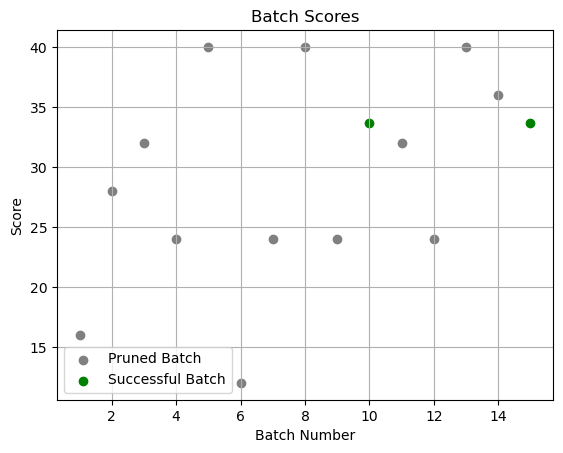

In [10]:
import matplotlib.pyplot as plt


trial_logs = optimized_program.trial_logs

trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]["score"] for trial in trial_numbers]

full_eval = [trial_logs[trial]["full_eval"] for trial in trial_numbers]

for trial_number, score, pruned in zip(trial_numbers, scores, full_eval):
    if pruned is False:
        plt.scatter(
            trial_number,
            score,
            color="grey",
            label=(
                "Pruned Batch"
                if "Pruned Batch" not in plt.gca().get_legend_handles_labels()[1]
                else ""
            ),
        )
    else:
        plt.scatter(
            trial_number,
            score,
            color="green",
            label=(
                "Successful Batch"
                if "Successful Batch" not in plt.gca().get_legend_handles_labels()[1]
                else ""
            ),
        )

plt.xlabel("Batch Number")
plt.ylabel("Score")
plt.title("Batch Scores")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
best_score = 0
best_program_so_far = None


def get_signature(predictor):
    if hasattr(predictor, "extended_signature"):
        return predictor.extended_signature
    elif hasattr(predictor, "signature"):
        return predictor.signature


# print(f"Baseline program | Score: {best_score}:")
# for i, predictor in enumerate(WrapperEnglishSPT().predictors()):
#     print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
# print()

print("----------------")

for trial_num in optimized_program.trial_logs:
    program_score = optimized_program.trial_logs[trial_num]["score"]
    program_pruned = optimized_program.trial_logs[trial_num]["full_eval"]
    # if (
    #     program_score > best_score
    #     and program_pruned is True
    #     # and optimized_program.trial_logs[trial_num]["full_eval"]
    # ):
    if program_pruned is True:
        best_score = program_score
        best_program_so_far = optimized_program.trial_logs[trial_num]["program"]
    # if trial_num % 5 == 0:
    #     print(f"Best program after {trial_num} batches | Score: {best_score}:")
    #     for i, predictor in enumerate(best_program_so_far.predictors()):
    #         print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
    #     print()
    
        # print(f"Best program with best score: {best_score}")
        for i, predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {trial_num} Instruction: {get_signature(predictor).instructions}")
            print(best_score)
        print()

----------------
Prompt 10 Instruction: The word "aguantar" in both sentences refers to enduring or withstanding something, but the contexts differ slightly. In Sentence 1, it means enduring a tedious situation, while in Sentence 2, it implies restraining someone.

Answer: 1
33.62

Prompt 15 Instruction: La palabra "sexo" en ambas oraciones se refiere a la noción de género, pero en contextos diferentes. En la primera oración, se usa para describir a las personas de ambos géneros que participan en un acto político, mientras que en la segunda oración se usa para definir una característica personal de Susana como mujer.
33.62



In [12]:
program_spt_prompt_es_assertions.load(
    "compile-models/sp/es_spt_mipro_optimized_prompt_es_deepseek-q4"
)

In [13]:

custom_evaluate(
    random.choices(classes_1_test, k=225)
    + random.choices(classes_2_test, k=225)
    + random.choices(classes_3_test, k=225)
    + random.choices(classes_4_test, k=225),
    evaluate_answer,
    program_spt_prompt_es_assertions,
    debug=True,
)

Evaluating: 900 examples


Prediction:  1


Prediction:  1
Prediction:  2


Prediction:  4
Prediction:  1
Prediction:  3
Prediction:  2
Prediction:  4
Prediction:  1


Prediction:  1
Prediction:  4


Prediction:  2
Prediction:  1
Prediction:  3
Prediction:  1


Prediction:  1
Prediction:  1


Prediction:  1
Prediction:  4
Prediction:  1


Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  2
Prediction:  1


Prediction:  3


Prediction:  1


Prediction:  3
Prediction:  2


Prediction:  2
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  3


Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  2
Prediction:  1


Prediction:  4
Prediction:  1
Prediction:  1


Prediction:  4
Prediction:  1
Prediction:  1


Prediction:  1
Prediction:  3


2025/04/19 20:09:21 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Prediction:  4
Prediction:  3
Prediction:  2
Prediction:  1


Prediction:  3
Prediction:  1
Prediction:  1
Prediction:  4


Prediction:  1


Prediction:  1


Prediction:  1
Prediction:  3


Prediction:  2
Prediction:  1
Prediction:  1


Prediction:  2
Prediction:  4
Prediction:  2


Prediction:  2
Prediction:  1
Prediction:  4


Prediction:  3


Prediction:  3
Prediction:  1
Prediction:  2


Prediction:  3
Prediction:  1


Prediction:  1


Prediction:  1


Prediction:  3
Prediction:  1
Prediction:  1


Prediction:  4
Prediction:  4
Prediction:  1
Prediction:  2
Prediction:  3
Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  3
Prediction:  2
Prediction:  2
Prediction:  3


Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  2


Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  2
Prediction:  3
Prediction:  1
Prediction:  3


Prediction:  1
Prediction:  2
Prediction:  4
Prediction:  4
Prediction:  1


Prediction:  4
Prediction:  1


Prediction:  2
Prediction:  4
Prediction:  1
Prediction:  4


Prediction:  1
Prediction:  1
Prediction:  3
Prediction:  2
Prediction:  1


Prediction:  1


Prediction:  1
Prediction:  2
Prediction:  1
Prediction:  2
Prediction:  1
Prediction:  3
Prediction:  3
Prediction:  2
Prediction:  2


Prediction:  1
Prediction:  3
Prediction:  2
Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  2
Prediction:  3


Prediction:  1
Prediction:  2


Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1


Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  3
Prediction:  3
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  2
Prediction:  3
Prediction:  2
Prediction:  3
Prediction:  3
Prediction:  2
Prediction:  2
Prediction:  2
Prediction:  3
Prediction:  2


Prediction:  2
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  1


Prediction:  1
Prediction:  2


Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1


Prediction:  3
Prediction:  3


Prediction:  2
Prediction:  1


Prediction:  2
Prediction:  2


2025/04/19 21:05:28 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  4
Prediction:  2
Prediction:  4
Prediction:  2
Prediction:  1
Prediction:  2
Prediction:  3
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  2
Prediction:  2
Prediction:  1
Prediction:  4


Prediction:  2


Prediction:  3
Prediction:  4
Prediction:  4
Prediction:  1


Prediction:  2
Prediction:  2
Prediction:  3


Prediction:  4


Prediction:  3
Prediction:  2
Prediction:  3
Prediction:  2


Prediction:  1


Prediction:  4
Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  3
Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  1
Prediction:  2


Prediction:  2
Prediction:  1
Prediction:  3


Prediction:  2
Prediction:  2


Prediction:  4
Prediction:  1
Prediction:  4
Prediction:  3
Prediction:  4
Prediction:  3
Prediction:  1
Prediction:  2
Prediction:  3
Prediction:  2


Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  1


Prediction:  1


Prediction:  3
Prediction:  3
Prediction:  1
Prediction:  3


Prediction:  1


Prediction:  1
Prediction:  4
Prediction:  4
Prediction:  2


Prediction:  1


Prediction:  3
Prediction:  1


Prediction:  1
Prediction:  2
Prediction:  3


Prediction:  4
Prediction:  1
Prediction:  1


Prediction:  1
Prediction:  2
Prediction:  3
Prediction:  3


Prediction:  3
Prediction:  3


Prediction:  4
Prediction:  1


Prediction:  4
Prediction:  1
Prediction:  1
Prediction:  2
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  4
Prediction:  4


Prediction:  3


Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  1
Prediction:  3
Prediction:  2
Prediction:  3
Prediction:  2


Prediction:  1
Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  1


Prediction:  2
Prediction:  1
Prediction:  1


Prediction:  1
Prediction:  1
Prediction:  3
Prediction:  4


Prediction:  1
Prediction:  3


Prediction:  1


Prediction:  3
Prediction:  3


Prediction:  2
Prediction:  4


Prediction:  3
Prediction:  1
Prediction:  3


Prediction:  2
Prediction:  4
Prediction:  1
Prediction:  2
Prediction:  2


Prediction:  1
Prediction:  3


Prediction:  3
Prediction:  2
Prediction:  4
Prediction:  4


Prediction:  4


Prediction:  4
Prediction:  1


Prediction:  2
Prediction:  4


Prediction:  1
Prediction:  2
Prediction:  2
Prediction:  2
Prediction:  1


Prediction:  4


Prediction:  1
Prediction:  3
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  3


Prediction:  2
Prediction:  3


Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  2
Prediction:  2
Prediction:  3
Prediction:  4
Prediction:  1
Prediction:  2
Prediction:  4
Prediction:  1


Prediction:  3
Prediction:  2
Prediction:  3


Prediction:  3


Prediction:  3
Prediction:  3
Prediction:  3
Prediction:  1
Prediction:  1
Prediction:  3
Prediction:  3
Prediction:  1


Prediction:  4
Prediction:  1
Prediction:  2
Prediction:  1
Prediction:  3
Prediction:  4
Prediction:  1
Prediction:  1


Prediction:  1


Prediction:  2
Prediction:  3
Prediction:  1
Prediction:  2
Prediction:  3
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  3
Prediction:  2


Prediction:  4
Prediction:  4
Prediction:  3
Prediction:  1
Prediction:  3
Prediction:  1


2025/04/19 22:31:13 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/19 22:32:39 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


2025/04/19 22:32:39 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Prediction:  0
Prediction:  1
Prediction:  4
Prediction:  1


Prediction:  2
Prediction:  3
Prediction:  3
Prediction:  3


Prediction:  4
Prediction:  2


Prediction:  2
Prediction:  2


Prediction:  1
Prediction:  1
Prediction:  1
Prediction:  4


Prediction:  1
Prediction:  3


Prediction:  3


Prediction:  3
Prediction:  1


Prediction:  4
Prediction:  1
Prediction:  4
Prediction:  1
Prediction:  1
Prediction:  2
Prediction:  1
Prediction:  4


Prediction:  3


Prediction:  4


Prediction:  3
Prediction:  2
Prediction:  4


Prediction:  3


Prediction:  3
Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  2
Prediction:  4


Prediction:  1
Prediction:  4
Prediction:  3
Prediction:  1


Prediction:  2


Prediction:  4


Prediction:  2


Prediction:  3


Prediction:  2


Prediction:  2


Prediction:  2
Prediction:  4


Prediction:  3
Prediction:  3
Prediction:  3


Prediction:  4
Prediction:  4


Prediction:  1
Prediction:  2
Prediction:  4


Prediction:  3


Prediction:  4


Prediction:  4
Prediction:  4
Prediction:  4
Prediction:  3
Prediction:  2


Prediction:  3
Prediction:  3


Prediction:  2


Prediction:  1
Prediction:  2


Prediction:  3


Prediction:  4
Prediction:  2


Prediction:  4
Prediction:  3


Prediction:  4


Prediction:  1


Prediction:  3
Prediction:  3


Prediction:  3
Prediction:  3
Prediction:  1


Prediction:  3


Prediction:  4
Prediction:  3


Prediction:  1
Prediction:  4
Prediction:  1


Prediction:  3


Prediction:  3
Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  4
Prediction:  4
Prediction:  3
Prediction:  3


Prediction:  2


Prediction:  3
Prediction:  2
Prediction:  4


Prediction:  3


Prediction:  3
Prediction:  3


Prediction:  4
Prediction:  2


Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  2


Prediction:  3
Prediction:  3


Prediction:  3


Prediction:  4
Prediction:  2


Prediction:  3


Prediction:  1
Prediction:  4
Prediction:  2
Prediction:  4
Prediction:  4
Prediction:  4


Prediction:  2
Prediction:  2
Prediction:  3


Prediction:  2
Prediction:  4


Prediction:  4
Prediction:  1
Prediction:  4


Prediction:  3
Prediction:  4


Prediction:  4


Prediction:  4
Prediction:  4
Prediction:  3


Prediction:  2


Prediction:  2
Prediction:  4


Prediction:  2
Prediction:  4
Prediction:  3


Prediction:  1
Prediction:  3


Prediction:  2
Prediction:  1


Prediction:  3
Prediction:  3
Prediction:  4


Prediction:  4


Prediction:  2
Prediction:  4
Prediction:  2
Prediction:  4
Prediction:  3
Prediction:  2


Prediction:  1
Prediction:  3


Prediction:  3
Prediction:  3
Prediction:  3


Prediction:  4


Prediction:  2
Prediction:  2
Prediction:  3
Prediction:  2


Prediction:  2
Prediction:  3
Prediction:  4
Prediction:  1
Prediction:  2
Prediction:  2
Prediction:  4


Prediction:  1
Prediction:  3
Prediction:  3


Prediction:  2


Prediction:  4


Prediction:  1
Prediction:  4
Prediction:  3


Prediction:  4
Prediction:  3
Prediction:  3


Prediction:  1
Prediction:  1


Prediction:  3
Prediction:  1
Prediction:  2


Prediction:  1
Prediction:  3


Prediction:  4
Prediction:  3
Prediction:  2
Prediction:  2


Prediction:  4
Prediction:  1


Prediction:  3
Prediction:  3
Prediction:  1


Prediction:  2
Prediction:  3
Prediction:  4


Prediction:  4
Prediction:  2
Prediction:  3


Prediction:  2


Prediction:  2
Prediction:  2
Prediction:  2
Prediction:  2
Prediction:  3
Prediction:  4
Prediction:  3
Prediction:  2
Prediction:  1


Prediction:  3
Prediction:  4


Prediction:  3
Prediction:  3


Prediction:  3


Prediction:  4
Prediction:  3


Prediction:  1


Prediction:  3
Prediction:  2


Prediction:  2


Prediction:  1
Prediction:  2
Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  2
Prediction:  2
Prediction:  4
Prediction:  1
Prediction:  4
Prediction:  4
Prediction:  4


Prediction:  4


Prediction:  2


Prediction:  3
Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  4


Prediction:  3
Prediction:  3


2025/04/20 01:21:51 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Prediction:  2
Prediction:  3
Prediction:  3


Prediction:  3


Prediction:  4
Prediction:  3
Prediction:  1


Prediction:  1


Prediction:  4
Prediction:  3
Prediction:  3


Prediction:  3


Prediction:  2
Prediction:  4


Prediction:  4
Prediction:  4
Prediction:  3
Prediction:  4


Prediction:  3


Prediction:  4


Prediction:  4


Prediction:  1


Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  4


Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  3


Prediction:  3
Prediction:  4


Prediction:  1
Prediction:  4


Prediction:  3


Prediction:  3
Prediction:  2


Prediction:  4
Prediction:  4


Prediction:  4


Prediction:  3


Prediction:  4


Prediction:  4
Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  4
Prediction:  3


Prediction:  2


Prediction:  3


Prediction:  4


Prediction:  4


Prediction:  4
Prediction:  3


Prediction:  4
Prediction:  4


2025/04/20 02:14:54 INFO dspy.primitives.assertions: SuggestionFailed: La salida deberia ser 1 o 2 o 3 o 4. Por favor, revise en consecuencia.


Prediction:  3
Prediction:  3


Prediction:  4


Prediction:  3
Prediction:  4


Prediction:  1
Prediction:  4


Prediction:  1
Prediction:  4
Prediction:  4
Prediction:  4
Prediction:  1
Prediction:  3
Prediction:  4


Prediction:  1


Prediction:  3


Prediction:  4
Prediction:  4
Prediction:  3
Prediction:  4


Prediction:  4


Prediction:  2


Prediction:  3


Prediction:  4


Prediction:  3


Prediction:  4
Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  4


Prediction:  3
Prediction:  4


Prediction:  4


Prediction:  2


Prediction:  4


Prediction:  3


Prediction:  3


Prediction:  4


Prediction:  4


Prediction:  1


Prediction:  4
Prediction:  2


Prediction:  3


Prediction:  4
Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  1


Prediction:  3


Prediction:  4
Prediction:  4


Prediction:  4


Prediction:  4
Prediction:  4
Prediction:  3


Prediction:  3


Prediction:  3
Prediction:  2
Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  2


Prediction:  3


Prediction:  4
Prediction:  4
Prediction:  2
Prediction:  4
Prediction:  2
Prediction:  4


Prediction:  4


Prediction:  2


Prediction:  2


Prediction:  3
Prediction:  4
Prediction:  2
Prediction:  1
Prediction:  1
Prediction:  4
Prediction:  4
Prediction:  2
Prediction:  4
Prediction:  4
Prediction:  3


Prediction:  3
Prediction:  4
Prediction:  3


Prediction:  4
Prediction:  4


Prediction:  3


Prediction:  4
Prediction:  3


Prediction:  2
Prediction:  2
Prediction:  3
Prediction:  3
Prediction:  1


Prediction:  2


Prediction:  3


Prediction:  4


Prediction:  3


Prediction:  4
Prediction:  3


Prediction:  3


Prediction:  4
Prediction:  4


Prediction:  3
Prediction:  2


Prediction:  4
Prediction:  4


Prediction:  4


Prediction:  3


Prediction:  3


Prediction:  3
Prediction:  4
Prediction:  3
Prediction:  4


Prediction:  3
Prediction:  2
Prediction:  3


Prediction:  3
Prediction:  4


Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  2
Prediction:  4
Prediction:  4


Prediction:  3


Prediction:  4


Prediction:  4


Prediction:  3
Prediction:  4
Prediction:  4
Prediction:  4
Prediction:  4
Prediction:  3
Prediction:  4
Prediction:  4
Prediction:  3
Prediction:  4
Prediction:  4


Prediction:  4
Prediction:  4


Prediction:  4
Prediction:  3
Prediction:  3
Prediction:  3
Prediction:  4


Prediction:  3
Prediction:  4
Prediction:  1
Prediction:  3


Prediction:  1


Prediction:  1
Prediction:  4


Prediction:  4
Prediction:  4
Prediction:  4
Accurate examples: 348
Bad-formatted examples: 0
Accuracy: 38.666666666666664
